## Lecture 6 - Image Classification using Custom Estimators in TF ##
In this Lecture, We are going to create our custom estimator for deep learning.

In [3]:
import numpy as np
import tensorflow as tf

# Plot drawing library
import matplotlib.pyplot as plt

# Make plots usable in notebook
%matplotlib inline

### Prepare data ###
I will be using the MNIST dataset that contains hand-written digits in 28x28 pixel images. MNIST dataset is coming with tensorflow and can be loaded using ```tf.contrib.learn.datasets.load_dataset("mnist")```

In [4]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")

training_data = mnist.train.images # Images as numpy array
training_labels = np.asarray(mnist.train.labels, dtype=np.int32) # Labels as numpy array

test_data = mnist.test.images
test_labels = np.asarray(mnist.test.labels, dtype=np.int32)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


### Show Data ###
Show the images of MNIST Dataset using Matplotlib

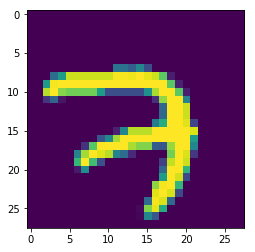

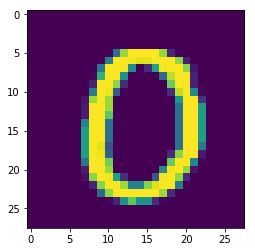

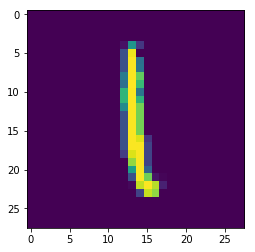

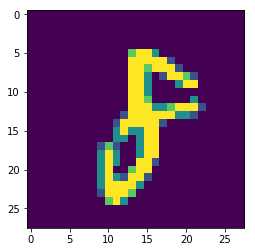

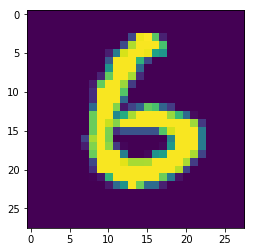

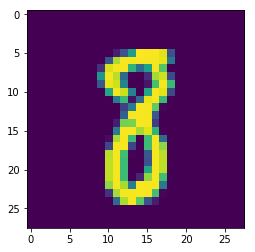

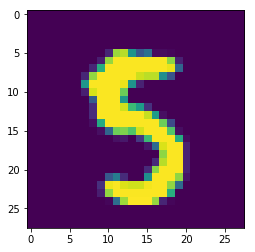

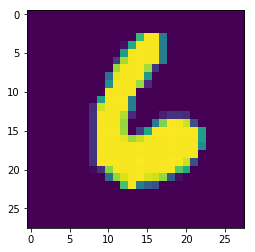

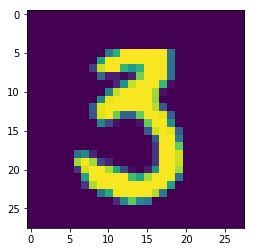

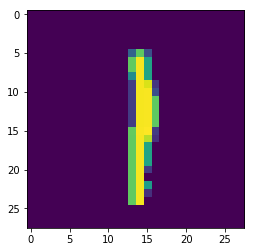

In [37]:
for i in range(10):
    plt.imshow(training_data[i*10].reshape([28,28]))
    plt.show()

### Create the Model Function ###
Model Function is what contains our model and the modes needed to run our model operations such as prediction, training andtest.

In [69]:
def cnn_model_fn(features, labels, mode):
    # Input Layer: Get data and reshape for the use case. 
    input_layer = tf.reshape(features["data"], [-1, 28, 28, 1])
    
    # Convolutional Layer 1
    conv1 = tf.layers.conv2d(inputs=input_layer,
                             filters=32,
                             kernel_size=[5,5],
                             padding="same",
                             activation=tf.nn.relu)
    
    # Pooling Layer 1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2], strides=2)
    
    # Convolutional Layer 2
    conv2 = tf.layers.conv2d(inputs=pool1,
                             filters=64,
                             kernel_size=[5,5],
                             padding="same",
                             activation=tf.nn.relu)
    
    # Pooling Layer 2
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2], strides=2)
    
    # Flatten and Dense Layer
    # Data has 7 (pool2 height) * 7 (pool2 width) * 64 (pool2 channels) features,
    # so we want the features dimension to have a value of 7 * 7 * 64
    # It changes a 2D array to 1D array
    flatten = tf.reshape(pool2, [-1, 7 * 7 * 64])
    
    dense = tf.layers.dense(inputs=flatten, units=1024, activation=tf.nn.relu)
    
    # Dropout: Eliminate some nodes randomly for optimization of different routes
    dropout = tf.layers.dropout(inputs=dense,
                                rate=0.4,
                                training=(mode == tf.estimator.ModeKeys.TRAIN))
    
    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)
    
    predictions = {
        "classes": tf.argmax(input=logits, axis=1),
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])
    }
    
    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

### Create Custom Estimator using Model Function ###

In [62]:
CNNClassifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="lecture6models")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'lecture6models', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c1d701a58>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Set Up a Logging Hook for Predictions ###
We can save our predictictionsto track progress and debugging. This logs can also be shown in the TensorBoard.

In [63]:
tensors_to_log = {"probabilities":"softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)

### Train The Model ###

In [64]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(x={"data": training_data},
                                                    y=training_labels,
                                                    batch_size=100,
                                                    num_epochs=None,
                                                    shuffle=True)

CNNClassifier.train(input_fn=train_input_fn,
                    steps=20000,
                    hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into lecture6models/model.ckpt.
INFO:tensorflow:probabilities = [[0.09412812 0.08350402 0.10336171 0.11309827 0.10261451 0.10826698
  0.08843824 0.10065272 0.10891833 0.09701709]
 [0.09757431 0.10443917 0.09879543 0.09025762 0.08590952 0.10575113
  0.08935093 0.11116201 0.12664366 0.09011623]
 [0.10135215 0.11020764 0.11887965 0.09464    0.09219708 0.09073468
  0.09156357 0.10723579 0.10035579 0.09283367]
 [0.09417832 0.10355815 0.09370391 0.10010064 0.09905191 0.10384084
  0.08894226 0.09394831 0.11483242 0.10784326]
 [0.09117123 0.09453902 0.10323054 0.09536085 0.09966695 0.10657158
  0.10043754 0.10335764 0.10858956 0.09707499]
 [0.09221742 0.10585618 0.10163122 0.0878993  0.09911698 0.10382103
  0.10092738 0.

INFO:tensorflow:loss = 2.2993991, step = 1
INFO:tensorflow:probabilities = [[0.09225931 0.10357469 0.09514739 0.10362934 0.09211322 0.11340842
  0.08900238 0.1075481  0.1097431  0.09357404]
 [0.09237531 0.09605177 0.09672725 0.09480147 0.09885319 0.11123463
  0.10604785 0.10640769 0.10351133 0.09398958]
 [0.11101519 0.09138825 0.10224125 0.09813571 0.11321976 0.10994966
  0.07828167 0.09999338 0.10094847 0.09482671]
 [0.09406231 0.09521715 0.09798872 0.10351507 0.10731614 0.09876447
  0.09198969 0.10152238 0.10566054 0.10396347]
 [0.09605524 0.10336715 0.09801172 0.09867224 0.10394414 0.09325074
  0.09371729 0.1195268  0.09500717 0.09844757]
 [0.1008345  0.09924079 0.10219472 0.09862117 0.10404613 0.10339609
  0.08945401 0.11081433 0.10377581 0.08762241]
 [0.09325436 0.09443519 0.10446847 0.09238621 0.10234686 0.09806789
  0.10361157 0.1234266  0.09106118 0.09694167]
 [0.09113479 0.09767968 0.0950105  0.09904216 0.09335579 0.10630747
  0.09745488 0.10261513 0.11629729 0.10110232]
 [0.0

INFO:tensorflow:global_step/sec: 3.28777
INFO:tensorflow:probabilities = [[0.09370542 0.10630034 0.09454137 0.10577264 0.09785307 0.10254482
  0.09655221 0.10154711 0.09643126 0.10475178]
 [0.09007426 0.1180651  0.09288922 0.0972512  0.08756518 0.11215742
  0.10055804 0.10388728 0.10798832 0.08956398]
 [0.0951585  0.10447694 0.09644897 0.10948439 0.09490307 0.10609736
  0.10095339 0.10190346 0.09641476 0.0941591 ]
 [0.09444477 0.11114441 0.09794475 0.09457981 0.09933908 0.10946988
  0.09947243 0.09607277 0.09814613 0.099386  ]
 [0.08639378 0.10583135 0.11357361 0.09288034 0.09779985 0.09838337
  0.0910778  0.1022687  0.10238498 0.10940617]
 [0.10653897 0.09497043 0.10157229 0.08837545 0.0958757  0.10512957
  0.08426055 0.10260868 0.11407284 0.10659551]
 [0.11472514 0.11359287 0.09692728 0.09544298 0.0858726  0.11028329
  0.09248192 0.08783978 0.10124842 0.10158571]
 [0.08827786 0.10438585 0.10537741 0.10213468 0.0920784  0.10200383
  0.10281562 0.10753277 0.11383964 0.081554  ]
 [0.100

INFO:tensorflow:loss = 2.2869256, step = 101 (30.416 sec)
INFO:tensorflow:probabilities = [[0.10040523 0.09070175 0.10057475 0.0902791  0.11367721 0.0959025
  0.09887489 0.10558829 0.10451392 0.09948235]
 [0.08393227 0.09541626 0.09630261 0.09359962 0.09240136 0.11314155
  0.0965988  0.11347945 0.10744311 0.10768501]
 [0.10716669 0.09281938 0.08939169 0.10256514 0.10091933 0.10267497
  0.08918628 0.10958977 0.10015245 0.10553428]
 [0.11591691 0.10714062 0.09948283 0.10909221 0.09840273 0.0982374
  0.08244087 0.09492382 0.09063926 0.10372341]
 [0.10759727 0.09827383 0.1035317  0.08938548 0.0875363  0.11991547
  0.09793308 0.10393596 0.09686172 0.09502917]
 [0.09722083 0.09762224 0.09992804 0.10480678 0.10100242 0.10068508
  0.10108872 0.10161164 0.09827259 0.09776165]
 [0.09279812 0.10288364 0.10046675 0.09426355 0.09541164 0.10215093
  0.10499857 0.10328809 0.10067888 0.10305987]
 [0.1061084  0.09462861 0.09958667 0.10034212 0.10079841 0.09601109
  0.09121021 0.09924196 0.10755624 0.10

INFO:tensorflow:global_step/sec: 3.58194
INFO:tensorflow:probabilities = [[0.09455825 0.10468265 0.10317233 0.09812284 0.08982965 0.09443663
  0.0973773  0.10229891 0.11529187 0.10022961]
 [0.09952416 0.09050005 0.10659985 0.10446141 0.09238161 0.09235602
  0.09291139 0.09914996 0.11615912 0.10595648]
 [0.09773472 0.09245677 0.11057837 0.09568124 0.09429117 0.1053082
  0.08794611 0.11209314 0.10563049 0.09827979]
 [0.09677833 0.08947041 0.10369756 0.1004419  0.10373791 0.10676324
  0.09325899 0.1105075  0.10168013 0.093664  ]
 [0.10329614 0.09479735 0.09585138 0.1019294  0.11366197 0.09989352
  0.08644186 0.09325586 0.11626994 0.09460255]
 [0.08758917 0.10149039 0.099367   0.10111591 0.10204422 0.09814423
  0.10100283 0.10412377 0.10012314 0.1049993 ]
 [0.11234341 0.10078013 0.08385582 0.08497737 0.08210745 0.11504626
  0.09633269 0.11519986 0.10940638 0.09995064]
 [0.10871326 0.08811557 0.10640436 0.1064766  0.09480515 0.11098364
  0.08573753 0.10634445 0.09238048 0.10003892]
 [0.0974

INFO:tensorflow:loss = 2.2819445, step = 201 (27.918 sec)
INFO:tensorflow:probabilities = [[0.10729938 0.08655882 0.10374287 0.10316528 0.10244785 0.09772187
  0.0881025  0.10001616 0.10590051 0.10504477]
 [0.0977065  0.09539079 0.1036561  0.09925191 0.10216231 0.09638885
  0.08197713 0.11252166 0.11697326 0.09397149]
 [0.10877592 0.09037481 0.10690533 0.10354377 0.09703244 0.10660972
  0.0936568  0.09027698 0.11257836 0.0902459 ]
 [0.09889064 0.10186661 0.0994978  0.10259523 0.09546947 0.09726544
  0.10944445 0.09625947 0.09892268 0.09978818]
 [0.11557585 0.09217367 0.10476404 0.10741013 0.08546197 0.10122716
  0.09254152 0.10181548 0.10656998 0.09246023]
 [0.10344905 0.10105853 0.08914237 0.09544154 0.10196622 0.1119265
  0.08331827 0.09678111 0.11004019 0.1068762 ]
 [0.09269721 0.10476284 0.089381   0.0979932  0.1019333  0.10666914
  0.10168806 0.10133938 0.10827356 0.09526234]
 [0.09847358 0.09899471 0.11046379 0.09910706 0.10491595 0.09572577
  0.10425083 0.08975198 0.10937403 0.0

INFO:tensorflow:global_step/sec: 3.68497
INFO:tensorflow:probabilities = [[0.11099443 0.08635539 0.10478991 0.0983484  0.10290202 0.08834783
  0.10541952 0.10880525 0.10440832 0.08962893]
 [0.12929702 0.08551705 0.09428414 0.09417585 0.09698189 0.10241084
  0.09410391 0.09799799 0.1168734  0.0883579 ]
 [0.09636244 0.09285288 0.08465222 0.11347143 0.09333515 0.09374747
  0.11342611 0.09939144 0.127156   0.08560486]
 [0.10010616 0.10404211 0.10679707 0.09679317 0.09064108 0.09818849
  0.10539165 0.09354863 0.1060055  0.09848621]
 [0.07991095 0.10332856 0.09889105 0.10648233 0.09715672 0.09310825
  0.10081166 0.10875275 0.09842553 0.11313225]
 [0.10539039 0.10234709 0.08728791 0.09873235 0.10203316 0.1041157
  0.10494218 0.08932547 0.11323556 0.09259018]
 [0.11247716 0.08299173 0.09254319 0.10827097 0.08318383 0.10046197
  0.08931383 0.10248849 0.13153617 0.09673257]
 [0.11195263 0.09101866 0.0837952  0.11002672 0.09426469 0.09414692
  0.09575877 0.10558875 0.11401333 0.09943429]
 [0.1025

INFO:tensorflow:loss = 2.2418098, step = 301 (27.136 sec)
INFO:tensorflow:probabilities = [[0.10708904 0.1041196  0.11955682 0.09669761 0.0973225  0.09226558
  0.09820946 0.09579333 0.08932512 0.09962092]
 [0.10468696 0.0939344  0.09394216 0.09335312 0.10261944 0.09224661
  0.09197707 0.10620254 0.12154676 0.09949099]
 [0.11269166 0.09356251 0.09474497 0.10890886 0.09156477 0.10711324
  0.08287564 0.09107324 0.1125816  0.10488348]
 [0.10875941 0.08572324 0.10241921 0.10515164 0.10687596 0.10535955
  0.08001482 0.09001134 0.11913898 0.09654577]
 [0.1012772  0.09978031 0.10065437 0.11435864 0.0918549  0.11160843
  0.08133328 0.0880059  0.1083488  0.10277814]
 [0.09385793 0.09797997 0.10668489 0.10314146 0.09071317 0.10370281
  0.08999138 0.10071838 0.11004559 0.10316445]
 [0.09035124 0.09549799 0.09241664 0.11245234 0.09923001 0.10505858
  0.09477383 0.09603053 0.11105493 0.10313396]
 [0.10891354 0.09437545 0.09635407 0.0973129  0.10530332 0.10104053
  0.09307352 0.1046632  0.10774489 0.

INFO:tensorflow:global_step/sec: 3.60996
INFO:tensorflow:probabilities = [[0.1036121  0.08613614 0.09508482 0.09954995 0.09531783 0.09514955
  0.12616387 0.09254484 0.11376124 0.09267976]
 [0.09702389 0.11937361 0.09867509 0.09884154 0.08990241 0.09741773
  0.09610461 0.09863427 0.10135324 0.10267366]
 [0.09015965 0.08834027 0.0997211  0.10040358 0.09650894 0.09553333
  0.0947067  0.10788715 0.11754899 0.10919034]
 [0.10125212 0.0988113  0.09857479 0.10252248 0.09258147 0.11025802
  0.07802732 0.09797225 0.11291854 0.10708179]
 [0.09480508 0.09240533 0.0956665  0.09898279 0.10066204 0.11559556
  0.07768629 0.11140234 0.10526796 0.10752612]
 [0.10175544 0.08931971 0.11750204 0.09273203 0.11067943 0.09051787
  0.08391083 0.09388556 0.11006051 0.10963653]
 [0.09267681 0.09806584 0.09437667 0.10290089 0.09399369 0.10585459
  0.0983887  0.11045393 0.11275526 0.09053362]
 [0.0894758  0.09910826 0.10232048 0.10811272 0.08540067 0.108813
  0.0942459  0.1067714  0.10655899 0.09919277]
 [0.11152

INFO:tensorflow:loss = 2.2258296, step = 401 (27.706 sec)
INFO:tensorflow:probabilities = [[0.11905703 0.074165   0.09143669 0.09272071 0.10151795 0.10490717
  0.08004593 0.11421084 0.11852387 0.10341483]
 [0.08630916 0.09571568 0.10077003 0.0986875  0.09873302 0.09995433
  0.11697606 0.09005945 0.11753572 0.09525903]
 [0.08956859 0.08526084 0.09154563 0.13242221 0.08144122 0.10022652
  0.08587583 0.11810335 0.12423118 0.09132458]
 [0.09292093 0.09172653 0.09123505 0.11863325 0.11100268 0.09197061
  0.08961646 0.09974556 0.10460764 0.10854137]
 [0.08548191 0.09792268 0.10194375 0.10201144 0.09427089 0.10220801
  0.11911798 0.09395991 0.11805915 0.08502431]
 [0.12976772 0.08325026 0.10369509 0.10740433 0.09380668 0.10965873
  0.09260062 0.08981645 0.10823377 0.08176632]
 [0.08321249 0.09822258 0.1060404  0.0856449  0.11711034 0.09812754
  0.10156094 0.10433438 0.11542102 0.09032536]
 [0.10948955 0.08596353 0.100191   0.10286777 0.09573347 0.11228988
  0.09560327 0.09926075 0.09583886 0.

INFO:tensorflow:global_step/sec: 3.47678
INFO:tensorflow:probabilities = [[0.11471766 0.07687935 0.08681101 0.10466923 0.10828828 0.09712687
  0.09245066 0.11305575 0.11031915 0.09568202]
 [0.09244134 0.09975504 0.10730396 0.12694141 0.08136611 0.0972543
  0.09281405 0.0953845  0.12456614 0.08217322]
 [0.0847079  0.11212194 0.11856209 0.10296886 0.0869998  0.09315999
  0.0976852  0.09514529 0.10378419 0.10486471]
 [0.10921554 0.10615344 0.11106449 0.08958623 0.07671814 0.10615032
  0.09501064 0.09730807 0.10800946 0.10078372]
 [0.10013571 0.09401047 0.11002135 0.09629376 0.09399053 0.10773698
  0.10673459 0.08750337 0.10889066 0.09468258]
 [0.13319829 0.09405488 0.10412078 0.09560144 0.08783896 0.08041996
  0.10488419 0.09429502 0.10936634 0.09622018]
 [0.12508677 0.09248453 0.09828207 0.0852197  0.09074401 0.08969078
  0.1236622  0.09865694 0.10574496 0.09042803]
 [0.09936184 0.09657171 0.09306359 0.08848271 0.09463616 0.09695867
  0.10453449 0.09273325 0.10827038 0.12538715]
 [0.1055

INFO:tensorflow:loss = 2.2095041, step = 501 (28.765 sec)
INFO:tensorflow:probabilities = [[0.09585066 0.08927571 0.11797818 0.110418   0.11038294 0.10445329
  0.08867364 0.08584881 0.11221229 0.08490644]
 [0.12130526 0.08019771 0.09674254 0.1053234  0.09401201 0.08926637
  0.09931327 0.10739096 0.11553288 0.09091567]
 [0.10384269 0.099031   0.08292782 0.10204913 0.09288593 0.08882011
  0.11999436 0.09201706 0.12544213 0.09298988]
 [0.1148135  0.08687559 0.11722935 0.08494844 0.09617647 0.08468837
  0.07778288 0.09847506 0.13751273 0.10149762]
 [0.08545843 0.101368   0.11372779 0.10149609 0.08338998 0.09623839
  0.0897799  0.10412191 0.11435192 0.1100676 ]
 [0.09506304 0.08629916 0.07786869 0.10731618 0.11060876 0.0896078
  0.11839771 0.10251214 0.10923044 0.10309613]
 [0.10210685 0.08935877 0.09247878 0.0951189  0.10744854 0.10278502
  0.08872905 0.10212978 0.10933667 0.11050764]
 [0.0962376  0.08596013 0.10128801 0.09279742 0.0929735  0.10214768
  0.09446793 0.1222776  0.10211844 0.1

INFO:tensorflow:global_step/sec: 3.33369
INFO:tensorflow:probabilities = [[0.08845785 0.08297107 0.09298192 0.11248264 0.08478632 0.08798678
  0.0984513  0.1163352  0.11511954 0.12042742]
 [0.10464437 0.07834709 0.10942625 0.10053646 0.11078906 0.0918531
  0.10138981 0.08408781 0.11740986 0.10151622]
 [0.09955479 0.09726676 0.10173945 0.10468917 0.10017236 0.10336424
  0.09628803 0.09071378 0.11307379 0.09313758]
 [0.09867983 0.11263892 0.07809738 0.09138945 0.08773161 0.10359576
  0.11126254 0.08793686 0.1227014  0.10596612]
 [0.08696106 0.09865683 0.10792209 0.09631832 0.096611   0.11082242
  0.09277951 0.08645211 0.12131664 0.10215997]
 [0.10256898 0.08576098 0.09594086 0.12806863 0.1034841  0.09026493
  0.08314928 0.101174   0.10125062 0.1083377 ]
 [0.10882294 0.09698436 0.10882217 0.12225312 0.09130541 0.08792732
  0.0964983  0.08437189 0.09031224 0.11270228]
 [0.09688425 0.10755889 0.10129518 0.11657815 0.08020016 0.09261609
  0.08455044 0.09100104 0.12623268 0.10308308]
 [0.1682

INFO:tensorflow:loss = 2.164048, step = 601 (29.990 sec)
INFO:tensorflow:probabilities = [[0.10067472 0.10874953 0.10438034 0.11102744 0.07728488 0.09022851
  0.09918451 0.08617656 0.12143363 0.10085985]
 [0.09315415 0.11341294 0.07746871 0.11396211 0.0777019  0.08733504
  0.10455733 0.10166557 0.12894374 0.10179847]
 [0.13877083 0.08222122 0.09176628 0.11238076 0.09874968 0.07481662
  0.12179698 0.08213276 0.09562183 0.10174301]
 [0.1157453  0.10646676 0.09414833 0.10514256 0.08669276 0.0872139
  0.10877905 0.09978953 0.10851289 0.08750898]
 [0.14131717 0.07062129 0.11211376 0.09295476 0.08772811 0.09323782
  0.07625259 0.12744641 0.09893272 0.09939535]
 [0.11599898 0.08390293 0.08893396 0.12264217 0.09959837 0.11821229
  0.0761449  0.08598971 0.09866855 0.10990816]
 [0.12392009 0.05616762 0.08487164 0.10241418 0.11751188 0.09389523
  0.08610945 0.11310256 0.10318821 0.11881913]
 [0.1076662  0.08822671 0.10708566 0.11171383 0.09931467 0.08287156
  0.11131714 0.09379006 0.10178774 0.09

INFO:tensorflow:global_step/sec: 3.45728
INFO:tensorflow:probabilities = [[0.08649901 0.08433074 0.10916439 0.12216202 0.09449162 0.09131704
  0.11004645 0.08569137 0.11374243 0.10255501]
 [0.08213282 0.0914955  0.10133325 0.09575163 0.11194909 0.08807389
  0.13316502 0.12123511 0.08910508 0.08575864]
 [0.14331213 0.08961958 0.1236764  0.09228536 0.10770171 0.08309954
  0.07768842 0.08513799 0.10228753 0.09519132]
 [0.08714988 0.07667016 0.1018843  0.11220568 0.09286062 0.08487613
  0.09417547 0.12226297 0.10879307 0.11912175]
 [0.1047624  0.09928828 0.10149536 0.11941142 0.09672373 0.10036217
  0.08455979 0.09514211 0.10143092 0.0968239 ]
 [0.09655459 0.09211651 0.09795294 0.09572586 0.10805139 0.08662101
  0.07906227 0.10727232 0.11544108 0.12120212]
 [0.1044836  0.08593024 0.09846423 0.10157201 0.1142732  0.07607673
  0.1002231  0.09474799 0.10510819 0.11912066]
 [0.10094672 0.09309735 0.10338895 0.10982239 0.08382054 0.09899165
  0.10847639 0.08914527 0.10363103 0.10867967]
 [0.104

INFO:tensorflow:loss = 2.1171706, step = 701 (28.927 sec)
INFO:tensorflow:probabilities = [[0.09398277 0.09154035 0.13227713 0.10060536 0.09821414 0.09407742
  0.10605353 0.07234604 0.1259412  0.08496209]
 [0.09480186 0.0976213  0.09252826 0.10715988 0.09461588 0.09767071
  0.11313834 0.0878342  0.13224348 0.08238605]
 [0.08467036 0.09313858 0.1229417  0.10386317 0.10035957 0.10836633
  0.08212329 0.09633086 0.11720737 0.09099874]
 [0.09358063 0.0645806  0.1115002  0.07677769 0.11348508 0.12325517
  0.08331206 0.10951616 0.1308922  0.09310031]
 [0.08757142 0.07543863 0.1074466  0.08343294 0.13821183 0.0716939
  0.08764614 0.11179277 0.11654724 0.12021855]
 [0.09602188 0.07244746 0.10349575 0.1192909  0.10766129 0.08448741
  0.09460828 0.11402732 0.1003431  0.10761654]
 [0.1352581  0.07471095 0.11570562 0.12282196 0.08629283 0.09024793
  0.1081011  0.079996   0.09757305 0.08929243]
 [0.08768406 0.12152052 0.11301255 0.10389524 0.09186973 0.0841843
  0.09576802 0.08958773 0.11905687 0.09

INFO:tensorflow:global_step/sec: 3.35504
INFO:tensorflow:probabilities = [[0.06532325 0.095134   0.0778151  0.10545955 0.08554801 0.09906476
  0.092045   0.13050435 0.12003282 0.12907319]
 [0.10160491 0.09882492 0.09077522 0.09426247 0.08766448 0.09244388
  0.10552939 0.09850916 0.11964207 0.11074352]
 [0.10646378 0.0653068  0.11719859 0.09225275 0.07647477 0.10509236
  0.08833415 0.10680504 0.13107723 0.11099457]
 [0.10620365 0.08550012 0.1329387  0.09643907 0.07677277 0.09207852
  0.07882883 0.09571314 0.14985219 0.08567299]
 [0.09616774 0.10292058 0.08697796 0.1129204  0.07759748 0.09649583
  0.08905269 0.10369269 0.13056901 0.10360552]
 [0.07580861 0.07486087 0.08500279 0.12867503 0.10894552 0.08157337
  0.07687667 0.13887873 0.09387139 0.13550696]
 [0.0943145  0.06763501 0.10801586 0.16445829 0.10674861 0.09188367
  0.06242279 0.09656688 0.11634101 0.09161348]
 [0.08059704 0.09641828 0.12725939 0.12256449 0.08579991 0.087078
  0.08788706 0.10958064 0.11035651 0.0924587 ]
 [0.14444

INFO:tensorflow:loss = 2.0638602, step = 801 (29.803 sec)
INFO:tensorflow:probabilities = [[0.08035995 0.13004667 0.09087962 0.09390999 0.09592652 0.08633441
  0.12577651 0.08905145 0.09809022 0.10962473]
 [0.08719377 0.06124646 0.09724187 0.10858863 0.1392516  0.0901281
  0.14936215 0.11002457 0.0726549  0.08430798]
 [0.1865012  0.06419712 0.14350702 0.08326785 0.10560454 0.0844905
  0.09564555 0.06817873 0.09795107 0.07065636]
 [0.11492135 0.09842315 0.09426807 0.08625239 0.08941932 0.07969961
  0.12522283 0.09749605 0.12531897 0.0889782 ]
 [0.10542397 0.07553296 0.08979753 0.09378    0.09631262 0.09221624
  0.08744351 0.11198232 0.12493173 0.12257906]
 [0.08049209 0.07614725 0.09986473 0.09650731 0.09132331 0.05788428
  0.0930307  0.14077519 0.10167183 0.16230322]
 [0.07717067 0.10079972 0.09708418 0.14184202 0.09841385 0.09641528
  0.09362254 0.08246709 0.11146453 0.1007201 ]
 [0.07120726 0.08187981 0.10202689 0.09630126 0.10451072 0.10065322
  0.08906278 0.11369085 0.10747145 0.13

INFO:tensorflow:global_step/sec: 3.36455
INFO:tensorflow:probabilities = [[0.0877127  0.09184111 0.09465129 0.10597403 0.07828142 0.11465558
  0.07996535 0.13499817 0.10973852 0.1021818 ]
 [0.09007876 0.13880652 0.09617478 0.10510369 0.08403528 0.08748004
  0.09513799 0.09179223 0.11061787 0.10077284]
 [0.10083539 0.08903198 0.10054462 0.12868746 0.09508094 0.11059029
  0.09122091 0.09392363 0.08564808 0.10443667]
 [0.10084135 0.0547106  0.09415658 0.18262321 0.08676933 0.08043198
  0.07918854 0.11516739 0.12798487 0.07812617]
 [0.10313608 0.05462041 0.11053529 0.08721729 0.09324265 0.10458662
  0.13957974 0.09560544 0.10557903 0.10589746]
 [0.10017262 0.09555987 0.14675882 0.09641697 0.09596809 0.07991295
  0.0954147  0.10003718 0.09797576 0.09178305]
 [0.07218137 0.14874548 0.09607842 0.08379383 0.0664316  0.07839193
  0.14390065 0.11169353 0.0954624  0.1033207 ]
 [0.1040767  0.09357563 0.1101224  0.10506396 0.10103368 0.11124047
  0.0837163  0.08819025 0.11369128 0.08928927]
 [0.103

INFO:tensorflow:loss = 1.9857439, step = 901 (29.723 sec)
INFO:tensorflow:probabilities = [[0.09146075 0.07391347 0.12329361 0.09087905 0.11166619 0.1098961
  0.10970716 0.0682162  0.11949918 0.10146834]
 [0.09591487 0.13764386 0.12359803 0.09708553 0.05129258 0.08996115
  0.09725773 0.06898183 0.13944516 0.09881919]
 [0.1185637  0.05933157 0.11778016 0.09014794 0.14030229 0.07498155
  0.08163232 0.08920928 0.07600838 0.15204284]
 [0.21649194 0.04369564 0.11073372 0.11400159 0.09069207 0.07680062
  0.09276742 0.08417339 0.09976684 0.07087678]
 [0.10209981 0.0800667  0.16753875 0.13514055 0.10609312 0.06623811
  0.0914656  0.08812576 0.10755851 0.05567311]
 [0.10918704 0.0632861  0.10350934 0.0839057  0.11407951 0.08715604
  0.11799826 0.11060302 0.10321396 0.10706108]
 [0.07173908 0.07964048 0.07809056 0.09522869 0.16267857 0.07918482
  0.11188889 0.08321317 0.09146808 0.14686772]
 [0.14604928 0.1161631  0.1092182  0.09041861 0.08908755 0.09257324
  0.06298879 0.05946198 0.12754756 0.1

INFO:tensorflow:global_step/sec: 3.54261
INFO:tensorflow:probabilities = [[0.20617518 0.04438002 0.09000374 0.17224884 0.09656657 0.08150062
  0.09518687 0.05902623 0.09323097 0.06168105]
 [0.07074099 0.07415843 0.08927681 0.10646933 0.05843948 0.1377767
  0.06220053 0.09405676 0.22125308 0.08562789]
 [0.1104354  0.06067035 0.09425925 0.16792446 0.06561935 0.0810993
  0.08189642 0.09123129 0.1623516  0.08451264]
 [0.09157465 0.0762134  0.08561065 0.08870368 0.11196365 0.07176305
  0.22571807 0.04698788 0.12327871 0.07818623]
 [0.07288882 0.09090491 0.11506014 0.16178785 0.07980496 0.09350631
  0.06094956 0.09358986 0.11586355 0.11564406]
 [0.18719271 0.06102169 0.14035234 0.10030066 0.08384769 0.08583996
  0.065248   0.05782831 0.11022781 0.10814083]
 [0.1224795  0.05462219 0.06431187 0.08258402 0.10669392 0.08656615
  0.1812064  0.07309701 0.13160689 0.09683204]
 [0.07194882 0.0442844  0.08697414 0.19520491 0.05561992 0.07755093
  0.0496865  0.20165884 0.0907307  0.12634084]
 [0.08530

INFO:tensorflow:loss = 1.913716, step = 1001 (28.229 sec)
INFO:tensorflow:probabilities = [[0.1261265  0.0339362  0.1279643  0.08429229 0.12570128 0.09579622
  0.15899006 0.06013474 0.08242268 0.10463566]
 [0.08159513 0.13374676 0.1251971  0.09416562 0.06338788 0.09263305
  0.06583104 0.08069329 0.16619395 0.09655627]
 [0.08445431 0.1046847  0.11983749 0.13370131 0.05786197 0.07423624
  0.1352039  0.0894867  0.10448331 0.09605014]
 [0.0722217  0.05759432 0.05501178 0.08872461 0.08700665 0.1041653
  0.06585344 0.19223903 0.12771969 0.14946339]
 [0.06256595 0.11630267 0.0903227  0.08020092 0.11830922 0.07852557
  0.11383492 0.10266576 0.11443712 0.12283505]
 [0.09653643 0.06689335 0.07425909 0.1043307  0.08314707 0.09852452
  0.1047188  0.09217568 0.15166372 0.12775066]
 [0.09306588 0.04039975 0.10065119 0.06072646 0.18519637 0.07399859
  0.06884935 0.09253494 0.12129141 0.1632861 ]
 [0.06950793 0.09415919 0.09103691 0.09205963 0.07195213 0.05587688
  0.24977192 0.09515881 0.10036259 0.0

INFO:tensorflow:global_step/sec: 3.49274
INFO:tensorflow:probabilities = [[0.07089455 0.05108982 0.109519   0.09037386 0.10759427 0.06760349
  0.10127113 0.13719194 0.10440194 0.16005999]
 [0.05684474 0.05830386 0.06889474 0.06223363 0.16780026 0.06383792
  0.11646606 0.09062258 0.10124532 0.21375094]
 [0.12006997 0.05031437 0.07266287 0.1174261  0.11118111 0.08368776
  0.08493775 0.12674941 0.11832225 0.11464833]
 [0.36387095 0.02685644 0.08054349 0.10825458 0.08399946 0.06147963
  0.10474217 0.02595191 0.10000277 0.04429859]
 [0.08365732 0.0666856  0.0960176  0.09378924 0.1012537  0.0606883
  0.2502443  0.03620679 0.13992867 0.07152846]
 [0.35685587 0.02516701 0.0532718  0.0974919  0.04493094 0.09075121
  0.10130192 0.09706557 0.08094393 0.05221983]
 [0.08928267 0.07027361 0.07106326 0.10996442 0.1079948  0.0847757
  0.08653919 0.10853358 0.07977543 0.19179735]
 [0.16294347 0.04555266 0.12454433 0.14667097 0.05543476 0.06085038
  0.11183641 0.0772011  0.09337871 0.12158719]
 [0.31766

INFO:tensorflow:loss = 1.7377801, step = 1101 (28.630 sec)
INFO:tensorflow:probabilities = [[0.4696819  0.02273165 0.07725552 0.05882266 0.0508279  0.06472293
  0.02285567 0.05244688 0.11934215 0.06131273]
 [0.20173194 0.03160631 0.06937061 0.09484205 0.09067947 0.10047503
  0.07603611 0.14162171 0.0827951  0.11084168]
 [0.04150208 0.04754724 0.03980302 0.04155057 0.09580828 0.05543391
  0.04134351 0.4202152  0.04793483 0.16886145]
 [0.03345435 0.0776274  0.09673449 0.11010054 0.1084989  0.11229134
  0.14720166 0.10275961 0.07484172 0.13648999]
 [0.21080239 0.06023702 0.08843376 0.07997859 0.07130866 0.07978721
  0.06688831 0.06072045 0.16000491 0.12183871]
 [0.0896777  0.07704984 0.10577855 0.11718073 0.07354503 0.06067389
  0.1774634  0.11774018 0.07321878 0.10767198]
 [0.5198976  0.01216178 0.07997306 0.05634087 0.0423253  0.07242235
  0.02513121 0.07181761 0.08754876 0.03238138]
 [0.05704079 0.10699977 0.20271398 0.15229422 0.08336805 0.04076778
  0.1745142  0.03896225 0.08024541 0

INFO:tensorflow:global_step/sec: 3.54454
INFO:tensorflow:probabilities = [[0.50860655 0.00961455 0.08510111 0.05316692 0.04936263 0.05962028
  0.04759187 0.0522085  0.09222462 0.04250295]
 [0.05376989 0.08311434 0.12688166 0.05844095 0.05803397 0.0559219
  0.04026478 0.27488142 0.13580796 0.11288319]
 [0.37428284 0.02258098 0.09620325 0.08616418 0.09128711 0.06936899
  0.06854568 0.05614368 0.08466257 0.05076071]
 [0.13275377 0.01726024 0.11125507 0.06619237 0.1847259  0.06988465
  0.12357115 0.10589114 0.08740371 0.1010621 ]
 [0.10149508 0.02221084 0.08983503 0.07887699 0.22660702 0.05781732
  0.08191157 0.1548262  0.04273964 0.14368029]
 [0.09131964 0.04497634 0.04200992 0.08853892 0.1456361  0.10265402
  0.05242448 0.18426648 0.06969535 0.17847873]
 [0.05076721 0.10917047 0.10386588 0.08891267 0.11183632 0.06057245
  0.22952892 0.05131545 0.10278858 0.09124202]
 [0.04699963 0.05526485 0.05906028 0.0611351  0.04518334 0.04202831
  0.04480242 0.47270623 0.0734823  0.09933744]
 [0.0503

INFO:tensorflow:loss = 1.6348858, step = 1201 (28.212 sec)
INFO:tensorflow:probabilities = [[0.08037789 0.08213003 0.21922205 0.15547004 0.03566989 0.10599784
  0.09788565 0.04634954 0.13984329 0.03705377]
 [0.04320914 0.12500894 0.19279043 0.1061886  0.07014563 0.04886408
  0.11536293 0.05411305 0.16257097 0.08174618]
 [0.05221067 0.17021611 0.31605548 0.1482617  0.03487739 0.05357392
  0.07398432 0.02773165 0.10229243 0.02079632]
 [0.03646701 0.10718897 0.05633969 0.14470142 0.0914395  0.0876273
  0.06252005 0.14078742 0.09513959 0.17778905]
 [0.05441787 0.04927884 0.0983128  0.30300552 0.02020861 0.06884865
  0.03992859 0.16987063 0.11005104 0.08607752]
 [0.17024115 0.0329363  0.14541863 0.05023118 0.06958397 0.09280491
  0.20832318 0.0987011  0.05230793 0.07945161]
 [0.03234687 0.11117078 0.04234412 0.08397561 0.16125491 0.08958665
  0.06631411 0.09903661 0.06947371 0.2444966 ]
 [0.13426329 0.02850855 0.08617116 0.13612238 0.07584511 0.16574603
  0.07523798 0.05446937 0.09235217 0.

INFO:tensorflow:global_step/sec: 3.79601
INFO:tensorflow:probabilities = [[0.04040901 0.38142276 0.06241389 0.0835128  0.04493646 0.08236869
  0.08391316 0.07151984 0.07087208 0.07863124]
 [0.0283717  0.35055467 0.08361897 0.05330199 0.03397708 0.05253174
  0.08380353 0.0565151  0.16827042 0.08905469]
 [0.03491647 0.12321551 0.11307213 0.06749997 0.08495354 0.09961859
  0.10557503 0.18128091 0.08818039 0.10168746]
 [0.03530415 0.14355908 0.0819598  0.13281712 0.04614943 0.04548867
  0.03454719 0.2404113  0.12535928 0.11440399]
 [0.03700456 0.04488338 0.04797168 0.16288888 0.11778985 0.06957641
  0.05243058 0.14229947 0.10340314 0.22175208]
 [0.4950728  0.00571707 0.20889148 0.00733087 0.0579161  0.06112872
  0.03123848 0.03752153 0.0443098  0.05087313]
 [0.40673864 0.01389414 0.1343042  0.04074865 0.13818137 0.06769403
  0.07577725 0.04896088 0.04402375 0.02967711]
 [0.02425769 0.04385886 0.02683685 0.05303528 0.29311606 0.08326077
  0.04325916 0.15064931 0.137127   0.14459911]
 [0.022

INFO:tensorflow:loss = 1.4891387, step = 1301 (26.344 sec)
INFO:tensorflow:probabilities = [[0.05832167 0.0231003  0.03935818 0.08978014 0.07594296 0.18469507
  0.06220447 0.20297486 0.1756706  0.08795174]
 [0.06360798 0.0289389  0.08701858 0.4514738  0.04382543 0.11238702
  0.02884262 0.05045017 0.07644596 0.05700959]
 [0.18440525 0.00822855 0.02991311 0.24414481 0.08193626 0.04476814
  0.05105564 0.0512015  0.2550798  0.04926684]
 [0.05973938 0.05208817 0.20449647 0.08334412 0.19856979 0.03327077
  0.24926008 0.02876913 0.0575513  0.03291081]
 [0.0238022  0.03138497 0.03662158 0.10518698 0.06644294 0.03240604
  0.55277914 0.01177802 0.08825359 0.05134455]
 [0.01728227 0.08160353 0.05642751 0.01408122 0.32568946 0.02744649
  0.07383924 0.10698052 0.07360931 0.2230404 ]
 [0.07368424 0.02515425 0.13263023 0.24945112 0.01337873 0.1436547
  0.0273723  0.0338347  0.20358987 0.09724979]
 [0.01623044 0.08522555 0.16674206 0.04965992 0.07357727 0.02055486
  0.42872858 0.01861584 0.10912695 0.

INFO:tensorflow:global_step/sec: 3.44777
INFO:tensorflow:probabilities = [[0.03389794 0.07407788 0.35201314 0.14902058 0.01784217 0.05802906
  0.13588226 0.01123837 0.15526286 0.0127358 ]
 [0.07331868 0.03452118 0.17817985 0.23794937 0.04413585 0.13579524
  0.05253451 0.10930051 0.07658975 0.05767511]
 [0.13611497 0.0645891  0.11346857 0.18471414 0.0631405  0.1221099
  0.03882287 0.07833132 0.13790028 0.06080834]
 [0.02375163 0.11103439 0.08710098 0.02270119 0.2764978  0.0259655
  0.11016577 0.05020787 0.19616765 0.09640721]
 [0.18522207 0.05543928 0.13766573 0.23817916 0.03857145 0.12256228
  0.04752652 0.04814411 0.08028729 0.04640217]
 [0.01320967 0.6050971  0.08298758 0.01685563 0.0216941  0.04125693
  0.03104767 0.0373359  0.13276385 0.01775149]
 [0.14428832 0.04778451 0.10426624 0.14834678 0.03648406 0.05929922
  0.0113515  0.11183579 0.2022616  0.13408199]
 [0.04197779 0.05572267 0.06726893 0.22333547 0.07414573 0.12356292
  0.17811286 0.01291104 0.19582984 0.02713274]
 [0.11695

INFO:tensorflow:loss = 1.3561674, step = 1401 (29.006 sec)
INFO:tensorflow:probabilities = [[0.02160701 0.04744416 0.02564253 0.06758461 0.07807022 0.05519258
  0.03861285 0.3724322  0.04978131 0.24363248]
 [0.37073264 0.00802521 0.05977311 0.06978425 0.08411825 0.07323819
  0.0387289  0.10102963 0.07833494 0.11623495]
 [0.40993035 0.03037388 0.07020146 0.1290746  0.02294962 0.12136678
  0.0229929  0.05383188 0.07720671 0.06207198]
 [0.04728547 0.02044573 0.5602182  0.1840962  0.00842696 0.0390307
  0.08892035 0.00785292 0.02845557 0.01526778]
 [0.0133466  0.4144911  0.06929033 0.07553467 0.01795819 0.04753104
  0.06206848 0.09748615 0.07149182 0.13080165]
 [0.02316586 0.48337808 0.07478009 0.04997033 0.03807033 0.06619605
  0.0327028  0.03280893 0.14055744 0.0583702 ]
 [0.07003138 0.02726129 0.06063865 0.12007504 0.2133159  0.05763252
  0.08545478 0.05740903 0.19662562 0.1115558 ]
 [0.08143413 0.00253895 0.05530781 0.04424613 0.48674786 0.03885442
  0.12642221 0.04703071 0.04824102 0.

INFO:tensorflow:global_step/sec: 3.49543
INFO:tensorflow:probabilities = [[0.00943099 0.45532322 0.06912892 0.02843607 0.01013585 0.04051054
  0.01199361 0.01674983 0.34080583 0.01748523]
 [0.03211578 0.03662432 0.37356454 0.08923504 0.06056185 0.0270662
  0.03873801 0.0612325  0.26120138 0.01966032]
 [0.22611415 0.00256903 0.00952377 0.01269624 0.15570405 0.07597551
  0.00886484 0.1908031  0.05279861 0.26495063]
 [0.08054234 0.07275558 0.04412908 0.01216441 0.11558138 0.10183419
  0.02939004 0.05536867 0.33724746 0.15098684]
 [0.24897443 0.01312238 0.04593432 0.39593232 0.01054543 0.16124469
  0.02326396 0.04920908 0.03517955 0.01659381]
 [0.0411419  0.01739747 0.02111421 0.11201303 0.07356352 0.28215036
  0.03808539 0.05760266 0.14890558 0.20802598]
 [0.01531114 0.0438329  0.10167243 0.2139973  0.05236501 0.0975069
  0.14989282 0.05755448 0.1939532  0.07391386]
 [0.10895329 0.00710704 0.01620566 0.01840833 0.1468082  0.05308035
  0.01673298 0.48528594 0.02944701 0.11797114]
 [0.04996

INFO:tensorflow:loss = 1.15856, step = 1501 (28.613 sec)
INFO:tensorflow:probabilities = [[0.01050823 0.00661697 0.06438732 0.04233889 0.5652233  0.02436745
  0.049233   0.068603   0.02866613 0.14005578]
 [0.02682917 0.00080006 0.01071444 0.03373359 0.573467   0.04719429
  0.031662   0.08543254 0.01945504 0.17071183]
 [0.07625298 0.01800317 0.16270402 0.3747482  0.03676333 0.09555441
  0.11521825 0.05402664 0.03221793 0.034511  ]
 [0.11213175 0.03707362 0.09209386 0.11351824 0.15781638 0.1205734
  0.12939397 0.08503787 0.09535573 0.0570052 ]
 [0.0159312  0.06900156 0.03535268 0.07827733 0.01758526 0.05622006
  0.01895055 0.55965966 0.04651776 0.10250383]
 [0.09668431 0.00471552 0.0636873  0.08082023 0.09972486 0.155025
  0.01801362 0.1904633  0.18704204 0.10382381]
 [0.02436841 0.0037079  0.0127588  0.09992465 0.10991775 0.1572448
  0.00977175 0.47479114 0.02539996 0.08211482]
 [0.00089979 0.00187123 0.00741058 0.017664   0.32136056 0.03220486
  0.0160102  0.02294424 0.01107226 0.56856

INFO:tensorflow:global_step/sec: 3.4292
INFO:tensorflow:probabilities = [[0.00145879 0.76600766 0.04834495 0.00914009 0.00412285 0.00660193
  0.01582712 0.01390247 0.12697434 0.0076198 ]
 [0.00886934 0.03096346 0.05970561 0.01127516 0.47467348 0.04694336
  0.13641995 0.02124408 0.06805199 0.14185362]
 [0.8547758  0.00026119 0.0724369  0.01336504 0.00353897 0.00593013
  0.01905898 0.02240422 0.00324188 0.00498691]
 [0.00337221 0.01208783 0.307188   0.4381668  0.01612492 0.02817409
  0.03187766 0.04640219 0.09642117 0.02018508]
 [0.03543607 0.00294247 0.00913548 0.02406779 0.04174083 0.03132411
  0.0044475  0.79589456 0.01998217 0.03502893]
 [0.10073064 0.02848675 0.10663071 0.21985042 0.0205942  0.1313183
  0.00645928 0.03648879 0.3051     0.04434095]
 [0.04652326 0.00275671 0.00556149 0.06010841 0.04572857 0.07625964
  0.0043121  0.53453743 0.04573348 0.17847885]
 [0.01858192 0.48032862 0.13085665 0.03815496 0.01377403 0.0642742
  0.02467624 0.04340512 0.12920175 0.05674656]
 [0.008499

INFO:tensorflow:loss = 0.8887615, step = 1601 (29.154 sec)
INFO:tensorflow:probabilities = [[0.04295883 0.12645808 0.34447923 0.20850798 0.00539795 0.02245524
  0.0289311  0.04768517 0.16118743 0.01193898]
 [0.00393733 0.21957031 0.05904383 0.08414594 0.0048143  0.03129144
  0.00485513 0.4657139  0.10221274 0.02441506]
 [0.06651323 0.00184762 0.83743334 0.02706186 0.01722089 0.00873892
  0.01196371 0.00229441 0.00961709 0.01730898]
 [0.00598015 0.66437334 0.1095574  0.03974607 0.00711289 0.02606205
  0.01954609 0.01160046 0.1004183  0.01560332]
 [0.00273234 0.03224178 0.02225123 0.04644825 0.12356745 0.02125488
  0.03938917 0.53674626 0.0385412  0.13682756]
 [0.03296395 0.06546512 0.6750377  0.08348395 0.000992   0.02139255
  0.10638639 0.00176777 0.00778357 0.00472709]
 [0.01551407 0.006324   0.8231501  0.03361926 0.00380737 0.03384877
  0.0576506  0.00054821 0.018197   0.00734069]
 [0.01080624 0.26966518 0.03644236 0.33507964 0.00795828 0.16323276
  0.049693   0.01921347 0.09102739 0

INFO:tensorflow:global_step/sec: 3.60867
INFO:tensorflow:probabilities = [[0.9666067  0.00002762 0.00121593 0.00542221 0.00069042 0.00783415
  0.00999639 0.00108685 0.00500959 0.0021101 ]
 [0.00696277 0.00227687 0.8336001  0.01517555 0.00900419 0.01061466
  0.11126113 0.00206896 0.00493599 0.00409977]
 [0.00167895 0.04705772 0.00943785 0.0415017  0.00228744 0.01239411
  0.00168031 0.8173332  0.04952698 0.01710175]
 [0.00086815 0.90674335 0.00546232 0.00419746 0.00436453 0.00561417
  0.01078612 0.01306739 0.03409291 0.01480356]
 [0.01889765 0.24393256 0.14937967 0.04902303 0.0586572  0.04595454
  0.03049648 0.08666427 0.2573479  0.05964678]
 [0.57957435 0.00097556 0.0330185  0.02476753 0.00527532 0.20942253
  0.00533886 0.01469834 0.07249524 0.05443383]
 [0.00404    0.14716728 0.0339161  0.01618016 0.00877593 0.24171828
  0.08558839 0.00473173 0.4402381  0.01764407]
 [0.5110299  0.00250781 0.00617461 0.02979233 0.02027266 0.12323348
  0.00613932 0.19032428 0.09491555 0.01561011]
 [0.013

INFO:tensorflow:loss = 0.92853725, step = 1701 (27.714 sec)
INFO:tensorflow:probabilities = [[0.6521475  0.00024482 0.02302002 0.00205103 0.03635337 0.02563221
  0.1797936  0.00212872 0.06170902 0.01691972]
 [0.1890708  0.00080723 0.14217281 0.4703362  0.00126705 0.16740392
  0.00048905 0.01174618 0.01448525 0.00222146]
 [0.00466545 0.02524931 0.011906   0.02929013 0.22314584 0.0769248
  0.08183739 0.03469479 0.08500236 0.4272839 ]
 [0.9573004  0.00000769 0.0005261  0.00552429 0.00006583 0.03132805
  0.00086237 0.00014341 0.00316741 0.00107443]
 [0.01759886 0.2069268  0.05341328 0.1011228  0.00790848 0.05357347
  0.01027787 0.06213409 0.3826998  0.10434453]
 [0.14420389 0.00582509 0.37959924 0.04342917 0.22165638 0.01430377
  0.0973312  0.00251504 0.03183261 0.05930357]
 [0.00220591 0.00824013 0.00270288 0.00382993 0.6289659  0.02274197
  0.03137278 0.02215394 0.01701066 0.26077583]
 [0.42944154 0.00178727 0.30722266 0.06492249 0.00351901 0.04294006
  0.03324343 0.05994911 0.0530524  0

INFO:tensorflow:global_step/sec: 3.41077
INFO:tensorflow:probabilities = [[0.01352118 0.00129445 0.00139789 0.01771681 0.17536883 0.09104674
  0.01087132 0.21081403 0.0107437  0.467225  ]
 [0.00642992 0.14114176 0.04497121 0.04623693 0.06069162 0.06582104
  0.53514755 0.00836409 0.03629272 0.05490313]
 [0.09666292 0.00142349 0.09838387 0.48686218 0.01051458 0.2061549
  0.06614827 0.0110113  0.0102523  0.01258616]
 [0.02079901 0.01150252 0.7972023  0.05168315 0.01296088 0.02013627
  0.05889067 0.00362308 0.02175518 0.00144708]
 [0.00010431 0.94850814 0.00363611 0.007417   0.00078262 0.00340405
  0.00618828 0.00250303 0.01674975 0.01070676]
 [0.00354767 0.08474538 0.02492996 0.3603997  0.00892633 0.17106794
  0.02751996 0.03855016 0.24596103 0.03435185]
 [0.00112287 0.6881495  0.01832295 0.03043905 0.01107815 0.02756268
  0.0639157  0.02408221 0.08167814 0.05364868]
 [0.22502829 0.00074134 0.08040219 0.192337   0.00835693 0.17613232
  0.21187346 0.01855631 0.07179605 0.01477621]
 [0.0144

INFO:tensorflow:loss = 0.7899783, step = 1801 (29.319 sec)
INFO:tensorflow:probabilities = [[0.03031282 0.00741983 0.0324155  0.20806254 0.02173966 0.08525316
  0.01468902 0.4392886  0.06544229 0.09537656]
 [0.00675072 0.00021032 0.00576134 0.03776975 0.35468772 0.07113336
  0.00403835 0.07629208 0.07369713 0.3696592 ]
 [0.0062931  0.04066907 0.17528403 0.05772272 0.0373494  0.03749353
  0.01271904 0.34915873 0.20592333 0.07738701]
 [0.14703862 0.00119685 0.01558996 0.01111848 0.07150358 0.32581005
  0.02257124 0.04103791 0.05037154 0.31376174]
 [0.0049721  0.5173092  0.03663776 0.06391965 0.01931121 0.01986569
  0.04024209 0.10478948 0.05943471 0.13351813]
 [0.00087943 0.01177859 0.00767167 0.02533363 0.00337236 0.00779062
  0.00113249 0.8642897  0.00840033 0.06935116]
 [0.9867488  0.00000653 0.00227029 0.00099662 0.0001023  0.00310764
  0.00049404 0.00036194 0.00581951 0.00009228]
 [0.00044084 0.89154315 0.0112224  0.01223268 0.00199906 0.01276198
  0.03057812 0.00263465 0.02553282 0

INFO:tensorflow:global_step/sec: 3.34276
INFO:tensorflow:probabilities = [[0.00097437 0.00004831 0.00981681 0.00154435 0.00071935 0.00383775
  0.976262   0.00010931 0.00542892 0.00125893]
 [0.00220228 0.02603749 0.00678178 0.01808005 0.02912124 0.04463177
  0.03450736 0.01349101 0.7621454  0.06300159]
 [0.00286202 0.82908636 0.0290204  0.01067201 0.01018068 0.01090909
  0.02117907 0.01537747 0.05950109 0.01121187]
 [0.11501611 0.00271275 0.00229709 0.05439963 0.02824414 0.4848004
  0.01505426 0.05733302 0.19530123 0.0448413 ]
 [0.01257092 0.00272992 0.02549487 0.8690647  0.00237025 0.02619622
  0.00066934 0.03081563 0.02072896 0.0093592 ]
 [0.02172333 0.00234679 0.0016598  0.04774607 0.00900756 0.46346232
  0.002917   0.0699835  0.2956426  0.08551095]
 [0.01332301 0.1263109  0.14093295 0.02534119 0.01595137 0.02984066
  0.01413831 0.3221208  0.21246046 0.09958041]
 [0.0002344  0.00008517 0.00011115 0.0177311  0.00061729 0.00227321
  0.00002609 0.9624081  0.00998051 0.00653294]
 [0.0026

INFO:tensorflow:loss = 0.6596473, step = 1901 (29.920 sec)
INFO:tensorflow:probabilities = [[0.09188426 0.0089832  0.02056841 0.04034082 0.01595435 0.06611409
  0.00553309 0.6187912  0.04763179 0.08419877]
 [0.00333757 0.12761968 0.17832491 0.19211383 0.0200014  0.0623468
  0.04757079 0.21825929 0.081526   0.06889977]
 [0.02776433 0.00066991 0.00709115 0.8302726  0.00531905 0.08540702
  0.00393001 0.0048427  0.02851891 0.00618431]
 [0.28754643 0.00107555 0.14049405 0.04308929 0.21976961 0.07995131
  0.13442698 0.00512906 0.06329656 0.02522114]
 [0.00527143 0.09154851 0.00500125 0.13051766 0.02006125 0.03542459
  0.00118732 0.02325337 0.5947163  0.09301831]
 [0.01586611 0.00950058 0.01325927 0.12956074 0.0115876  0.03938786
  0.0028417  0.6428431  0.0310095  0.10414343]
 [0.5763     0.00047362 0.06768262 0.0737936  0.00577323 0.2121465
  0.02305219 0.00222346 0.02806442 0.01049027]
 [0.03089483 0.05790144 0.41110438 0.12159043 0.00265599 0.07594824
  0.01920318 0.03811979 0.23743884 0.0

INFO:tensorflow:global_step/sec: 3.38886
INFO:tensorflow:probabilities = [[0.00018199 0.00144044 0.00309222 0.01634477 0.52554625 0.01102987
  0.01921482 0.06746883 0.00932346 0.34635738]
 [0.00796498 0.00101242 0.03618336 0.88555825 0.00050671 0.02900184
  0.00461534 0.01130882 0.02095209 0.00289628]
 [0.02202001 0.01554424 0.01808571 0.00533523 0.06863269 0.0967631
  0.01958146 0.1471175  0.3960398  0.21088026]
 [0.01798407 0.00011749 0.02447047 0.87025285 0.0004991  0.03817262
  0.00629247 0.00840435 0.03296958 0.000837  ]
 [0.02348161 0.1697164  0.20715852 0.0239799  0.00495878 0.02299355
  0.00919945 0.06037244 0.46702123 0.01111817]
 [0.0552264  0.00176966 0.09259784 0.35993847 0.01471042 0.09089297
  0.03363873 0.25443265 0.08192437 0.01486851]
 [0.00563207 0.00286876 0.00477494 0.33350915 0.00517724 0.5374218
  0.01349081 0.00317868 0.05463618 0.03931036]
 [0.00140106 0.8908584  0.01345331 0.00848518 0.003967   0.00923547
  0.00811826 0.0042153  0.05298665 0.00727938]
 [0.01426

INFO:tensorflow:loss = 0.61833924, step = 2001 (29.508 sec)
INFO:tensorflow:probabilities = [[0.00020182 0.00012045 0.00004412 0.00062887 0.0005762  0.00198936
  0.00003802 0.9762008  0.00128129 0.01891896]
 [0.00356147 0.11930955 0.01388353 0.02061056 0.01643411 0.01125354
  0.00719623 0.6547229  0.04669899 0.10632907]
 [0.02389118 0.00264741 0.00815627 0.7425782  0.00360485 0.09187101
  0.00055315 0.00796724 0.11458289 0.00414783]
 [0.00214226 0.01108824 0.2039978  0.00190042 0.07243087 0.03834509
  0.6090136  0.00257716 0.03172587 0.0267787 ]
 [0.01891269 0.01864379 0.02025349 0.44532147 0.00119634 0.34978226
  0.00038085 0.02055657 0.11949804 0.00545451]
 [0.00032762 0.00323872 0.8259669  0.01829252 0.00015003 0.00477129
  0.00135317 0.00030348 0.14525515 0.00034109]
 [0.00680791 0.5518163  0.04207177 0.06414028 0.01621856 0.04176427
  0.04206632 0.04086929 0.14734177 0.04690353]
 [0.00199301 0.00037904 0.00036146 0.00746866 0.0943474  0.00751365
  0.00179908 0.01064356 0.02846813 

INFO:tensorflow:Saving checkpoints for 2086 into lecture6models/model.ckpt.
INFO:tensorflow:global_step/sec: 3.35018
INFO:tensorflow:probabilities = [[0.00277969 0.00028047 0.00206592 0.0085521  0.1934411  0.00716297
  0.00201489 0.01691736 0.05531285 0.71147263]
 [0.00033313 0.00103751 0.00679031 0.00112877 0.01343407 0.00867127
  0.9523955  0.00051925 0.01389148 0.00179876]
 [0.91085726 0.00001825 0.0555439  0.01420945 0.00016232 0.01092152
  0.00201382 0.00015081 0.00543043 0.0006922 ]
 [0.991411   0.00000707 0.00025696 0.00385202 0.00001023 0.00329156
  0.00033865 0.00008077 0.00071773 0.00003391]
 [0.96256846 0.00000356 0.0032328  0.00133168 0.00010567 0.01205976
  0.00131138 0.00166873 0.01645413 0.00126373]
 [0.0055231  0.00318136 0.09874513 0.4755871  0.03572361 0.12392721
  0.1235659  0.0296612  0.05850429 0.04558103]
 [0.00360745 0.6190372  0.14244592 0.03571608 0.02833512 0.01842863
  0.00762887 0.00462998 0.12372321 0.01644753]
 [0.43348122 0.00015379 0.4037556  0.00466343 

INFO:tensorflow:loss = 0.53324044, step = 2101 (29.850 sec)
INFO:tensorflow:probabilities = [[0.00019873 0.00010601 0.0000455  0.00250243 0.01830026 0.00816149
  0.00016223 0.2172765  0.00178334 0.7514635 ]
 [0.05017708 0.0003812  0.00912238 0.01116275 0.0080996  0.85863876
  0.02353207 0.00071996 0.03674573 0.00142052]
 [0.00057613 0.0001679  0.00048796 0.00983181 0.20544495 0.0191837
  0.0044214  0.35279042 0.01636208 0.39073363]
 [0.00309165 0.00013445 0.01011909 0.00507155 0.61964184 0.01831727
  0.05098706 0.01644447 0.03392368 0.24226901]
 [0.16354774 0.00277708 0.01194701 0.02054638 0.03212412 0.0316093
  0.68106055 0.00489116 0.01652982 0.03496682]
 [0.00116897 0.83258504 0.10647459 0.00279209 0.00334719 0.00229148
  0.01545783 0.00430268 0.02976671 0.00181344]
 [0.9790014  0.00000689 0.00149474 0.00556401 0.00004592 0.00469305
  0.00040742 0.00655896 0.00187306 0.00035453]
 [0.0017725  0.0082225  0.00785175 0.0039242  0.7435729  0.01114879
  0.06414256 0.00448006 0.01506139 0.

INFO:tensorflow:global_step/sec: 3.35953
INFO:tensorflow:probabilities = [[0.00690904 0.21798262 0.0271245  0.09778848 0.00658069 0.11718035
  0.09818416 0.00541673 0.39337793 0.02945552]
 [0.00864631 0.00335071 0.00124373 0.20739895 0.01362447 0.54408115
  0.00267594 0.01642709 0.11403403 0.0885177 ]
 [0.00072503 0.03366796 0.04261772 0.00184008 0.06004217 0.00418633
  0.7971888  0.00029163 0.05046691 0.00897341]
 [0.9642286  0.00001495 0.00195326 0.00850642 0.00001854 0.0213225
  0.00058162 0.00013052 0.0031068  0.00013681]
 [0.02203515 0.02183785 0.00554111 0.31015155 0.00286955 0.19181943
  0.00830157 0.01383619 0.35916817 0.06443945]
 [0.07825821 0.00318588 0.15190673 0.09693408 0.02348987 0.16384223
  0.03136431 0.0003037  0.43351236 0.01720266]
 [0.00216014 0.04325657 0.03952738 0.00874786 0.05637271 0.04233747
  0.7773519  0.00012381 0.02391614 0.00620614]
 [0.00065291 0.00558728 0.06255756 0.00046916 0.00952536 0.00063781
  0.9121652  0.00006914 0.00769618 0.00063935]
 [0.0000

INFO:tensorflow:loss = 0.7280424, step = 2201 (29.764 sec)
INFO:tensorflow:probabilities = [[0.00276395 0.01463781 0.02000646 0.76856667 0.0001377  0.03269573
  0.00109197 0.00739662 0.1502152  0.00248798]
 [0.00448024 0.01042118 0.00373107 0.01906126 0.02246685 0.76688373
  0.00779346 0.00790016 0.08761857 0.06964353]
 [0.25194344 0.0015243  0.19137003 0.03840725 0.02204452 0.07705726
  0.19077446 0.0439342  0.09211154 0.09083304]
 [0.00579165 0.00171589 0.00327833 0.01097466 0.20579727 0.0462166
  0.00871124 0.03209852 0.01345845 0.6719574 ]
 [0.25441682 0.00084464 0.01345098 0.0248781  0.08874478 0.28663942
  0.28709033 0.01362646 0.01187577 0.01843269]
 [0.000893   0.00810396 0.00074524 0.00833477 0.00107667 0.00217795
  0.00007556 0.942868   0.00659108 0.02913373]
 [0.00694655 0.00010738 0.02008171 0.0018868  0.6189681  0.03742988
  0.07505594 0.00348559 0.01028557 0.22575234]
 [0.0256964  0.00016978 0.9642251  0.003278   0.00058432 0.0011935
  0.0034798  0.00004368 0.0012086  0.0

INFO:tensorflow:global_step/sec: 3.28042
INFO:tensorflow:probabilities = [[0.00701602 0.00041812 0.00649133 0.26786703 0.00479912 0.6665768
  0.00335754 0.0075722  0.02767368 0.00822814]
 [0.00035888 0.00634231 0.00196488 0.16797517 0.06096682 0.2861173
  0.03156785 0.00747317 0.07567465 0.36155897]
 [0.00001434 0.00000484 0.00001679 0.0037308  0.00015213 0.0013738
  0.00000087 0.9688167  0.00047346 0.0254162 ]
 [0.8132216  0.00014228 0.00619184 0.04550181 0.00156217 0.07400453
  0.01784285 0.00027239 0.03635048 0.00491008]
 [0.90979534 0.00000702 0.02598508 0.00017046 0.00094603 0.00526484
  0.05480332 0.00013422 0.00198826 0.00090549]
 [0.00779927 0.00004692 0.00525237 0.00873933 0.0015258  0.02155678
  0.0024471  0.00034283 0.9503618  0.00192773]
 [0.00108362 0.03886306 0.06044534 0.56177825 0.00923625 0.02974748
  0.01473107 0.01894149 0.1784634  0.08670995]
 [0.0011103  0.20096232 0.05137155 0.00317645 0.04436937 0.02568012
  0.6301596  0.00033053 0.04065135 0.00218839]
 [0.000058

INFO:tensorflow:loss = 0.5067062, step = 2301 (30.480 sec)
INFO:tensorflow:probabilities = [[0.00012976 0.00059865 0.00007842 0.00549927 0.03932849 0.0098791
  0.00010511 0.8160789  0.00832621 0.11997607]
 [0.00037665 0.94052035 0.00517083 0.00797188 0.00156338 0.00234339
  0.00881749 0.00415946 0.02114681 0.00792975]
 [0.00126023 0.00173924 0.00360769 0.01795396 0.10070454 0.01034837
  0.00204279 0.07764941 0.01126653 0.77342725]
 [0.00176781 0.00066905 0.00141976 0.03113376 0.00052813 0.882355
  0.00251777 0.00063556 0.0760189  0.00295422]
 [0.00113809 0.20271738 0.08392983 0.4811866  0.00271953 0.04271594
  0.00450957 0.04544103 0.11833017 0.01731183]
 [0.00555407 0.4600322  0.07888912 0.09268455 0.03702351 0.04774839
  0.06877224 0.04325067 0.11460584 0.05143943]
 [0.01923155 0.00003335 0.05412738 0.3681369  0.00148478 0.38169545
  0.00315317 0.09660213 0.05417731 0.02135797]
 [0.01486406 0.00004845 0.05398395 0.00084228 0.8002078  0.0003604
  0.12036102 0.00052635 0.00654684 0.002

INFO:tensorflow:global_step/sec: 3.36037
INFO:tensorflow:probabilities = [[0.00105865 0.04089772 0.7421943  0.099955   0.00059407 0.02214985
  0.04677757 0.01292606 0.03141507 0.00203169]
 [0.0036128  0.0423136  0.00100093 0.00172635 0.61014014 0.06895992
  0.00635899 0.0079543  0.14626396 0.11166905]
 [0.00005634 0.9851538  0.00167163 0.00158138 0.00048461 0.00038343
  0.00110757 0.00125269 0.00574319 0.00256536]
 [0.01917428 0.00023214 0.0111095  0.6540194  0.00331323 0.25219095
  0.00021647 0.02369607 0.03060038 0.00544756]
 [0.28442934 0.00012695 0.29548985 0.02630803 0.01736881 0.01939778
  0.02002464 0.18236393 0.00585049 0.14864016]
 [0.00278889 0.02575964 0.00397376 0.07278392 0.06805373 0.05437735
  0.00703667 0.18388058 0.05718425 0.5241612 ]
 [0.0000691  0.9730662  0.01110762 0.00209766 0.0010834  0.0017133
  0.00305563 0.00191654 0.00405139 0.00183917]
 [0.00029763 0.00222951 0.02701216 0.00456053 0.00512747 0.00484368
  0.95065796 0.0002097  0.00317847 0.00188292]
 [0.7373

INFO:tensorflow:loss = 0.6172309, step = 2401 (29.762 sec)
INFO:tensorflow:probabilities = [[0.00140813 0.00003584 0.00002438 0.00004674 0.6019865  0.00035617
  0.00916892 0.00561606 0.00458833 0.3767689 ]
 [0.00060727 0.00003846 0.00313074 0.02030486 0.01197553 0.01038973
  0.00187979 0.03157115 0.89607674 0.0240258 ]
 [0.00050354 0.00763094 0.00133359 0.02121798 0.47694126 0.01332231
  0.00452997 0.00750238 0.06705507 0.399963  ]
 [0.00108434 0.00565249 0.08366679 0.00265536 0.0022643  0.0256695
  0.8637132  0.00004482 0.01406659 0.00118261]
 [0.00102965 0.00001481 0.00040011 0.00111136 0.07124166 0.00103626
  0.00229843 0.11170737 0.0026076  0.80855286]
 [0.00009708 0.0000052  0.00019586 0.00027422 0.7087768  0.00309798
  0.00753725 0.00635731 0.01676731 0.25689098]
 [0.00094693 0.00000478 0.03214091 0.00018604 0.02139845 0.00017489
  0.94287354 0.00010635 0.00044173 0.00172633]
 [0.00014931 0.9447056  0.0037295  0.00475004 0.00127527 0.00129673
  0.00227755 0.00675721 0.02698624 0.

INFO:tensorflow:global_step/sec: 3.47365
INFO:tensorflow:probabilities = [[0.01151939 0.00010439 0.9623592  0.00685657 0.00575479 0.00164619
  0.00485628 0.00089361 0.00307349 0.00293611]
 [0.9929369  0.00000012 0.0046166  0.00008796 0.00000765 0.00052154
  0.00120082 0.00000457 0.00061979 0.00000395]
 [0.00217953 0.00041252 0.05221143 0.00159784 0.04496958 0.00147863
  0.87819606 0.00289141 0.00424204 0.01182098]
 [0.00186497 0.000461   0.04270473 0.05902293 0.00594682 0.01949739
  0.85697496 0.00018615 0.01136294 0.00197801]
 [0.00042381 0.00001081 0.00260215 0.00094948 0.00643074 0.00041484
  0.9877934  0.00002048 0.00106508 0.00028921]
 [0.00859896 0.14204666 0.04544948 0.0316777  0.09189396 0.02518225
  0.5566876  0.00383095 0.06632359 0.02830876]
 [0.08368031 0.05144615 0.00860109 0.01482984 0.02409539 0.24887991
  0.00785809 0.1834836  0.26778603 0.10933963]
 [0.9969592  0.00000071 0.00122654 0.000265   0.00001897 0.00020611
  0.00016245 0.00079395 0.0002408  0.00012635]
 [0.001

INFO:tensorflow:loss = 0.53313416, step = 2501 (28.786 sec)
INFO:tensorflow:probabilities = [[0.00029327 0.00016278 0.00025156 0.00307635 0.07333186 0.00183557
  0.00015377 0.4280303  0.00713812 0.48572642]
 [0.00005729 0.97705066 0.00378134 0.00228966 0.00055764 0.00043994
  0.00202351 0.00203909 0.00575743 0.00600346]
 [0.00122196 0.00000787 0.00033354 0.00726876 0.00043276 0.03876914
  0.00002762 0.00362947 0.9454095  0.00289939]
 [0.00558322 0.00586187 0.00632083 0.0514945  0.03963    0.04372472
  0.00702367 0.4561796  0.01409816 0.3700834 ]
 [0.00087417 0.8592714  0.00883539 0.01140954 0.00329768 0.01174391
  0.01352325 0.00726231 0.07442138 0.009361  ]
 [0.00539319 0.00540103 0.00087074 0.00590721 0.00947132 0.848876
  0.00187006 0.00356606 0.1066938  0.01195061]
 [0.00076409 0.00144401 0.00090531 0.00169307 0.19515418 0.0043655
  0.0042845  0.03122397 0.04105083 0.7191145 ]
 [0.02419433 0.01675634 0.00528538 0.00073673 0.00370824 0.08440316
  0.00365787 0.00129244 0.8469401  0.0

INFO:tensorflow:global_step/sec: 3.52832
INFO:tensorflow:probabilities = [[0.0003782  0.00101824 0.00018787 0.00289477 0.0109802  0.00293395
  0.00008079 0.02017371 0.03618703 0.9251653 ]
 [0.00010821 0.7416186  0.01389578 0.00152499 0.00972256 0.00406634
  0.10410524 0.00010723 0.10900328 0.01584788]
 [0.00081346 0.00038981 0.03688865 0.15216269 0.00735777 0.04524326
  0.00725989 0.02019453 0.70376277 0.02592718]
 [0.02761339 0.00004977 0.02677708 0.00062526 0.00263425 0.0201786
  0.91851395 0.00008701 0.00309793 0.00042263]
 [0.99345607 0.00000002 0.00159147 0.00166814 0.0000003  0.00261588
  0.00004687 0.00040734 0.00017602 0.00003784]
 [0.00008305 0.00129309 0.00247672 0.00061628 0.01153274 0.00432516
  0.95873773 0.00001405 0.01900348 0.0019177 ]
 [0.00317426 0.01020993 0.00249308 0.00712905 0.08535589 0.14331836
  0.01127524 0.00164334 0.43058157 0.30481935]
 [0.93833333 0.00000327 0.0000907  0.0004832  0.00007784 0.05727788
  0.00110471 0.00000887 0.00234562 0.0002746 ]
 [0.0010

INFO:tensorflow:loss = 0.44645217, step = 2601 (28.340 sec)
INFO:tensorflow:probabilities = [[0.01317783 0.00003939 0.00750087 0.23324218 0.01243274 0.5553903
  0.04708405 0.0001793  0.12976275 0.00119057]
 [0.0023341  0.00014541 0.00239328 0.00978246 0.3205112  0.00270221
  0.00222132 0.07809722 0.01225803 0.5695547 ]
 [0.0016222  0.07943814 0.00285474 0.02390145 0.28695786 0.0167102
  0.00674221 0.05987703 0.09205011 0.429846  ]
 [0.00152081 0.0000038  0.9835755  0.01359394 0.00000283 0.00001016
  0.00122317 0.00000829 0.00006013 0.00000135]
 [0.00083873 0.00001028 0.00869664 0.00135841 0.76292324 0.00353658
  0.00669889 0.00213145 0.00173376 0.21207207]
 [0.00030802 0.8872688  0.00942575 0.02608002 0.00115928 0.00698612
  0.00525231 0.0255514  0.01518658 0.0227817 ]
 [0.00002182 0.00003049 0.99460644 0.00410197 0.00000008 0.00033336
  0.00025817 0.00000028 0.00064256 0.00000486]
 [0.3194746  0.00761963 0.02965948 0.03277562 0.01410023 0.40097642
  0.02093776 0.02827407 0.11306465 0.

INFO:tensorflow:global_step/sec: 3.50991
INFO:tensorflow:probabilities = [[0.00012767 0.00008456 0.00014157 0.00051648 0.10904694 0.00166441
  0.00068261 0.00469703 0.00369869 0.87934005]
 [0.1259118  0.00109058 0.12352827 0.66943085 0.00040301 0.01166538
  0.01087831 0.00162992 0.03594025 0.01952166]
 [0.0086836  0.00193985 0.6557739  0.16286762 0.0004375  0.03026983
  0.0279022  0.00610459 0.10215469 0.00386628]
 [0.010382   0.0007082  0.01564022 0.72527    0.00131412 0.1892763
  0.00891682 0.02067104 0.02377687 0.00404449]
 [0.00505432 0.00129961 0.00008723 0.00767708 0.00221994 0.9054908
  0.00016744 0.00405773 0.06064495 0.01330087]
 [0.01384198 0.00001354 0.00036922 0.00863633 0.00389993 0.9102134
  0.00069463 0.00638719 0.04140596 0.01453773]
 [0.5170346  0.00122106 0.0416709  0.00211932 0.10929661 0.0240083
  0.21382733 0.0285458  0.01351845 0.04875756]
 [0.00484696 0.00097686 0.00850086 0.9505226  0.00002044 0.02262726
  0.00040206 0.0039093  0.00775013 0.0004435 ]
 [0.9145739

INFO:tensorflow:loss = 0.4516005, step = 2701 (28.494 sec)
INFO:tensorflow:probabilities = [[0.00019338 0.00004826 0.00000866 0.00152999 0.1113591  0.02294744
  0.0001348  0.10060763 0.01064792 0.7525228 ]
 [0.03258995 0.00216149 0.40521702 0.5124242  0.00010066 0.02734699
  0.00258147 0.00319611 0.0138505  0.00053163]
 [0.03973219 0.00073851 0.00565225 0.00042967 0.08432559 0.4970445
  0.1958495  0.00001748 0.17406565 0.00214471]
 [0.00783027 0.66064125 0.05281447 0.01842481 0.0345914  0.01818669
  0.01026408 0.06872128 0.08783752 0.04068823]
 [0.00113379 0.00131872 0.00092062 0.00899161 0.00014472 0.00313302
  0.00002072 0.9656113  0.0029942  0.01573131]
 [0.00007107 0.00007512 0.00001889 0.00902739 0.02021412 0.01020742
  0.00005357 0.3147542  0.00201262 0.64356554]
 [0.00165669 0.00045069 0.06211013 0.74245214 0.00160883 0.0057356
  0.08525708 0.00810748 0.08969136 0.00293009]
 [0.00028145 0.30209035 0.00323326 0.05670473 0.02449355 0.00423138
  0.00350638 0.04866133 0.11818483 0.4

INFO:tensorflow:global_step/sec: 3.39333
INFO:tensorflow:probabilities = [[0.01537665 0.00472664 0.00087994 0.01817805 0.0043046  0.00300096
  0.00464194 0.12444978 0.35547546 0.468966  ]
 [0.00081783 0.06348594 0.00151467 0.0411181  0.00568554 0.06534936
  0.00047091 0.17013524 0.21441385 0.43700865]
 [0.00092217 0.0411001  0.04765886 0.00258731 0.02190579 0.01206188
  0.81069374 0.00044352 0.04587247 0.01675422]
 [0.00005013 0.00003947 0.00030557 0.00302014 0.9091031  0.00101595
  0.00485236 0.02208304 0.00794113 0.05158909]
 [0.00047051 0.00834741 0.1075809  0.00056137 0.05213458 0.000396
  0.80226094 0.00096568 0.01491068 0.01237192]
 [0.9978192  0.         0.00009747 0.00038215 0.00000021 0.00103789
  0.00000281 0.00043765 0.00020653 0.000016  ]
 [0.00048707 0.00012703 0.00025734 0.00007399 0.9084591  0.00254775
  0.00413591 0.00014335 0.01821017 0.06555811]
 [0.00037655 0.000134   0.00021129 0.00050074 0.02572609 0.02592755
  0.00014861 0.00457843 0.9239475  0.01844917]
 [0.00003

INFO:tensorflow:loss = 0.53655624, step = 2801 (29.471 sec)
INFO:tensorflow:probabilities = [[0.00126249 0.00006061 0.08952358 0.85033166 0.00000269 0.01189457
  0.00011641 0.00004405 0.04671506 0.00004875]
 [0.00012083 0.00000012 0.00000039 0.00026084 0.00000925 0.00005183
  0.0000003  0.9951984  0.00000943 0.00434861]
 [0.00188047 0.27827758 0.09719086 0.01376159 0.01845791 0.03210243
  0.46957216 0.00067605 0.07493394 0.01314704]
 [0.00054269 0.9402901  0.0090009  0.00257569 0.00342801 0.00120439
  0.00100813 0.00619175 0.0329037  0.00285467]
 [0.09325537 0.00013879 0.04060722 0.03849814 0.01999274 0.2569528
  0.00531696 0.4064071  0.08309779 0.05573304]
 [0.00055813 0.9124562  0.01077582 0.00959595 0.00287174 0.00982695
  0.01505154 0.00717808 0.02254634 0.00913926]
 [0.18794048 0.00000109 0.7224282  0.07600884 0.00002022 0.00813997
  0.0020527  0.00043518 0.00295423 0.00001913]
 [0.00043516 0.00000536 0.0051587  0.00021508 0.00007797 0.00019612
  0.993269   0.00000204 0.00050637 0

INFO:tensorflow:global_step/sec: 3.29348
INFO:tensorflow:probabilities = [[0.0009336  0.00303907 0.00058426 0.01333034 0.14232725 0.01351888
  0.00317145 0.10024875 0.04597849 0.6768679 ]
 [0.00053682 0.00001188 0.01878987 0.8752633  0.00000029 0.09492067
  0.00001993 0.00009718 0.01034937 0.00001067]
 [0.99565303 0.00000001 0.00066237 0.00003855 0.00000018 0.00318842
  0.00008704 0.00002966 0.00030951 0.00003117]
 [0.00790306 0.00000276 0.00002985 0.00754126 0.03300268 0.00329561
  0.00002194 0.4483522  0.00100249 0.49884823]
 [0.00105221 0.00004271 0.00120867 0.00248264 0.04918129 0.07078839
  0.81859964 0.01015585 0.03238322 0.01410536]
 [0.00016658 0.00913427 0.00114262 0.9365742  0.00002026 0.01275793
  0.0000297  0.01518765 0.02423285 0.0007538 ]
 [0.00001234 0.0002119  0.0012349  0.00009236 0.00030268 0.00073544
  0.9957098  0.00000039 0.00154098 0.00015927]
 [0.00001151 0.9796593  0.00173945 0.00528055 0.00019386 0.00081117
  0.00125249 0.00181259 0.00599766 0.00324143]
 [0.000

INFO:tensorflow:loss = 0.6395722, step = 2901 (30.361 sec)
INFO:tensorflow:probabilities = [[0.00000604 0.00278274 0.98419434 0.00204718 0.00000185 0.00009409
  0.00015042 0.00000486 0.01071056 0.00000799]
 [0.0069182  0.10874848 0.01613489 0.00588568 0.02639935 0.01472228
  0.06130371 0.00506814 0.7446895  0.01012976]
 [0.06235785 0.00005395 0.00018252 0.00726071 0.00340354 0.8435096
  0.03929883 0.00025055 0.03822685 0.00545546]
 [0.01579026 0.0000994  0.00240228 0.0497996  0.01216374 0.01752034
  0.00024722 0.6074923  0.01748986 0.27699494]
 [0.00079099 0.01959806 0.00329442 0.22578873 0.00350679 0.1403177
  0.00847677 0.04433904 0.4178748  0.13601261]
 [0.63051426 0.00129995 0.01760306 0.0264652  0.00164994 0.24250054
  0.00990739 0.00045278 0.0683683  0.00123861]
 [0.00000805 0.00557153 0.97509426 0.00297353 0.00001346 0.00015406
  0.00260619 0.00000814 0.01355458 0.00001619]
 [0.00275803 0.00000177 0.04056173 0.00015589 0.00029429 0.01608333
  0.9374638  0.00000001 0.00265443 0.0

INFO:tensorflow:global_step/sec: 3.07518
INFO:tensorflow:probabilities = [[0.9941638  0.00000049 0.00130748 0.00120383 0.00000112 0.00028408
  0.00042648 0.00219749 0.00013208 0.00028313]
 [0.09046157 0.00003228 0.00877772 0.19895492 0.00009477 0.4418642
  0.00018953 0.00686142 0.2515635  0.00120006]
 [0.16356678 0.0006854  0.24478835 0.01059006 0.03259643 0.18761474
  0.02471021 0.00802192 0.17881602 0.14861006]
 [0.03342336 0.00008259 0.08337396 0.00512009 0.2210845  0.01052252
  0.04862168 0.02003155 0.02004224 0.55769753]
 [0.00102289 0.00009863 0.03235717 0.00312611 0.7287817  0.00650453
  0.01363942 0.01974724 0.04832604 0.1463963 ]
 [0.98498523 0.00001717 0.00042947 0.00341561 0.00002077 0.00684608
  0.00068274 0.00014983 0.00203384 0.00141924]
 [0.00000984 0.00007705 0.0001733  0.00213898 0.00015335 0.00078609
  0.00000138 0.9892279  0.00056488 0.00686739]
 [0.00449632 0.00075778 0.04531329 0.8159528  0.00030779 0.08712992
  0.00172972 0.0008344  0.04258801 0.00089   ]
 [0.0000

INFO:tensorflow:loss = 0.4052391, step = 3001 (32.529 sec)
INFO:tensorflow:probabilities = [[0.00000616 0.9835231  0.00307523 0.00366036 0.00028112 0.00065636
  0.00070947 0.00149166 0.00576763 0.000829  ]
 [0.11444467 0.00661562 0.09459084 0.60572964 0.00544938 0.03526238
  0.01319743 0.05789018 0.03998736 0.02683248]
 [0.00018345 0.8941093  0.01915702 0.01552553 0.00869882 0.0091616
  0.01410781 0.00307774 0.02118465 0.01479401]
 [0.0000493  0.32627362 0.00107306 0.00309807 0.00089442 0.00246621
  0.00002699 0.41746297 0.1474279  0.10122742]
 [0.00017331 0.9453375  0.00287398 0.00247061 0.00329645 0.00137544
  0.00086574 0.01970694 0.0147184  0.0091818 ]
 [0.01174163 0.11782336 0.04355796 0.02072937 0.03880519 0.26432097
  0.02017839 0.04957252 0.3936707  0.03959983]
 [0.00010285 0.00012328 0.9970534  0.00039365 0.00000091 0.00000465
  0.00169308 0.00000098 0.00062293 0.00000412]
 [0.01812314 0.00005832 0.01058041 0.00009884 0.00062125 0.00083006
  0.96656436 0.00000429 0.00272242 0.

INFO:tensorflow:global_step/sec: 3.2375
INFO:tensorflow:probabilities = [[0.00013478 0.00015274 0.0011746  0.00035858 0.00427618 0.00041559
  0.9925075  0.0000185  0.00055469 0.00040677]
 [0.00468615 0.01242801 0.00030566 0.06235508 0.03140217 0.34738642
  0.00653256 0.03323964 0.18635784 0.3153065 ]
 [0.0017268  0.01533315 0.01499593 0.10001443 0.02497072 0.02322927
  0.05320179 0.00027229 0.3805658  0.3856898 ]
 [0.00471605 0.00019467 0.00093372 0.00305086 0.00102675 0.00742242
  0.0008288  0.00483048 0.9736018  0.00339435]
 [0.01835304 0.00503982 0.8314521  0.07725514 0.00027727 0.00470517
  0.026396   0.00055852 0.03436211 0.00160092]
 [0.00354786 0.00060525 0.00132477 0.01276149 0.0002668  0.00492025
  0.00004188 0.9386984  0.00151422 0.03631911]
 [0.00022234 0.9749556  0.00312302 0.00519034 0.00044884 0.0007162
  0.00416309 0.00140426 0.00884281 0.00093351]
 [0.97066385 0.0000027  0.00241884 0.00266294 0.00001127 0.01419021
  0.00827875 0.00035459 0.00129755 0.0001193 ]
 [0.00012

INFO:tensorflow:loss = 0.45316955, step = 3101 (30.882 sec)
INFO:tensorflow:probabilities = [[0.00014288 0.00004718 0.00001358 0.00013632 0.00021548 0.00018253
  0.00000169 0.98105377 0.00028121 0.01792538]
 [0.00400929 0.01787092 0.0550993  0.01189845 0.5131889  0.05183388
  0.19545251 0.00506603 0.04518025 0.10040049]
 [0.00003729 0.00000398 0.0000025  0.00000317 0.985614   0.00025825
  0.00311123 0.00004488 0.00065191 0.01027282]
 [0.01064992 0.00029045 0.58536613 0.03804674 0.00022854 0.00848753
  0.3446693  0.00002778 0.01216157 0.00007212]
 [0.7665     0.0001903  0.02260914 0.00581823 0.00850776 0.01834102
  0.03534257 0.0050246  0.10200717 0.03565924]
 [0.00059223 0.9406177  0.01396368 0.00570667 0.00072055 0.00223033
  0.00560455 0.00128098 0.02803927 0.00124418]
 [0.00005242 0.869965   0.00087426 0.00492835 0.00156538 0.019176
  0.00807905 0.00142509 0.08654103 0.00739333]
 [0.00029223 0.00000357 0.00168346 0.00004678 0.00163752 0.00032533
  0.9952426  0.00001091 0.00055493 0.

INFO:tensorflow:global_step/sec: 2.87124
INFO:tensorflow:probabilities = [[0.00176196 0.00000043 0.00458953 0.06345263 0.00002042 0.75520825
  0.00033569 0.00004413 0.1745391  0.00004786]
 [0.00001553 0.97774965 0.00186269 0.00708162 0.00010312 0.00037416
  0.00157789 0.00086193 0.00854335 0.00183009]
 [0.00622674 0.00000106 0.97835505 0.00042204 0.00006464 0.00036108
  0.01411314 0.00001231 0.00027064 0.00017333]
 [0.00005544 0.01045232 0.86021036 0.02232359 0.00000024 0.00011275
  0.00163744 0.00001557 0.10518119 0.00001108]
 [0.02943871 0.10069268 0.0578487  0.03999039 0.03640014 0.03094911
  0.02808775 0.28277546 0.28396666 0.10985047]
 [0.00007662 0.00000142 0.00001923 0.0000791  0.8984821  0.00243908
  0.00035761 0.00162817 0.00095029 0.09596644]
 [0.02050642 0.00001305 0.00014897 0.0016807  0.04476668 0.01222077
  0.00086408 0.2144169  0.0043545  0.7010279 ]
 [0.99449426 0.00000015 0.00054806 0.00004084 0.00000009 0.00161446
  0.00327755 0.00000081 0.00002322 0.00000046]
 [0.481

INFO:tensorflow:loss = 0.45643657, step = 3201 (34.839 sec)
INFO:tensorflow:probabilities = [[0.00034274 0.00000854 0.00065764 0.00028674 0.95198953 0.00032008
  0.00080762 0.00028804 0.00429591 0.04100322]
 [0.00009666 0.96463037 0.00535685 0.00294627 0.00037209 0.00013042
  0.00029283 0.00529146 0.01829598 0.00258705]
 [0.00501401 0.00043179 0.86799353 0.01106454 0.00000941 0.01793024
  0.09549244 0.00002371 0.00174394 0.0002964 ]
 [0.00012948 0.00002546 0.00053725 0.00045833 0.03727811 0.00062641
  0.00014856 0.00249148 0.00429857 0.95400643]
 [0.00012604 0.4697507  0.04726241 0.09714919 0.00587072 0.0423493
  0.01378946 0.14751491 0.13702531 0.03916192]
 [0.00016017 0.00000038 0.00000732 0.00009321 0.00011865 0.00016814
  0.00000227 0.99022573 0.00013188 0.00909216]
 [0.97093874 0.00000035 0.00013834 0.00072289 0.00000963 0.02601502
  0.00017649 0.0000779  0.00173279 0.0001879 ]
 [0.98053694 0.00000005 0.00550578 0.00005265 0.00000012 0.00155022
  0.00107655 0.00000584 0.01125934 0

INFO:tensorflow:global_step/sec: 3.2079
INFO:tensorflow:probabilities = [[0.00023671 0.03470626 0.00042794 0.0148542  0.04496572 0.01431927
  0.00067349 0.04227998 0.0463792  0.80115724]
 [0.03062922 0.00486821 0.00438879 0.00804202 0.00709561 0.0160919
  0.9075332  0.0004329  0.01789172 0.00302649]
 [0.00169681 0.00329307 0.00421195 0.00448449 0.11979602 0.00885321
  0.00520066 0.15334973 0.01193342 0.6871806 ]
 [0.01762441 0.03297091 0.00108245 0.09617529 0.00017539 0.22835693
  0.00007117 0.22828208 0.2939784  0.1012829 ]
 [0.00326912 0.00013689 0.20038567 0.5648091  0.0000014  0.00309081
  0.00008009 0.00259166 0.22556292 0.00007237]
 [0.00137    0.00225014 0.00032952 0.02507564 0.00125022 0.08939967
  0.00037445 0.00404443 0.84135675 0.03454923]
 [0.9941888  0.00000001 0.00020812 0.00038638 0.00000001 0.00496518
  0.00003163 0.00000054 0.00021878 0.00000063]
 [0.00001407 0.00455728 0.00008885 0.01686351 0.00301843 0.00589219
  0.00001354 0.09429742 0.02503595 0.8502188 ]
 [0.00006

INFO:tensorflow:loss = 0.47458652, step = 3301 (31.166 sec)
INFO:tensorflow:probabilities = [[0.00068518 0.00479249 0.00128745 0.00639876 0.00072041 0.00946411
  0.00193301 0.00211855 0.9705663  0.00203378]
 [0.00145367 0.00277855 0.985573   0.00356793 0.00109778 0.00040168
  0.00139198 0.00000047 0.00348488 0.00025015]
 [0.00284133 0.00006512 0.01690914 0.00092771 0.01028238 0.03015664
  0.00464564 0.00012424 0.9311266  0.00292121]
 [0.00066346 0.00039473 0.00408048 0.9786808  0.00000354 0.01179785
  0.00103002 0.00031219 0.00289253 0.00014439]
 [0.00004089 0.00026287 0.0000712  0.00100413 0.00053102 0.00057427
  0.00000174 0.9590693  0.00120025 0.03724438]
 [0.04251001 0.00128769 0.03523405 0.0048452  0.00411684 0.09052212
  0.7996833  0.00013661 0.017803   0.00386115]
 [0.00407768 0.00001664 0.00120835 0.80676055 0.00001311 0.04451667
  0.00009609 0.0016906  0.14116147 0.00045881]
 [0.20713718 0.00175455 0.3819642  0.00615238 0.02406953 0.06411416
  0.02415211 0.02011051 0.09492727 

INFO:tensorflow:global_step/sec: 3.42734
INFO:tensorflow:probabilities = [[0.03971475 0.00024323 0.01351132 0.8131689  0.00001808 0.04942516
  0.00053121 0.00159532 0.08067878 0.0011132 ]
 [0.00119768 0.294654   0.02309408 0.0043812  0.00579058 0.02046508
  0.5780879  0.00008785 0.06933306 0.00290853]
 [0.00112618 0.02795319 0.00843739 0.0144408  0.03844617 0.02153545
  0.01194108 0.01401447 0.82973856 0.03236669]
 [0.00002975 0.0000034  0.00014382 0.98125225 0.00000023 0.01754939
  0.00000152 0.00016316 0.00084071 0.00001568]
 [0.30569753 0.00195484 0.00072665 0.09056032 0.00008323 0.46635038
  0.00041731 0.03144306 0.0891139  0.01365276]
 [0.98953724 0.00000272 0.00005775 0.00091413 0.00000019 0.00279145
  0.00002053 0.00012695 0.00639378 0.00015518]
 [0.00073436 0.91363645 0.01103572 0.01196336 0.00289847 0.00458656
  0.02299831 0.00261313 0.02447401 0.00505958]
 [0.00015231 0.00032936 0.00042988 0.9870019  0.00003634 0.00462935
  0.00002934 0.00063906 0.00403441 0.00271817]
 [0.029

INFO:tensorflow:loss = 0.34274063, step = 3401 (29.172 sec)
INFO:tensorflow:probabilities = [[0.00122432 0.0494446  0.1270485  0.59402657 0.00004942 0.01929012
  0.00030851 0.01125519 0.19575645 0.00159627]
 [0.00147411 0.00256828 0.00041116 0.00190871 0.06247444 0.00972628
  0.00067061 0.31982514 0.03988928 0.56105196]
 [0.00007456 0.98309684 0.00497658 0.00175459 0.00030002 0.00051565
  0.00082203 0.00123876 0.00524264 0.00197825]
 [0.00257445 0.00010402 0.0011201  0.19485159 0.00043422 0.02229226
  0.00012651 0.00138726 0.7747675  0.00234201]
 [0.00007775 0.00001708 0.00346177 0.00012766 0.00095097 0.00230171
  0.99283206 0.00000122 0.000197   0.00003276]
 [0.00000091 0.00000345 0.00002353 0.9718498  0.00000249 0.02495237
  0.00000067 0.00077423 0.00138201 0.0010106 ]
 [0.00028615 0.00000496 0.00015241 0.00147349 0.00050769 0.9704348
  0.00048793 0.00005804 0.02509817 0.00149636]
 [0.95733666 0.00000149 0.02702705 0.0039812  0.00021039 0.00410269
  0.00230511 0.00213809 0.00268621 0

INFO:tensorflow:global_step/sec: 3.33727
INFO:tensorflow:probabilities = [[0.0231375  0.00013366 0.9146496  0.03381118 0.00177499 0.00085438
  0.01938552 0.00005503 0.00361144 0.00258671]
 [0.01330599 0.00044507 0.01565022 0.00047746 0.00752775 0.00301411
  0.9570976  0.00014836 0.00093243 0.00140099]
 [0.00066057 0.93833166 0.00698085 0.00262081 0.00641378 0.00144698
  0.00155045 0.00481154 0.0329027  0.00428062]
 [0.00012985 0.00402828 0.00632706 0.01712831 0.12400104 0.00064213
  0.00096611 0.07485323 0.03929299 0.73263097]
 [0.00052548 0.00001889 0.0041522  0.00002199 0.0009382  0.0018255
  0.9919322  0.00000874 0.00052978 0.00004703]
 [0.39758494 0.00028077 0.15022269 0.07011946 0.03819863 0.07658456
  0.03278491 0.05482774 0.1069346  0.07246183]
 [0.000398   0.00495153 0.00032665 0.0053272  0.0000523  0.00319616
  0.00002623 0.96611863 0.00157761 0.0180256 ]
 [0.00896337 0.00131003 0.01409575 0.00553655 0.00496991 0.04051849
  0.00189041 0.01780521 0.89893943 0.0059709 ]
 [0.0035

INFO:tensorflow:loss = 0.53496575, step = 3501 (29.963 sec)
INFO:tensorflow:probabilities = [[0.00606966 0.00003779 0.00023397 0.000259   0.8372206  0.0052985
  0.00739111 0.01821958 0.00550969 0.11976008]
 [0.86479175 0.00000008 0.00088732 0.00039726 0.00002126 0.13202278
  0.00004409 0.00001902 0.00179152 0.0000249 ]
 [0.00001741 0.00001454 0.00000175 0.00014377 0.00024047 0.00006029
  0.0000013  0.9905567  0.00035967 0.00860398]
 [0.00010615 0.00044627 0.00001042 0.00066719 0.03741542 0.00104893
  0.00046924 0.01961984 0.01524617 0.92497045]
 [0.00000234 0.00000026 0.00000067 0.00001125 0.9778686  0.0002484
  0.00001152 0.00000429 0.00029866 0.02155401]
 [0.039859   0.00050539 0.00122232 0.00316533 0.00126787 0.0287226
  0.00159766 0.00052966 0.9213848  0.00174536]
 [0.94855654 0.00000034 0.00154326 0.00050554 0.00001674 0.01571719
  0.02216253 0.00251214 0.00075134 0.00823446]
 [0.84649646 0.00000588 0.00055768 0.00124757 0.00016002 0.06420174
  0.00443842 0.00041109 0.08044331 0.0

INFO:tensorflow:global_step/sec: 2.82946
INFO:tensorflow:probabilities = [[0.00012142 0.9696717  0.00270534 0.00421835 0.00101733 0.00172415
  0.0013707  0.00693881 0.00604874 0.00618346]
 [0.00016555 0.00451535 0.00232421 0.1137859  0.15423508 0.05695323
  0.02394292 0.08069687 0.03538343 0.5279975 ]
 [0.00454661 0.00147967 0.00366758 0.00025928 0.00430596 0.0011373
  0.9814811  0.00006267 0.00266217 0.00039762]
 [0.02399096 0.26482156 0.00825772 0.01090618 0.00708317 0.24592106
  0.00605676 0.06325088 0.35496968 0.01474203]
 [0.0037136  0.01356925 0.5733721  0.3708702  0.00021128 0.00602921
  0.00433967 0.02256567 0.00402532 0.00130366]
 [0.2776688  0.0000659  0.70429754 0.00224183 0.00000356 0.00359365
  0.00093338 0.00094715 0.00936149 0.0008867 ]
 [0.00047831 0.23753476 0.61315346 0.00620002 0.12377907 0.00023001
  0.0045954  0.00163347 0.0068139  0.00558157]
 [0.9956286  0.00000062 0.00037553 0.00046773 0.0000033  0.00310131
  0.00014227 0.00011036 0.00014388 0.00002629]
 [0.0040

INFO:tensorflow:loss = 0.6241876, step = 3601 (35.340 sec)
INFO:tensorflow:probabilities = [[0.00002834 0.00113298 0.05071689 0.00024012 0.15073131 0.00008721
  0.79379725 0.00006072 0.00275813 0.000447  ]
 [0.98667556 0.00000004 0.00212063 0.00029432 0.00000246 0.00204743
  0.00015611 0.00018756 0.00833595 0.00017988]
 [0.00608144 0.00051537 0.0000606  0.00641877 0.00034128 0.96950555
  0.00009423 0.00115806 0.0126563  0.00316844]
 [0.00117292 0.00032165 0.22011507 0.00469753 0.46432528 0.02412125
  0.19050807 0.00006924 0.05291254 0.04175647]
 [0.59847146 0.00304532 0.02149811 0.05016001 0.00437703 0.0277614
  0.02602884 0.01473677 0.14781289 0.10610823]
 [0.6548005  0.00024157 0.00119413 0.07420183 0.00268707 0.09979948
  0.02862181 0.00172946 0.06702458 0.06969959]
 [0.3023825  0.00127235 0.02742346 0.15940309 0.00005101 0.44736984
  0.00042511 0.01357029 0.04437591 0.00372636]
 [0.00826056 0.00023407 0.0006992  0.9000961  0.00034218 0.03682596
  0.00047146 0.02399288 0.02498996 0.

INFO:tensorflow:global_step/sec: 3.03507
INFO:tensorflow:probabilities = [[0.0016881  0.00000065 0.00711208 0.00000237 0.00042629 0.00017644
  0.9904945  0.00000032 0.00009236 0.00000677]
 [0.00134793 0.00297013 0.01334556 0.00758792 0.00043632 0.18422998
  0.0240935  0.00006853 0.7633343  0.00258586]
 [0.0009386  0.00054719 0.00011854 0.0026757  0.04785384 0.0120677
  0.00028767 0.03071246 0.00552341 0.8992749 ]
 [0.93619543 0.00004097 0.0006777  0.00740001 0.0000309  0.04100548
  0.00037066 0.00169977 0.00914956 0.00342947]
 [0.00102748 0.05256948 0.00709141 0.00652718 0.00262448 0.02302845
  0.8934887  0.00005788 0.01245252 0.00113248]
 [0.00359827 0.00000906 0.05415862 0.00045878 0.01168745 0.00435032
  0.9233362  0.00007611 0.00210652 0.00021866]
 [0.00011491 0.00003827 0.0052889  0.00001566 0.01981107 0.00038173
  0.9720799  0.00004828 0.00100284 0.0012185 ]
 [0.00037401 0.00000149 0.00004174 0.00094473 0.00000571 0.00217414
  0.00000092 0.99289024 0.00109045 0.00247648]
 [0.0009

INFO:tensorflow:loss = 0.29677376, step = 3701 (32.955 sec)
INFO:tensorflow:probabilities = [[0.00072941 0.00000013 0.00078121 0.9771986  0.00000003 0.0196751
  0.00016571 0.00000017 0.00144876 0.00000092]
 [0.0007755  0.00290076 0.0063293  0.02582151 0.00036683 0.62861097
  0.0729062  0.00001428 0.25961962 0.00265498]
 [0.0000404  0.00000022 0.0000013  0.00014892 0.00131004 0.00001423
  0.00000107 0.9803964  0.0001181  0.01796931]
 [0.00031299 0.00023479 0.00021089 0.00222125 0.7680521  0.00153806
  0.00345773 0.04159217 0.00514709 0.17723306]
 [0.00001158 0.00000008 0.00001378 0.0000951  0.9610052  0.00007346
  0.00004352 0.00011957 0.00150384 0.03713381]
 [0.4368496  0.00000112 0.22585213 0.32962468 0.00000013 0.00575264
  0.00003496 0.00056659 0.00127375 0.00004437]
 [0.0139748  0.0271595  0.00521083 0.00956893 0.09088406 0.01034186
  0.02613738 0.04302237 0.19863744 0.5750629 ]
 [0.00103806 0.00001923 0.23211612 0.08827933 0.00001781 0.46735406
  0.01203402 0.00006764 0.19891891 0

INFO:tensorflow:global_step/sec: 2.99353
INFO:tensorflow:probabilities = [[0.00084081 0.7484204  0.04095057 0.12932399 0.00029304 0.00770475
  0.00238056 0.0004877  0.06671324 0.00288489]
 [0.00010331 0.00000254 0.00942349 0.00041224 0.9832101  0.00003121
  0.00391586 0.00003014 0.00137917 0.00149208]
 [0.00003896 0.98055696 0.00595197 0.00071749 0.00015994 0.00046795
  0.0088467  0.00022297 0.0029076  0.00012942]
 [0.03305133 0.00008397 0.00091205 0.54951876 0.00014754 0.24559176
  0.00006578 0.00386817 0.15024874 0.01651196]
 [0.00037139 0.00000147 0.00000367 0.00040826 0.00187288 0.00024808
  0.00000709 0.2370552  0.00002164 0.76001036]
 [0.00000071 0.99703443 0.00044468 0.00010099 0.00002034 0.00001519
  0.0005542  0.00002503 0.00147973 0.0003247 ]
 [0.00157901 0.00037624 0.00215902 0.87053543 0.00001723 0.10780241
  0.0006717  0.00009158 0.01668523 0.00008229]
 [0.26853442 0.00000135 0.01820627 0.7112384  0.00000222 0.00070921
  0.00007545 0.00003766 0.00118305 0.00001203]
 [0.000

INFO:tensorflow:loss = 0.39596942, step = 3801 (33.404 sec)
INFO:tensorflow:probabilities = [[0.00085955 0.00001722 0.00103364 0.00012008 0.00212985 0.00085901
  0.9938591  0.00000303 0.00094306 0.0001755 ]
 [0.00013515 0.0003704  0.00025188 0.00035894 0.05337249 0.00027059
  0.00056134 0.02489583 0.01282447 0.9069589 ]
 [0.00004447 0.9884901  0.0021644  0.00138709 0.0002643  0.00034165
  0.00077632 0.00103368 0.00465355 0.00084454]
 [0.99898416 0.00000003 0.00021085 0.00002977 0.00000343 0.00007249
  0.00005593 0.00001498 0.00060894 0.00001942]
 [0.83336085 0.0009873  0.03524775 0.02198767 0.00223985 0.02484363
  0.03591273 0.00677605 0.02779918 0.01084498]
 [0.01827821 0.00460473 0.01480238 0.0156621  0.00015846 0.92686105
  0.01143069 0.00138681 0.00666284 0.00015282]
 [0.00034244 0.00003496 0.98442394 0.01050075 0.00000931 0.00016007
  0.00078072 0.00098901 0.00251599 0.00024281]
 [0.29956317 0.00000003 0.00001383 0.00006933 0.00115844 0.00921838
  0.0000098  0.63297075 0.00606785 

INFO:tensorflow:global_step/sec: 3.48955
INFO:tensorflow:probabilities = [[0.00028956 0.00009356 0.00044876 0.00752774 0.0001709  0.0044284
  0.00020726 0.00065551 0.9846666  0.00151179]
 [0.00004353 0.00014969 0.00002154 0.00172684 0.00026795 0.00024815
  0.00000062 0.94475234 0.00692884 0.04586059]
 [0.00162214 0.00005796 0.00026407 0.00045705 0.06245335 0.00927157
  0.00025092 0.01203611 0.0166031  0.89698374]
 [0.00000117 0.00000066 0.00000028 0.0001302  0.00001538 0.00001844
  0.00000009 0.9992555  0.0000129  0.00056541]
 [0.00050494 0.00166475 0.01214478 0.82077366 0.00068098 0.03012373
  0.01042201 0.0009886  0.10739261 0.01530393]
 [0.00108998 0.00000146 0.03473029 0.00000089 0.00035212 0.00044425
  0.96280575 0.00000003 0.00057238 0.00000281]
 [0.00001968 0.00000143 0.00001496 0.00089255 0.06358987 0.00008201
  0.0000144  0.07437522 0.00070212 0.86030775]
 [0.00633599 0.00000353 0.00279104 0.9809775  0.00000098 0.00844947
  0.0001257  0.00007135 0.00123266 0.00001187]
 [0.2401

INFO:tensorflow:loss = 0.2754081, step = 3901 (28.656 sec)
INFO:tensorflow:probabilities = [[0.00356635 0.00010035 0.06354319 0.81434464 0.00011925 0.02694243
  0.00132761 0.00008016 0.08968823 0.00028785]
 [0.00020894 0.00002977 0.00015225 0.9698193  0.00000161 0.01951523
  0.00000154 0.00003143 0.01018611 0.00005386]
 [0.0001307  0.00003407 0.00096659 0.07888243 0.05236956 0.0084548
  0.00001063 0.01921453 0.01136902 0.82856774]
 [0.00004461 0.00022201 0.00645327 0.0007593  0.01266875 0.00142214
  0.9755549  0.00000049 0.00272363 0.00015096]
 [0.24035066 0.02816373 0.06815786 0.03040315 0.01455107 0.05774214
  0.13768114 0.01758374 0.31779683 0.08756971]
 [0.0095258  0.00007098 0.00965588 0.01533357 0.00006678 0.00094212
  0.00001656 0.95330954 0.00306556 0.00801314]
 [0.00441925 0.20343229 0.06274336 0.03342954 0.00160478 0.00400079
  0.00566483 0.00476703 0.6729791  0.006959  ]
 [0.05575988 0.00002952 0.00964189 0.081609   0.00096862 0.6162787
  0.12543884 0.00049895 0.10696748 0.0

INFO:tensorflow:global_step/sec: 3.48004
INFO:tensorflow:probabilities = [[0.00333639 0.0000206  0.03990004 0.00249491 0.00113471 0.01428638
  0.9382519  0.00000115 0.00055639 0.00001749]
 [0.00000464 0.00000207 0.00000305 0.00013011 0.96869636 0.00031467
  0.00011731 0.00003416 0.00082869 0.02986909]
 [0.00032868 0.00000609 0.00000094 0.00175029 0.00005595 0.96744317
  0.0000428  0.00001412 0.03021839 0.00013953]
 [0.00000229 0.00000034 0.99995244 0.00000953 0.00000009 0.00000035
  0.00003215 0.00000041 0.00000077 0.0000016 ]
 [0.00000829 0.00001026 0.00001577 0.0000269  0.9930949  0.00014658
  0.00017465 0.00005769 0.00131291 0.0051521 ]
 [0.00004349 0.98791134 0.00503982 0.00089217 0.00103455 0.00005737
  0.00025819 0.00101144 0.00277894 0.00097268]
 [0.00001022 0.00007966 0.00000592 0.00066024 0.8291209  0.00253321
  0.00026787 0.00178416 0.00262278 0.16291511]
 [0.00057635 0.00000408 0.01810418 0.00046676 0.00098787 0.00994318
  0.90762943 0.00004801 0.06216591 0.00007428]
 [0.000

INFO:tensorflow:loss = 0.31905186, step = 4001 (28.734 sec)
INFO:tensorflow:Saving checkpoints for 4046 into lecture6models/model.ckpt.
INFO:tensorflow:probabilities = [[0.00044694 0.9129868  0.00581961 0.00583411 0.00110555 0.00802813
  0.00201264 0.03194329 0.01579414 0.01602883]
 [0.94377774 0.00007564 0.00184419 0.00295229 0.00012997 0.02495286
  0.00106123 0.00024171 0.02150463 0.00345983]
 [0.0247943  0.01121533 0.14127725 0.01012637 0.00563668 0.05855476
  0.02898371 0.01001313 0.6978243  0.01157414]
 [0.00042581 0.28389752 0.01504121 0.00570988 0.02633063 0.01557083
  0.5881652  0.00010039 0.05840105 0.0063574 ]
 [0.00392692 0.00000123 0.00105901 0.03116021 0.0001375  0.95213985
  0.000345   0.00093097 0.00726134 0.00303796]
 [0.00013307 0.00682085 0.00672789 0.00437976 0.0070925  0.00037177
  0.00046449 0.8677035  0.01826845 0.0880377 ]
 [0.00004211 0.00016928 0.00106426 0.01245009 0.2690193  0.00171579
  0.000254   0.00090902 0.0135821  0.700794  ]
 [0.00002183 0.00000032 0.0

INFO:tensorflow:global_step/sec: 3.44433
INFO:tensorflow:probabilities = [[0.00010311 0.00040677 0.72531253 0.06432789 0.19951384 0.001074
  0.00175586 0.00003909 0.00539808 0.00206889]
 [0.00256897 0.00005378 0.00073309 0.00378251 0.00001767 0.01505063
  0.00011845 0.0000566  0.9774655  0.00015279]
 [0.00004944 0.00004701 0.99737537 0.0002842  0.0000007  0.00000233
  0.00215759 0.0000019  0.00008037 0.00000102]
 [0.0002228  0.00457279 0.50765616 0.05140652 0.01369946 0.00102211
  0.01976312 0.3274231  0.00966404 0.06456993]
 [0.18614326 0.00001613 0.5315624  0.19212288 0.00004763 0.07212032
  0.01189671 0.00010991 0.00593525 0.00004559]
 [0.00010168 0.00002089 0.00010124 0.00348537 0.00006731 0.00012253
  0.00000983 0.9939067  0.00021433 0.00196998]
 [0.00026698 0.94551283 0.00856923 0.00356692 0.00550283 0.00109996
  0.01300052 0.00759034 0.00874327 0.00614715]
 [0.000075   0.00006361 0.99924636 0.00023582 0.00000017 0.00002765
  0.00010081 0.0000015  0.0002491  0.00000011]
 [0.00219

INFO:tensorflow:loss = 0.36331856, step = 4101 (29.034 sec)
INFO:tensorflow:probabilities = [[0.00952509 0.7149281  0.02414181 0.01845137 0.01698049 0.02125914
  0.01756815 0.02417302 0.13988338 0.01308951]
 [0.99982506 0.         0.0000015  0.00000133 0.00000002 0.0000916
  0.00004849 0.00000039 0.00002885 0.00000289]
 [0.00057849 0.00000348 0.00023333 0.00200692 0.5931269  0.00200314
  0.00027864 0.00125524 0.00476174 0.39575198]
 [0.00887001 0.00013994 0.00010753 0.00401241 0.01560116 0.00343772
  0.00018544 0.20781997 0.00368255 0.7561433 ]
 [0.00002824 0.00001076 0.0000156  0.00034764 0.06244908 0.00011401
  0.00009148 0.04287586 0.00552623 0.88854116]
 [0.00002873 0.00001623 0.00001948 0.00002573 0.9899852  0.00058563
  0.00141874 0.00010442 0.00048721 0.00732865]
 [0.00189974 0.7857267  0.03233442 0.07199209 0.00084808 0.00632721
  0.00596301 0.06411973 0.02068971 0.01009917]
 [0.00823644 0.18110916 0.01984562 0.03874787 0.00715195 0.02631119
  0.00517184 0.13374965 0.30988514 0

INFO:tensorflow:global_step/sec: 3.6311
INFO:tensorflow:probabilities = [[0.00955993 0.00028697 0.24748574 0.03226156 0.00333428 0.07503152
  0.00347641 0.00147684 0.5907483  0.03633843]
 [0.00002014 0.00000349 0.99614197 0.00150054 0.0000137  0.00004366
  0.00015266 0.00001254 0.00210062 0.00001068]
 [0.00000707 0.0087806  0.98964524 0.00081778 0.00001384 0.00000375
  0.00047551 0.00001763 0.00021785 0.00002069]
 [0.00179251 0.00004146 0.00006101 0.0015101  0.000745   0.9653216
  0.00051987 0.00190775 0.02642142 0.00167933]
 [0.00488393 0.00051987 0.01092472 0.13708897 0.00130102 0.05235943
  0.01598539 0.00011619 0.77265793 0.00416254]
 [0.00363453 0.00006725 0.00130891 0.00153912 0.01371911 0.00326213
  0.00005526 0.11396974 0.00212457 0.8603193 ]
 [0.00108043 0.00003076 0.00012763 0.00101152 0.00000045 0.995158
  0.00002707 0.00004263 0.00247852 0.00004299]
 [0.00209129 0.05135439 0.8475251  0.03454747 0.00001731 0.00261844
  0.03564133 0.0002175  0.02591005 0.00007711]
 [0.0000820

INFO:tensorflow:loss = 0.33605048, step = 4201 (27.540 sec)
INFO:tensorflow:probabilities = [[0.00253258 0.00018632 0.00059791 0.00017479 0.00601836 0.9368914
  0.00559718 0.00033534 0.04673991 0.00092622]
 [0.00001058 0.00003011 0.00016463 0.00040816 0.9824686  0.0004403
  0.00130075 0.00007773 0.0005149  0.01458427]
 [0.00635658 0.00072235 0.00014513 0.04239727 0.01340629 0.34958225
  0.00047809 0.3285326  0.02275544 0.23562407]
 [0.00183229 0.03367529 0.00908358 0.00692341 0.00240324 0.1189146
  0.00797334 0.0061518  0.79136634 0.02167621]
 [0.00034134 0.00672338 0.00377412 0.04521101 0.00018456 0.00340091
  0.00066384 0.0010846  0.93399316 0.00462311]
 [0.00002297 0.99316275 0.00166633 0.0001567  0.000207   0.00002046
  0.00004004 0.00022587 0.00440033 0.00009759]
 [0.00000159 0.00000028 0.00000312 0.00004219 0.00000018 0.00000053
  0.00000002 0.99962866 0.00001015 0.00031322]
 [0.00524951 0.00207792 0.00201641 0.02818908 0.00164561 0.02604107
  0.00016142 0.02098626 0.8891315  0.0

INFO:tensorflow:global_step/sec: 3.37739
INFO:tensorflow:probabilities = [[0.13226266 0.00226046 0.00143325 0.00922385 0.01877015 0.25965673
  0.00508736 0.02130761 0.43394992 0.11604802]
 [0.00002345 0.00000515 0.00000069 0.00152577 0.04592849 0.00643682
  0.00001452 0.09273957 0.00466224 0.8486633 ]
 [0.48453707 0.00375052 0.04387637 0.01684897 0.0967975  0.13852467
  0.08555042 0.01625564 0.03807457 0.07578434]
 [0.00107951 0.00005047 0.00419905 0.47144157 0.0027438  0.20903344
  0.00006675 0.02900752 0.16543104 0.11694685]
 [0.00105958 0.00626101 0.00369872 0.22660749 0.00004989 0.0139034
  0.00018668 0.00045918 0.74454564 0.00322848]
 [0.00095544 0.00000004 0.00004425 0.00000698 0.95155144 0.00054131
  0.00077343 0.00032317 0.0007192  0.0450848 ]
 [0.99898666 0.         0.00000482 0.00000096 0.00000002 0.00098928
  0.00000753 0.00000053 0.00000693 0.00000322]
 [0.00049409 0.00000139 0.00475989 0.00000214 0.00224324 0.00395699
  0.9884397  0.00000015 0.00007356 0.00002888]
 [0.0000

INFO:tensorflow:loss = 0.42209974, step = 4301 (29.616 sec)
INFO:tensorflow:probabilities = [[0.00140619 0.00096148 0.00040997 0.00150035 0.00560265 0.09289951
  0.00310918 0.00097995 0.8879634  0.00516739]
 [0.00517475 0.00293339 0.17101014 0.00096562 0.6822881  0.00798734
  0.10760518 0.00099934 0.01315075 0.00788539]
 [0.00011186 0.00001515 0.99392784 0.00342546 0.00000001 0.00001721
  0.00000963 0.00000033 0.00249248 0.00000005]
 [0.00058711 0.00035816 0.00154363 0.00114437 0.0130968  0.00069701
  0.00284634 0.00026612 0.95973927 0.01972114]
 [0.00019241 0.01215926 0.00572402 0.00029483 0.02007807 0.00166702
  0.9567618  0.00002579 0.00270752 0.00038915]
 [0.13271368 0.00044745 0.00233939 0.22999209 0.00023032 0.37074214
  0.00350983 0.00070799 0.2519313  0.00738585]
 [0.01324545 0.00002145 0.00009399 0.0004363  0.00180404 0.00354104
  0.00003181 0.35005093 0.00126398 0.6295111 ]
 [0.00197814 0.06898224 0.001128   0.05052346 0.22619444 0.06955195
  0.00773313 0.07720638 0.09517044 

INFO:tensorflow:global_step/sec: 3.35199
INFO:tensorflow:probabilities = [[0.9992181  0.00000002 0.00000315 0.00005431 0.00000001 0.00043667
  0.00000081 0.00000081 0.00028571 0.00000039]
 [0.00534082 0.00410098 0.00843322 0.01312523 0.35652825 0.01167666
  0.02404054 0.00998711 0.03753688 0.52923024]
 [0.00036059 0.98868865 0.00278209 0.00129313 0.00012156 0.00024552
  0.00159451 0.00027726 0.00448669 0.00015007]
 [0.01357741 0.02863627 0.01496704 0.05992943 0.00117904 0.08910897
  0.01059605 0.00432727 0.758055   0.01962361]
 [0.00014881 0.9689348  0.00591094 0.00476213 0.00111064 0.00156695
  0.00097962 0.00438947 0.00602927 0.00616746]
 [0.01328994 0.00137017 0.00233446 0.00293782 0.000052   0.09433309
  0.00008678 0.00341028 0.87952155 0.00266399]
 [0.00000449 0.00304855 0.00003281 0.00478236 0.03195837 0.00291914
  0.00007301 0.76033884 0.00586801 0.19097434]
 [0.00649942 0.004025   0.9187891  0.0472347  0.00047545 0.00330953
  0.00233925 0.00021948 0.01623908 0.00086885]
 [0.000

INFO:tensorflow:loss = 0.49623674, step = 4401 (29.829 sec)
INFO:tensorflow:probabilities = [[0.00010967 0.00000047 0.00002629 0.00000341 0.99804    0.00023943
  0.00054266 0.00011037 0.00039817 0.00052952]
 [0.50151    0.00000974 0.04410729 0.00309676 0.00628261 0.0033806
  0.42604452 0.01233222 0.00148473 0.00175154]
 [0.0000844  0.8062393  0.00885816 0.00020097 0.00084385 0.00279873
  0.17616403 0.00000777 0.00467797 0.00012479]
 [0.00007879 0.0002284  0.00001491 0.0001874  0.6874282  0.00332084
  0.00061025 0.00034907 0.00602971 0.30175245]
 [0.01004866 0.00061829 0.00028802 0.03574915 0.00460803 0.01314233
  0.0004764  0.76683664 0.00406514 0.16416734]
 [0.00151028 0.00000776 0.00172495 0.9937417  0.00000749 0.00228111
  0.00012432 0.00008566 0.00049994 0.00001675]
 [0.00060629 0.00001202 0.00002874 0.00135639 0.00004672 0.00113546
  0.00000314 0.97746754 0.0000962  0.01924743]
 [0.00000825 0.00015943 0.00056406 0.9816188  0.00000028 0.0100982
  0.00000267 0.00552987 0.00198338 0.

INFO:tensorflow:global_step/sec: 3.47389
INFO:tensorflow:probabilities = [[0.00000706 0.9956037  0.00126122 0.00018613 0.00009178 0.00003306
  0.00013555 0.00034954 0.00221973 0.0001122 ]
 [0.00022531 0.00008636 0.00072055 0.00122134 0.00001043 0.0001591
  0.00000263 0.972998   0.00090128 0.023675  ]
 [0.00003239 0.94467115 0.00693391 0.00371768 0.00992725 0.0014404
  0.02543798 0.00070572 0.00561955 0.00151394]
 [0.00009566 0.00003842 0.00001669 0.00022528 0.03553584 0.00006307
  0.00005563 0.02718177 0.03378474 0.9030029 ]
 [0.00007475 0.00001788 0.0000166  0.00008161 0.4616602  0.0012307
  0.00012615 0.0116997  0.00254722 0.52254516]
 [0.00011619 0.00099439 0.00224739 0.00174987 0.09505597 0.00061454
  0.00055864 0.00846113 0.02234137 0.86786056]
 [0.99861586 0.00000001 0.00010574 0.0000459  0.00000043 0.0008221
  0.00024476 0.0000559  0.0000311  0.00007813]
 [0.8940759  0.00000376 0.00154335 0.03651923 0.00000214 0.01566253
  0.00003085 0.01903165 0.01794583 0.01518479]
 [0.3392947

INFO:tensorflow:loss = 0.38588795, step = 4501 (28.783 sec)
INFO:tensorflow:probabilities = [[0.00000566 0.00320264 0.00007715 0.00031942 0.8401973  0.00069837
  0.00082512 0.0030454  0.00767481 0.14395407]
 [0.00006094 0.00015396 0.00061964 0.00000343 0.00034518 0.00298544
  0.99540764 0.00000002 0.00039832 0.00002543]
 [0.00580928 0.00065847 0.00623616 0.04400791 0.0000102  0.94088036
  0.00105921 0.00005395 0.00124591 0.00003855]
 [0.00022737 0.00076558 0.00749147 0.00334096 0.00049741 0.00969065
  0.00010431 0.00249992 0.97019035 0.00519199]
 [0.00006912 0.00036867 0.00084025 0.00035426 0.01903364 0.0035956
  0.97240484 0.00000384 0.00233384 0.00099587]
 [0.00262237 0.00151319 0.0019798  0.02029452 0.28295135 0.01767296
  0.01793352 0.02531413 0.02638051 0.6033376 ]
 [0.01644744 0.0016937  0.00282259 0.00047434 0.03005011 0.15685032
  0.06605422 0.00019418 0.7134151  0.01199802]
 [0.00000956 0.00000032 0.99993384 0.00005468 0.         0.00000026
  0.00000092 0.00000006 0.00000028 0

INFO:tensorflow:global_step/sec: 3.49959
INFO:tensorflow:probabilities = [[0.00269371 0.00387605 0.00042607 0.00662751 0.0708364  0.02753923
  0.00067317 0.09759035 0.06350391 0.72623366]
 [0.03539012 0.24575093 0.03357894 0.04495103 0.00028627 0.01177997
  0.00035098 0.02541358 0.57613975 0.02635838]
 [0.00063745 0.00000113 0.00477646 0.00510379 0.00072113 0.9027933
  0.00160388 0.00000218 0.08346901 0.00089169]
 [0.00000631 0.00009391 0.0000952  0.00494012 0.00004018 0.00017384
  0.00000128 0.98912185 0.00027975 0.00524757]
 [0.21468395 0.00392518 0.44761798 0.0487779  0.01222036 0.03759753
  0.07714953 0.00351699 0.14209253 0.0124181 ]
 [0.00000067 0.00620613 0.99177647 0.00169678 0.00000003 0.0000018
  0.00005266 0.00000157 0.00026306 0.00000077]
 [0.00007408 0.00000675 0.9991504  0.00059792 0.00000909 0.00000294
  0.00012133 0.00000418 0.00002019 0.00001316]
 [0.00001488 0.980353   0.00784174 0.00204409 0.00035826 0.00005508
  0.00053805 0.00116278 0.00343935 0.00419286]
 [0.00311

INFO:tensorflow:loss = 0.35107386, step = 4601 (28.574 sec)
INFO:tensorflow:probabilities = [[0.0024852  0.92819905 0.02449979 0.00860232 0.00151282 0.0015804
  0.00367406 0.00393339 0.02244162 0.00307122]
 [0.00307185 0.00057458 0.9165837  0.05670437 0.00002245 0.01846069
  0.00146441 0.00004373 0.00299922 0.00007506]
 [0.00006468 0.00000001 0.0004655  0.00000005 0.00008257 0.00002402
  0.99921536 0.00000001 0.00012511 0.00002275]
 [0.00091033 0.00565453 0.00306819 0.00811951 0.87051976 0.00700623
  0.01224971 0.01106949 0.02374087 0.05766144]
 [0.0021961  0.00081862 0.00177465 0.00019443 0.00306138 0.01703099
  0.9720272  0.00000247 0.00281277 0.00008144]
 [0.01407705 0.00000594 0.00400626 0.00079379 0.00003611 0.00038677
  0.00046076 0.0001057  0.97970825 0.00041939]
 [0.00004921 0.9780698  0.00039359 0.00152505 0.00014142 0.00011363
  0.00013242 0.0042554  0.00974046 0.00557912]
 [0.00002379 0.00000075 0.00008467 0.00026083 0.00005237 0.0001726
  0.00000142 0.00102985 0.99741566 0.

INFO:tensorflow:global_step/sec: 3.51251
INFO:tensorflow:probabilities = [[0.00085676 0.00052559 0.00080401 0.03486668 0.00119248 0.4641075
  0.00021211 0.0004936  0.48695996 0.00998133]
 [0.00017384 0.0058961  0.00104029 0.00055875 0.00860198 0.00298836
  0.9597708  0.00001695 0.02041797 0.00053497]
 [0.00014276 0.00007066 0.00129768 0.00001169 0.00590873 0.0009152
  0.9907644  0.00000029 0.00073428 0.00015432]
 [0.00000745 0.98488563 0.00045157 0.00120148 0.00009878 0.00042087
  0.00009852 0.00037387 0.01115847 0.00130325]
 [0.000782   0.00031865 0.00192779 0.03220308 0.00011858 0.8706584
  0.02206959 0.00000822 0.0718029  0.00011078]
 [0.00518628 0.00002424 0.00592404 0.9525669  0.00000934 0.01627712
  0.00016045 0.01574322 0.00248846 0.00161992]
 [0.02774802 0.00023677 0.00001998 0.01501894 0.05096339 0.13949554
  0.00043873 0.44984815 0.08093559 0.23529492]
 [0.8204287  0.000256   0.00115473 0.00075669 0.0043507  0.122612
  0.02178429 0.01428763 0.00511646 0.00925281]
 [0.00004643

INFO:tensorflow:loss = 0.4718429, step = 4701 (28.471 sec)
INFO:tensorflow:probabilities = [[0.0106194  0.00000314 0.00067229 0.0000457  0.8615947  0.01663792
  0.0491468  0.00078618 0.00481632 0.05567761]
 [0.0000274  0.95871186 0.00027586 0.00164399 0.00007435 0.00283822
  0.00210363 0.00036802 0.033691   0.00026556]
 [0.00001577 0.00069613 0.04413331 0.9419282  0.00001952 0.00558135
  0.00010552 0.00004854 0.00738404 0.00008767]
 [0.00178402 0.00002082 0.01423617 0.80736965 0.00022186 0.15148348
  0.01751145 0.00008548 0.00718367 0.00010343]
 [0.00000365 0.98568743 0.00097651 0.00141394 0.00008515 0.00002935
  0.00015362 0.00082582 0.00792836 0.00289609]
 [0.29535207 0.00641434 0.05157073 0.3253533  0.00078044 0.22789419
  0.07618793 0.00368557 0.01117489 0.00158656]
 [0.00041968 0.00004817 0.00001631 0.00038107 0.00006346 0.9956505
  0.00019381 0.00003768 0.00308149 0.00010781]
 [0.01178239 0.00010346 0.00153007 0.52637106 0.00023555 0.36244154
  0.00206295 0.00111591 0.08732843 0.

INFO:tensorflow:global_step/sec: 3.53503
INFO:tensorflow:probabilities = [[0.01230979 0.00002077 0.00278861 0.0000536  0.03365348 0.00417943
  0.94326943 0.00020225 0.00044198 0.00308078]
 [0.00536703 0.00000708 0.00001431 0.00002119 0.01271385 0.84341896
  0.00123846 0.00381556 0.04880635 0.08459726]
 [0.0002913  0.9533225  0.0036975  0.00555084 0.002162   0.00550881
  0.00472887 0.00665146 0.01422232 0.00386443]
 [0.00831554 0.00007919 0.00013523 0.0391643  0.00054573 0.9376212
  0.00247884 0.00699021 0.00205166 0.00261823]
 [0.02070295 0.00006606 0.01735795 0.03925554 0.005674   0.00298193
  0.00126743 0.00125301 0.907021   0.00442021]
 [0.00054882 0.00310098 0.00216724 0.01265677 0.2225904  0.01663364
  0.01371137 0.05457304 0.08593506 0.5880827 ]
 [0.00000336 0.00000649 0.00002843 0.00001958 0.16068953 0.00000423
  0.00000196 0.09262154 0.00157927 0.7450456 ]
 [0.00001711 0.00666925 0.00001099 0.00243464 0.01258055 0.00460602
  0.00000836 0.10832886 0.00406224 0.86128193]
 [0.0007

INFO:tensorflow:loss = 0.26291138, step = 4801 (28.295 sec)
INFO:tensorflow:probabilities = [[0.00000798 0.0000018  0.0168779  0.98284334 0.00000011 0.00002749
  0.00001447 0.00001637 0.00020338 0.00000711]
 [0.00267016 0.00001251 0.00003904 0.00602598 0.00528341 0.9658024
  0.0006218  0.00892259 0.0032987  0.00732328]
 [0.9942591  0.00000126 0.00129514 0.00015175 0.00000448 0.00117832
  0.00294544 0.00000609 0.00013503 0.00002334]
 [0.00138277 0.00084591 0.00198129 0.11792196 0.00003728 0.55563086
  0.00330757 0.0000145  0.3184193  0.00045857]
 [0.00004681 0.00001085 0.00004099 0.00016293 0.9848571  0.0002248
  0.00010506 0.00013247 0.00039013 0.01402889]
 [0.00263292 0.9327496  0.01905597 0.00630206 0.00070089 0.00186527
  0.00918311 0.01036569 0.01300368 0.00414085]
 [0.00008688 0.9775303  0.00331975 0.00137841 0.00022225 0.00484699
  0.0038436  0.0009481  0.00686578 0.00095786]
 [0.961699   0.00000004 0.00821952 0.00013736 0.00000586 0.00036759
  0.02908295 0.00000272 0.00047395 0.

INFO:tensorflow:global_step/sec: 3.45393
INFO:tensorflow:probabilities = [[0.00049347 0.00004729 0.0476771  0.00202223 0.8973359  0.0002622
  0.01513369 0.00747518 0.00180352 0.0277495 ]
 [0.00000424 0.00000041 0.00002818 0.00307436 0.0021844  0.00011238
  0.00001033 0.9865053  0.00016232 0.00791813]
 [0.99950945 0.00000002 0.00001229 0.00000177 0.00000095 0.00027633
  0.00010491 0.00000021 0.00008946 0.00000459]
 [0.00000607 0.00000692 0.00004362 0.00001057 0.9949681  0.00019196
  0.00019287 0.00006768 0.00020183 0.00431042]
 [0.9998134  0.         0.00000099 0.00001645 0.         0.00016731
  0.00000064 0.00000003 0.00000112 0.00000002]
 [0.00000971 0.00000529 0.00000019 0.00006013 0.00017077 0.99005085
  0.00000294 0.00120622 0.00444941 0.00404433]
 [0.00001664 0.0000056  0.00000007 0.00021096 0.00359228 0.00391282
  0.00000048 0.0173176  0.00030257 0.97464097]
 [0.00027549 0.00154756 0.00043756 0.00161162 0.33159366 0.0031889
  0.00098935 0.01088909 0.00122039 0.6482464 ]
 [0.00014

INFO:tensorflow:loss = 0.21619363, step = 4901 (28.954 sec)
INFO:tensorflow:probabilities = [[0.0001273  0.00006491 0.00001469 0.00000644 0.9542293  0.00196822
  0.00523152 0.00009355 0.02261811 0.01564604]
 [0.0001183  0.00008526 0.90990007 0.08005296 0.00000484 0.00004171
  0.00015745 0.00495434 0.00433401 0.00035102]
 [0.00029675 0.00000838 0.00000154 0.00039512 0.00019996 0.00080905
  0.00000022 0.8946145  0.00022042 0.10345407]
 [0.00020421 0.07692232 0.04323264 0.00194342 0.04214799 0.00316216
  0.82540816 0.00001441 0.00547225 0.00149237]
 [0.00002854 0.00058363 0.00013019 0.0027226  0.06659061 0.00607465
  0.00009856 0.00642193 0.01394886 0.9034004 ]
 [0.00123975 0.0016209  0.00556508 0.00737728 0.6912392  0.00400617
  0.00452873 0.00927147 0.01046452 0.26468688]
 [0.9906104  0.00001047 0.0005302  0.00236085 0.00015383 0.00108708
  0.00345855 0.00009452 0.00065754 0.00103652]
 [0.0000287  0.98490465 0.00130459 0.00171601 0.00008866 0.000056
  0.00026816 0.00374294 0.006536   0.

INFO:tensorflow:global_step/sec: 3.44963
INFO:tensorflow:probabilities = [[0.4368939  0.00105198 0.10053767 0.0096436  0.00037    0.15489548
  0.07826606 0.01490316 0.20328404 0.00015408]
 [0.00025091 0.04713859 0.00289908 0.00063796 0.13963634 0.00093852
  0.00042409 0.11581855 0.11201873 0.5802373 ]
 [0.00000104 0.00000003 0.00000095 0.00003515 0.9980367  0.00005384
  0.00004317 0.00003896 0.00018986 0.00160028]
 [0.00004445 0.987136   0.00097617 0.00225518 0.00200926 0.00013953
  0.00047028 0.00221813 0.00298815 0.00176277]
 [0.00131982 0.00023905 0.00558271 0.00046052 0.00471916 0.00198633
  0.97835755 0.00017853 0.00680812 0.00034824]
 [0.00002162 0.1465766  0.00862356 0.01914237 0.00259172 0.00782831
  0.02453818 0.00001516 0.7858399  0.0048225 ]
 [0.00216762 0.00249294 0.00145714 0.07947502 0.00000395 0.9045435
  0.00012066 0.00003532 0.00966071 0.00004319]
 [0.00008839 0.06357961 0.6526659  0.26825693 0.00000088 0.00021218
  0.00025665 0.00071823 0.01415617 0.00006502]
 [0.6720

INFO:tensorflow:loss = 0.27501372, step = 5001 (28.980 sec)
INFO:tensorflow:probabilities = [[0.0000028  0.00000203 0.00003905 0.9997167  0.00000003 0.00011449
  0.00000005 0.00009164 0.00002693 0.00000626]
 [0.99635196 0.00000012 0.00059165 0.0004746  0.00000071 0.00241635
  0.00001988 0.00005837 0.00005486 0.00003153]
 [0.00010102 0.945489   0.00507144 0.01667099 0.0033984  0.00294479
  0.00524692 0.001598   0.01691508 0.0025643 ]
 [0.93156314 0.00000035 0.0162695  0.00029699 0.00000022 0.04964104
  0.0001017  0.00041385 0.00166273 0.00005046]
 [0.00125709 0.00810088 0.00388005 0.11200354 0.00000967 0.8596459
  0.00049812 0.00023173 0.01399921 0.00037382]
 [0.00107017 0.92825943 0.01776867 0.00349177 0.0007434  0.00300026
  0.01544611 0.00128511 0.02840749 0.00052767]
 [0.04900538 0.00000041 0.03393677 0.00455465 0.00109385 0.06819601
  0.00023125 0.00001798 0.8405448  0.00241885]
 [0.00000141 0.0008333  0.00155262 0.00168054 0.8432563  0.0009002
  0.00098661 0.00015488 0.01446803 0.

INFO:tensorflow:global_step/sec: 3.43937
INFO:tensorflow:probabilities = [[0.00002594 0.00000368 0.00107962 0.00001939 0.0000203  0.00019301
  0.9984555  0.00000002 0.00018974 0.00001275]
 [0.00000245 0.00000076 0.00000032 0.00010836 0.00000582 0.00002433
  0.00000007 0.9968778  0.00003773 0.00294235]
 [0.01263697 0.00054738 0.2512618  0.03660076 0.12951535 0.09470572
  0.36191326 0.00030588 0.10796441 0.00454849]
 [0.00001687 0.00006419 0.00009161 0.11964471 0.00015856 0.01321865
  0.0000014  0.19725691 0.01347722 0.6560699 ]
 [0.00030029 0.01306251 0.00157833 0.00523801 0.7771861  0.00142697
  0.00287783 0.02509757 0.01316962 0.16006279]
 [0.00004051 0.00000355 0.00001052 0.00090873 0.00005619 0.00057545
  0.00000048 0.86611474 0.00003474 0.13225508]
 [0.00004884 0.9789859  0.0021309  0.00379083 0.00078679 0.00027492
  0.00059775 0.00227143 0.00532068 0.00579195]
 [0.00009204 0.00147929 0.00054295 0.00109481 0.0000204  0.00567779
  0.00005265 0.00004644 0.9905918  0.00040187]
 [0.000

INFO:tensorflow:loss = 0.41044268, step = 5101 (29.078 sec)
INFO:tensorflow:probabilities = [[0.00005846 0.00002303 0.00082807 0.00056906 0.1263899  0.00082801
  0.00090435 0.00005968 0.03487353 0.83546597]
 [0.00090187 0.00000227 0.00000523 0.00444199 0.00002453 0.9908987
  0.00050389 0.00001021 0.00308565 0.00012557]
 [0.00756406 0.01849348 0.01115827 0.01843519 0.02605637 0.03900939
  0.84896886 0.00026864 0.02783908 0.00220677]
 [0.00126696 0.01605281 0.96444607 0.00969942 0.00018635 0.00002276
  0.00414359 0.00036373 0.00344102 0.00037726]
 [0.00095526 0.00039655 0.06928385 0.9152646  0.00000512 0.00363079
  0.00079877 0.0000033  0.00962515 0.00003666]
 [0.00014852 0.00000538 0.99177414 0.00449611 0.00000001 0.00235725
  0.00014623 0.00000018 0.00107209 0.00000012]
 [0.00292486 0.0005682  0.00110795 0.00299815 0.06769109 0.00288029
  0.00062966 0.05611586 0.04335402 0.82172996]
 [0.00104961 0.00612043 0.00531581 0.00015077 0.00293713 0.01496243
  0.9668921  0.00000315 0.00239043 0

INFO:tensorflow:global_step/sec: 3.47216
INFO:tensorflow:probabilities = [[0.00376309 0.00000408 0.00595156 0.00044461 0.00673783 0.0012328
  0.97550017 0.00045484 0.0020421  0.00386901]
 [0.00008982 0.00002597 0.00032853 0.0009053  0.03848856 0.00006532
  0.00012258 0.08136943 0.00151393 0.87709063]
 [0.99260825 0.00000507 0.00006732 0.00077111 0.00000058 0.00487901
  0.00001736 0.00053946 0.00039815 0.00071349]
 [0.00024106 0.00000004 0.00018195 0.00000147 0.00070446 0.00019655
  0.9982022  0.00000004 0.0004642  0.00000791]
 [0.00000131 0.         0.0000422  0.         0.00000754 0.00000238
  0.999946   0.         0.00000048 0.0000001 ]
 [0.00173387 0.00000987 0.00003106 0.0234668  0.00016562 0.00367612
  0.00001752 0.9562119  0.00128039 0.01340693]
 [0.00058369 0.00017364 0.00317543 0.0000743  0.00011941 0.00551305
  0.9883632  0.00000056 0.00196504 0.00003184]
 [0.00027405 0.96984935 0.00150934 0.00140413 0.00061824 0.00034545
  0.00223408 0.0005274  0.02289879 0.00033912]
 [0.8913

INFO:tensorflow:loss = 0.253319, step = 5201 (28.797 sec)
INFO:tensorflow:probabilities = [[0.00329918 0.17966183 0.01493477 0.00019103 0.00212673 0.00845453
  0.7513917  0.00001886 0.03950611 0.00041527]
 [0.00032191 0.00023191 0.9073084  0.09057371 0.00012515 0.00027066
  0.00065944 0.00001839 0.00012907 0.00036134]
 [0.87738556 0.00002866 0.00094808 0.00028243 0.00000142 0.10922842
  0.00021684 0.00000048 0.01189729 0.00001063]
 [0.00000131 0.00000594 0.00000114 0.00011164 0.99032706 0.00003817
  0.00004103 0.00001002 0.00022214 0.00924163]
 [0.00013083 0.00078704 0.00050786 0.00367926 0.00016747 0.00117944
  0.00001329 0.96750045 0.00119231 0.02484203]
 [0.00030085 0.00002896 0.00006462 0.8887447  0.00006564 0.10640985
  0.00004006 0.0001973  0.00199868 0.00214939]
 [0.00085692 0.002965   0.00044845 0.00153688 0.36120987 0.00514623
  0.00668015 0.03391039 0.03365203 0.5535941 ]
 [0.00002606 0.00000202 0.00002277 0.00000882 0.9703307  0.00002954
  0.00024731 0.00039238 0.00089216 0.

INFO:tensorflow:global_step/sec: 3.18407
INFO:tensorflow:probabilities = [[0.9831572  0.         0.00949057 0.00005959 0.00000235 0.00020013
  0.00589638 0.00036643 0.00081166 0.00001565]
 [0.00179626 0.0000238  0.00068996 0.08154829 0.00063728 0.01385613
  0.00037881 0.00084741 0.88790023 0.0123218 ]
 [0.00025511 0.9748047  0.00594751 0.00575308 0.00022388 0.00091717
  0.00348452 0.00105634 0.00672421 0.00083349]
 [0.00638012 0.00020947 0.00296143 0.33511683 0.00028258 0.5459572
  0.00302393 0.00083127 0.09904013 0.00619703]
 [0.00051987 0.00008764 0.00062312 0.00339059 0.00006383 0.24741754
  0.00190542 0.00001305 0.74554443 0.00043455]
 [0.00001694 0.0000032  0.06542917 0.9335761  0.00000149 0.00005938
  0.00000743 0.00000994 0.00089456 0.00000194]
 [0.00447235 0.0334955  0.01867805 0.27683908 0.00004004 0.15119316
  0.00056748 0.07486676 0.39043826 0.04940927]
 [0.00053633 0.00727535 0.00972469 0.01505846 0.5057673  0.0117008
  0.01347908 0.00252799 0.0708908  0.3630392 ]
 [0.00000

INFO:tensorflow:loss = 0.41069716, step = 5301 (31.419 sec)
INFO:tensorflow:probabilities = [[0.00000502 0.0002333  0.00013791 0.00004977 0.12801287 0.00027827
  0.87075067 0.0000475  0.00016447 0.00032024]
 [0.00349154 0.00000161 0.0005626  0.00008757 0.00003795 0.00670081
  0.00007432 0.00001126 0.9885816  0.00045081]
 [0.00090444 0.00098707 0.00295585 0.00056813 0.00349774 0.00625311
  0.98305017 0.00000505 0.00168498 0.00009345]
 [0.9924441  0.00000003 0.00005305 0.00005582 0.         0.00726875
  0.00000197 0.00011599 0.00005759 0.00000279]
 [0.00000913 0.00000023 0.0000016  0.00000151 0.86123216 0.00054974
  0.00007001 0.00061182 0.01977013 0.11775353]
 [0.00000337 0.00012727 0.00030333 0.9991128  0.00000004 0.00013302
  0.00000051 0.00006191 0.00024101 0.00001678]
 [0.00002729 0.00000089 0.9996568  0.00016054 0.00000029 0.00000976
  0.00000467 0.00000004 0.00013863 0.00000115]
 [0.00003386 0.00000931 0.99467224 0.00003157 0.0000429  0.00003676
  0.00441537 0.00000426 0.00074851 

INFO:tensorflow:global_step/sec: 3.46986
INFO:tensorflow:probabilities = [[0.00000013 0.00000639 0.96509504 0.00000141 0.0000006  0.00001225
  0.03488298 0.         0.00000131 0.00000001]
 [0.00000323 0.00302947 0.98874646 0.00145801 0.00000191 0.00002845
  0.00305326 0.00000028 0.00367173 0.00000712]
 [0.00007368 0.89324313 0.07527478 0.00996059 0.00634289 0.00002922
  0.00258255 0.00257235 0.00939226 0.00052863]
 [0.00001571 0.00006587 0.0002507  0.00561477 0.00000535 0.00006641
  0.00000069 0.99012756 0.00009047 0.00376243]
 [0.00000018 0.00000004 0.00000003 0.00000761 0.00000182 0.00000206
  0.         0.995539   0.00000038 0.00444885]
 [0.00027248 0.00000489 0.00073782 0.00000557 0.00006477 0.0002924
  0.9985576  0.00000009 0.00006128 0.00000307]
 [0.01684237 0.00010853 0.00042041 0.00004841 0.00207431 0.00221489
  0.00038934 0.22079144 0.57838285 0.17872751]
 [0.00000159 0.00001859 0.00004433 0.01375524 0.00357291 0.00109855
  0.0000009  0.1154771  0.0020406  0.8639903 ]
 [0.0000

INFO:tensorflow:loss = 0.2678393, step = 5401 (29.054 sec)
INFO:tensorflow:probabilities = [[0.00024266 0.00007955 0.00189437 0.02364677 0.01265362 0.1772095
  0.00577752 0.7598025  0.00300272 0.01569081]
 [0.00078932 0.00000678 0.00297038 0.99457365 0.00000008 0.00023124
  0.00003301 0.00000197 0.00139228 0.00000123]
 [0.00002697 0.987211   0.00226167 0.00277352 0.00013471 0.00012246
  0.00071946 0.00068935 0.0049911  0.00106983]
 [0.00000138 0.00000737 0.99981314 0.00010064 0.         0.00000001
  0.000004   0.00000061 0.00007278 0.00000003]
 [0.00000353 0.00001449 0.00001699 0.00000664 0.99370664 0.00010299
  0.00056785 0.00021502 0.00047792 0.00488796]
 [0.00732459 0.03043228 0.8072382  0.04494946 0.00034903 0.00328497
  0.00812739 0.00085098 0.09388308 0.00355998]
 [0.00085304 0.02306234 0.00418101 0.04966537 0.03900282 0.03387492
  0.03719184 0.01177783 0.657223   0.14316782]
 [0.00000838 0.9915979  0.00060202 0.00043338 0.00004855 0.00002901
  0.00053826 0.00025407 0.00643001 0.

INFO:tensorflow:global_step/sec: 3.28806
INFO:tensorflow:probabilities = [[0.00000753 0.00000102 0.9966407  0.00017461 0.00003461 0.00003413
  0.00293296 0.00000006 0.00016645 0.00000793]
 [0.00000777 0.9865537  0.00303196 0.00064075 0.00008736 0.00007054
  0.00036005 0.000217   0.00887464 0.00015627]
 [0.00032313 0.00374075 0.00254431 0.95119274 0.00045944 0.01736636
  0.00049828 0.00020102 0.01421851 0.00945542]
 [0.0028052  0.00521988 0.81690174 0.01852427 0.01764364 0.00188007
  0.09615131 0.00045129 0.03752371 0.00289901]
 [0.00003038 0.00000006 0.99947673 0.00018392 0.00000006 0.00000157
  0.00001832 0.00000005 0.00028773 0.0000012 ]
 [0.00106766 0.00004219 0.03417312 0.94828707 0.00000014 0.01453303
  0.00000593 0.00019134 0.00165579 0.00004368]
 [0.00011184 0.00265915 0.03314856 0.00032398 0.02127766 0.00086677
  0.9407662  0.0000011  0.00081367 0.00003088]
 [0.00050841 0.00021471 0.00008046 0.00041299 0.0000716  0.00279157
  0.00015162 0.00014702 0.9939513  0.00167035]
 [0.000

INFO:tensorflow:loss = 0.20151001, step = 5501 (30.177 sec)
INFO:tensorflow:probabilities = [[0.00191066 0.00000878 0.00009315 0.0000239  0.00007576 0.04035805
  0.00027327 0.00336933 0.93788093 0.01600613]
 [0.00358233 0.00819023 0.2268977  0.02003258 0.12555134 0.00134345
  0.00300201 0.0529014  0.09697427 0.4615247 ]
 [0.00206273 0.0000041  0.00093921 0.9941802  0.00000092 0.00220811
  0.00010247 0.00001261 0.00046809 0.00002163]
 [0.00004112 0.0000001  0.00128644 0.0001796  0.8432327  0.00007474
  0.00014534 0.00071288 0.00691222 0.14741483]
 [0.00002697 0.98688215 0.0017606  0.00209043 0.00013668 0.00115287
  0.00177425 0.00073484 0.00485438 0.00058677]
 [0.63754976 0.00107132 0.04634314 0.00423689 0.00114662 0.02944929
  0.15453105 0.00226882 0.11633049 0.00707264]
 [0.00540081 0.784432   0.04127697 0.02267535 0.01212487 0.00307406
  0.00448036 0.03600279 0.07900296 0.01152977]
 [0.00069821 0.84937066 0.03982252 0.02032379 0.00220143 0.00170274
  0.00267911 0.03895872 0.04053475 

INFO:tensorflow:global_step/sec: 2.98673
INFO:tensorflow:probabilities = [[0.00131062 0.00001496 0.00001476 0.00378686 0.0007055  0.00553812
  0.00000576 0.5503058  0.00044005 0.4378776 ]
 [0.00011999 0.9715607  0.00186526 0.00281426 0.00144881 0.00055269
  0.00027893 0.00990055 0.01020436 0.00125445]
 [0.00003412 0.00000811 0.71009105 0.01474235 0.         0.00003397
  0.00000119 0.00016479 0.27486587 0.00005858]
 [0.00022025 0.00013073 0.14222583 0.01811472 0.00929315 0.01326169
  0.01059117 0.04904971 0.2360878  0.521025  ]
 [0.00035423 0.00005278 0.0005844  0.94848037 0.00001053 0.00866841
  0.00000266 0.00037856 0.04013142 0.0013367 ]
 [0.03724413 0.00000842 0.00023019 0.03772621 0.00000169 0.91185457
  0.00002705 0.00004626 0.01243638 0.00042503]
 [0.00002944 0.9922881  0.00068839 0.00121424 0.00021101 0.00040665
  0.00145661 0.00036524 0.00304738 0.00029293]
 [0.00005398 0.0020436  0.00085367 0.988361   0.00002263 0.00178505
  0.00002499 0.00240891 0.00162947 0.00281681]
 [0.000

INFO:tensorflow:loss = 0.30596727, step = 5601 (33.475 sec)
INFO:tensorflow:probabilities = [[0.00190706 0.8944434  0.03094258 0.01201546 0.00605705 0.00863523
  0.01241953 0.00550348 0.02158767 0.00648855]
 [0.00001084 0.00000297 0.0000074  0.00010459 0.00000063 0.00002868
  0.         0.9968375  0.00001249 0.00299496]
 [0.00050653 0.00000375 0.00013832 0.04292854 0.04429144 0.14345069
  0.00003551 0.10983911 0.02367412 0.63513196]
 [0.00002341 0.08860749 0.00543475 0.00021886 0.0035037  0.00052495
  0.9005901  0.00000633 0.00095996 0.00013049]
 [0.00238154 0.00270321 0.00058175 0.22519858 0.00157864 0.05908494
  0.00121012 0.0424396  0.16554794 0.49927363]
 [0.00001918 0.98425865 0.00075946 0.00654098 0.00041175 0.00016363
  0.00037234 0.00340566 0.00168321 0.00238504]
 [0.00068196 0.9236139  0.01636745 0.00881613 0.00480028 0.00191135
  0.00304235 0.01865165 0.01860854 0.00350623]
 [0.00002387 0.00053283 0.76110023 0.12704417 0.00033795 0.00012017
  0.00009066 0.10572586 0.00035688 

INFO:tensorflow:global_step/sec: 3.57596
INFO:tensorflow:probabilities = [[0.00036773 0.00000838 0.00024352 0.00008951 0.00015168 0.0004394
  0.00008814 0.00000244 0.99858224 0.00002701]
 [0.00128997 0.00002525 0.00001332 0.00019097 0.00031714 0.00082227
  0.00000271 0.91236436 0.00054075 0.08443332]
 [0.00066584 0.00101021 0.0005339  0.00887718 0.00370553 0.00795731
  0.00011721 0.53867567 0.00278418 0.43567303]
 [0.00008838 0.0000004  0.00006254 0.00000211 0.00011548 0.00094351
  0.99786574 0.00000003 0.00091793 0.00000391]
 [0.00007153 0.01509192 0.01546864 0.04998161 0.18478224 0.05735697
  0.00332795 0.00436777 0.607272   0.06227937]
 [0.00077819 0.01277625 0.08143993 0.7000924  0.00388529 0.00152041
  0.00066614 0.09134255 0.01064428 0.09685447]
 [0.00000154 0.0046027  0.9907556  0.00409354 0.00000017 0.00000373
  0.00041278 0.00000924 0.00011786 0.00000269]
 [0.00263257 0.00025762 0.01088332 0.6047863  0.00003079 0.33516666
  0.00880318 0.00006141 0.03714952 0.00022864]
 [0.0006

INFO:tensorflow:loss = 0.4177538, step = 5701 (27.966 sec)
INFO:tensorflow:probabilities = [[0.00594479 0.00000029 0.00296674 0.00028762 0.00000863 0.01136929
  0.00006836 0.00007545 0.97859144 0.00068742]
 [0.0005443  0.00001829 0.9908833  0.00533714 0.00000073 0.00032912
  0.00278788 0.00003187 0.00005957 0.00000776]
 [0.00024053 0.0000372  0.0000281  0.00006568 0.03660054 0.00015545
  0.00017687 0.02639186 0.00472412 0.9315797 ]
 [0.01131212 0.00410906 0.00359105 0.01573427 0.00912372 0.01010694
  0.00377574 0.00343411 0.8519037  0.08690927]
 [0.9510791  0.00000037 0.00001591 0.00301998 0.00000207 0.04000629
  0.0000377  0.0050003  0.00011427 0.0007241 ]
 [0.00125134 0.00064844 0.12904851 0.00014432 0.05919985 0.00058279
  0.8044031  0.00022366 0.00119618 0.00330177]
 [0.003749   0.00317186 0.03032545 0.05413106 0.05721417 0.00613522
  0.00616291 0.0309239  0.5929697  0.21521671]
 [0.01500669 0.00014962 0.00080258 0.00275115 0.02045492 0.47030312
  0.4895841  0.00001863 0.00075328 0

INFO:tensorflow:global_step/sec: 3.46688
INFO:tensorflow:probabilities = [[0.00013669 0.0000009  0.00280029 0.00021468 0.96079344 0.00292101
  0.01122836 0.00010833 0.00536677 0.0164296 ]
 [0.00016907 0.00010108 0.00004949 0.00042967 0.0706682  0.00183884
  0.00006406 0.00394343 0.0045349  0.91820127]
 [0.00143125 0.00136561 0.00240022 0.00117569 0.89884305 0.00697788
  0.00681066 0.01448886 0.01195554 0.05455131]
 [0.99310267 0.00000266 0.00003799 0.00066606 0.00000585 0.00333058
  0.00007344 0.00004184 0.00187984 0.00085918]
 [0.00006605 0.00024022 0.0000866  0.00050959 0.16525905 0.0000972
  0.0001642  0.00393129 0.00416182 0.825484  ]
 [0.00082692 0.00092833 0.00064322 0.0119845  0.00013601 0.00746161
  0.00003242 0.00048929 0.9659317  0.01156593]
 [0.00282798 0.01794785 0.01817103 0.00177401 0.03189989 0.00567174
  0.91270167 0.00029243 0.00786696 0.00084653]
 [0.00252459 0.22726156 0.15946765 0.04961746 0.07137339 0.0039134
  0.00345283 0.32034892 0.05690995 0.1051303 ]
 [0.00000

INFO:tensorflow:loss = 0.34512618, step = 5801 (28.851 sec)
INFO:tensorflow:probabilities = [[0.00002414 0.00001056 0.9930956  0.00076978 0.00015043 0.00002849
  0.00558641 0.00000036 0.00033057 0.0000036 ]
 [0.00000445 0.00001371 0.00000392 0.00817917 0.05335514 0.00021416
  0.00000724 0.00590748 0.00419776 0.92811686]
 [0.00003565 0.00001104 0.00000637 0.00061486 0.00504657 0.00021247
  0.00000596 0.00681988 0.00262325 0.9846239 ]
 [0.00043431 0.00773088 0.00010679 0.00332632 0.32147467 0.00564061
  0.00117262 0.01616752 0.00404233 0.6399039 ]
 [0.0223176  0.01356168 0.03891021 0.00598174 0.02838111 0.21929175
  0.6420166  0.00129367 0.02302242 0.00522323]
 [0.08958914 0.00129857 0.08932079 0.01078549 0.01421365 0.05276502
  0.73441195 0.00125364 0.00518892 0.00117293]
 [0.38778737 0.001964   0.00200435 0.00089973 0.00002686 0.05143479
  0.00629268 0.00052229 0.54629916 0.0027688 ]
 [0.00355642 0.00000562 0.00057988 0.00058004 0.00615047 0.00018782
  0.00007092 0.0609053  0.00080826 

INFO:tensorflow:global_step/sec: 3.39973
INFO:tensorflow:probabilities = [[0.00000737 0.0001306  0.00001104 0.0020574  0.02113155 0.00048909
  0.0000066  0.01189923 0.00156034 0.96270674]
 [0.00011937 0.00000766 0.00006344 0.00044523 0.96289253 0.00166166
  0.00024575 0.00236068 0.00075439 0.03144922]
 [0.01648365 0.00000021 0.00005186 0.00172297 0.000097   0.9622019
  0.0002841  0.00007329 0.0172061  0.00187889]
 [0.00003192 0.00130797 0.08401443 0.8958971  0.00000055 0.00163483
  0.00002035 0.00013431 0.01681425 0.00014429]
 [0.9964515  0.00000218 0.0001466  0.00004183 0.00000971 0.00091175
  0.0009147  0.00014391 0.0009462  0.00043156]
 [0.00000026 0.9925206  0.00050029 0.00387713 0.00000625 0.00007765
  0.00006128 0.00008447 0.00277669 0.00009542]
 [0.00439258 0.0242306  0.49218494 0.47623312 0.00010004 0.00005947
  0.00028155 0.00046342 0.00189628 0.00015802]
 [0.00046861 0.00000086 0.00078632 0.00004183 0.00002468 0.00057464
  0.00002378 0.0000368  0.9976295  0.0004129 ]
 [0.0005

INFO:tensorflow:loss = 0.24218972, step = 5901 (29.401 sec)
INFO:tensorflow:probabilities = [[0.99096125 0.00000156 0.00036267 0.0007817  0.00000106 0.00648704
  0.00059703 0.00041522 0.00031765 0.00007474]
 [0.00000111 0.00003411 0.0000042  0.00371308 0.8543052  0.0027289
  0.00004912 0.00114971 0.00127799 0.1367366 ]
 [0.00000081 0.00000391 0.9999591  0.00002153 0.00000021 0.00000234
  0.00000934 0.         0.00000265 0.00000007]
 [0.00065713 0.00000046 0.00000242 0.00070915 0.00051981 0.00553281
  0.00001222 0.95005935 0.0001953  0.04231139]
 [0.00000094 0.00000001 0.00000065 0.00000016 0.9995988  0.0000018
  0.00004037 0.00001803 0.0001562  0.0001831 ]
 [0.00507443 0.00012592 0.00142589 0.00660896 0.11946851 0.01190803
  0.00085327 0.01118579 0.0159222  0.8274271 ]
 [0.00011145 0.9700889  0.00045039 0.00199322 0.00027343 0.00126444
  0.00042784 0.00386926 0.02029816 0.00122283]
 [0.00180976 0.00079961 0.8663746  0.00903668 0.0300797  0.00286205
  0.00749395 0.02356938 0.00246798 0.

INFO:tensorflow:global_step/sec: 3.48349
INFO:tensorflow:probabilities = [[0.9232776  0.00062356 0.0018109  0.01089192 0.00008335 0.01417949
  0.00180442 0.00462729 0.03583453 0.00686696]
 [0.12328834 0.00000007 0.00001035 0.00062823 0.00453628 0.00373447
  0.00004685 0.6348059  0.0008273  0.2321222 ]
 [0.00075278 0.00000011 0.00000006 0.00057717 0.00047228 0.00059145
  0.00000003 0.5227915  0.00001902 0.47479564]
 [0.00001626 0.00000095 0.00006634 0.9993451  0.00000002 0.00050577
  0.00000038 0.00000023 0.00006408 0.00000073]
 [0.9849605  0.00000004 0.00292669 0.00028743 0.00000003 0.0115934
  0.00011359 0.00000671 0.00010999 0.0000017 ]
 [0.00387834 0.00003389 0.00008002 0.08619684 0.00104859 0.85414445
  0.00005265 0.02427032 0.02057659 0.00971827]
 [0.8312111  0.00001799 0.09197064 0.02866269 0.00009622 0.02828367
  0.00532269 0.00219494 0.00837998 0.00386017]
 [0.00001219 0.00001427 0.00000652 0.00003442 0.9813188  0.00117924
  0.00260129 0.00032564 0.00219709 0.01231067]
 [0.0000

INFO:tensorflow:loss = 0.21354793, step = 6001 (28.713 sec)
INFO:tensorflow:probabilities = [[0.00046744 0.02014093 0.03404583 0.00032711 0.00025095 0.2867318
  0.61923647 0.00000232 0.03878755 0.00000964]
 [0.00018363 0.00000234 0.00000027 0.00035815 0.00290426 0.00184086
  0.00000047 0.5865865  0.00015551 0.40796793]
 [0.00056253 0.00029748 0.01566254 0.00989872 0.00001246 0.00024787
  0.0000109  0.0000879  0.9731435  0.00007605]
 [0.00031819 0.01886597 0.0115692  0.00173647 0.00292195 0.00726448
  0.9450963  0.00001236 0.01198767 0.00022738]
 [0.00002582 0.00000672 0.00000102 0.00110973 0.00024253 0.00489809
  0.00000026 0.24422349 0.00685322 0.74263906]
 [0.00767426 0.05221859 0.75299615 0.03833091 0.05304954 0.01001744
  0.03322221 0.01175658 0.01179996 0.02893439]
 [0.99989295 0.         0.00000057 0.00000021 0.         0.00010396
  0.00000024 0.00000002 0.00000202 0.00000003]
 [0.0000502  0.00001308 0.00003051 0.00026396 0.93509465 0.02921825
  0.01127508 0.00062956 0.01880125 0

INFO:tensorflow:Saving checkpoints for 6090 into lecture6models/model.ckpt.
INFO:tensorflow:global_step/sec: 3.29144
INFO:tensorflow:probabilities = [[0.00001305 0.00002425 0.00000323 0.00010816 0.9601871  0.0005107
  0.00022114 0.00023674 0.00097938 0.03771625]
 [0.00023186 0.00002595 0.00059975 0.00003375 0.00064984 0.00022434
  0.998195   0.00000081 0.00003122 0.00000744]
 [0.00000648 0.00000008 0.00000016 0.00001993 0.00000436 0.00001125
  0.         0.9957612  0.00000474 0.0041918 ]
 [0.23716074 0.00001786 0.08721724 0.01674645 0.00000331 0.6422719
  0.00920367 0.00005723 0.00730538 0.00001618]
 [0.00002306 0.7986814  0.00143763 0.00321823 0.00048991 0.00004624
  0.00003751 0.00099701 0.19398919 0.00107989]
 [0.00111811 0.00053899 0.00667747 0.00066459 0.802784   0.01145185
  0.0481003  0.0043583  0.10512169 0.01918459]
 [0.00002496 0.9971329  0.00080307 0.00024951 0.00017733 0.00010523
  0.00010384 0.0005394  0.00075789 0.00010595]
 [0.00417991 0.00015181 0.00028426 0.00050321 0.

INFO:tensorflow:loss = 0.20196557, step = 6101 (30.380 sec)
INFO:tensorflow:probabilities = [[0.93068093 0.00000126 0.00311843 0.00039468 0.00000443 0.00263457
  0.00011441 0.05046603 0.00003639 0.01254883]
 [0.00000044 0.00004148 0.00014262 0.9980015  0.00000171 0.00037259
  0.00000323 0.0000953  0.00132322 0.0000179 ]
 [0.0056105  0.00034378 0.53321683 0.00676371 0.1520386  0.00309029
  0.29182944 0.00002565 0.00542399 0.00165722]
 [0.00075291 0.89438075 0.00762605 0.00983718 0.0035414  0.0062352
  0.00295275 0.00986285 0.062977   0.00183403]
 [0.9999827  0.         0.00000015 0.00000041 0.         0.00001299
  0.         0.00000001 0.0000038  0.00000002]
 [0.00006513 0.00002406 0.00014048 0.997759   0.00000069 0.00131227
  0.00000054 0.00000308 0.00067593 0.00001884]
 [0.00007183 0.0000782  0.00003253 0.00073182 0.00011408 0.0002557
  0.00000083 0.93389446 0.00065744 0.06416319]
 [0.00000021 0.00000092 0.99739873 0.00247683 0.00000068 0.0000014
  0.00004604 0.         0.00007511 0.0

INFO:tensorflow:global_step/sec: 3.43599
INFO:tensorflow:probabilities = [[0.00046985 0.6598943  0.0098282  0.0048117  0.00276998 0.02450049
  0.16608763 0.0003873  0.12989737 0.00135327]
 [0.00000644 0.00000132 0.00001849 0.00003115 0.86612827 0.00088223
  0.00019198 0.00013085 0.00008922 0.13252014]
 [0.01764126 0.00021692 0.25904512 0.00427343 0.00032108 0.01801101
  0.68268764 0.00039769 0.01693095 0.00047492]
 [0.07277489 0.0002329  0.50895566 0.23297894 0.01386303 0.03641334
  0.00072859 0.04045895 0.01838361 0.07521009]
 [0.00001116 0.00019871 0.0006436  0.00130839 0.01342008 0.00022428
  0.00000169 0.8567093  0.00263972 0.12484302]
 [0.00001848 0.00045664 0.00015679 0.00085264 0.00014401 0.00469261
  0.0000277  0.00011078 0.9921787  0.00136168]
 [0.00004542 0.9822391  0.0021558  0.00151893 0.00006944 0.00080057
  0.00042308 0.00108338 0.01132606 0.0003382 ]
 [0.0127391  0.00000793 0.00030994 0.0974874  0.00019934 0.8259821
  0.0020546  0.00000933 0.06010304 0.00110714]
 [0.0020

INFO:tensorflow:loss = 0.305819, step = 6201 (29.105 sec)
INFO:tensorflow:probabilities = [[0.31406492 0.00242113 0.0414712  0.23810679 0.00023262 0.02755158
  0.01010381 0.01511503 0.32766837 0.02326456]
 [0.00004079 0.00747019 0.001993   0.00040089 0.00074885 0.00611665
  0.9822448  0.00000128 0.00096715 0.00001634]
 [0.00703399 0.00010505 0.20886128 0.00554635 0.00102515 0.01278725
  0.72570664 0.00028583 0.03849733 0.00015108]
 [0.00101952 0.01895321 0.00428292 0.00074539 0.00038313 0.00983786
  0.01087556 0.00008726 0.95370686 0.00010837]
 [0.00021015 0.00158468 0.00035112 0.00441116 0.4434362  0.01155264
  0.00206883 0.00081113 0.00741393 0.5281602 ]
 [0.00003441 0.00595716 0.00103915 0.0000977  0.0011134  0.00109107
  0.98784477 0.00000254 0.00277399 0.00004573]
 [0.00001642 0.00000002 0.00000229 0.00004797 0.00000007 0.9996978
  0.00000023 0.00000005 0.00023412 0.00000099]
 [0.9991442  0.00000043 0.00005245 0.00013833 0.00000001 0.00040119
  0.00000061 0.00010125 0.00006332 0.0

INFO:tensorflow:global_step/sec: 3.28427
INFO:tensorflow:probabilities = [[0.00156278 0.00000277 0.00235966 0.00000272 0.00245299 0.00042316
  0.993119   0.0000002  0.00002094 0.00005594]
 [0.00004387 0.00010319 0.00004914 0.00066936 0.00007901 0.00011853
  0.00000177 0.98221403 0.00012324 0.01659775]
 [0.00000005 0.00000002 0.00000001 0.00000009 0.99895847 0.00001076
  0.00000147 0.00000452 0.00007819 0.00094648]
 [0.00003348 0.00005304 0.00007976 0.00002705 0.00038237 0.00091797
  0.9970822  0.00000007 0.00141804 0.00000604]
 [0.00000312 0.00021456 0.00329654 0.994609   0.00000435 0.00068392
  0.00004673 0.00002084 0.00109786 0.0000231 ]
 [0.00002216 0.00000905 0.00014392 0.0000962  0.9728108  0.00042107
  0.0015429  0.00010127 0.00261443 0.0222381 ]
 [0.00016804 0.00000967 0.00017942 0.00104518 0.1108595  0.00034225
  0.00027968 0.02732283 0.00033819 0.8594552 ]
 [0.00000032 0.00003753 0.9991283  0.00062033 0.         0.00000073
  0.00000228 0.00000056 0.00020994 0.00000001]
 [0.000

INFO:tensorflow:loss = 0.26834127, step = 6301 (30.446 sec)
INFO:tensorflow:probabilities = [[0.00008161 0.00037652 0.00032064 0.0002487  0.95426506 0.00101693
  0.0034515  0.00044863 0.00627899 0.03351143]
 [0.00003365 0.00208138 0.99706465 0.00062108 0.00000043 0.00000331
  0.00010995 0.00000031 0.00008427 0.00000098]
 [0.00000015 0.00004719 0.99116147 0.00764753 0.         0.00000029
  0.00000039 0.00000005 0.00114304 0.00000001]
 [0.000158   0.0005669  0.00144225 0.00662702 0.01660588 0.00023876
  0.00008122 0.55838764 0.00359407 0.41229838]
 [0.00000664 0.00400453 0.0008811  0.8317677  0.00001016 0.00267514
  0.00000178 0.11389709 0.00588268 0.04087326]
 [0.0403902  0.00048493 0.01437181 0.93719786 0.00000144 0.00419651
  0.00012464 0.00203832 0.00027614 0.00091814]
 [0.00314605 0.00043696 0.00889292 0.00008663 0.0002197  0.00592587
  0.9801429  0.00000363 0.00112665 0.0000186 ]
 [0.00000047 0.00001342 0.00000481 0.00079101 0.9962859  0.00002437
  0.00008005 0.0000134  0.00117285 

INFO:tensorflow:global_step/sec: 3.37394
INFO:tensorflow:probabilities = [[0.00017752 0.00000207 0.00270706 0.99446315 0.00000021 0.00236984
  0.00000233 0.00001392 0.00026221 0.00000172]
 [0.00016299 0.00242156 0.00490393 0.00122438 0.03374681 0.00370063
  0.946309   0.00010737 0.0063671  0.00105631]
 [0.00000125 0.00991206 0.98592746 0.0016188  0.00000405 0.00000059
  0.00006517 0.00002536 0.00242292 0.00002242]
 [0.00000106 0.00012533 0.99813086 0.00166376 0.00000104 0.00000219
  0.00001876 0.00000009 0.00005673 0.00000019]
 [0.00052695 0.03046341 0.00230091 0.01682654 0.00006254 0.00078927
  0.00001483 0.91604733 0.01786102 0.01510734]
 [0.00010412 0.00001572 0.00019846 0.00275775 0.01642049 0.00009067
  0.00001072 0.01299973 0.00377258 0.9636297 ]
 [0.00027329 0.00013473 0.00001916 0.0070759  0.13728063 0.00090255
  0.00003519 0.01575681 0.00207895 0.8364427 ]
 [0.00001501 0.9871379  0.00335016 0.00269409 0.00019668 0.00015327
  0.00092472 0.00047109 0.00476651 0.00029076]
 [0.000

INFO:tensorflow:loss = 0.20200706, step = 6401 (29.637 sec)
INFO:tensorflow:probabilities = [[0.00001636 0.00089836 0.00210762 0.00124659 0.05827128 0.00010821
  0.00017542 0.00234027 0.01073277 0.92410314]
 [0.81821895 0.00003141 0.00474299 0.05588473 0.00001836 0.0544417
  0.00326497 0.00000369 0.06335714 0.00003609]
 [0.00000394 0.         0.0003053  0.9994547  0.         0.00019597
  0.         0.00001816 0.00002166 0.00000026]
 [0.99051523 0.00000014 0.00186563 0.00000931 0.00000166 0.00291926
  0.00405247 0.00002377 0.00056428 0.00004829]
 [0.00002445 0.00000058 0.9996705  0.00017428 0.         0.00001205
  0.0000071  0.00002795 0.00008246 0.00000064]
 [0.00018508 0.00001277 0.00880827 0.0033331  0.01283612 0.00045922
  0.00014807 0.00248569 0.00223606 0.9694956 ]
 [0.00384446 0.0000969  0.00227507 0.00255895 0.01552259 0.00027744
  0.00018442 0.3917681  0.00134397 0.5821281 ]
 [0.00001089 0.95039177 0.01966527 0.01434662 0.00004718 0.00006271
  0.00019914 0.00455488 0.01037545 0

INFO:tensorflow:global_step/sec: 3.78334
INFO:tensorflow:probabilities = [[0.00002367 0.00000195 0.00007267 0.0000454  0.9809857  0.00006255
  0.00004623 0.00028734 0.00005579 0.01841865]
 [0.00047564 0.01071338 0.00147086 0.02109291 0.0525549  0.01409539
  0.00018239 0.05833913 0.7933701  0.04770523]
 [0.00143873 0.00123562 0.8376828  0.05829223 0.00000843 0.00207177
  0.00019701 0.00246702 0.09646889 0.00013751]
 [0.00001181 0.9924803  0.00107338 0.00013423 0.00003542 0.00004235
  0.00041684 0.00019577 0.0055492  0.00006074]
 [0.00000016 0.00000003 0.00000028 0.00011299 0.0000004  0.00000885
  0.         0.9954723  0.00000066 0.00440441]
 [0.00054541 0.09302641 0.00599125 0.02699244 0.00271138 0.00353679
  0.00707188 0.00027012 0.8574925  0.00236179]
 [0.00018228 0.00015882 0.00061163 0.0009878  0.00024833 0.07227498
  0.00279606 0.00000144 0.922537   0.00020154]
 [0.00033219 0.00091981 0.00761367 0.00041639 0.02693404 0.00170106
  0.95123225 0.00006165 0.00932703 0.00146197]
 [0.998

INFO:tensorflow:loss = 0.2665775, step = 6501 (26.433 sec)
INFO:tensorflow:probabilities = [[0.00003193 0.00002108 0.00004959 0.00037498 0.01516512 0.00006914
  0.00000867 0.06771131 0.0015958  0.9149723 ]
 [0.36287808 0.00000711 0.00943874 0.10918666 0.00030627 0.41854355
  0.01458293 0.00003481 0.08426993 0.00075189]
 [0.00031356 0.00000046 0.00046257 0.99258    0.00000002 0.00641356
  0.00000023 0.00013314 0.00001544 0.00008107]
 [0.0000371  0.00008206 0.00005703 0.02094593 0.16012877 0.002304
  0.00012166 0.00195419 0.0074062  0.8069631 ]
 [0.99637586 0.00000087 0.00006991 0.00009286 0.0000018  0.00031301
  0.00177349 0.00005162 0.0011137  0.00020691]
 [0.99599934 0.00000149 0.00027504 0.00172226 0.00000694 0.00049934
  0.00003011 0.00003886 0.00090291 0.00052373]
 [0.01043575 0.00000297 0.00079683 0.00002627 0.03224425 0.00048686
  0.95127314 0.0006501  0.00166224 0.0024215 ]
 [0.00010176 0.00000806 0.00005462 0.00447313 0.00001567 0.993141
  0.00015622 0.00000078 0.00196342 0.000

INFO:tensorflow:global_step/sec: 3.60912
INFO:tensorflow:probabilities = [[0.00249068 0.02062518 0.8869029  0.08854619 0.00000514 0.00007621
  0.00000811 0.00004994 0.00123293 0.00006272]
 [0.00000013 0.0000001  0.00000222 0.00001993 0.00000052 0.00000129
  0.         0.99876714 0.00000122 0.00120749]
 [0.00045704 0.00686503 0.00340493 0.0002684  0.00728261 0.01590816
  0.9646887  0.00000646 0.00100797 0.00011071]
 [0.00000052 0.00000955 0.00004179 0.00112366 0.9882371  0.00000239
  0.00002699 0.00001769 0.00012867 0.01041168]
 [0.00016984 0.00001392 0.00000554 0.00005734 0.00046041 0.00026646
  0.00000042 0.66585577 0.00008384 0.33308652]
 [0.00000199 0.00000765 0.00000183 0.00000174 0.9984004  0.00000892
  0.00043773 0.00000141 0.00003883 0.00109944]
 [0.8718299  0.00009121 0.00300404 0.0043357  0.00043378 0.03080988
  0.08382933 0.00002908 0.00535161 0.00028535]
 [0.03568717 0.05121456 0.01375424 0.01302212 0.00004757 0.2228161
  0.00233621 0.00531082 0.6552935  0.00051773]
 [0.0000

INFO:tensorflow:loss = 0.33650944, step = 6601 (27.708 sec)
INFO:tensorflow:probabilities = [[0.00000244 0.00000017 0.00000149 0.00002586 0.00000875 0.00000065
  0.         0.998256   0.00000252 0.00170209]
 [0.16275159 0.00003391 0.00251577 0.00023699 0.00026645 0.81812835
  0.01126247 0.00024373 0.00411954 0.00044115]
 [0.00000063 0.00000317 0.00000043 0.00000652 0.99701905 0.00003779
  0.00002876 0.00001434 0.00005404 0.00283528]
 [0.00000127 0.56714624 0.36677146 0.02301796 0.00000576 0.00017488
  0.00023609 0.00000971 0.04262185 0.00001474]
 [0.9883824  0.00000002 0.00002228 0.00106055 0.0000011  0.00424619
  0.00000177 0.00613323 0.00003796 0.00011455]
 [0.00170824 0.88608956 0.01526881 0.0155919  0.00764133 0.013257
  0.01459203 0.01354464 0.02163693 0.01066953]
 [0.00093362 0.00000715 0.00168234 0.9966383  0.00000003 0.00063423
  0.00000959 0.00005016 0.00004209 0.00000264]
 [0.00000003 0.00000001 0.00000095 0.00000143 0.9999769  0.00000224
  0.00000458 0.00000006 0.00000179 0.

INFO:tensorflow:global_step/sec: 3.57464
INFO:tensorflow:probabilities = [[0.0065158  0.11440817 0.81206673 0.02954742 0.00085262 0.0002959
  0.0052918  0.00028188 0.03017819 0.00056142]
 [0.00011862 0.00000113 0.00027146 0.00000319 0.00018466 0.00004481
  0.99935967 0.00000001 0.00001628 0.00000014]
 [0.00195393 0.00000651 0.00014517 0.00031646 0.0594367  0.00233793
  0.00008998 0.00143933 0.00122325 0.9330507 ]
 [0.00000236 0.00000735 0.00021266 0.9707898  0.00000011 0.00204924
  0.00000123 0.00002053 0.0268523  0.00006446]
 [0.00025248 0.00943493 0.82747173 0.11018624 0.00000104 0.00026947
  0.00016429 0.00031144 0.05169411 0.00021436]
 [0.00000582 0.00005322 0.00000638 0.00000818 0.99689996 0.0001198
  0.00238679 0.00001433 0.00004015 0.00046543]
 [0.00008261 0.00038222 0.00700474 0.00091267 0.00311919 0.0398705
  0.23831178 0.00000705 0.7096024  0.00070685]
 [0.9081631  0.00008225 0.02631556 0.00174707 0.00044993 0.00678711
  0.03403942 0.00051688 0.01956492 0.0023338 ]
 [0.000002

INFO:tensorflow:loss = 0.105140775, step = 6701 (27.980 sec)
INFO:tensorflow:probabilities = [[0.00000412 0.00000141 0.00031753 0.00000066 0.00648279 0.00002723
  0.9931023  0.00000008 0.00006081 0.00000318]
 [0.00000039 0.00000001 0.00000041 0.00001479 0.00000135 0.00000262
  0.         0.99640083 0.00000041 0.0035792 ]
 [0.00000444 0.9955813  0.00224399 0.00009823 0.00000837 0.00001108
  0.00044364 0.00010127 0.00145528 0.00005249]
 [0.99302167 0.00000006 0.00000368 0.00006489 0.00000002 0.00673676
  0.00001564 0.0000045  0.00014086 0.00001198]
 [0.001412   0.00009756 0.00316457 0.9348136  0.00001721 0.0070385
  0.00026649 0.00000436 0.05308985 0.00009582]
 [0.00043707 0.00042684 0.00081495 0.00090781 0.91627604 0.00332687
  0.01377302 0.00028736 0.00245573 0.06129434]
 [0.00000041 0.00000034 0.00000065 0.00000518 0.9957924  0.00001154
  0.00001209 0.00000762 0.00005431 0.00411551]
 [0.00154499 0.00008176 0.00268008 0.00409338 0.00002566 0.44585103
  0.00231813 0.00000143 0.5432668  

INFO:tensorflow:global_step/sec: 3.55961
INFO:tensorflow:probabilities = [[0.00119236 0.00197668 0.00437206 0.00013593 0.00600976 0.00947981
  0.97454244 0.00000404 0.00216641 0.00012046]
 [0.00018052 0.00001196 0.0034457  0.00335856 0.00001236 0.00007679
  0.00000196 0.9826413  0.00011841 0.01015248]
 [0.0002061  0.01235576 0.01454647 0.9570097  0.00086808 0.00691178
  0.0005479  0.00170668 0.00419632 0.00165136]
 [0.00098912 0.8133295  0.01294284 0.05597966 0.00949393 0.00599534
  0.00625018 0.02802968 0.03992219 0.02706765]
 [0.0018305  0.9287317  0.00792199 0.00486403 0.00540361 0.00466393
  0.00516426 0.01665975 0.02180211 0.0029582 ]
 [0.00571454 0.00000194 0.00001667 0.00154255 0.00049459 0.9857013
  0.00018177 0.00033241 0.0013762  0.00463815]
 [0.0025709  0.0008326  0.0099893  0.00078626 0.03098205 0.00382581
  0.9462967  0.00008451 0.00224004 0.00239181]
 [0.00004803 0.0000443  0.00000745 0.00000494 0.9906288  0.00101339
  0.00053352 0.00018657 0.00072794 0.00680502]
 [0.0172

INFO:tensorflow:loss = 0.34637326, step = 6801 (28.090 sec)
INFO:tensorflow:probabilities = [[0.00002477 0.00001541 0.00008803 0.00024993 0.00005706 0.00033027
  0.00000043 0.98418325 0.00028237 0.01476858]
 [0.00022377 0.00000006 0.00843835 0.0000107  0.0071722  0.00040217
  0.982863   0.00000632 0.00087584 0.00000753]
 [0.10450669 0.00001928 0.00020131 0.00002385 0.00004666 0.87581235
  0.00022771 0.00214672 0.01545014 0.00156528]
 [0.00053203 0.00002367 0.00083167 0.00001892 0.00003086 0.0143474
  0.98361766 0.00000005 0.00059674 0.00000087]
 [0.00012942 0.00021204 0.00304031 0.00009072 0.90647453 0.00212347
  0.06866787 0.00063658 0.00820847 0.01041644]
 [0.00028948 0.00000131 0.00233863 0.00376995 0.00041323 0.9621806
  0.00065563 0.00012023 0.0142375  0.01599346]
 [0.00000178 0.00028104 0.00136618 0.45240065 0.00014541 0.00044863
  0.00000257 0.48736924 0.00870253 0.04928199]
 [0.00027064 0.00063366 0.99162334 0.00532287 0.00023491 0.00021072
  0.00028994 0.00003104 0.00093857 0.

INFO:tensorflow:global_step/sec: 3.55288
INFO:tensorflow:probabilities = [[0.21486913 0.00355976 0.02893797 0.14788082 0.002751   0.08494993
  0.0075135  0.06880145 0.3165998  0.12413666]
 [0.00000449 0.00000567 0.00003145 0.0042509  0.00000093 0.00013027
  0.00000015 0.99337417 0.0000223  0.00217956]
 [0.00006574 0.06501911 0.1372511  0.1948137  0.01019691 0.00046252
  0.00011964 0.31772816 0.03153832 0.24280486]
 [0.54778355 0.00000477 0.0033202  0.00003576 0.00076632 0.36886477
  0.0061074  0.00001797 0.07279192 0.00030733]
 [0.5849883  0.00088441 0.00799852 0.16006781 0.00027229 0.03207557
  0.00141251 0.05415296 0.08640386 0.07174378]
 [0.00112146 0.856412   0.04892519 0.01664609 0.00996112 0.00071414
  0.00087182 0.0053122  0.05581797 0.00421797]
 [0.01146684 0.03389652 0.03888212 0.12176746 0.00014197 0.00056374
  0.00001534 0.5079718  0.09368056 0.19161357]
 [0.979154   0.00000005 0.01800059 0.00010812 0.00000011 0.00226232
  0.00023114 0.00003034 0.00017433 0.00003906]
 [0.003

INFO:tensorflow:loss = 0.40725034, step = 6901 (28.146 sec)
INFO:tensorflow:probabilities = [[0.00088175 0.00617901 0.00054587 0.01927846 0.00064563 0.27019697
  0.00093171 0.00235572 0.6952975  0.00368732]
 [0.00000878 0.00000038 0.00093508 0.00531106 0.00000458 0.00112321
  0.00000072 0.00003463 0.9925668  0.00001483]
 [0.00011992 0.00000036 0.00097629 0.0008095  0.0132759  0.000092
  0.00008735 0.02069705 0.00089276 0.96304893]
 [0.00002505 0.         0.00005751 0.00265499 0.         0.99702734
  0.00000072 0.00000002 0.00023438 0.00000004]
 [0.0089802  0.00001312 0.00576835 0.79973745 0.00000079 0.17868063
  0.00026848 0.00104219 0.00529977 0.00020896]
 [0.99614704 0.00000001 0.00000354 0.00002324 0.00000093 0.00211184
  0.00138663 0.00001209 0.00025308 0.00006153]
 [0.0001551  0.00000241 0.994501   0.00510831 0.00000009 0.00002291
  0.00000033 0.00012192 0.0000632  0.0000246 ]
 [0.00042619 0.28811046 0.00759807 0.03317165 0.01985848 0.00640299
  0.00160588 0.44254664 0.0687214  0.

INFO:tensorflow:global_step/sec: 3.44484
INFO:tensorflow:probabilities = [[0.00000764 0.0000001  0.00005023 0.00103789 0.00000224 0.00108788
  0.00000019 0.00005154 0.99767023 0.00009205]
 [0.00025194 0.00008956 0.00046594 0.0000235  0.9096599  0.00015645
  0.0883524  0.00032068 0.000152   0.00052754]
 [0.00119618 0.00034848 0.00035819 0.00275761 0.00961571 0.9636545
  0.01971828 0.00008499 0.00161736 0.00064854]
 [0.00001184 0.00000078 0.99900925 0.00001865 0.00000013 0.0000023
  0.00000421 0.00000001 0.00094986 0.00000283]
 [0.00002757 0.00000476 0.00030801 0.00000153 0.9820354  0.0001475
  0.01717701 0.00002411 0.00022108 0.00005305]
 [0.00007278 0.0001623  0.00189844 0.0000789  0.98013365 0.00044433
  0.00912914 0.00030871 0.00093109 0.00684075]
 [0.00004789 0.00001063 0.00006071 0.00019681 0.02083308 0.00031789
  0.00003667 0.07024299 0.00069852 0.9075549 ]
 [0.00052268 0.00221627 0.08369464 0.0166659  0.01339626 0.00045242
  0.00175898 0.68366486 0.05533987 0.1422881 ]
 [0.999707

INFO:tensorflow:loss = 0.12960686, step = 7001 (29.031 sec)
INFO:tensorflow:probabilities = [[0.00091954 0.00015547 0.00268923 0.00049089 0.00033286 0.01933268
  0.96523184 0.00000028 0.01082965 0.00001763]
 [0.00244324 0.00006429 0.00006829 0.00539893 0.00086656 0.01722208
  0.00002152 0.8817849  0.00047132 0.09165891]
 [0.00000223 0.00236294 0.99273694 0.00020452 0.         0.00001738
  0.00465709 0.         0.00001898 0.        ]
 [0.00012082 0.00000016 0.00000077 0.00002729 0.00000108 0.00003519
  0.00000002 0.99745005 0.00000237 0.00236236]
 [0.00000049 0.99345183 0.00020738 0.00375307 0.00003482 0.00002023
  0.00006836 0.00025564 0.001607   0.00060114]
 [0.00000002 0.00000006 0.00014457 0.9998323  0.         0.00001458
  0.         0.00000231 0.00000564 0.00000052]
 [0.0000774  0.9780155  0.00235594 0.00413673 0.00031799 0.00078546
  0.00091178 0.00066761 0.01118376 0.00154777]
 [0.00002331 0.00004314 0.00021703 0.00781132 0.00005279 0.00532492
  0.00008367 0.00004116 0.9857474  

INFO:tensorflow:global_step/sec: 3.20383
INFO:tensorflow:probabilities = [[0.00002132 0.00014982 0.00245557 0.00004118 0.00080345 0.00023717
  0.99601537 0.00000014 0.00026778 0.00000831]
 [0.00227469 0.00245905 0.00073636 0.9771689  0.00000391 0.0137386
  0.00024783 0.00005054 0.00231511 0.00100498]
 [0.00157116 0.00288491 0.00078858 0.7938406  0.00011241 0.14894179
  0.00006607 0.00305247 0.02393345 0.02480849]
 [0.00010707 0.00006704 0.0001512  0.00107317 0.00018801 0.00009366
  0.00000275 0.9388888  0.00013323 0.05929508]
 [0.00001104 0.00000003 0.00000798 0.0000773  0.00000154 0.00100856
  0.00000079 0.00000078 0.9988563  0.00003577]
 [0.00000669 0.00000132 0.02011731 0.94612455 0.00000084 0.00009775
  0.00000035 0.00014342 0.03343028 0.0000774 ]
 [0.00009788 0.00085452 0.00017517 0.03158156 0.00004882 0.005314
  0.00000669 0.00011068 0.96119475 0.00061588]
 [0.00058884 0.00001047 0.00003491 0.00033976 0.0000533  0.00498426
  0.00003079 0.00003032 0.992443   0.00148428]
 [0.000190

INFO:tensorflow:loss = 0.17127447, step = 7101 (31.208 sec)
INFO:tensorflow:probabilities = [[0.14018214 0.0039893  0.00840851 0.00179116 0.02979985 0.6549696
  0.01192861 0.00324126 0.11468444 0.03100521]
 [0.00076508 0.00003014 0.00715848 0.00000644 0.01141035 0.00035272
  0.9800764  0.00000236 0.00014276 0.00005535]
 [0.00000031 0.00001037 0.0000011  0.0009427  0.00418191 0.00026467
  0.0000004  0.02521904 0.00096667 0.96841294]
 [0.00002627 0.9931693  0.0002575  0.00021739 0.0003318  0.00041062
  0.00170993 0.00013678 0.00351979 0.00022065]
 [0.00051367 0.3468641  0.27856007 0.00416574 0.00157917 0.2248791
  0.1411279  0.00036878 0.00181587 0.0001256 ]
 [0.00181449 0.00334453 0.88356715 0.10410444 0.00000103 0.00002828
  0.00002809 0.00169863 0.00539918 0.00001411]
 [0.00000002 0.00000099 0.00000534 0.00032798 0.0000001  0.00000061
  0.         0.9995016  0.00000309 0.00016027]
 [0.00005354 0.0013537  0.00044571 0.01050977 0.08906277 0.00210684
  0.00010254 0.00671312 0.01222089 0.

INFO:tensorflow:global_step/sec: 3.1739
INFO:tensorflow:probabilities = [[0.00004367 0.01454895 0.00002622 0.01303142 0.18285535 0.00568499
  0.00016492 0.08192945 0.00792193 0.6937931 ]
 [0.0000001  0.00000012 0.00000067 0.9997663  0.00000009 0.0001698
  0.         0.00000012 0.00005922 0.00000356]
 [0.02338855 0.06636038 0.28618523 0.17390247 0.00156895 0.03863063
  0.00366328 0.08763633 0.30767846 0.01098575]
 [0.00000982 0.00000151 0.00038738 0.00000379 0.00017149 0.00027018
  0.9987814  0.00000002 0.00037378 0.00000058]
 [0.00052792 0.96501374 0.01246174 0.00577047 0.00136818 0.00029224
  0.00028062 0.00160939 0.01122038 0.00145543]
 [0.00012625 0.91769433 0.002582   0.01099696 0.00070567 0.00025097
  0.00020699 0.04862007 0.01021646 0.00860022]
 [0.00005599 0.08567669 0.00419401 0.00792972 0.00026735 0.03906573
  0.00076427 0.00035218 0.86083454 0.00085958]
 [0.00028133 0.00036125 0.00146736 0.00003565 0.10535674 0.00005485
  0.8896489  0.00015479 0.00069399 0.0019452 ]
 [0.99849

INFO:tensorflow:loss = 0.31539848, step = 7201 (31.511 sec)
INFO:tensorflow:probabilities = [[0.00002893 0.97339183 0.00101673 0.01379147 0.00125065 0.00078569
  0.00109626 0.0007586  0.00651931 0.00136052]
 [0.00011104 0.00020039 0.00183671 0.00011647 0.01120418 0.00052247
  0.9856542  0.00000133 0.00027615 0.00007703]
 [0.00003843 0.00330533 0.9590679  0.02283348 0.00000006 0.00016081
  0.00000278 0.00000229 0.01458644 0.00000255]
 [0.00047657 0.00000017 0.00000178 0.00016863 0.00000091 0.00035848
  0.00000232 0.9983418  0.00003033 0.00061899]
 [0.0000064  0.00210735 0.972667   0.00647975 0.00000112 0.00011594
  0.00019022 0.00008389 0.01834361 0.00000474]
 [0.00091623 0.05098753 0.22016072 0.07595372 0.01623785 0.00066412
  0.00031222 0.18013163 0.22317933 0.23145671]
 [0.00017763 0.03769486 0.8883984  0.05176934 0.00000137 0.00034259
  0.0000792  0.00161613 0.01984076 0.00007967]
 [0.00001039 0.00000012 0.00067455 0.0000006  0.00109313 0.00000326
  0.99775547 0.00000005 0.00042955 

INFO:tensorflow:global_step/sec: 3.30355
INFO:tensorflow:probabilities = [[0.00039334 0.4153454  0.00445985 0.01545441 0.00148406 0.00789653
  0.00021768 0.45640486 0.02711097 0.07123287]
 [0.00010552 0.00004799 0.00005242 0.19079024 0.00128737 0.00080605
  0.0000002  0.32584798 0.30394667 0.17711553]
 [0.0000141  0.00004703 0.00005682 0.00226771 0.02414498 0.00194946
  0.00000914 0.00138896 0.00409933 0.9660225 ]
 [0.00407622 0.00459175 0.00259496 0.0125336  0.00001932 0.9608803
  0.00677848 0.00000333 0.00849835 0.00002368]
 [0.00001131 0.99179274 0.00414315 0.00075987 0.00015462 0.00005397
  0.00017125 0.00084864 0.00200165 0.00006267]
 [0.13282514 0.00174901 0.49023968 0.00994345 0.02209944 0.04195789
  0.24141277 0.00594985 0.05108098 0.00274173]
 [0.00011954 0.00001319 0.0008524  0.7261867  0.00000401 0.2653742
  0.00002216 0.00005218 0.00727938 0.0000962 ]
 [0.00081889 0.00020218 0.00034531 0.00290371 0.00031377 0.00104443
  0.00001585 0.74236363 0.00675484 0.24523738]
 [0.00064

INFO:tensorflow:loss = 0.2767297, step = 7301 (30.270 sec)
INFO:tensorflow:probabilities = [[0.00000723 0.01758842 0.94756293 0.01592825 0.00000187 0.00254694
  0.00002718 0.01284374 0.00332772 0.00016563]
 [0.0003597  0.00000009 0.0000024  0.00001156 0.00011004 0.00005051
  0.00000032 0.9786093  0.00001415 0.02084181]
 [0.00354055 0.00002805 0.6402942  0.04308012 0.00087797 0.00086926
  0.00002101 0.00970446 0.00702244 0.29456198]
 [0.00000705 0.00264648 0.00000385 0.00113465 0.02402003 0.00516716
  0.00003891 0.00138912 0.01220965 0.9533831 ]
 [0.00004688 0.00000181 0.683658   0.07158507 0.00000026 0.00000109
  0.0000005  0.23769534 0.00590574 0.00110536]
 [0.0000037  0.99601495 0.00045495 0.00176942 0.00001618 0.00005779
  0.00008157 0.00033496 0.00103704 0.00022949]
 [0.99322766 0.00000004 0.00141364 0.00000324 0.00000001 0.00045021
  0.00020199 0.00000002 0.00470317 0.00000014]
 [0.00015459 0.49750912 0.00687873 0.34031212 0.01494142 0.05171192
  0.00244504 0.00251729 0.02999289 0

INFO:tensorflow:global_step/sec: 3.30435
INFO:tensorflow:probabilities = [[0.00000319 0.995168   0.00008016 0.00009824 0.00006004 0.00010279
  0.00082311 0.00002261 0.0034753  0.00016658]
 [0.999065   0.00000001 0.00001585 0.00043679 0.00000018 0.00039431
  0.00001788 0.00000541 0.00005652 0.0000081 ]
 [0.00016023 0.00118141 0.00116711 0.00084046 0.00103984 0.00808902
  0.00128999 0.00015616 0.9814346  0.00464123]
 [0.00015105 0.00112105 0.00337491 0.0534224  0.21418446 0.005153
  0.00525748 0.00063031 0.57773745 0.13896789]
 [0.00007576 0.00000279 0.00010104 0.0000175  0.00007432 0.00055501
  0.9990978  0.0000002  0.00007352 0.00000205]
 [0.00005448 0.00001696 0.00015212 0.04685475 0.00045872 0.01271317
  0.00001454 0.10127725 0.00750013 0.83095783]
 [0.00085292 0.0002742  0.00025701 0.02149602 0.00035308 0.96333903
  0.00009837 0.00127878 0.0092563  0.00279437]
 [0.00000305 0.00000003 0.00001994 0.00011142 0.00000015 0.00000326
  0.         0.99920815 0.00000167 0.00065238]
 [0.01320

INFO:tensorflow:loss = 0.2885266, step = 7401 (30.261 sec)
INFO:tensorflow:probabilities = [[0.00317282 0.08505183 0.00711312 0.00210982 0.00022754 0.49599618
  0.00286284 0.10622101 0.29533923 0.00190551]
 [0.00024725 0.00336531 0.00237542 0.00008209 0.11293373 0.00343589
  0.81797844 0.00003788 0.04710537 0.01243849]
 [0.00010147 0.00000606 0.00003663 0.9990398  0.0000001  0.00066
  0.00000015 0.00000003 0.00015463 0.00000108]
 [0.00000751 0.00001788 0.00016198 0.00006576 0.99369144 0.00003998
  0.00023001 0.00001344 0.00095297 0.00481906]
 [0.00000482 0.00000066 0.00002234 0.0000005  0.999166   0.00000387
  0.00023971 0.00000184 0.00011846 0.00044189]
 [0.0000005  0.00035753 0.99946314 0.00011938 0.00000017 0.00000136
  0.00000597 0.00000002 0.00005193 0.00000006]
 [0.00347494 0.00002086 0.00045799 0.2737172  0.000042   0.66496694
  0.00017602 0.0000081  0.05690772 0.00022828]
 [0.00092534 0.00090006 0.00025899 0.00265074 0.0274987  0.00487821
  0.00016227 0.02413676 0.0580241  0.88

INFO:tensorflow:global_step/sec: 3.37643
INFO:tensorflow:probabilities = [[0.00001294 0.00000841 0.00098097 0.99692315 0.00001515 0.00049159
  0.00000177 0.00002701 0.00094195 0.00059707]
 [0.00002262 0.0000002  0.00000001 0.00001227 0.00000588 0.9994252
  0.00000283 0.00000013 0.00052926 0.00000165]
 [0.00000176 0.00000126 0.00003911 0.00000857 0.9970823  0.00000925
  0.00003713 0.00000951 0.00008429 0.00272681]
 [0.9997811  0.         0.00000384 0.00000085 0.00000001 0.00007527
  0.00011955 0.00000218 0.00001485 0.00000244]
 [0.00000113 0.00000506 0.00000242 0.00006365 0.03307338 0.00000432
  0.0000002  0.0021552  0.00033834 0.96435636]
 [0.00030743 0.00009695 0.00021642 0.00052345 0.02182459 0.00048726
  0.00052214 0.00541353 0.03121979 0.9393885 ]
 [0.00006036 0.00039122 0.907995   0.00570846 0.00000011 0.0001388
  0.00002098 0.00004577 0.0855986  0.00004057]
 [0.00000152 0.00000561 0.00022887 0.9994754  0.00000134 0.0000802
  0.00000174 0.0000018  0.000193   0.00001058]
 [0.036861

INFO:tensorflow:loss = 0.3036757, step = 7501 (29.619 sec)
INFO:tensorflow:probabilities = [[0.00014124 0.00000004 0.00001748 0.00002272 0.00018506 0.0000799
  0.00000035 0.8445559  0.00001005 0.15498728]
 [0.00675232 0.00303051 0.00366494 0.23767684 0.00003406 0.00365517
  0.00001194 0.01345544 0.73033994 0.00137886]
 [0.00233995 0.17383762 0.00370587 0.00034917 0.0198055  0.15592158
  0.5396544  0.0002942  0.10378323 0.00030848]
 [0.00004101 0.00191515 0.00024292 0.00486813 0.06495538 0.00504797
  0.00013275 0.00174136 0.05608728 0.86496806]
 [0.00000021 0.00008338 0.999869   0.00001984 0.00000073 0.00001343
  0.00000889 0.00000102 0.00000283 0.00000065]
 [0.00000174 0.00000213 0.00000593 0.00006085 0.0496234  0.00000734
  0.00000141 0.00059228 0.00017518 0.9495297 ]
 [0.01000373 0.00100496 0.02220748 0.00314847 0.2926439  0.0116027
  0.01173211 0.14058563 0.01122823 0.49584284]
 [0.00019632 0.00000001 0.00000009 0.00000825 0.0000023  0.00025279
  0.00000004 0.99827826 0.0000018  0.0

INFO:tensorflow:global_step/sec: 3.15805
INFO:tensorflow:probabilities = [[0.00000128 0.00000025 0.99969506 0.00002432 0.00000001 0.00000207
  0.00001763 0.         0.00025948 0.        ]
 [0.00022114 0.00962275 0.07541464 0.08081719 0.8076079  0.00593114
  0.00230172 0.00035756 0.01139915 0.00632678]
 [0.0000015  0.00000264 0.00022502 0.00206482 0.00001974 0.00064499
  0.00000559 0.00005302 0.9967547  0.00022788]
 [0.9866404  0.         0.00002401 0.00000031 0.         0.01242391
  0.00078614 0.         0.00012529 0.00000001]
 [0.00059278 0.00000015 0.00006428 0.00001202 0.00000077 0.01275121
  0.00000271 0.0011409  0.98528004 0.00015515]
 [0.00000496 0.00004276 0.00005048 0.0010736  0.0223076  0.00006678
  0.00001188 0.00570267 0.00435003 0.9663892 ]
 [0.00070133 0.7781594  0.09699723 0.00578821 0.00468329 0.00138966
  0.05760805 0.00202417 0.05232218 0.00032649]
 [0.00000664 0.0022789  0.00094862 0.98784655 0.00026093 0.00207585
  0.00003407 0.00002623 0.00590436 0.00061784]
 [0.000

INFO:tensorflow:loss = 0.19789466, step = 7601 (31.666 sec)
INFO:tensorflow:probabilities = [[0.00002034 0.00009328 0.00003605 0.00828611 0.05844046 0.00392731
  0.00009069 0.00750873 0.00416548 0.9174316 ]
 [0.00000009 0.00000437 0.000263   0.9996654  0.00000002 0.00004021
  0.00000002 0.00000759 0.00001861 0.00000064]
 [0.9983615  0.00000031 0.00058261 0.00003423 0.00001203 0.00025766
  0.0005595  0.00000832 0.00016024 0.00002362]
 [0.00005259 0.0000096  0.00000043 0.00010139 0.00004522 0.00043527
  0.00000003 0.9902486  0.00020312 0.00890356]
 [0.00000448 0.00003593 0.99799746 0.00183789 0.         0.00000187
  0.00000331 0.00000001 0.00011895 0.        ]
 [0.00001272 0.00000755 0.9988593  0.00032284 0.00000616 0.00000064
  0.00008522 0.00000142 0.00070078 0.00000332]
 [0.00003251 0.00000099 0.00000014 0.00005682 0.0000868  0.00033551
  0.00000004 0.15363456 0.00003126 0.8458214 ]
 [0.000316   0.00000492 0.00025015 0.00001803 0.00000162 0.00034382
  0.00000236 0.00005029 0.9988642  

INFO:tensorflow:global_step/sec: 3.47045
INFO:tensorflow:probabilities = [[0.00126277 0.00225987 0.0071906  0.00607786 0.1530671  0.00275682
  0.00154737 0.00675616 0.03260944 0.7864721 ]
 [0.00002255 0.00066822 0.0001339  0.0008574  0.01798357 0.00014808
  0.00001567 0.00944189 0.00433332 0.9663953 ]
 [0.00000047 0.00000002 0.00000004 0.00000184 0.00000028 0.0000022
  0.         0.996938   0.00000303 0.00305406]
 [0.00000306 0.00000001 0.00000012 0.00000208 0.00000513 0.00000093
  0.         0.9972361  0.00000619 0.0027463 ]
 [0.00005963 0.0006192  0.00006732 0.00648215 0.0128051  0.00270301
  0.00001069 0.01991862 0.00663571 0.9506986 ]
 [0.00004201 0.00000011 0.00162801 0.9912815  0.00000001 0.00558189
  0.00000001 0.00000894 0.00140969 0.00004782]
 [0.00000001 0.00000518 0.9999505  0.00004368 0.         0.00000003
  0.00000004 0.00000001 0.0000006  0.        ]
 [0.0000061  0.00000165 0.00006207 0.00000181 0.00009992 0.00020602
  0.99959904 0.         0.00002319 0.00000012]
 [0.0000

INFO:tensorflow:loss = 0.13225752, step = 7701 (28.813 sec)
INFO:tensorflow:probabilities = [[0.00490773 0.00028519 0.00086782 0.00041893 0.01454497 0.00385441
  0.9667877  0.00005775 0.00514457 0.0031308 ]
 [0.00050183 0.01643159 0.00410947 0.00487501 0.00911914 0.0171102
  0.94228494 0.00003757 0.00479109 0.00073906]
 [0.00002677 0.00003406 0.00024981 0.01013049 0.00001313 0.00230513
  0.0000027  0.00008209 0.9862953  0.0008605 ]
 [0.00027145 0.0004071  0.00115925 0.00019847 0.9477112  0.00284048
  0.00407873 0.00120568 0.00778787 0.03433979]
 [0.24553849 0.00000939 0.00157884 0.07132018 0.00005369 0.64266235
  0.01474052 0.00001732 0.02393748 0.00014177]
 [0.00007136 0.00000174 0.00005929 0.00007873 0.9758664  0.00028658
  0.00016382 0.00002234 0.01578166 0.00766819]
 [0.00005257 0.98253065 0.00151551 0.00486891 0.00035357 0.0008662
  0.00188532 0.00206054 0.00497511 0.0008917 ]
 [0.00000023 0.00000007 0.00003563 0.00003574 0.9982141  0.00000865
  0.00002558 0.00000349 0.00004002 0.

INFO:tensorflow:global_step/sec: 3.52457
INFO:tensorflow:probabilities = [[0.00066743 0.0001898  0.9857949  0.00650265 0.00000745 0.00009588
  0.00005211 0.00100251 0.00550409 0.00018326]
 [0.99912673 0.         0.00000784 0.0000119  0.         0.00084967
  0.00000071 0.00000023 0.00000239 0.00000047]
 [0.00010856 0.00158006 0.00047917 0.00039112 0.1409654  0.00209512
  0.00062337 0.00040047 0.01842554 0.83493114]
 [0.01146888 0.0000524  0.01239963 0.04493823 0.00001607 0.59490925
  0.00300891 0.00004364 0.33311146 0.00005149]
 [0.00000269 0.00014884 0.9987375  0.00067404 0.00000053 0.00003938
  0.00000221 0.00001877 0.00037142 0.00000457]
 [0.00000013 0.00017664 0.9939825  0.00560062 0.00007739 0.00000245
  0.00004632 0.0000001  0.00010786 0.00000598]
 [0.07251998 0.00105531 0.03457326 0.834226   0.00000712 0.0094309
  0.00015967 0.03345558 0.00351529 0.01105675]
 [0.00010341 0.00027308 0.00188636 0.00001631 0.00192584 0.0000851
  0.995644   0.00000093 0.00004535 0.00001971]
 [0.00448

INFO:tensorflow:loss = 0.14229178, step = 7801 (28.375 sec)
INFO:tensorflow:probabilities = [[0.0000019  0.9809826  0.00078752 0.00088804 0.00011828 0.00007913
  0.0000424  0.0015658  0.01414559 0.00138872]
 [0.0044564  0.02933414 0.8571539  0.04180813 0.00097276 0.00214732
  0.05296831 0.00228232 0.00555674 0.00331988]
 [0.00027955 0.94176555 0.03097677 0.0012966  0.00360337 0.00078336
  0.01196945 0.00156656 0.00711565 0.00064315]
 [0.00112767 0.00009174 0.00957975 0.00064303 0.01669572 0.00044764
  0.9679595  0.00025098 0.00102907 0.002175  ]
 [0.00001366 0.00000309 0.00000871 0.00049586 0.01094457 0.0005257
  0.00001423 0.00181333 0.00060178 0.985579  ]
 [0.0003434  0.97310185 0.00285784 0.00145967 0.00098102 0.00315169
  0.00417014 0.00076592 0.01210295 0.00106541]
 [0.00226412 0.00028956 0.00115478 0.03716132 0.00059123 0.94290787
  0.00677938 0.00031176 0.0050624  0.00347765]
 [0.00004926 0.0020459  0.00027136 0.0065337  0.37505862 0.00512976
  0.00037822 0.0048744  0.05650448 0

INFO:tensorflow:global_step/sec: 3.51725
INFO:tensorflow:probabilities = [[0.00032653 0.00118984 0.9697501  0.02809373 0.00000011 0.00001675
  0.00025731 0.0000014  0.00036342 0.0000008 ]
 [0.9888045  0.00000061 0.00086461 0.00482334 0.00000005 0.00529491
  0.0001205  0.00000095 0.00008015 0.00001047]
 [0.00000033 0.00000088 0.00000585 0.0000196  0.9925097  0.0000517
  0.00004832 0.000002   0.00079148 0.00657007]
 [0.00000215 0.00001388 0.00027568 0.00120793 0.01066488 0.00026045
  0.00000164 0.00132229 0.00052281 0.9857283 ]
 [0.00330343 0.00095258 0.9528964  0.01488478 0.00362183 0.00007548
  0.01264448 0.00083505 0.00761234 0.00317362]
 [0.73734933 0.00000029 0.00110351 0.00366227 0.00003487 0.02140099
  0.00009833 0.02743682 0.0708453  0.13806827]
 [0.00037816 0.0003349  0.04668127 0.00675903 0.23317246 0.00611055
  0.00298944 0.00124475 0.03238923 0.66994023]
 [0.00075134 0.91708285 0.00554314 0.00803877 0.00111991 0.00346087
  0.00537006 0.00280341 0.05332033 0.00250929]
 [0.0000

INFO:tensorflow:loss = 0.24096005, step = 7901 (28.428 sec)
INFO:tensorflow:probabilities = [[0.00006859 0.00000472 0.00000812 0.00257571 0.00000966 0.98717797
  0.0000007  0.00089063 0.0091216  0.00014236]
 [0.00027423 0.0000022  0.0000473  0.00975903 0.00017756 0.00213936
  0.00001432 0.00000625 0.98655164 0.00102812]
 [0.00000017 0.00000021 0.00003665 0.00001226 0.9961572  0.00001915
  0.00001602 0.00000987 0.00000198 0.00374651]
 [0.00000093 0.00017469 0.00068725 0.02014831 0.00003863 0.00023678
  0.00000007 0.90148896 0.00087762 0.07634671]
 [0.00363505 0.00000008 0.00000015 0.00001481 0.00075148 0.00006984
  0.00000081 0.8658171  0.00006901 0.12964167]
 [0.00002631 0.00001312 0.00470336 0.00630542 0.00000048 0.00001474
  0.00000001 0.9820216  0.00008438 0.00683055]
 [0.00115372 0.9511695  0.00670475 0.00514474 0.00414131 0.00121119
  0.00897947 0.00640773 0.01059355 0.00449406]
 [0.00018031 0.00003403 0.00005248 0.00128632 0.04199397 0.00038211
  0.00003359 0.02720674 0.00139826 

INFO:tensorflow:global_step/sec: 3.47916
INFO:tensorflow:probabilities = [[0.00000467 0.00000017 0.00000173 0.00004628 0.00000136 0.00001598
  0.00000002 0.99956185 0.00000144 0.00036664]
 [0.00001877 0.         0.0000005  0.00009108 0.00000011 0.00000249
  0.         0.9971097  0.00000045 0.00277698]
 [0.0000179  0.00086407 0.00018195 0.00002967 0.00178545 0.00023479
  0.9929724  0.00000049 0.00388725 0.00002599]
 [0.00088716 0.9486242  0.00435073 0.00428524 0.00799913 0.002701
  0.01026869 0.00274554 0.0168443  0.0012939 ]
 [0.0000001  0.00001515 0.0000073  0.00111936 0.00000134 0.00002798
  0.00000001 0.9981565  0.00005369 0.00061855]
 [0.00098268 0.00282189 0.00035023 0.12209102 0.00356788 0.7651018
  0.00665877 0.00029322 0.08781808 0.01031455]
 [0.00005925 0.00253847 0.00010893 0.00907684 0.04433665 0.01046149
  0.00005789 0.08775341 0.01398287 0.83162415]
 [0.00033674 0.00000993 0.00305798 0.00006913 0.00354924 0.00020665
  0.99196666 0.00001334 0.0005105  0.00027972]
 [0.001948

INFO:tensorflow:loss = 0.1585353, step = 8001 (28.744 sec)
INFO:tensorflow:probabilities = [[0.01019591 0.00206051 0.00579332 0.02172518 0.00029763 0.9013475
  0.02063309 0.00008191 0.03765357 0.00021132]
 [0.00004943 0.05033321 0.02073179 0.00797174 0.00417847 0.0151
  0.00177587 0.8487159  0.04653032 0.00461319]
 [0.00002703 0.9936846  0.00051278 0.00061668 0.00005981 0.00001928
  0.00014319 0.00023371 0.00461134 0.00009155]
 [0.00156302 0.00006167 0.00358127 0.970666   0.00000806 0.02307147
  0.00037899 0.00002407 0.00060243 0.00004309]
 [0.00115331 0.00034696 0.00005756 0.0003745  0.00240033 0.00342526
  0.98890483 0.000003   0.00314534 0.0001889 ]
 [0.00000646 0.00032397 0.00001124 0.00076887 0.84426385 0.00189092
  0.00015274 0.00535962 0.00703372 0.14018866]
 [0.00015021 0.00001144 0.00010944 0.06147443 0.01501652 0.0296369
  0.00001364 0.00590821 0.03047063 0.85720867]
 [0.00000033 0.00012979 0.000129   0.03240155 0.00000848 0.00011246
  0.00000009 0.9559971  0.00380995 0.00741

INFO:tensorflow:global_step/sec: 3.55933
INFO:tensorflow:probabilities = [[0.00488192 0.00011564 0.00060581 0.46980852 0.00050624 0.27099618
  0.00154995 0.00056861 0.24543795 0.00552915]
 [0.00001111 0.00000199 0.00005446 0.00066568 0.9514403  0.00003325
  0.00002018 0.00039869 0.00130066 0.04607378]
 [0.0015937  0.00001577 0.00009577 0.00072206 0.00639099 0.8809123
  0.00002808 0.00482444 0.00779479 0.09762213]
 [0.00816648 0.0005067  0.01077353 0.00007278 0.56693655 0.04335181
  0.35653493 0.00129758 0.01165904 0.0007007 ]
 [0.00000699 0.99564666 0.00017457 0.00099336 0.00014666 0.00013414
  0.00077902 0.0001344  0.00174388 0.00024024]
 [0.0001968  0.01107889 0.0034093  0.00112223 0.02397523 0.00067816
  0.95353264 0.00000904 0.00566571 0.00033197]
 [0.00001269 0.98834115 0.0003813  0.00343679 0.00005214 0.00023178
  0.00033403 0.00032331 0.00611496 0.00077182]
 [0.0000062  0.00001803 0.9995908  0.00018419 0.00000015 0.0000691
  0.00001169 0.00000268 0.00011585 0.00000137]
 [0.99240

INFO:tensorflow:loss = 0.3497812, step = 8101 (28.094 sec)
INFO:tensorflow:Saving checkpoints for 8150 into lecture6models/model.ckpt.
INFO:tensorflow:probabilities = [[0.0170661  0.03463742 0.03473656 0.10261324 0.00039424 0.6053503
  0.08247904 0.00004616 0.12159736 0.0010795 ]
 [0.00000172 0.00000001 0.00000045 0.00043466 0.00000005 0.9994616
  0.00000054 0.00000001 0.00010028 0.00000072]
 [0.0000839  0.9837428  0.00183527 0.00305101 0.00065572 0.00123653
  0.00171281 0.00084204 0.00628728 0.00055268]
 [0.00011315 0.00002616 0.00238678 0.0014915  0.44214752 0.00023888
  0.00030936 0.00096302 0.00191753 0.5504061 ]
 [0.00004573 0.00003605 0.00391208 0.00000451 0.00027438 0.00003999
  0.9956657  0.00000007 0.00002075 0.00000076]
 [0.00004893 0.00000713 0.00151623 0.03985481 0.00003852 0.00103013
  0.00000755 0.00001237 0.95743597 0.00004832]
 [0.00031416 0.00003315 0.00106092 0.00028683 0.00010405 0.00132338
  0.00030038 0.00002595 0.996326   0.00022523]
 [0.00001924 0.00086558 0.0003

INFO:tensorflow:global_step/sec: 3.5872
INFO:tensorflow:probabilities = [[0.00536366 0.00788326 0.00045958 0.00945102 0.25144956 0.01293467
  0.00024261 0.24338764 0.0175394  0.45128858]
 [0.00076849 0.0000082  0.00698075 0.00000832 0.00072199 0.00226962
  0.98915523 0.00000013 0.00008467 0.00000258]
 [0.9999337  0.         0.00004306 0.0000067  0.00000002 0.00000267
  0.00000193 0.00000319 0.00000162 0.00000725]
 [0.00000407 0.00006165 0.00058965 0.000011   0.00152486 0.00008053
  0.9977101  0.00000018 0.00001656 0.00000142]
 [0.00004821 0.00004518 0.00039178 0.0002889  0.00062233 0.00095958
  0.99541146 0.00000006 0.00222894 0.0000034 ]
 [0.00000128 0.00000001 0.0000059  0.00000028 0.9992311  0.00000036
  0.0000046  0.00000486 0.00000977 0.00074183]
 [0.00668229 0.00016618 0.85040265 0.07392144 0.03884779 0.00315954
  0.0188907  0.00006055 0.00193319 0.00593575]
 [0.00008331 0.00029129 0.00003101 0.00422838 0.00564045 0.00169309
  0.00001012 0.21686114 0.00220317 0.768958  ]
 [0.6259

INFO:tensorflow:loss = 0.25900277, step = 8201 (27.880 sec)
INFO:tensorflow:probabilities = [[0.00027429 0.00034318 0.00147432 0.00001154 0.00082705 0.00042187
  0.9964474  0.00000123 0.00017583 0.00002326]
 [0.00001158 0.00000155 0.9935148  0.00119897 0.         0.00000188
  0.00000036 0.00004854 0.00521997 0.00000234]
 [0.00007762 0.00003543 0.00000099 0.00072674 0.00001665 0.9978459
  0.00000687 0.00005898 0.00109393 0.00013689]
 [0.00003517 0.00014251 0.0005729  0.00000345 0.00579401 0.00016612
  0.9929965  0.00000054 0.00027196 0.00001677]
 [0.00000089 0.00000014 0.00001353 0.00001818 0.9980622  0.00001005
  0.00001231 0.00012175 0.00007863 0.00168237]
 [0.00140854 0.00000047 0.00031939 0.00001845 0.0000554  0.00474394
  0.99243003 0.00000007 0.00101935 0.00000436]
 [0.00000257 0.00000225 0.00000961 0.00000182 0.9950054  0.00003376
  0.00016859 0.00007007 0.00147307 0.0032328 ]
 [0.00618657 0.31538287 0.00226013 0.02437362 0.07098383 0.04248318
  0.0091744  0.25330672 0.10748766 0

INFO:tensorflow:global_step/sec: 3.48756
INFO:tensorflow:probabilities = [[0.9982651  0.         0.00000268 0.00001805 0.00000003 0.00140828
  0.00000995 0.00000055 0.00028426 0.00001124]
 [0.00059186 0.16360623 0.5690493  0.02800837 0.10342586 0.00025351
  0.08934382 0.0007237  0.0335569  0.01144045]
 [0.00007745 0.00010201 0.00044882 0.00213179 0.00389574 0.03205902
  0.00001512 0.04741284 0.04984481 0.8640125 ]
 [0.00001694 0.994138   0.00365713 0.00018177 0.00003808 0.00000623
  0.00004774 0.00042812 0.00147459 0.00001136]
 [0.00000531 0.00000049 0.00000015 0.00000849 0.00000068 0.00000546
  0.00000002 0.999253   0.00000165 0.00072473]
 [0.00001057 0.00000153 0.00011628 0.00011811 0.00002973 0.00131838
  0.000005   0.00019124 0.990467   0.0077421 ]
 [0.00021157 0.00011589 0.00004492 0.9699929  0.00000078 0.02836049
  0.00001315 0.00001069 0.00113979 0.00010979]
 [0.00023388 0.0069089  0.0001074  0.04591129 0.04604223 0.11207432
  0.00021127 0.07131664 0.02603476 0.6911593 ]
 [0.018

INFO:tensorflow:loss = 0.17853427, step = 8301 (28.670 sec)
INFO:tensorflow:probabilities = [[0.00002654 0.00000002 0.0000001  0.00005874 0.00017075 0.00784022
  0.00000037 0.9702036  0.00001223 0.02168739]
 [0.0000402  0.99000543 0.00033389 0.00040207 0.00001627 0.00001605
  0.00006702 0.00261161 0.00496372 0.00154383]
 [0.00008176 0.9814765  0.01114623 0.00032182 0.00255588 0.00012904
  0.00062977 0.00112177 0.00230916 0.00022819]
 [0.00100582 0.00022108 0.00277028 0.0002046  0.00210939 0.00414264
  0.98917365 0.00000631 0.00025246 0.00011376]
 [0.00050016 0.00009261 0.00062384 0.00006156 0.00287607 0.00608607
  0.9887788  0.00000112 0.00093216 0.00004775]
 [0.00000522 0.9965797  0.00003843 0.00023151 0.00007764 0.00000703
  0.00011242 0.00009833 0.00192827 0.00092153]
 [0.00000046 0.00000086 0.00000008 0.00002001 0.00140921 0.00002614
  0.00000005 0.00090326 0.00003607 0.99760395]
 [0.00000935 0.00682702 0.00000929 0.00038666 0.8948725  0.00053351
  0.00068868 0.00018786 0.00505884 

INFO:tensorflow:global_step/sec: 3.43047
INFO:tensorflow:probabilities = [[0.00958857 0.00018669 0.00419159 0.4533284  0.00040963 0.17798689
  0.00235737 0.00001205 0.3468832  0.00505561]
 [0.00070646 0.00247053 0.00061402 0.00902251 0.08071871 0.01368163
  0.00048789 0.06777278 0.0253259  0.79919964]
 [0.00002775 0.00001484 0.00021716 0.9928308  0.0000001  0.00456925
  0.00000073 0.00000048 0.00232926 0.00000969]
 [0.00021899 0.00076104 0.06196943 0.00095798 0.00327525 0.00048164
  0.00007748 0.51271224 0.0143009  0.40524504]
 [0.00000203 0.00000005 0.00003084 0.9996111  0.00000001 0.00034967
  0.00000001 0.00000016 0.00000485 0.00000129]
 [0.00000079 0.0000502  0.05835235 0.9411721  0.         0.0004176
  0.00000617 0.         0.00000067 0.        ]
 [0.00000004 0.         0.00000054 0.00001383 0.00000007 0.0000005
  0.         0.99986744 0.00000254 0.00011512]
 [0.00000062 0.00000148 0.00014361 0.00016931 0.9891777  0.00000917
  0.0001039  0.00003546 0.00007172 0.01028695]
 [0.00080

INFO:tensorflow:loss = 0.3490098, step = 8401 (29.152 sec)
INFO:tensorflow:probabilities = [[0.00003311 0.00023585 0.00009569 0.0008122  0.00000161 0.00007783
  0.00000006 0.9958572  0.00147717 0.00140927]
 [0.00006213 0.00071215 0.00002    0.00428841 0.44505462 0.01508212
  0.00021833 0.00088484 0.02943129 0.5042461 ]
 [0.00173596 0.00198726 0.5183691  0.08713635 0.23956299 0.00175585
  0.00847278 0.00569059 0.01110456 0.12418456]
 [0.11201615 0.0002183  0.00429373 0.112114   0.00037984 0.58070683
  0.14361914 0.00078757 0.03884263 0.00702187]
 [0.0000206  0.00001479 0.00406662 0.9036681  0.00004767 0.00194371
  0.00000678 0.00003988 0.08945085 0.00074115]
 [0.00024709 0.79374766 0.14348717 0.02587296 0.01287935 0.00112221
  0.00034312 0.00032612 0.02124452 0.00072975]
 [0.00003334 0.00000011 0.00000341 0.00001991 0.00732767 0.00001538
  0.00000189 0.0015891  0.00179843 0.9892107 ]
 [0.00000003 0.0000001  0.00012551 0.9998493  0.         0.00000447
  0.         0.00000225 0.00001351 0

INFO:tensorflow:global_step/sec: 3.3557
INFO:tensorflow:probabilities = [[0.00487845 0.00004552 0.00471473 0.98520607 0.00000211 0.00443651
  0.0003827  0.00014851 0.00008357 0.00010186]
 [0.9998511  0.00000001 0.00000524 0.00003096 0.00000013 0.0000118
  0.00000025 0.00001964 0.00000322 0.00007762]
 [0.00005273 0.98817307 0.00029889 0.00195705 0.00105637 0.00000389
  0.00013462 0.00193145 0.00550563 0.00088624]
 [0.00071656 0.00544058 0.98986405 0.00152887 0.00000017 0.00002673
  0.00042929 0.00000229 0.00199124 0.00000019]
 [0.00219332 0.00002129 0.9912403  0.00564476 0.00002257 0.0000168
  0.00041763 0.00014006 0.00000295 0.00030038]
 [0.00698392 0.00003798 0.000408   0.00348887 0.02699829 0.7570362
  0.20411274 0.0000033  0.00068603 0.00024459]
 [0.00003097 0.9779043  0.00211771 0.00141591 0.00274446 0.00007283
  0.00071482 0.00865458 0.00545602 0.00088839]
 [0.00003314 0.00000571 0.999175   0.00029576 0.         0.00000016
  0.00001476 0.         0.00047552 0.00000001]
 [0.0000654

INFO:tensorflow:loss = 0.13512497, step = 8501 (29.796 sec)
INFO:tensorflow:probabilities = [[0.99696773 0.00000158 0.00003776 0.00000909 0.00001818 0.00150495
  0.00112165 0.00015567 0.00011395 0.00006949]
 [0.00101553 0.00036048 0.00420499 0.00086971 0.86849815 0.00142916
  0.00086026 0.00054616 0.00089339 0.12132215]
 [0.00000067 0.00000005 0.00000498 0.00002333 0.00000044 0.00000665
  0.00000001 0.9967248  0.0000248  0.00321447]
 [0.00029288 0.00001392 0.98802966 0.00094694 0.00638363 0.00061127
  0.00306346 0.00000023 0.00061391 0.00004411]
 [0.00310483 0.00011358 0.00024818 0.00010691 0.00026986 0.9501209
  0.00370051 0.00001801 0.04224354 0.00007368]
 [0.00000238 0.00000004 0.0000039  0.00000005 0.9994388  0.00000115
  0.00009814 0.00000035 0.00001131 0.00044399]
 [0.00378947 0.00000059 0.00000556 0.00013132 0.00155312 0.00131404
  0.00002348 0.9519111  0.00118662 0.04008477]
 [0.00000182 0.0000002  0.00001321 0.00000022 0.9998729  0.00000154
  0.00007661 0.00000044 0.00000167 0

INFO:tensorflow:global_step/sec: 3.49969
INFO:tensorflow:probabilities = [[0.00015223 0.00000021 0.00000475 0.00018288 0.00038006 0.00014441
  0.00000018 0.881155   0.00011623 0.11786401]
 [0.99997306 0.         0.00000058 0.00000013 0.         0.00002352
  0.00000018 0.00000047 0.00000103 0.00000107]
 [0.01620193 0.01380176 0.00296232 0.00681736 0.00070349 0.00485022
  0.93582    0.00009591 0.01852104 0.00022591]
 [0.00000296 0.00000001 0.00000008 0.02390612 0.0000007  0.97529083
  0.00000017 0.00003068 0.000033   0.00073536]
 [0.00013462 0.01481983 0.00040969 0.01278304 0.03115397 0.00313731
  0.00003018 0.3183632  0.03016426 0.5890039 ]
 [0.00008623 0.9799472  0.00692018 0.00098888 0.00025271 0.00003457
  0.00061889 0.00202095 0.00896272 0.00016762]
 [0.00017029 0.00020756 0.00006179 0.00515276 0.00006649 0.98917
  0.00150045 0.00000761 0.00356374 0.00009934]
 [0.00002921 0.00124804 0.96987    0.01156785 0.00008655 0.00083002
  0.00552162 0.00000223 0.01055705 0.00028738]
 [0.000148

INFO:tensorflow:loss = 0.16372523, step = 8601 (28.586 sec)
INFO:tensorflow:probabilities = [[0.00020743 0.9816937  0.00680267 0.00113781 0.00034546 0.0007053
  0.00049019 0.00155463 0.00678374 0.00027911]
 [0.00120379 0.00022319 0.00168579 0.0000695  0.00154555 0.00313656
  0.9919795  0.00000114 0.00015268 0.00000221]
 [0.00011085 0.00002299 0.00002929 0.00000171 0.00019516 0.00004921
  0.9994772  0.00000004 0.00011158 0.00000197]
 [0.0000016  0.00042968 0.9974413  0.00041992 0.00000248 0.00004724
  0.00126887 0.0000266  0.00036187 0.00000058]
 [0.00457016 0.76460195 0.04235844 0.05089001 0.0040904  0.00668224
  0.00626436 0.060639   0.04001524 0.01988814]
 [0.00002395 0.02502416 0.00149789 0.00051156 0.00176598 0.00348331
  0.96110004 0.00000073 0.00653687 0.00005544]
 [0.04993694 0.00012758 0.8568637  0.06558435 0.00000498 0.00500289
  0.0005833  0.00000274 0.02186475 0.0000288 ]
 [0.00008975 0.9579932  0.01793673 0.00129151 0.00181782 0.00039698
  0.00166327 0.00481345 0.01314307 0

INFO:tensorflow:global_step/sec: 3.42942
INFO:tensorflow:probabilities = [[0.00002326 0.00007114 0.00059723 0.03353251 0.00103727 0.00104559
  0.00022149 0.00000458 0.9624387  0.00102822]
 [0.9779559  0.         0.00145632 0.00002825 0.00000018 0.01954556
  0.00004765 0.00004465 0.0007701  0.00015131]
 [0.00005355 0.00000748 0.00065066 0.00000262 0.04085176 0.00020354
  0.95804375 0.00000012 0.00008634 0.00010016]
 [0.00002157 0.97606987 0.00584982 0.00538628 0.00003618 0.00004784
  0.00003404 0.000748   0.01164189 0.00016442]
 [0.00012734 0.00093773 0.00002085 0.00431852 0.10474873 0.0106551
  0.00004146 0.02438155 0.01338205 0.8413866 ]
 [0.00381677 0.00000195 0.00248982 0.11197159 0.00000352 0.8798051
  0.00007778 0.00004202 0.00137149 0.00041994]
 [0.00002796 0.00000042 0.00000422 0.00005052 0.00000148 0.00000776
  0.00000003 0.99813545 0.00000211 0.00176999]
 [0.00013215 0.0000582  0.00018611 0.00001425 0.00146808 0.0005221
  0.9970355  0.00000074 0.00057017 0.00001256]
 [0.000028

INFO:tensorflow:loss = 0.14946651, step = 8701 (29.151 sec)
INFO:tensorflow:probabilities = [[0.00036762 0.00425447 0.0007433  0.00517732 0.16460219 0.79430676
  0.00652478 0.00181678 0.02065977 0.00154699]
 [0.01060698 0.00051876 0.20128962 0.40556014 0.00316594 0.09637834
  0.00059938 0.19884159 0.00149912 0.08154021]
 [0.0000493  0.00000877 0.00000931 0.00029241 0.01699835 0.00028858
  0.00000497 0.00165813 0.00075346 0.9799367 ]
 [0.00010672 0.98033386 0.00903778 0.00090186 0.0006312  0.00010417
  0.00120613 0.00328419 0.00364503 0.00074906]
 [0.00000031 0.00001271 0.00001733 0.0002166  0.00000041 0.00000269
  0.         0.9986739  0.00000338 0.00107278]
 [0.00007525 0.0000084  0.99957174 0.00032287 0.         0.0000036
  0.00000034 0.00001156 0.00000579 0.00000044]
 [0.00008542 0.00070942 0.00857306 0.07284006 0.00065313 0.01569246
  0.00021517 0.00084906 0.89562535 0.00475686]
 [0.00004495 0.00006775 0.00007654 0.9731373  0.00000442 0.02483846
  0.00000064 0.00002739 0.00078425 0

INFO:tensorflow:global_step/sec: 3.46273
INFO:tensorflow:probabilities = [[0.03415801 0.00079771 0.00387205 0.26427057 0.00613647 0.51988816
  0.00235782 0.00525449 0.08507443 0.07819036]
 [0.00034217 0.00006343 0.00006008 0.00123495 0.00000779 0.00031862
  0.00000043 0.00209891 0.9950572  0.0008164 ]
 [0.9812158  0.00003412 0.00409845 0.00171321 0.00023022 0.00379217
  0.00609634 0.00018862 0.00184976 0.00078132]
 [0.00217654 0.0000178  0.00149948 0.0559024  0.00000284 0.6226822
  0.00264545 0.0000086  0.314963   0.00010166]
 [0.00000945 0.0000003  0.00000148 0.0000677  0.00008338 0.00040849
  0.00000005 0.9831702  0.00000857 0.01625034]
 [0.00023414 0.00007864 0.00921854 0.00426604 0.00000097 0.00000743
  0.00000002 0.98375756 0.00097159 0.00146507]
 [0.00000115 0.         0.0000002  0.00000018 0.99790764 0.00000632
  0.00000795 0.00000273 0.00006094 0.00201278]
 [0.04466357 0.00013063 0.02356332 0.29661942 0.00082685 0.03977825
  0.02093453 0.00001719 0.5702146  0.00325165]
 [0.0000

INFO:tensorflow:loss = 0.21019268, step = 8801 (28.881 sec)
INFO:tensorflow:probabilities = [[0.00000043 0.00000055 0.00003694 0.99950755 0.00000012 0.00027227
  0.00000001 0.00000069 0.0001747  0.0000067 ]
 [0.00000039 0.0006692  0.99919206 0.00006682 0.00000001 0.00000054
  0.00004138 0.0000003  0.00002941 0.00000002]
 [0.8324297  0.00006418 0.00200265 0.13576819 0.00001866 0.02396687
  0.00002268 0.00255744 0.00116701 0.00200257]
 [0.00010692 0.00857806 0.24654518 0.04464652 0.00692364 0.00057451
  0.00088088 0.4844322  0.00814973 0.19916236]
 [0.9975948  0.         0.00011234 0.00152764 0.00000001 0.00031329
  0.00000002 0.00006353 0.00006969 0.00031877]
 [0.00123468 0.16009746 0.00482542 0.00863598 0.33755738 0.04778436
  0.02911384 0.02368229 0.35510415 0.03196447]
 [0.00053792 0.00056074 0.00112473 0.00703327 0.00044957 0.18290849
  0.02199889 0.00000377 0.7851027  0.00027997]
 [0.00001336 0.9934441  0.00054281 0.00125392 0.00029851 0.00001835
  0.00029376 0.00103879 0.0022715  

INFO:tensorflow:global_step/sec: 3.28051
INFO:tensorflow:probabilities = [[0.00000048 0.00000005 0.00000003 0.00000735 0.00013262 0.0000638
  0.00000001 0.9814053  0.00000666 0.01838361]
 [0.99661344 0.00000118 0.00018419 0.00100461 0.00000213 0.00110209
  0.00013724 0.00059366 0.00004572 0.00031584]
 [0.0210533  0.00031308 0.00393661 0.48572293 0.00001633 0.00284553
  0.00003712 0.00023441 0.4837926  0.00204816]
 [0.00000805 0.         0.         0.00000381 0.00000154 0.00001993
  0.         0.99562705 0.00000016 0.00433943]
 [0.00013787 0.00000625 0.00001447 0.01261282 0.00000139 0.9856871
  0.00000207 0.00001686 0.00111709 0.00040413]
 [0.00018744 0.01384008 0.00388407 0.00044745 0.01469386 0.00084889
  0.96202546 0.00003981 0.00380873 0.00022415]
 [0.00009707 0.00005507 0.00001809 0.00057144 0.06398604 0.00297999
  0.00003948 0.01283285 0.0035281  0.9158919 ]
 [0.00001363 0.00000006 0.00281549 0.00000675 0.97240204 0.00025568
  0.01382409 0.00003747 0.00039989 0.01024482]
 [0.00001

INFO:tensorflow:loss = 0.15054367, step = 8901 (30.489 sec)
INFO:tensorflow:probabilities = [[0.00008513 0.00011098 0.00001639 0.00553437 0.01528589 0.00106427
  0.00000362 0.14995255 0.0006412  0.82730556]
 [0.00095235 0.00005728 0.9926288  0.00402514 0.00002511 0.00001256
  0.00024571 0.00003073 0.00194727 0.0000751 ]
 [0.00007132 0.9773629  0.00191053 0.00215152 0.00150798 0.00051339
  0.00068804 0.00184362 0.0096609  0.00428988]
 [0.01227039 0.00000379 0.00226018 0.00192446 0.32636303 0.21275955
  0.01008916 0.00654709 0.05763585 0.3701465 ]
 [0.00000485 0.00000001 0.00000057 0.00214299 0.00000007 0.9946197
  0.         0.00003143 0.00315665 0.00004371]
 [0.00066046 0.01553125 0.00401449 0.01571061 0.11271806 0.00448491
  0.00045014 0.10057544 0.01209453 0.73376006]
 [0.00017352 0.00000973 0.00018892 0.00001196 0.9522789  0.00022024
  0.00252859 0.00142756 0.00375913 0.03940164]
 [0.00002156 0.9678508  0.00878241 0.00886064 0.00125103 0.00091929
  0.00290935 0.00060246 0.0065088  0

INFO:tensorflow:global_step/sec: 3.38312
INFO:tensorflow:probabilities = [[0.00057406 0.00023442 0.00000836 0.00310328 0.0033548  0.00147761
  0.00000309 0.19260436 0.00301561 0.7956243 ]
 [0.00000316 0.00000222 0.9968364  0.00223047 0.00000314 0.00000233
  0.00001345 0.0007857  0.0001002  0.00002292]
 [0.00008816 0.00005427 0.00007004 0.00106446 0.01463057 0.00046694
  0.00001687 0.2156606  0.00134498 0.7666032 ]
 [0.0013099  0.2584053  0.5183174  0.14593057 0.00008685 0.06920884
  0.00368623 0.00042436 0.00232171 0.0003089 ]
 [0.00238967 0.00000149 0.00086767 0.00002895 0.8753281  0.00133865
  0.11189757 0.00001603 0.00562885 0.00250304]
 [0.00766757 0.00019961 0.00023912 0.00832248 0.01038923 0.92594755
  0.00007392 0.00701268 0.00751089 0.03263701]
 [0.00000551 0.00001049 0.00011838 0.0020684  0.06974377 0.00018294
  0.00000461 0.00032117 0.02439688 0.9031479 ]
 [0.0000614  0.00008741 0.00015874 0.0000631  0.9741975  0.00902082
  0.00357182 0.00083223 0.00676774 0.00523917]
 [0.000

INFO:tensorflow:loss = 0.27634734, step = 9001 (29.565 sec)
INFO:tensorflow:probabilities = [[0.00015734 0.00033913 0.00069038 0.00023161 0.00037561 0.00577383
  0.99027246 0.0000001  0.00215175 0.00000779]
 [0.00011095 0.00005838 0.00053587 0.00001725 0.00020473 0.00052741
  0.99758065 0.00000004 0.00095689 0.00000774]
 [0.00013709 0.00171454 0.01611637 0.00992601 0.00880596 0.00063415
  0.00004564 0.00644762 0.01654748 0.93962514]
 [0.99650204 0.         0.00000604 0.00000109 0.00000001 0.00197173
  0.00000952 0.00000007 0.00150818 0.00000129]
 [0.00302509 0.00011135 0.0025497  0.01068338 0.00003083 0.00068608
  0.00000762 0.00238514 0.9771138  0.00340697]
 [0.0001926  0.9733872  0.00324928 0.00135373 0.00219135 0.00057628
  0.00200217 0.00597967 0.00844406 0.00262374]
 [0.00003915 0.00003531 0.18551752 0.02684278 0.00005492 0.00620119
  0.00051645 0.00000085 0.78063494 0.0001569 ]
 [0.00005687 0.0004104  0.00074998 0.9634414  0.00002236 0.00398066
  0.00000354 0.01962334 0.00179034 

INFO:tensorflow:global_step/sec: 3.36253
INFO:tensorflow:probabilities = [[0.00012703 0.3030503  0.50562    0.11411088 0.00022697 0.02695867
  0.00146157 0.04123699 0.00657217 0.0006355 ]
 [0.00001032 0.00009341 0.000407   0.00048712 0.00000335 0.00006521
  0.00000039 0.99686253 0.00002526 0.00204544]
 [0.00002367 0.00017477 0.9971644  0.00255484 0.00000007 0.00001683
  0.00001207 0.00000005 0.00005308 0.        ]
 [0.00000511 0.0000421  0.00048689 0.994553   0.00002535 0.00265338
  0.00000067 0.00020152 0.00072785 0.00130418]
 [0.00003903 0.0000221  0.00034481 0.0000031  0.01044728 0.00001532
  0.9888831  0.00000041 0.00013328 0.00011168]
 [0.00000877 0.         0.00000017 0.00002935 0.000001   0.00000754
  0.00000001 0.99714655 0.0000003  0.00280627]
 [0.00077666 0.4738146  0.00695494 0.05364807 0.02897889 0.23260887
  0.01910251 0.00633402 0.16542675 0.01235473]
 [0.00121715 0.00018176 0.00075357 0.07096967 0.05278426 0.00158127
  0.00011138 0.39556947 0.00876746 0.46806404]
 [0.050

INFO:tensorflow:loss = 0.16687205, step = 9101 (29.729 sec)
INFO:tensorflow:probabilities = [[0.9938046  0.00000406 0.00064066 0.00063748 0.00001397 0.00343894
  0.00042505 0.00001882 0.00067868 0.00033773]
 [0.00000003 0.00006768 0.99960417 0.00032032 0.00000005 0.00000003
  0.00000398 0.         0.00000384 0.        ]
 [0.00003099 0.00156833 0.00004269 0.00092374 0.05588532 0.00245845
  0.00004337 0.00065492 0.0141195  0.92427266]
 [0.00000014 0.         0.00000094 0.00000113 0.99981445 0.00000039
  0.00000218 0.00000013 0.00012164 0.00005902]
 [0.00000262 0.00000002 0.00000007 0.00000606 0.0000197  0.00000172
  0.00000001 0.9978047  0.00000079 0.00216429]
 [0.000011   0.00007476 0.00009487 0.00761537 0.9145034  0.00122099
  0.00012696 0.0003009  0.00617283 0.06987889]
 [0.00000444 0.0000183  0.00017067 0.00010975 0.95911086 0.00009427
  0.0002418  0.00001475 0.0001547  0.04008047]
 [0.00229222 0.00007681 0.68087685 0.30206972 0.0010091  0.00029657
  0.00038647 0.00037436 0.00532881 

INFO:tensorflow:global_step/sec: 3.5391
INFO:tensorflow:probabilities = [[0.00021977 0.00001695 0.0163426  0.0160242  0.00001586 0.00053115
  0.00000819 0.00001973 0.96645266 0.00036896]
 [0.00019335 0.00000262 0.8572327  0.14210421 0.00000005 0.00009391
  0.00000765 0.00015305 0.00019356 0.00001888]
 [0.00008389 0.9895811  0.00152521 0.00220691 0.00008181 0.00074194
  0.00074356 0.0005139  0.00419244 0.00032929]
 [0.9984812  0.         0.00016571 0.0000396  0.         0.00129046
  0.00000848 0.00000023 0.00000877 0.00000567]
 [0.00025387 0.00112239 0.03038951 0.9671865  0.00000349 0.0001399
  0.00003404 0.00000133 0.00086714 0.00000176]
 [0.00002197 0.00000782 0.0017478  0.00158464 0.02990802 0.00004857
  0.00000939 0.00274137 0.00393826 0.95999223]
 [0.0000213  0.99547523 0.0004562  0.00064933 0.00011802 0.00035727
  0.00141109 0.00006287 0.00138607 0.00006256]
 [0.12893863 0.00508464 0.05861869 0.01245535 0.00072484 0.01157659
  0.76523405 0.00163102 0.01074201 0.00499416]
 [0.00007

INFO:tensorflow:loss = 0.26888654, step = 9201 (28.252 sec)
INFO:tensorflow:probabilities = [[0.00008778 0.01340643 0.0053222  0.00162626 0.00174133 0.00045817
  0.9743682  0.00000308 0.00297203 0.00001456]
 [0.00011849 0.00002829 0.00170345 0.0000174  0.00093929 0.0020888
  0.99488115 0.00000015 0.00021575 0.00000724]
 [0.7540638  0.00070477 0.01178433 0.01233787 0.00933527 0.05102034
  0.1002278  0.00536249 0.04290641 0.01225692]
 [0.00000372 0.0001613  0.00941599 0.00699045 0.00004084 0.00001225
  0.00000065 0.9804952  0.00023171 0.00264786]
 [0.00000133 0.00005575 0.00181423 0.9926611  0.00000114 0.00309843
  0.00003587 0.0000482  0.00226573 0.00001824]
 [0.00005662 0.00000003 0.00001234 0.00000005 0.00014344 0.0000456
  0.999734   0.         0.00000275 0.00000512]
 [0.00007298 0.0000002  0.00008    0.00006152 0.00002433 0.00002029
  0.00000023 0.9755206  0.00003654 0.02418329]
 [0.00431076 0.00011323 0.8632     0.03311212 0.00011915 0.00007006
  0.00001871 0.02817839 0.05137553 0.

INFO:tensorflow:global_step/sec: 3.14406
INFO:tensorflow:probabilities = [[0.00001183 0.00000081 0.00044376 0.9985927  0.00000008 0.00018712
  0.00000001 0.00023568 0.000276   0.00025199]
 [0.00134983 0.00007013 0.00030499 0.00039484 0.06256091 0.00054948
  0.00021058 0.03254423 0.00318194 0.8988331 ]
 [0.0048378  0.00003137 0.9926237  0.00145792 0.00000295 0.00044228
  0.00036711 0.00001999 0.00020925 0.00000779]
 [0.0000017  0.0000009  0.00002072 0.00000093 0.00020018 0.00002438
  0.9997286  0.00000001 0.00002208 0.00000042]
 [0.00000003 0.00000102 0.00000035 0.00025547 0.00000046 0.00000863
  0.         0.9990833  0.00002793 0.00062279]
 [0.00000165 0.00000099 0.00001121 0.000025   0.9967109  0.00000221
  0.00000693 0.00105019 0.00018118 0.00200966]
 [0.00029147 0.00166145 0.0007664  0.027243   0.00003373 0.01168274
  0.00001094 0.00014608 0.9577153  0.00044887]
 [0.00088661 0.00003149 0.00002527 0.00112308 0.0000422  0.98352826
  0.00001651 0.00150719 0.01175663 0.00108274]
 [0.000

INFO:tensorflow:loss = 0.15340482, step = 9301 (31.806 sec)
INFO:tensorflow:probabilities = [[0.9999702  0.         0.00000135 0.00000034 0.00000003 0.00001276
  0.00000262 0.00000064 0.0000089  0.00000325]
 [0.00025893 0.00001628 0.99720013 0.00206027 0.00003872 0.00000535
  0.00037028 0.00000026 0.00003572 0.00001405]
 [0.00005373 0.85483223 0.00224093 0.01088683 0.00064114 0.00042492
  0.00015842 0.00227026 0.12416593 0.00432558]
 [0.00001681 0.00003935 0.00000332 0.00178397 0.7294812  0.00038935
  0.00002253 0.004538   0.00083818 0.26288724]
 [0.00000961 0.00155121 0.00118907 0.09344354 0.00077199 0.00273482
  0.00001335 0.00062013 0.8906905  0.00897568]
 [0.00017398 0.00002367 0.00090855 0.00001583 0.00035362 0.00010325
  0.98965997 0.00000052 0.00874897 0.00001178]
 [0.0000646  0.00148434 0.00060294 0.0031413  0.89622295 0.00162555
  0.00461912 0.00011286 0.00312208 0.08900429]
 [0.00000114 0.00000724 0.00000153 0.00016828 0.04035592 0.00001043
  0.00000041 0.00019036 0.00039202 

INFO:tensorflow:global_step/sec: 3.14584
INFO:tensorflow:probabilities = [[0.00006501 0.9746094  0.00023462 0.00147131 0.00110379 0.00529284
  0.00440787 0.00016246 0.01113285 0.00151992]
 [0.00152003 0.00000021 0.00009657 0.03728067 0.00005197 0.9260342
  0.00066224 0.00002584 0.03041849 0.00390971]
 [0.00023405 0.00000007 0.00000156 0.00014403 0.00603916 0.00001874
  0.00000139 0.01600505 0.00021748 0.97733843]
 [0.00062795 0.92994624 0.00335597 0.00517572 0.00317736 0.00852695
  0.00378439 0.00672328 0.03160056 0.00708157]
 [0.00716469 0.00011739 0.00031751 0.00106437 0.00168557 0.04824838
  0.7239774  0.00001212 0.21443245 0.00298013]
 [0.00022156 0.00016332 0.0011975  0.00030536 0.9810734  0.00039483
  0.00222076 0.00071838 0.00106315 0.01264179]
 [0.9995981  0.         0.00000202 0.00000023 0.         0.00039266
  0.00000281 0.00000184 0.00000107 0.00000124]
 [0.00000028 0.00000688 0.99850684 0.00106792 0.00000005 0.00000503
  0.00000035 0.0000045  0.00040801 0.00000008]
 [0.0003

INFO:tensorflow:loss = 0.27113935, step = 9401 (31.791 sec)
INFO:tensorflow:probabilities = [[0.00021716 0.00026058 0.00002047 0.97933894 0.00001258 0.01620849
  0.00000406 0.00008855 0.00150571 0.00234348]
 [0.9999604  0.         0.00001191 0.00000022 0.         0.00002669
  0.00000048 0.00000012 0.00000004 0.00000004]
 [0.00003146 0.00033057 0.00005642 0.00007474 0.98180515 0.00017307
  0.00059503 0.00014309 0.00025583 0.01653471]
 [0.00082257 0.00035013 0.9900685  0.00382703 0.00000002 0.00024007
  0.00002079 0.00000085 0.00466929 0.00000071]
 [0.00206073 0.0004949  0.01441348 0.00063621 0.9353579  0.00355077
  0.03571076 0.00046982 0.000042   0.00726347]
 [0.00016324 0.0000063  0.00017584 0.01302154 0.00010217 0.98505044
  0.00005372 0.00003131 0.00037805 0.00101735]
 [0.00003195 0.00000014 0.00080949 0.00000099 0.00789649 0.00006029
  0.9899922  0.00000016 0.00119303 0.00001522]
 [0.00006574 0.8974702  0.00010861 0.00064749 0.0002935  0.00110801
  0.00071531 0.00017322 0.09772229 

INFO:tensorflow:global_step/sec: 3.16198
INFO:tensorflow:probabilities = [[0.00512468 0.00061848 0.7696047  0.19129536 0.00005309 0.00012956
  0.00002602 0.01188226 0.01691915 0.00434679]
 [0.00000012 0.00000012 0.00000029 0.00000319 0.9953054  0.00000479
  0.00000169 0.00001415 0.00003427 0.00463596]
 [0.9959875  0.00000001 0.00001178 0.00000264 0.00000055 0.00122591
  0.00003233 0.00000579 0.00272832 0.0000051 ]
 [0.00006277 0.00006693 0.9988154  0.00065909 0.00001173 0.00012387
  0.00005746 0.00006909 0.00011258 0.00002102]
 [0.00012259 0.00002835 0.00019546 0.00013972 0.00327852 0.00022998
  0.00000185 0.06325369 0.02168221 0.91106766]
 [0.9175551  0.00002097 0.00341206 0.00017211 0.009004   0.00568252
  0.06111642 0.00026607 0.00030243 0.00246825]
 [0.0003402  0.03904415 0.947754   0.0007295  0.00254129 0.00085102
  0.00537556 0.00272027 0.0004725  0.00017148]
 [0.00091662 0.14686285 0.00540065 0.00788102 0.00022726 0.00349901
  0.00190655 0.00020825 0.83303785 0.00005993]
 [0.000

INFO:tensorflow:loss = 0.23823799, step = 9501 (31.632 sec)
INFO:tensorflow:probabilities = [[0.9999136  0.00000002 0.00000695 0.00000263 0.00000003 0.00007058
  0.00000347 0.0000003  0.00000151 0.00000102]
 [0.00007084 0.00000494 0.00019549 0.00155291 0.0082431  0.00022449
  0.00003131 0.00954081 0.0019266  0.9782096 ]
 [0.00000192 0.00008395 0.00577222 0.2325845  0.00474259 0.0011692
  0.00005146 0.00092199 0.7326044  0.02206781]
 [0.00032266 0.00074327 0.00006034 0.00671266 0.00801413 0.00412705
  0.00003371 0.05277667 0.02778212 0.89942735]
 [0.9675093  0.00007386 0.00103197 0.00368398 0.00007422 0.01498813
  0.00792162 0.00013714 0.00450999 0.00006977]
 [0.00005526 0.00000132 0.00003606 0.00769454 0.00030705 0.9686539
  0.00004389 0.00002749 0.02195525 0.00122526]
 [0.00014794 0.96582264 0.00139811 0.00291282 0.00076583 0.00033948
  0.00040052 0.01265697 0.01029364 0.00526205]
 [0.00030618 0.00237    0.00942606 0.00005942 0.08839507 0.00069907
  0.8933858  0.00002211 0.00480141 0.

INFO:tensorflow:global_step/sec: 2.97493
INFO:tensorflow:probabilities = [[0.00095818 0.00001569 0.0023711  0.00288521 0.00083851 0.00954375
  0.00246615 0.00000053 0.9786926  0.00222824]
 [0.00000083 0.0000001  0.00049435 0.9994543  0.00000001 0.00003514
  0.00000003 0.00000001 0.00001515 0.00000014]
 [0.00012128 0.0003354  0.00689575 0.00002938 0.0017532  0.00208216
  0.987583   0.00000087 0.00117925 0.00001969]
 [0.00736137 0.0001056  0.00027375 0.00504511 0.00809524 0.08299986
  0.00008726 0.4206706  0.00791041 0.46745077]
 [0.00000534 0.000109   0.00024218 0.9960587  0.00000008 0.00274877
  0.00000004 0.00000822 0.00082051 0.00000712]
 [0.0006019  0.00002376 0.11915889 0.00019058 0.00044353 0.00009446
  0.8751842  0.00001053 0.00412976 0.00016237]
 [0.00016132 0.96674    0.00208498 0.00063474 0.00046919 0.00034038
  0.00037285 0.00098545 0.02814607 0.00006489]
 [0.00005916 0.00027836 0.00005128 0.00003334 0.9453176  0.00055442
  0.01289868 0.0010336  0.00864353 0.03112999]
 [0.000

INFO:tensorflow:loss = 0.1736214, step = 9601 (33.607 sec)
INFO:tensorflow:probabilities = [[0.00016866 0.00011058 0.00339503 0.00068422 0.00227004 0.00185185
  0.00345113 0.00000096 0.9878484  0.00021911]
 [0.00662317 0.00002728 0.95985866 0.03049289 0.00000129 0.00036521
  0.00020888 0.00108242 0.00097639 0.00036387]
 [0.0012121  0.00000092 0.00041338 0.00021004 0.00006058 0.99765223
  0.00008431 0.00000026 0.00030691 0.00005922]
 [0.00003643 0.00077004 0.0013084  0.00002056 0.00043447 0.00007966
  0.9972198  0.00000067 0.00012121 0.00000885]
 [0.00532006 0.7404113  0.02255072 0.07647071 0.0044964  0.00418487
  0.00334468 0.03738403 0.07601395 0.02982337]
 [0.00006354 0.9957247  0.0006576  0.00038076 0.0002418  0.00006654
  0.00051719 0.00068508 0.00135013 0.00031256]
 [0.00000001 0.00005918 0.99964964 0.00028857 0.         0.00000004
  0.0000005  0.00000001 0.00000203 0.        ]
 [0.00028371 0.94681865 0.01540683 0.01939759 0.0011974  0.00072811
  0.00022575 0.00415695 0.0112189  0

INFO:tensorflow:global_step/sec: 2.79416
INFO:tensorflow:probabilities = [[0.00850752 0.00004239 0.00078915 0.93473196 0.00000022 0.04717663
  0.0000068  0.00166007 0.00676878 0.00031638]
 [0.00020153 0.00307977 0.00280165 0.00447442 0.0029368  0.00442967
  0.00076549 0.00073279 0.9771935  0.00338443]
 [0.00017695 0.00000931 0.00105829 0.00023338 0.8916484  0.00040244
  0.00213767 0.00060721 0.01038901 0.09333725]
 [0.06388104 0.00000195 0.00001804 0.00030087 0.00590612 0.00231521
  0.00001065 0.51567775 0.00039376 0.41149464]
 [0.00010133 0.00000131 0.00000239 0.00022915 0.00000054 0.99800557
  0.00005036 0.00000064 0.00159106 0.00001773]
 [0.00006121 0.00003202 0.00011328 0.0000177  0.00286582 0.00010451
  0.99666804 0.00000073 0.00010894 0.00002785]
 [0.00004243 0.00050681 0.00214663 0.00318493 0.00079958 0.01321224
  0.00063776 0.00011368 0.977408   0.0019479 ]
 [0.03958844 0.05519342 0.06657221 0.7205285  0.00010901 0.10503826
  0.00031583 0.00110211 0.01069355 0.00085875]
 [0.000

INFO:tensorflow:loss = 0.23586255, step = 9701 (35.791 sec)
INFO:tensorflow:probabilities = [[0.00022736 0.9842227  0.00249498 0.00151221 0.00264373 0.00056046
  0.00033888 0.00250598 0.00417451 0.00131918]
 [0.00127933 0.00096106 0.01164878 0.0001998  0.00880939 0.00303323
  0.9728506  0.00005826 0.00089634 0.00026319]
 [0.00008063 0.00007342 0.00102208 0.99769896 0.00000237 0.00063119
  0.00000532 0.00000521 0.00038135 0.00009952]
 [0.00015261 0.00000004 0.00021563 0.0003579  0.0099584  0.95426446
  0.03210826 0.00000029 0.0023334  0.0006091 ]
 [0.00000019 0.00000033 0.00000235 0.00004684 0.9988839  0.00002064
  0.00004202 0.00000072 0.00018347 0.0008194 ]
 [0.976494   0.00000001 0.00000691 0.00000685 0.         0.0233824
  0.00000205 0.0000675  0.00001396 0.00002632]
 [0.00005905 0.00000162 0.00077638 0.00002143 0.00014683 0.00005228
  0.99875987 0.00000004 0.00018242 0.00000015]
 [0.00001835 0.         0.00000065 0.0000513  0.00000001 0.00001257
  0.         0.99952626 0.00000249 0

INFO:tensorflow:global_step/sec: 2.89456
INFO:tensorflow:probabilities = [[0.00000056 0.00000017 0.0000069  0.00005598 0.00308851 0.00013858
  0.00000068 0.00105624 0.00017771 0.99547464]
 [0.00023381 0.00485812 0.0059054  0.42068344 0.00006133 0.00542989
  0.00006754 0.00003628 0.5603771  0.00234711]
 [0.00007122 0.9823759  0.00116735 0.00059442 0.00151576 0.00004069
  0.00014118 0.00841654 0.00401847 0.0016586 ]
 [0.00012869 0.00000008 0.00000651 0.00008341 0.00000061 0.00003108
  0.00000023 0.9984332  0.00000337 0.00131277]
 [0.00005141 0.00001175 0.9934856  0.00057834 0.000001   0.00006462
  0.00001053 0.00006425 0.00569804 0.00003434]
 [0.00087145 0.00001296 0.07577907 0.00030289 0.00046794 0.00031858
  0.00009366 0.8725366  0.02123048 0.0283864 ]
 [0.00000794 0.00007119 0.9866877  0.01166139 0.00000104 0.00000518
  0.0001319  0.00136042 0.00007225 0.00000106]
 [0.00003872 0.16083531 0.44053137 0.36175695 0.002242   0.00091677
  0.00077038 0.01132694 0.01698819 0.00459321]
 [0.000

INFO:tensorflow:loss = 0.25320098, step = 9801 (34.566 sec)
INFO:tensorflow:probabilities = [[0.00119183 0.01428904 0.00019675 0.00425483 0.00295941 0.00889935
  0.00003809 0.80538166 0.00520274 0.15758632]
 [0.99601895 0.         0.00000317 0.00000009 0.         0.00338929
  0.00001672 0.00000004 0.0005713  0.00000037]
 [0.00010348 0.01192399 0.00888905 0.95442206 0.00014155 0.01298961
  0.00094416 0.00005797 0.01031993 0.0002081 ]
 [0.99951065 0.         0.00000906 0.00004677 0.         0.000166
  0.00000064 0.00025747 0.00000173 0.00000774]
 [0.00308293 0.01559365 0.00051773 0.00808976 0.00803291 0.05892643
  0.00023092 0.6712622  0.07625708 0.15800634]
 [0.00508261 0.00000632 0.00360015 0.40235537 0.00000011 0.58765125
  0.00011596 0.00000099 0.00118482 0.00000243]
 [0.00000955 0.00000272 0.00000294 0.00005762 0.05576389 0.000199
  0.00001386 0.0004301  0.0008653  0.942655  ]
 [0.00006744 0.00000003 0.00018415 0.00000012 0.00001978 0.000018
  0.9997061  0.         0.00000406 0.0000

INFO:tensorflow:global_step/sec: 3.19179
INFO:tensorflow:probabilities = [[0.00027079 0.9698154  0.00737126 0.00603925 0.00023234 0.00200096
  0.00394885 0.00332518 0.00557654 0.00141952]
 [0.00000202 0.00000477 0.00000218 0.00000731 0.9618001  0.00006465
  0.00008695 0.00048077 0.01052674 0.02702453]
 [0.00004864 0.00000944 0.88246906 0.08405515 0.         0.00000596
  0.00000001 0.00003803 0.03337363 0.0000002 ]
 [0.00000029 0.0000007  0.00015802 0.9994423  0.         0.00038084
  0.         0.00000527 0.00000484 0.00000777]
 [0.9226965  0.00005813 0.00405773 0.00855921 0.00004267 0.01823145
  0.00480232 0.0020886  0.03526696 0.00419646]
 [0.00000394 0.0000008  0.0002101  0.00200535 0.00000502 0.00141127
  0.00000519 0.00000107 0.9963361  0.00002111]
 [0.9726915  0.00009141 0.00592167 0.00390979 0.0004885  0.00084986
  0.00255769 0.0004751  0.0081993  0.00481525]
 [0.00003113 0.00000077 0.0000011  0.00015295 0.000182   0.00028202
  0.00000005 0.7920141  0.00001059 0.20732522]
 [0.000

INFO:tensorflow:loss = 0.1911837, step = 9901 (31.307 sec)
INFO:tensorflow:probabilities = [[0.00000025 0.         0.00000066 0.00002879 0.00000002 0.00000011
  0.         0.9998337  0.00000006 0.00013629]
 [0.00000422 0.99259233 0.00178757 0.00017036 0.00001222 0.00002025
  0.00026156 0.00014171 0.00497152 0.00003834]
 [0.00025921 0.00147081 0.00255806 0.00440181 0.63842976 0.00186805
  0.00186325 0.21831386 0.0016741  0.1291611 ]
 [0.00159838 0.00019453 0.00050698 0.3507562  0.00005469 0.19675235
  0.00001008 0.04797603 0.34036717 0.06178364]
 [0.01035404 0.0025158  0.02246277 0.40751785 0.05549366 0.41392112
  0.0047993  0.03963792 0.02667386 0.01662368]
 [0.9965694  0.00000002 0.00001186 0.00047683 0.00000006 0.00041674
  0.00000011 0.00118603 0.00000611 0.00133278]
 [0.00006344 0.9789666  0.00082271 0.00051411 0.00026247 0.0024043
  0.00355803 0.00062677 0.01152518 0.0012564 ]
 [0.00000275 0.00000079 0.00000257 0.00005038 0.00000198 0.00002835
  0.         0.99017686 0.00000731 0.

INFO:tensorflow:global_step/sec: 3.67997
INFO:tensorflow:probabilities = [[0.01251918 0.00003072 0.01972046 0.96192175 0.00000041 0.0034265
  0.00005837 0.00000085 0.00230316 0.00001872]
 [0.00000015 0.00001787 0.00001024 0.00224036 0.00003376 0.00018756
  0.00000002 0.9592009  0.00006244 0.03824667]
 [0.00002645 0.00173264 0.00046261 0.00322683 0.6604239  0.00025529
  0.00058899 0.02414123 0.00914127 0.3000009 ]
 [0.0005955  0.00098688 0.78262323 0.00440542 0.00000111 0.00016263
  0.00000642 0.00506453 0.2058038  0.00035049]
 [0.00000495 0.00010317 0.0000942  0.00775639 0.9276484  0.00072776
  0.00014598 0.0001743  0.00358364 0.05976111]
 [0.99764204 0.00000285 0.00007141 0.00050116 0.00000365 0.00064786
  0.00049298 0.00001421 0.00015973 0.00046407]
 [0.00000246 0.9967077  0.00021767 0.00059376 0.00009311 0.00003684
  0.00006827 0.00111283 0.00100959 0.00015782]
 [0.00203224 0.00000362 0.01921491 0.00015148 0.9499368  0.00065974
  0.00989901 0.00000995 0.00241886 0.01567345]
 [0.0000

INFO:tensorflow:loss = 0.13861181, step = 10001 (27.168 sec)
INFO:tensorflow:probabilities = [[0.00000001 0.00000119 0.9999262  0.00005702 0.00000001 0.00000004
  0.00000008 0.00000015 0.0000152  0.00000006]
 [0.00029465 0.00465147 0.00276491 0.8717137  0.00030419 0.11014406
  0.00027307 0.00024664 0.0093711  0.00023627]
 [0.00196295 0.00049321 0.0030269  0.000921   0.00725852 0.9677563
  0.00280255 0.00260052 0.0088574  0.00432066]
 [0.00123105 0.00545251 0.0036035  0.00092283 0.00754104 0.00136565
  0.94417834 0.00003473 0.0349648  0.00070555]
 [0.00793509 0.00069955 0.00283599 0.09376594 0.00000152 0.89416736
  0.00014876 0.00004288 0.00037842 0.00002451]
 [0.00002263 0.9767535  0.00224277 0.00566924 0.00049148 0.00003839
  0.00015488 0.00893977 0.0030767  0.00261063]
 [0.00000022 0.00002063 0.00011175 0.00000316 0.00400643 0.00009006
  0.9957059  0.00000004 0.00006028 0.00000161]
 [0.00000278 0.0002452  0.0012834  0.9960389  0.00000001 0.00047009
  0.00000001 0.00000825 0.00193189 

INFO:tensorflow:global_step/sec: 3.83513
INFO:tensorflow:probabilities = [[0.00032257 0.00017306 0.0013743  0.00010345 0.00848984 0.00052344
  0.9879821  0.00000271 0.00056341 0.00046512]
 [0.00006623 0.00000101 0.00001288 0.00003331 0.0027208  0.0000226
  0.00000081 0.02457478 0.00021971 0.9723479 ]
 [0.00016056 0.05159358 0.00080841 0.02117432 0.04992732 0.01671841
  0.00034458 0.01323651 0.03024887 0.8157874 ]
 [0.02611957 0.00076754 0.00046982 0.00269488 0.00190348 0.09113741
  0.00005412 0.04024957 0.00317753 0.8334261 ]
 [0.00001494 0.00001438 0.994528   0.00343708 0.00000065 0.00001676
  0.00002486 0.00187479 0.0000785  0.00001   ]
 [0.00014302 0.00078292 0.00584431 0.0137714  0.13368262 0.12812135
  0.00232364 0.00006573 0.18199742 0.53326756]
 [0.00367345 0.00000815 0.0101635  0.6509055  0.00000225 0.01380899
  0.00000096 0.000137   0.3022881  0.01901207]
 [0.00067368 0.00003188 0.00006568 0.00001911 0.00123415 0.00821622
  0.9790866  0.0000002  0.01064555 0.00002697]
 [0.0002

INFO:tensorflow:loss = 0.29309332, step = 10101 (26.081 sec)
INFO:tensorflow:Saving checkpoints for 10138 into lecture6models/model.ckpt.
INFO:tensorflow:probabilities = [[0.99998295 0.         0.0000027  0.00000453 0.00000006 0.00000654
  0.00000098 0.00000013 0.00000137 0.00000068]
 [0.00000316 0.00000007 0.00000251 0.9990995  0.00000001 0.00050008
  0.00000001 0.00014899 0.00000599 0.00023977]
 [0.00032782 0.00044179 0.665463   0.06349383 0.00005715 0.00245414
  0.00137306 0.0000005  0.26597217 0.00041657]
 [0.00023106 0.00007945 0.00042808 0.00024705 0.1595291  0.00008222
  0.00013726 0.00494553 0.00557886 0.8287414 ]
 [0.00000011 0.00000209 0.00018725 0.9988581  0.00000001 0.00004332
  0.         0.00034621 0.00011037 0.00045245]
 [0.00001448 0.00000492 0.00002725 0.00000223 0.9978854  0.00011866
  0.00081519 0.00001984 0.00022199 0.00089003]
 [0.9909537  0.00000106 0.00021217 0.00001554 0.00000295 0.00705901
  0.00141965 0.0000025  0.00024047 0.000093  ]
 [0.00004663 0.00315587 0

INFO:tensorflow:global_step/sec: 3.83675
INFO:tensorflow:probabilities = [[0.00049666 0.00001542 0.00009479 0.00038439 0.00007208 0.00320956
  0.00000123 0.6028327  0.00026561 0.39262754]
 [0.00026289 0.00166983 0.00116131 0.019727   0.00005615 0.00441238
  0.00000438 0.00136296 0.9686536  0.00268946]
 [0.00101895 0.0024248  0.00049196 0.00272686 0.00011136 0.00687193
  0.00010899 0.00026451 0.98459274 0.00138798]
 [0.95168364 0.0000862  0.00107466 0.0320706  0.00051014 0.00094256
  0.00029771 0.00337015 0.00781848 0.00214579]
 [0.9996903  0.00000002 0.00002738 0.00000502 0.00000001 0.00023528
  0.0000027  0.00000806 0.00003118 0.0000002 ]
 [0.00002776 0.00000435 0.0000009  0.00003701 0.00009361 0.00040985
  0.00000059 0.99202746 0.00001113 0.00738742]
 [0.00105425 0.00020582 0.00014562 0.00007928 0.00000087 0.99512696
  0.00080767 0.00002187 0.0025389  0.00001875]
 [0.0000123  0.00000039 0.00000477 0.99942136 0.         0.00054829
  0.00000004 0.00000008 0.00001236 0.00000035]
 [0.001

INFO:tensorflow:loss = 0.17192401, step = 10201 (26.063 sec)
INFO:tensorflow:probabilities = [[0.00011066 0.00002384 0.00048361 0.99534225 0.00000042 0.0028802
  0.00000068 0.0001371  0.00080469 0.00021658]
 [0.00000424 0.00000377 0.00000284 0.0000014  0.98639166 0.00001641
  0.00000998 0.00336788 0.00050602 0.00969579]
 [0.00074123 0.00001014 0.00623528 0.00015488 0.00030878 0.00267005
  0.9898531  0.00000017 0.00002387 0.00000258]
 [0.999841   0.         0.00012841 0.00000193 0.         0.00001975
  0.00000792 0.00000001 0.00000089 0.00000012]
 [0.00001148 0.9975827  0.00013135 0.00016924 0.00010081 0.00001859
  0.00003076 0.00024594 0.00159112 0.00011812]
 [0.00003949 0.99035305 0.00060776 0.00271702 0.00086586 0.00021403
  0.00089462 0.00046577 0.00308251 0.00076003]
 [0.99723095 0.0000001  0.00006974 0.00002227 0.00000001 0.00265683
  0.00001822 0.00000074 0.00000083 0.0000004 ]
 [0.00031742 0.00005289 0.00000356 0.00018516 0.000029   0.9941087
  0.00005929 0.00006839 0.00488921 0

INFO:tensorflow:global_step/sec: 3.82228
INFO:tensorflow:probabilities = [[0.7289377  0.00110694 0.00995411 0.00161301 0.00186023 0.0916629
  0.00688641 0.1265594  0.00870969 0.02270964]
 [0.0000138  0.00000182 0.00000279 0.00005106 0.00085151 0.00007177
  0.00000017 0.000488   0.00226667 0.99625236]
 [0.00000946 0.00000089 0.00002644 0.9996656  0.00000001 0.0001829
  0.         0.00000467 0.00003669 0.00007343]
 [0.12457102 0.00004471 0.01898877 0.00662155 0.0001555  0.01572382
  0.82405466 0.00078964 0.00902796 0.00002229]
 [0.98494184 0.00000001 0.00007102 0.0000746  0.         0.01480205
  0.00000102 0.00000573 0.00001074 0.0000929 ]
 [0.00001851 0.02632615 0.12923005 0.4675277  0.00001249 0.00021026
  0.00000037 0.37040484 0.00327165 0.00299798]
 [0.00045704 0.00000752 0.0005517  0.00388438 0.0000194  0.9885889
  0.00041168 0.00000188 0.00589197 0.00018549]
 [0.96949995 0.00004292 0.00842953 0.00099078 0.00004857 0.00206707
  0.00196056 0.0015673  0.00320421 0.0121891 ]
 [0.940308

INFO:tensorflow:loss = 0.17420734, step = 10301 (26.163 sec)
INFO:tensorflow:probabilities = [[0.00000637 0.00000154 0.00030795 0.99380034 0.00000188 0.00066783
  0.00000002 0.0000198  0.00213708 0.00305727]
 [0.00001416 0.00000157 0.00072231 0.0000041  0.96208394 0.00016108
  0.02466203 0.00003758 0.00711752 0.00519577]
 [0.00029022 0.000002   0.00113298 0.00130655 0.00000222 0.00001354
  0.00000029 0.9958282  0.00001189 0.00141205]
 [0.00002026 0.9890407  0.00084952 0.00087839 0.00043732 0.00089496
  0.00344302 0.00040688 0.00378602 0.00024291]
 [0.9998404  0.00000002 0.00001144 0.00006124 0.00000001 0.00006373
  0.00000278 0.0000163  0.00000245 0.00000172]
 [0.00125979 0.00859767 0.00035786 0.9587557  0.0001726  0.01752155
  0.00010847 0.00019327 0.01098108 0.00205208]
 [0.00000081 0.00000404 0.0000004  0.00000416 0.9966518  0.00002751
  0.00005511 0.00001122 0.00004799 0.00319691]
 [0.00044498 0.00001349 0.00171397 0.00004968 0.97554976 0.00099357
  0.01490921 0.00046503 0.00235031

INFO:tensorflow:global_step/sec: 3.83375
INFO:tensorflow:probabilities = [[0.00847438 0.00003565 0.03220934 0.9456069  0.0000003  0.00505752
  0.00004694 0.00781741 0.00009115 0.00066053]
 [0.00448661 0.00000503 0.00003063 0.00001922 0.00000701 0.00037939
  0.00002996 0.0006628  0.99396414 0.00041518]
 [0.00103379 0.02335623 0.02843974 0.00223488 0.00548775 0.0015549
  0.00174971 0.03424581 0.8680926  0.03380464]
 [0.00003099 0.00079336 0.93126607 0.05686666 0.00071793 0.00018166
  0.00080627 0.00683031 0.00245974 0.00004704]
 [0.00001878 0.99748814 0.00044657 0.00012658 0.00007158 0.00002244
  0.00059682 0.00003367 0.00113406 0.00006125]
 [0.00039977 0.20437983 0.01758231 0.47218275 0.00015198 0.03353706
  0.00060489 0.00060221 0.26804438 0.0025148 ]
 [0.00005758 0.00124427 0.00007917 0.00196453 0.00010962 0.00639713
  0.00009924 0.00002723 0.98636174 0.00365954]
 [0.00000043 0.00000002 0.0000412  0.00000043 0.99959785 0.00000236
  0.000004   0.00000032 0.00000337 0.00035004]
 [0.0000

INFO:tensorflow:loss = 0.15321311, step = 10401 (26.096 sec)
INFO:tensorflow:probabilities = [[0.0000023  0.9975822  0.00012161 0.00039697 0.00003374 0.00004786
  0.00067052 0.00000878 0.00111735 0.00001869]
 [0.00000047 0.0000021  0.0000131  0.9995981  0.         0.000372
  0.00000025 0.00000002 0.00001404 0.00000007]
 [0.18020062 0.00000141 0.00528575 0.01971131 0.00004121 0.01559996
  0.00042767 0.00002558 0.77864116 0.00006531]
 [0.00000378 0.00000012 0.00000011 0.00067337 0.00111857 0.9873947
  0.00007644 0.00000027 0.00991576 0.00081681]
 [0.00002141 0.9929005  0.00060526 0.00126718 0.00002598 0.00054104
  0.00033336 0.0000688  0.00409648 0.00014011]
 [0.00000597 0.9976502  0.00125612 0.00016188 0.00004658 0.00001359
  0.0000804  0.00005232 0.00071094 0.00002197]
 [0.00004472 0.00080613 0.00005108 0.00022119 0.9628974  0.00465727
  0.00194535 0.0002438  0.00795355 0.02117947]
 [0.00098627 0.00000245 0.00104744 0.00002928 0.00083599 0.00459588
  0.0047407  0.00000098 0.9873864  0.

INFO:tensorflow:global_step/sec: 3.80075
INFO:tensorflow:probabilities = [[0.00047757 0.00000173 0.00003049 0.00000487 0.9589121  0.00028807
  0.00350537 0.0024478  0.00111181 0.03322015]
 [0.00110378 0.00783935 0.01292169 0.01345613 0.00009607 0.01823917
  0.00171684 0.0001407  0.94400865 0.0004776 ]
 [0.00700253 0.00019009 0.00031222 0.00083833 0.00000871 0.9839755
  0.00085484 0.00145577 0.00530303 0.0000588 ]
 [0.00043441 0.97894365 0.00148428 0.0030567  0.0008235  0.00143014
  0.00150098 0.00195039 0.00846968 0.0019063 ]
 [0.8283062  0.00000001 0.00021811 0.00006693 0.00000002 0.17134324
  0.00000677 0.0000214  0.00001956 0.00001789]
 [0.00024301 0.00057522 0.00288421 0.00195356 0.00118403 0.09745046
  0.00246588 0.00001323 0.8918176  0.00141284]
 [0.13687502 0.00019428 0.07365387 0.025809   0.07671475 0.00504026
  0.290607   0.00739241 0.3307239  0.05298958]
 [0.00001826 0.00000001 0.00000541 0.00002845 0.02749241 0.00006372
  0.00000159 0.01674084 0.00008262 0.95556676]
 [0.0016

INFO:tensorflow:loss = 0.22041023, step = 10501 (26.299 sec)
INFO:tensorflow:probabilities = [[0.00471259 0.00000014 0.9872777  0.00795964 0.         0.0000103
  0.00000995 0.00000123 0.00002776 0.00000064]
 [0.00000726 0.00041679 0.00003086 0.00032828 0.9581049  0.005309
  0.00038109 0.00248445 0.01808828 0.01484903]
 [0.00192967 0.0000004  0.00020866 0.01815037 0.00000045 0.9739595
  0.00004704 0.0000007  0.00559615 0.00010719]
 [0.9998802  0.         0.0000008  0.00001793 0.         0.0000994
  0.00000007 0.00000069 0.00000017 0.00000077]
 [0.00065268 0.00003278 0.00033241 0.996029   0.00000295 0.0019664
  0.00002264 0.00008059 0.00054161 0.00033899]
 [0.00003167 0.9856624  0.00088565 0.00055348 0.00005365 0.00017977
  0.00175645 0.0000629  0.01069699 0.00011703]
 [0.99071795 0.00000051 0.00561067 0.00006316 0.         0.00348239
  0.00006721 0.00000023 0.00004813 0.00000976]
 [0.0000507  0.00000333 0.00000129 0.00251637 0.0013696  0.11757251
  0.00000029 0.00854772 0.00154085 0.868

INFO:tensorflow:global_step/sec: 3.8063
INFO:tensorflow:probabilities = [[0.00000607 0.00000004 0.00000056 0.00002244 0.0000404  0.00068188
  0.00000053 0.00000045 0.9986848  0.00056271]
 [0.00002758 0.00021217 0.00052174 0.00014211 0.00000514 0.00004623
  0.00000007 0.9981041  0.00030403 0.00063674]
 [0.00061714 0.0000623  0.00793263 0.9600075  0.00021549 0.02033535
  0.00135155 0.0000005  0.0092151  0.00026254]
 [0.99504316 0.00000059 0.00083103 0.0001341  0.00000014 0.00382109
  0.00011604 0.00000049 0.00005198 0.0000014 ]
 [0.00000131 0.99304366 0.00053168 0.00082143 0.00030554 0.00001767
  0.00008804 0.00060424 0.0043978  0.00018866]
 [0.9592944  0.00000295 0.00529185 0.00018057 0.00000381 0.03221888
  0.00153201 0.0000061  0.00144486 0.00002465]
 [0.00000081 0.00001958 0.00023281 0.9958085  0.00000246 0.00286527
  0.00000083 0.00000824 0.00092188 0.00013966]
 [0.00199139 0.00008172 0.00004656 0.01430129 0.00198527 0.96485126
  0.00687259 0.00006105 0.00788948 0.00191931]
 [0.0000

INFO:tensorflow:loss = 0.22837244, step = 10601 (26.272 sec)
INFO:tensorflow:probabilities = [[0.00020824 0.00279324 0.00217704 0.90094936 0.00116402 0.05625114
  0.00029696 0.00081964 0.03106251 0.00427778]
 [0.00067314 0.00000631 0.0000908  0.0325654  0.00040919 0.74282014
  0.00001346 0.00596185 0.12363069 0.09382903]
 [0.9974827  0.00000348 0.00029568 0.00064661 0.00000372 0.00127477
  0.00005358 0.00001389 0.00011637 0.00010933]
 [0.00034496 0.00025691 0.0056096  0.00104052 0.00040333 0.00025721
  0.00000925 0.9820734  0.00073482 0.00926995]
 [0.00081649 0.98491085 0.00233436 0.00124021 0.00162338 0.00004417
  0.0008809  0.00180298 0.00584705 0.00049957]
 [0.00007285 0.00011529 0.01035026 0.00213402 0.00097329 0.00154835
  0.00204475 0.00000013 0.982755   0.00000609]
 [0.02538784 0.00000203 0.95613146 0.01578383 0.00000205 0.00007018
  0.00004834 0.00130086 0.00035601 0.00091742]
 [0.00077866 0.00108097 0.27339122 0.00088436 0.12791157 0.00185406
  0.00412973 0.00319836 0.01291669

INFO:tensorflow:global_step/sec: 3.82203
INFO:tensorflow:probabilities = [[0.00239181 0.00014712 0.00102644 0.00014663 0.00085903 0.03958535
  0.95337504 0.00000075 0.00245687 0.00001099]
 [0.00006316 0.00141048 0.9871191  0.00977053 0.00015035 0.00003146
  0.001282   0.00001084 0.00011043 0.00005178]
 [0.9999628  0.         0.00000393 0.00000163 0.         0.00002828
  0.00000011 0.0000031  0.00000003 0.00000014]
 [0.00000178 0.00000056 0.00251123 0.99695086 0.         0.0001024
  0.00000001 0.00000012 0.00043283 0.00000025]
 [0.00014322 0.9893141  0.00401514 0.00011224 0.00010757 0.00008274
  0.00029146 0.00055997 0.00517736 0.00019611]
 [0.0000312  0.00000363 0.00022532 0.00107092 0.00454093 0.00003444
  0.00000085 0.01195392 0.00081963 0.9813192 ]
 [0.0000025  0.0000098  0.00000384 0.00002222 0.94688183 0.00001285
  0.00008577 0.00013552 0.00149741 0.05134821]
 [0.00002102 0.00001669 0.0007083  0.00070678 0.97622037 0.00014546
  0.00013986 0.00057852 0.00049089 0.02097205]
 [0.0004

INFO:tensorflow:loss = 0.16980638, step = 10701 (26.164 sec)
INFO:tensorflow:probabilities = [[0.00005126 0.9952952  0.00029281 0.0006443  0.00002494 0.0000221
  0.00053692 0.00031817 0.00221614 0.00059824]
 [0.00000466 0.6927439  0.18176053 0.09130965 0.00000523 0.00006582
  0.00006304 0.00060033 0.03340306 0.00004369]
 [0.00054085 0.00005994 0.00251    0.00693996 0.00000186 0.00591585
  0.00000175 0.00002052 0.9834124  0.0005969 ]
 [0.00016993 0.00026591 0.0010521  0.00001083 0.00025201 0.00051097
  0.99761754 0.00000023 0.00011344 0.00000688]
 [0.00263868 0.00787812 0.00358632 0.04758732 0.0007002  0.00768648
  0.00985848 0.00007553 0.91931623 0.00067266]
 [0.99526536 0.00000002 0.00000505 0.00001079 0.00000013 0.0025515
  0.00000279 0.00000451 0.0021491  0.00001074]
 [0.35395694 0.0000795  0.00008593 0.00130462 0.00454521 0.26305395
  0.00035181 0.25031763 0.01917048 0.10713393]
 [0.0078414  0.01127502 0.00186328 0.1153811  0.00093635 0.00036586
  0.00011906 0.02573295 0.7565167  0

INFO:tensorflow:global_step/sec: 3.82439
INFO:tensorflow:probabilities = [[0.0000001  0.00000395 0.9975145  0.00247888 0.         0.00000002
  0.00000109 0.00000004 0.00000142 0.00000004]
 [0.9273267  0.00003774 0.00096132 0.00128769 0.00006431 0.0283445
  0.00012737 0.01000215 0.00978462 0.02206371]
 [0.00017269 0.00083601 0.9588833  0.01420235 0.00000067 0.00006374
  0.00003324 0.00000227 0.02580526 0.00000036]
 [0.00029945 0.0000068  0.0020106  0.00001911 0.00029298 0.00112701
  0.99607545 0.00000002 0.00016828 0.00000022]
 [0.00649813 0.00008965 0.00453597 0.00008811 0.33150393 0.00102797
  0.6308954  0.0006876  0.01671407 0.00795921]
 [0.00000711 0.00000011 0.00024351 0.9992736  0.00000074 0.00039765
  0.00000088 0.00000007 0.00007523 0.00000108]
 [0.0000008  0.00000233 0.00000293 0.00000494 0.9215573  0.00010103
  0.00000143 0.00064451 0.00011691 0.07756773]
 [0.9999821  0.         0.00000198 0.00000002 0.         0.00001463
  0.00000057 0.         0.00000073 0.        ]
 [0.0000

INFO:tensorflow:loss = 0.25527722, step = 10801 (26.147 sec)
INFO:tensorflow:probabilities = [[0.00000254 0.00005382 0.00000521 0.00277206 0.22169876 0.00059382
  0.0000052  0.00343279 0.01230584 0.75913   ]
 [0.00000633 0.00005215 0.00011559 0.00008471 0.00004694 0.00004726
  0.00000022 0.997207   0.00004772 0.00239208]
 [0.00001307 0.00000197 0.00007783 0.00015722 0.00001668 0.01797466
  0.00000606 0.00001769 0.98151934 0.00021554]
 [0.00019448 0.00005209 0.00171255 0.00074583 0.00173746 0.00018438
  0.000027   0.00004496 0.9895459  0.00575544]
 [0.9905697  0.00000062 0.0000107  0.00019956 0.00000219 0.00053508
  0.00007341 0.00013777 0.00065422 0.00781676]
 [0.00000108 0.00000541 0.0000033  0.00000175 0.9989159  0.00001943
  0.00002953 0.00014477 0.00055728 0.00032148]
 [0.00046764 0.00001572 0.00001237 0.00006797 0.00006125 0.9816822
  0.00134277 0.00001341 0.01615096 0.00018576]
 [0.00013905 0.00016036 0.00004608 0.00065588 0.00018529 0.00027157
  0.00000179 0.9890899  0.00012491 

INFO:tensorflow:global_step/sec: 3.8229
INFO:tensorflow:probabilities = [[0.00002131 0.00000059 0.00004528 0.00005379 0.0041257  0.00002047
  0.00000247 0.00077757 0.00012224 0.99483055]
 [0.00001304 0.96386236 0.00018063 0.00634773 0.00047892 0.00001755
  0.00006814 0.02237625 0.00491934 0.00173593]
 [0.00047182 0.00000021 0.00124007 0.00000324 0.0001103  0.00096641
  0.99712616 0.00000003 0.00007522 0.00000657]
 [0.00033686 0.9112336  0.00427836 0.00187052 0.00091814 0.00187291
  0.00705491 0.00711831 0.06383595 0.0014804 ]
 [0.00015479 0.0009851  0.01376754 0.00143608 0.03685156 0.00028131
  0.9430464  0.00024618 0.00306478 0.00016633]
 [0.00000495 0.00071258 0.0011055  0.01453461 0.02968751 0.0025365
  0.00001519 0.01475858 0.00251878 0.9341257 ]
 [0.00003437 0.00009389 0.00032905 0.00000727 0.00341776 0.00036926
  0.9955338  0.00000009 0.00020971 0.00000464]
 [0.00000459 0.99910766 0.00008234 0.00010656 0.00019158 0.00000435
  0.00002962 0.00011268 0.00032818 0.00003233]
 [0.00001

INFO:tensorflow:loss = 0.118045636, step = 10901 (26.160 sec)
INFO:tensorflow:probabilities = [[0.00004208 0.00130745 0.00014457 0.00199884 0.06602347 0.00127932
  0.00003002 0.0111783  0.00743865 0.9105573 ]
 [0.00013008 0.00004393 0.97965324 0.01685512 0.00000002 0.00009644
  0.00000067 0.000004   0.00321635 0.00000014]
 [0.00068974 0.00037214 0.00325644 0.00002995 0.00043178 0.00026043
  0.9948784  0.00000036 0.00007186 0.00000886]
 [0.9993783  0.         0.00000032 0.00000111 0.         0.0005306
  0.00000026 0.00002641 0.00006232 0.00000056]
 [0.9999443  0.         0.000006   0.00000074 0.         0.00004063
  0.00000121 0.         0.00000674 0.0000003 ]
 [0.00000511 0.00007606 0.00240871 0.9874307  0.00005615 0.00149025
  0.00002274 0.00035851 0.00727247 0.00087924]
 [0.00013928 0.00000019 0.00019268 0.00008182 0.00000017 0.00000088
  0.         0.9964611  0.00001826 0.00310562]
 [0.99801517 0.00000002 0.00138344 0.00000417 0.00000002 0.00048972
  0.00008744 0.00000001 0.00001983

INFO:tensorflow:global_step/sec: 3.73759
INFO:tensorflow:probabilities = [[0.00083114 0.00002228 0.00000463 0.00078027 0.00031766 0.9868329
  0.00001932 0.00371584 0.00262015 0.00485583]
 [0.00000513 0.00138097 0.00001883 0.00172732 0.00020858 0.00086584
  0.00000049 0.8865711  0.00030645 0.10891525]
 [0.00000439 0.00000383 0.00004762 0.0002132  0.00101033 0.00001122
  0.00000021 0.01283178 0.00083694 0.98504055]
 [0.00004521 0.00000081 0.00001268 0.00002533 0.00001054 0.00000605
  0.00000022 0.998591   0.00000344 0.0013046 ]
 [0.00002909 0.00000471 0.99868804 0.00091983 0.00000117 0.00026896
  0.00007644 0.00000024 0.00001127 0.0000003 ]
 [0.9942584  0.00000017 0.00009234 0.00001437 0.00001101 0.00465557
  0.00079655 0.00000194 0.00016513 0.00000453]
 [0.9999651  0.         0.00002372 0.00000082 0.         0.00000498
  0.00000451 0.00000001 0.00000073 0.00000008]
 [0.99988043 0.         0.00000047 0.0000002  0.         0.00002985
  0.00000002 0.00006065 0.0000025  0.00002583]
 [0.0000

INFO:tensorflow:loss = 0.14416263, step = 11001 (26.754 sec)
INFO:tensorflow:probabilities = [[0.00003692 0.00000476 0.00048401 0.0001213  0.00000036 0.00168319
  0.00000254 0.00000088 0.99765503 0.00001096]
 [0.00052496 0.9538011  0.02958464 0.00335231 0.00162598 0.00009011
  0.00222688 0.00427427 0.00390326 0.00061657]
 [0.00035598 0.01352465 0.00371205 0.00008051 0.0045215  0.0000978
  0.9775081  0.00000306 0.00018878 0.00000753]
 [0.00201063 0.00019473 0.00004306 0.27604625 0.00000116 0.71594226
  0.00000106 0.00001918 0.00480586 0.00093577]
 [0.00000156 0.00000469 0.00007221 0.00385181 0.00000079 0.00001032
  0.         0.9888005  0.00013002 0.0071281 ]
 [0.00003063 0.00000459 0.00229249 0.00049982 0.01515737 0.0000889
  0.9816629  0.00024893 0.00000667 0.0000077 ]
 [0.00881138 0.00347657 0.23642701 0.00516369 0.0040067  0.00345182
  0.00012056 0.7059901  0.00238147 0.0301707 ]
 [0.9909401  0.00000029 0.00004856 0.00003309 0.00000505 0.00340721
  0.00048164 0.00005683 0.00437033 0

INFO:tensorflow:global_step/sec: 3.79336
INFO:tensorflow:probabilities = [[0.00208175 0.03269187 0.8379948  0.06859402 0.00000008 0.00468594
  0.00021202 0.00007704 0.05365677 0.00000566]
 [0.9999014  0.         0.00006017 0.00000005 0.         0.00002932
  0.00000851 0.00000007 0.00000022 0.00000024]
 [0.00002999 0.00002704 0.00006543 0.00000626 0.00055488 0.00041906
  0.9988815  0.00000002 0.00001424 0.00000154]
 [0.02932214 0.00042175 0.00522127 0.00874616 0.08207681 0.00056153
  0.00537433 0.01456616 0.16355756 0.6901523 ]
 [0.00097934 0.0000017  0.00043497 0.00000773 0.00071535 0.00010547
  0.9954674  0.00000004 0.00227471 0.00001325]
 [0.00000062 0.00078585 0.00008286 0.00040915 0.9488957  0.00074337
  0.00218217 0.00001038 0.02885168 0.01803824]
 [0.00002535 0.00022657 0.97957736 0.00156128 0.00016403 0.00003465
  0.00008725 0.00000526 0.01826144 0.00005683]
 [0.98728925 0.00000001 0.00012134 0.00752453 0.         0.00479923
  0.00000001 0.00017825 0.00003248 0.00005484]
 [0.000

INFO:tensorflow:loss = 0.088251434, step = 11101 (26.362 sec)
INFO:tensorflow:probabilities = [[0.00030385 0.0192832  0.08399257 0.8747856  0.00146745 0.00909855
  0.00129781 0.00007978 0.00925112 0.00044005]
 [0.00000066 0.00005    0.99970704 0.00001432 0.00018115 0.00000092
  0.00004056 0.00000034 0.00000485 0.00000014]
 [0.00000032 0.00000057 0.00016371 0.99949765 0.00000207 0.00029811
  0.00000087 0.00000261 0.00002993 0.00000409]
 [0.00066592 0.         0.00000305 0.00000686 0.00000008 0.9940428
  0.00000807 0.00000001 0.00526397 0.00000922]
 [0.0129712  0.00003223 0.00022677 0.01457724 0.00021262 0.918099
  0.01107053 0.00000811 0.03938159 0.00342072]
 [0.00002304 0.00007418 0.00082924 0.0000117  0.00327489 0.00027731
  0.9952122  0.0000042  0.00026834 0.00002479]
 [0.00010099 0.0000014  0.00060328 0.00015955 0.00005327 0.00536888
  0.00000681 0.0000022  0.9922315  0.00147217]
 [0.99666363 0.00000142 0.00062861 0.00116646 0.00000003 0.00045754
  0.00000197 0.00035681 0.00032644 0

INFO:tensorflow:global_step/sec: 3.76955
INFO:tensorflow:probabilities = [[0.00599423 0.01653249 0.43007538 0.15320598 0.00026602 0.00047232
  0.00008385 0.01017865 0.3828604  0.00033068]
 [0.00051738 0.00002956 0.00003417 0.00053941 0.00238757 0.00168958
  0.00000227 0.51587826 0.00059413 0.47832766]
 [0.00004469 0.97980314 0.00109712 0.00883008 0.00030098 0.00059852
  0.00004818 0.00179188 0.00548439 0.00200106]
 [0.00009356 0.00000036 0.01308953 0.00007588 0.9738371  0.00002395
  0.0007427  0.00005403 0.0001877  0.01189522]
 [0.00000244 0.99604815 0.00007851 0.00018571 0.00024702 0.00022198
  0.0001014  0.00001641 0.00306453 0.00003392]
 [0.00162626 0.00006497 0.00234422 0.00042724 0.48181817 0.0010831
  0.00130828 0.00157033 0.022115   0.48764253]
 [0.00000175 0.00000564 0.00012795 0.00000754 0.13677871 0.00004871
  0.86287546 0.00000143 0.00012519 0.00002754]
 [0.00021439 0.97914106 0.00120496 0.00357217 0.00104518 0.00169629
  0.00121018 0.00142455 0.00886302 0.0016282 ]
 [0.0000

INFO:tensorflow:loss = 0.26405957, step = 11201 (26.528 sec)
INFO:tensorflow:probabilities = [[0.00031981 0.00002419 0.00003632 0.00276941 0.00000149 0.00751035
  0.00000286 0.00008396 0.98857623 0.00067533]
 [0.00000113 0.000001   0.00006948 0.00023727 0.00250911 0.00004998
  0.00000054 0.00513902 0.00068756 0.991305  ]
 [0.00024916 0.00000319 0.00029919 0.00003066 0.00002935 0.00012302
  0.99870706 0.00000007 0.0005579  0.00000043]
 [0.00411738 0.00000187 0.02713817 0.00004828 0.93426704 0.00042313
  0.02890385 0.00002765 0.00366927 0.00140336]
 [0.00000574 0.00005392 0.99938715 0.00032845 0.00000338 0.00000096
  0.00018102 0.00000441 0.00002985 0.0000051 ]
 [0.00095082 0.00013758 0.00353339 0.0315628  0.0000181  0.00051187
  0.00000214 0.00117555 0.9421517  0.019956  ]
 [0.00000066 0.00000031 0.00292273 0.9600497  0.0000001  0.0008822
  0.00000001 0.00000278 0.03541411 0.00072743]
 [0.03773664 0.00365418 0.01928716 0.01106919 0.00240542 0.7898486
  0.04108202 0.05602902 0.0306474  0

INFO:tensorflow:global_step/sec: 3.83069
INFO:tensorflow:probabilities = [[0.00016051 0.00000093 0.99898225 0.00063968 0.00000017 0.00007529
  0.0000003  0.00002273 0.0000694  0.00004881]
 [0.00182993 0.4222856  0.00068329 0.12599197 0.02287899 0.03147601
  0.00068827 0.14651243 0.06620003 0.18145345]
 [0.00001401 0.00000014 0.00000015 0.00000033 0.98947465 0.00048135
  0.00013083 0.00048495 0.008042   0.00137162]
 [0.03329901 0.00677028 0.00043269 0.00163132 0.0000838  0.9124507
  0.00164266 0.01866108 0.02484083 0.00018771]
 [0.00160818 0.00013657 0.70500606 0.07097036 0.00033248 0.00298324
  0.00095751 0.00001251 0.21780196 0.00019106]
 [0.00002242 0.00000208 0.00001676 0.00062773 0.00000146 0.9991333
  0.00000969 0.00000031 0.00011268 0.00007365]
 [0.00000008 0.00000001 0.00000043 0.00000073 0.00000004 0.00000037
  0.         0.99945813 0.00000033 0.00053983]
 [0.00881563 0.0192588  0.02893729 0.0084898  0.00002156 0.00105673
  0.00034591 0.00037083 0.93142176 0.00128164]
 [0.00090

INFO:tensorflow:loss = 0.23762666, step = 11301 (26.105 sec)
INFO:tensorflow:probabilities = [[0.00003835 0.00000546 0.00320642 0.99290985 0.00000003 0.00345502
  0.00005572 0.00000007 0.00032896 0.00000002]
 [0.02127561 0.03332734 0.05098973 0.21910626 0.00257844 0.5005362
  0.02848206 0.00271098 0.11332063 0.02767271]
 [0.00243167 0.00000015 0.00003312 0.00025456 0.00003778 0.00145
  0.00000114 0.98115677 0.00001194 0.01462299]
 [0.00000049 0.00000032 0.00000222 0.00000236 0.98766565 0.00006145
  0.00000078 0.00051445 0.00082436 0.01092796]
 [0.00254928 0.00002288 0.00039486 0.08601104 0.00084086 0.833726
  0.00019914 0.00558537 0.04501361 0.02565703]
 [0.00000812 0.0000413  0.00002818 0.998494   0.00000001 0.00141628
  0.00000097 0.00000001 0.00001115 0.00000009]
 [0.00017336 0.00000071 0.00000235 0.0005822  0.00000315 0.99828005
  0.0001208  0.00000794 0.00075263 0.00007677]
 [0.00001095 0.00000058 0.00023442 0.00097567 0.00000286 0.0002804
  0.0000013  0.00001139 0.9983765  0.0001

INFO:tensorflow:global_step/sec: 3.80994
INFO:tensorflow:probabilities = [[0.00002919 0.00087776 0.00492251 0.00183052 0.15566315 0.0000935
  0.00017784 0.00107537 0.0046451  0.830685  ]
 [0.00051197 0.00190407 0.02127461 0.05357989 0.00026683 0.00528386
  0.0004977  0.00057125 0.91490567 0.00120424]
 [0.00000087 0.00000003 0.00000094 0.00000314 0.99914813 0.0002974
  0.0000812  0.00001726 0.00025691 0.00019415]
 [0.00002308 0.00009007 0.9676953  0.02117613 0.0009109  0.0019519
  0.00765977 0.00000039 0.00048306 0.00000935]
 [0.00009548 0.00298374 0.91396797 0.05845926 0.00000009 0.00303766
  0.00006363 0.00013856 0.02125092 0.00000278]
 [0.00000554 0.9984862  0.00014003 0.0001125  0.00000422 0.00000342
  0.00002309 0.000011   0.00118875 0.00002524]
 [0.00003428 0.00010515 0.00116742 0.00002287 0.00029002 0.00491134
  0.99233186 0.00000018 0.0011138  0.00002313]
 [0.98074037 0.00000026 0.00877363 0.00060908 0.00010928 0.00057403
  0.00020009 0.00158407 0.00565998 0.00174916]
 [0.000132

INFO:tensorflow:loss = 0.22684957, step = 11401 (26.246 sec)
INFO:tensorflow:probabilities = [[0.00001796 0.00000095 0.00019831 0.00000516 0.00029923 0.00013106
  0.99932265 0.00000004 0.0000235  0.00000101]
 [0.00003087 0.00001094 0.00005636 0.00020686 0.96547025 0.00075898
  0.00002619 0.01986041 0.00089577 0.01268344]
 [0.00005657 0.00000001 0.00123054 0.00008744 0.00009466 0.00007953
  0.00000053 0.01342876 0.00015891 0.984863  ]
 [0.00004751 0.0000076  0.00021809 0.00000655 0.00006767 0.00003154
  0.99944156 0.00000002 0.00017789 0.00000159]
 [0.00003443 0.38972464 0.00029206 0.00436321 0.07009441 0.00438005
  0.00010898 0.3642051  0.00665884 0.1601383 ]
 [0.00037481 0.00000006 0.00000117 0.00000621 0.0000127  0.0006996
  0.00000003 0.9899368  0.00000735 0.00896117]
 [0.0000249  0.00000876 0.99357325 0.00016905 0.00001565 0.00000243
  0.00619758 0.00000001 0.00000822 0.00000019]
 [0.00845223 0.00019507 0.00527586 0.00047153 0.00249188 0.00189175
  0.00047588 0.0107241  0.800464   

INFO:tensorflow:global_step/sec: 3.80856
INFO:tensorflow:probabilities = [[0.99960655 0.00000017 0.00013345 0.00003178 0.00000021 0.00013184
  0.0000576  0.00000136 0.0000242  0.00001291]
 [0.0000002  0.00011776 0.00055296 0.0062958  0.00000513 0.00000021
  0.00000002 0.992592   0.00018698 0.00024908]
 [0.00044699 0.00000041 0.00111473 0.01077925 0.00002275 0.00494557
  0.00000529 0.00005341 0.96669334 0.0159383 ]
 [0.0000004  0.00000274 0.00000545 0.00001635 0.0000003  0.000003
  0.         0.9991371  0.00001197 0.00082278]
 [0.00041397 0.00015091 0.0000064  0.00139202 0.00003273 0.9786966
  0.00001436 0.00089436 0.01817288 0.0002258 ]
 [0.00734064 0.00738443 0.01057795 0.00058716 0.00006835 0.38220355
  0.00057881 0.00033143 0.5904751  0.00045262]
 [0.0000067  0.99802244 0.0000448  0.00003374 0.00003108 0.00000887
  0.00026539 0.00002272 0.0015486  0.00001553]
 [0.00013496 0.968217   0.00790323 0.00176942 0.00081228 0.00019593
  0.00365795 0.00426077 0.01205833 0.00099011]
 [0.000000

INFO:tensorflow:loss = 0.11703726, step = 11501 (26.258 sec)
INFO:tensorflow:probabilities = [[0.09217811 0.0000873  0.02666375 0.00028029 0.7205333  0.00424949
  0.12736008 0.00058051 0.0099719  0.01809522]
 [0.00000265 0.00133167 0.00000196 0.00079451 0.00870425 0.00042718
  0.00000504 0.00763411 0.00385093 0.97724766]
 [0.00003636 0.00000076 0.99942553 0.00038004 0.00000098 0.0000013
  0.00000327 0.00003388 0.00006688 0.0000511 ]
 [0.00023748 0.7138045  0.01551671 0.22161283 0.00001546 0.00100453
  0.00030726 0.00015446 0.04733716 0.00000969]
 [0.00000272 0.00013951 0.00459909 0.99233186 0.00000033 0.0006903
  0.00000019 0.00035923 0.00184919 0.00002758]
 [0.00015549 0.00000809 0.00112491 0.01000976 0.00003679 0.00189723
  0.00003324 0.00011242 0.9771145  0.00950769]
 [0.00001542 0.00000002 0.00001371 0.00000473 0.0000004  0.00002334
  0.00000321 0.00000001 0.9999347  0.00000457]
 [0.00010766 0.00000026 0.0000005  0.00005095 0.00020461 0.9944459
  0.00001339 0.00001754 0.00257767 0.

INFO:tensorflow:global_step/sec: 3.79219
INFO:tensorflow:probabilities = [[0.00023315 0.00274801 0.00584342 0.0119845  0.8322099  0.00342694
  0.00749869 0.10032582 0.00273809 0.03299158]
 [0.00000006 0.00000041 0.99990773 0.00009038 0.00000002 0.00000002
  0.00000005 0.00000001 0.0000013  0.00000005]
 [0.00288964 0.01390988 0.00346267 0.04598788 0.0067288  0.80796415
  0.02313891 0.00080436 0.07966954 0.01544413]
 [0.00000081 0.0000329  0.00409076 0.94848466 0.00000551 0.00093278
  0.00000721 0.00033388 0.0453065  0.00080501]
 [0.00000018 0.00003772 0.99929094 0.00064774 0.         0.00000058
  0.00000003 0.         0.00002269 0.        ]
 [0.00000719 0.00146205 0.00196312 0.00875075 0.8432132  0.00127738
  0.0011262  0.00017483 0.02345563 0.11856957]
 [0.00368756 0.00032658 0.955254   0.03165678 0.00000056 0.00087301
  0.00003383 0.00000008 0.00816668 0.00000095]
 [0.00811323 0.0097758  0.03244272 0.2971842  0.02603746 0.45188704
  0.00474463 0.00925238 0.1214098  0.03915275]
 [0.000

INFO:tensorflow:loss = 0.29767168, step = 11601 (26.369 sec)
INFO:tensorflow:probabilities = [[0.99997103 0.         0.00000054 0.00000006 0.         0.00002456
  0.00000106 0.00000021 0.00000017 0.00000244]
 [0.00003135 0.00001112 0.00051521 0.9987507  0.00000001 0.00016751
  0.00000004 0.00048662 0.00001508 0.00002243]
 [0.00000827 0.0000018  0.00000257 0.00101903 0.00008506 0.99804807
  0.00023862 0.00000045 0.00015442 0.00044161]
 [0.00000002 0.00000016 0.00000001 0.0002246  0.00000012 0.9997671
  0.00000001 0.00000003 0.00000341 0.00000458]
 [0.00010456 0.00026648 0.9932239  0.00608247 0.         0.00026901
  0.00001444 0.00000059 0.00003849 0.00000007]
 [0.00018273 0.9907085  0.00150321 0.0004366  0.00034693 0.00041734
  0.0019302  0.00103833 0.00310028 0.00033585]
 [0.00000101 0.00000003 0.9997857  0.00018455 0.00000004 0.00001865
  0.00000182 0.00000004 0.000008   0.00000016]
 [0.84697115 0.00030915 0.01172764 0.00289423 0.00071546 0.00764648
  0.11977584 0.00024337 0.00899742 

INFO:tensorflow:global_step/sec: 3.30996
INFO:tensorflow:probabilities = [[0.98970515 0.00000186 0.000551   0.00171424 0.00020769 0.00571345
  0.0005335  0.0001657  0.00078782 0.00061973]
 [0.00005709 0.00000049 0.00002405 0.00000722 0.9835185  0.00002724
  0.00026731 0.00012729 0.00032309 0.01564777]
 [0.00001245 0.96850574 0.00062531 0.00504768 0.00201889 0.00154386
  0.00040435 0.00250744 0.01620001 0.00313431]
 [0.00000002 0.00000016 0.9999721  0.00002754 0.         0.
  0.         0.         0.0000002  0.        ]
 [0.0001442  0.00159201 0.00001138 0.00028054 0.00002684 0.9778937
  0.00015332 0.00011247 0.01977167 0.00001389]
 [0.00004748 0.00002163 0.00048129 0.0000097  0.00977289 0.00008384
  0.9894455  0.00000218 0.00002482 0.00011065]
 [0.00144094 0.9136716  0.01454575 0.01114484 0.00337997 0.00567191
  0.00501572 0.01793255 0.02184167 0.00535512]
 [0.00000087 0.00000121 0.00000895 0.00005407 0.00000004 0.0000013
  0.         0.9995939  0.00000034 0.0003393 ]
 [0.00001688 0.04

INFO:tensorflow:loss = 0.15511629, step = 11701 (30.212 sec)
INFO:tensorflow:probabilities = [[0.9997482  0.00000008 0.00006608 0.00000707 0.00000008 0.00011898
  0.00000486 0.00001985 0.00000464 0.00003017]
 [0.02314282 0.0000006  0.00006226 0.00005489 0.00001141 0.73531747
  0.00002092 0.00007403 0.24123423 0.00008131]
 [0.00038875 0.00593501 0.04271424 0.91850984 0.00001422 0.00190691
  0.00005883 0.00001319 0.0303633  0.00009578]
 [0.01925803 0.0000223  0.0012235  0.00355135 0.02576015 0.12816465
  0.21594433 0.00000212 0.60577613 0.00029745]
 [0.00034291 0.00001263 0.9632093  0.00018884 0.00009016 0.00000838
  0.0000052  0.03567683 0.00004798 0.00041771]
 [0.03862375 0.00004372 0.00442296 0.00010729 0.03564362 0.05875832
  0.02635203 0.07346034 0.4575852  0.30500284]
 [0.00000233 0.00000095 0.00000396 0.00000014 0.9981775  0.00025174
  0.00004149 0.00001063 0.00053855 0.00097261]
 [0.9999939  0.         0.00000046 0.         0.         0.00000533
  0.00000007 0.         0.00000022

INFO:tensorflow:global_step/sec: 3.57423
INFO:tensorflow:probabilities = [[0.00001991 0.00000538 0.99936837 0.0003607  0.00000502 0.00000249
  0.00014292 0.00000056 0.00009409 0.00000056]
 [0.01335272 0.00141889 0.00405992 0.00209379 0.50074935 0.00725036
  0.4334203  0.0002628  0.03111128 0.00628062]
 [0.00004206 0.00003083 0.9992843  0.00004235 0.00005209 0.00018583
  0.00006921 0.00000645 0.00028527 0.00000176]
 [0.00036152 0.00000001 0.00000962 0.00010186 0.00000183 0.00002829
  0.00000112 0.00009382 0.9992084  0.00019357]
 [0.00619127 0.00289759 0.00008364 0.00171642 0.00004348 0.02977085
  0.00000122 0.00117976 0.9574952  0.0006206 ]
 [0.00000215 0.00000019 0.00020278 0.99813324 0.00000001 0.0000196
  0.         0.00000003 0.00163933 0.00000277]
 [0.00022314 0.00068933 0.00144212 0.00024188 0.00196134 0.00131964
  0.991471   0.00001155 0.0025517  0.00008831]
 [0.00018006 0.00589101 0.00017312 0.00183152 0.78048    0.00113064
  0.01441591 0.00273379 0.00117761 0.1919863 ]
 [0.0022

INFO:tensorflow:loss = 0.09951516, step = 11801 (27.978 sec)
INFO:tensorflow:probabilities = [[0.00044886 0.00316036 0.0032811  0.00011992 0.00060312 0.00466036
  0.98660177 0.00000134 0.0011045  0.00001872]
 [0.00146353 0.00870115 0.8599452  0.01222267 0.04445587 0.00147336
  0.00637201 0.02802132 0.00230302 0.03504191]
 [0.00003442 0.00888652 0.98951006 0.00133012 0.00000032 0.0000123
  0.00017837 0.00000157 0.00004622 0.0000001 ]
 [0.03335464 0.0020405  0.00091918 0.01622276 0.00072673 0.7920912
  0.00072778 0.1205913  0.02774612 0.00557978]
 [0.00000783 0.00000315 0.00000291 0.00047819 0.00349968 0.00011738
  0.0000005  0.01029512 0.00022463 0.98537064]
 [0.00049565 0.39339167 0.00509386 0.00917519 0.01623484 0.00428662
  0.52145886 0.00014846 0.04711466 0.00260009]
 [0.00203044 0.00000986 0.00585585 0.0000391  0.00975194 0.00032053
  0.9817613  0.00000029 0.00014514 0.00008553]
 [0.00013172 0.9960892  0.00027843 0.00041376 0.00023079 0.00001805
  0.00033352 0.00005795 0.00217184 0

INFO:tensorflow:global_step/sec: 3.57158
INFO:tensorflow:probabilities = [[0.8782687  0.00006928 0.00213588 0.01005158 0.00012473 0.00562852
  0.04934958 0.00055351 0.05273619 0.00108201]
 [0.0000054  0.00000144 0.00000183 0.00068034 0.00018355 0.9985316
  0.00020931 0.00000027 0.0001313  0.00025498]
 [0.00017997 0.00000681 0.0000711  0.00023812 0.00000109 0.00068119
  0.00000032 0.00000406 0.9987937  0.00002362]
 [0.00825719 0.00003779 0.00288838 0.22462004 0.00080111 0.09303758
  0.00801317 0.00002556 0.6611171  0.00120214]
 [0.91736686 0.00000155 0.00370933 0.00002663 0.00192526 0.00628876
  0.06501902 0.00335159 0.00062042 0.0016907 ]
 [0.00000029 0.00721432 0.9923362  0.00043182 0.0000005  0.00000002
  0.00000284 0.00000241 0.00001139 0.00000017]
 [0.9946667  0.00000159 0.00165818 0.00004815 0.0000003  0.00263538
  0.00094484 0.00000311 0.00003734 0.00000438]
 [0.00000002 0.00000432 0.99985826 0.00012901 0.00000003 0.00000081
  0.00000066 0.         0.00000696 0.00000001]
 [0.0000

INFO:tensorflow:loss = 0.25549704, step = 11901 (27.998 sec)
INFO:tensorflow:probabilities = [[0.99877244 0.0000002  0.00005834 0.00003288 0.00000003 0.00031248
  0.00000052 0.00022862 0.00012349 0.00047098]
 [0.00252431 0.00007964 0.00040616 0.00032357 0.0003473  0.9842068
  0.00025895 0.00130607 0.01004465 0.00050251]
 [0.00030356 0.00000401 0.05729851 0.91350067 0.00002338 0.0031143
  0.00000588 0.00032753 0.00378781 0.02163437]
 [0.00002976 0.98192143 0.00005747 0.00042006 0.00024721 0.0007417
  0.00022878 0.00010646 0.01561247 0.0006347 ]
 [0.00881804 0.0000392  0.00093514 0.00021906 0.00633061 0.00440779
  0.97296    0.00008556 0.00604486 0.00015964]
 [0.9966954  0.00000006 0.0028718  0.00021256 0.         0.00019005
  0.00001294 0.00000188 0.00001288 0.00000246]
 [0.00019978 0.01236951 0.03070544 0.0077102  0.75529885 0.01135889
  0.1725211  0.00079542 0.00434419 0.00469672]
 [0.00000537 0.0000017  0.00000144 0.00012183 0.00002658 0.00005076
  0.00000002 0.9922151  0.00001932 0.

INFO:tensorflow:global_step/sec: 3.15032
INFO:tensorflow:probabilities = [[0.00000283 0.00260238 0.00147442 0.00403871 0.0000128  0.00002015
  0.00000071 0.9888833  0.00055944 0.00240524]
 [0.99990153 0.         0.00000104 0.00000005 0.         0.00009315
  0.00000346 0.00000022 0.00000026 0.00000021]
 [0.00001476 0.00006782 0.00001339 0.00401557 0.05205281 0.00169254
  0.00000279 0.00889831 0.00451109 0.92873096]
 [0.00000774 0.00004714 0.00016742 0.00064468 0.90669924 0.00031194
  0.00027353 0.0002022  0.00299541 0.08865068]
 [0.00283505 0.0000027  0.00041774 0.00835983 0.00011505 0.9730033
  0.01436192 0.00000187 0.00082502 0.00007754]
 [0.00000021 0.00000357 0.00000415 0.00040152 0.97634083 0.00002786
  0.00001591 0.00000702 0.00076333 0.02243564]
 [0.00031382 0.00925338 0.00721575 0.00072226 0.01083245 0.00489084
  0.96369386 0.00001196 0.00261095 0.00045477]
 [0.0000268  0.00000024 0.00006686 0.00044136 0.00000048 0.00142857
  0.00000296 0.00000023 0.9971642  0.0008683 ]
 [0.0000

INFO:tensorflow:loss = 0.21295664, step = 12001 (31.747 sec)
INFO:tensorflow:probabilities = [[0.00002584 0.00000131 0.00028389 0.00003515 0.00000129 0.00108108
  0.0000043  0.00000034 0.9985494  0.00001741]
 [0.00002701 0.00001479 0.00003683 0.00000219 0.9978841  0.00001815
  0.00014409 0.00017352 0.00005638 0.00164293]
 [0.00000427 0.0011949  0.9453656  0.00496964 0.00011098 0.00000725
  0.00001    0.04819061 0.00003469 0.00011209]
 [0.00000245 0.00000083 0.99884367 0.00113614 0.         0.00000057
  0.         0.         0.00001633 0.        ]
 [0.00043684 0.00059523 0.00054426 0.00250898 0.00041178 0.92582583
  0.06807309 0.00013713 0.0010054  0.00046137]
 [0.00007563 0.00001161 0.01209337 0.0000251  0.9737602  0.00010581
  0.01360564 0.00000893 0.00009042 0.00022322]
 [0.00010286 0.9600632  0.00232774 0.00805352 0.0049176  0.00237303
  0.00252475 0.00258647 0.01506763 0.00198309]
 [0.0000022  0.00001017 0.00000914 0.00029421 0.96638095 0.00015699
  0.00002529 0.00017648 0.00010585

INFO:tensorflow:global_step/sec: 3.35289
INFO:tensorflow:probabilities = [[0.00001715 0.00017837 0.00001481 0.00868868 0.00003579 0.99096245
  0.00000858 0.00000248 0.00007367 0.00001799]
 [0.00002077 0.00036493 0.99917006 0.0002301  0.00000002 0.00000074
  0.00002971 0.00000015 0.00018352 0.        ]
 [0.00001485 0.00103458 0.00214756 0.00064231 0.95939815 0.00981321
  0.02246889 0.00009902 0.00046113 0.00392021]
 [0.00000846 0.00277025 0.00064403 0.01591243 0.00006162 0.00034989
  0.0000004  0.94914037 0.00116834 0.0299442 ]
 [0.00005475 0.9923419  0.00065413 0.00156975 0.00015116 0.00015481
  0.00018566 0.00167862 0.00264191 0.00056718]
 [0.99526113 0.00000544 0.00107494 0.00053507 0.00007984 0.00015006
  0.00136103 0.00000561 0.00093036 0.00059651]
 [0.00627921 0.00000281 0.81878495 0.17191283 0.         0.00295796
  0.00004332 0.00000803 0.00001068 0.00000018]
 [0.00061965 0.00000063 0.02067708 0.00012854 0.00004554 0.00000529
  0.00000771 0.9764633  0.00020813 0.00184407]
 [0.973

INFO:tensorflow:loss = 0.19208317, step = 12101 (29.823 sec)
INFO:tensorflow:probabilities = [[0.99995685 0.         0.00001031 0.00000029 0.         0.00002349
  0.         0.00000599 0.00000063 0.00000232]
 [0.00005435 0.00074091 0.01055462 0.00061974 0.00000553 0.00000275
  0.00000009 0.98540664 0.00018812 0.00242727]
 [0.00007492 0.99545753 0.00138123 0.00032568 0.00021338 0.00003882
  0.00002069 0.00049018 0.0018911  0.00010649]
 [0.00061357 0.0000007  0.0001455  0.00233513 0.00033521 0.00843624
  0.00000054 0.08562626 0.00252227 0.8999845 ]
 [0.00002057 0.00000536 0.00077511 0.00000146 0.00018636 0.00307893
  0.9942914  0.00000001 0.00164022 0.0000006 ]
 [0.00015646 0.00000203 0.0004748  0.00017651 0.0232178  0.00002591
  0.00002941 0.007811   0.00308689 0.9650192 ]
 [0.00000566 0.00016165 0.00003674 0.00003108 0.9885494  0.00162431
  0.00022593 0.00014351 0.00089075 0.00833093]
 [0.9969868  0.00000001 0.00015123 0.00000599 0.00000814 0.00032801
  0.00017437 0.00007589 0.00035958

INFO:tensorflow:global_step/sec: 3.22292
INFO:tensorflow:probabilities = [[0.0000812  0.00000462 0.00002561 0.00003713 0.00170186 0.00005645
  0.00000112 0.9640292  0.00011967 0.03394321]
 [0.00062779 0.00052515 0.00005999 0.00014482 0.04140403 0.00001565
  0.00003115 0.01857872 0.00380226 0.9348104 ]
 [0.00005632 0.00000151 0.00004662 0.00000054 0.00002903 0.00019551
  0.99966455 0.         0.00000573 0.00000023]
 [0.00000005 0.         0.00000158 0.00000613 0.         0.00000004
  0.         0.99997306 0.00000001 0.00001924]
 [0.00002082 0.97994596 0.00243181 0.00250951 0.0024908  0.00002304
  0.00015821 0.00227185 0.00832769 0.00182037]
 [0.00010023 0.00000051 0.0000228  0.00023811 0.00000396 0.9970048
  0.00234714 0.00000005 0.00027811 0.00000426]
 [0.00081024 0.00012717 0.0249088  0.00051792 0.9632002  0.00058083
  0.00724312 0.00041436 0.00005716 0.00214033]
 [0.00000186 0.99663687 0.00003366 0.00008717 0.00006123 0.0000029
  0.00019352 0.00003447 0.00290434 0.00004401]
 [0.00000

INFO:tensorflow:loss = 0.23498239, step = 12201 (31.029 sec)
INFO:tensorflow:probabilities = [[0.00005755 0.00001418 0.00025771 0.00004436 0.00114187 0.00056431
  0.9978834  0.0000002  0.00003333 0.00000309]
 [0.00002129 0.000045   0.99746203 0.0007715  0.00001871 0.00001302
  0.00000256 0.00145437 0.00015447 0.0000572 ]
 [0.75699216 0.00039128 0.0416731  0.03228036 0.00249906 0.02169611
  0.00123593 0.02055692 0.0821234  0.04055171]
 [0.00072188 0.00372852 0.00163746 0.00074011 0.04146129 0.00741056
  0.9333368  0.0000725  0.01008098 0.00080992]
 [0.0003368  0.5221085  0.00128471 0.02984279 0.00008159 0.12295651
  0.00010829 0.04100174 0.2520619  0.03021722]
 [0.01142167 0.0000003  0.00004978 0.00027758 0.00350568 0.0049784
  0.00002368 0.03077772 0.00015684 0.9488083 ]
 [0.0101834  0.00001527 0.10017794 0.00104196 0.00031286 0.01766594
  0.8702138  0.00000002 0.0003885  0.00000035]
 [0.01342577 0.00103257 0.00361116 0.00146404 0.00021843 0.00374112
  0.00049561 0.00126333 0.96586424 

INFO:tensorflow:global_step/sec: 3.30997
INFO:tensorflow:probabilities = [[0.00035097 0.00000146 0.00006807 0.00003622 0.00001949 0.00003894
  0.00000051 0.98727614 0.00004635 0.01216184]
 [0.9953673  0.00000003 0.00014989 0.00020782 0.00000872 0.00042327
  0.00000036 0.00173646 0.00002981 0.00207652]
 [0.00000014 0.0000001  0.00043566 0.00000003 0.00028248 0.00000082
  0.99925905 0.00000002 0.00002142 0.00000031]
 [0.00000017 0.00000011 0.0001397  0.00052985 0.00000001 0.00000023
  0.         0.9989532  0.00001077 0.00036592]
 [0.00000008 0.00000053 0.9996778  0.00030035 0.00000061 0.00000112
  0.00001611 0.00000001 0.0000032  0.00000026]
 [0.00000248 0.00000264 0.00117967 0.00002057 0.00494093 0.00001652
  0.9937084  0.00000352 0.00011046 0.0000149 ]
 [0.00140408 0.00003389 0.00000167 0.00019193 0.00148021 0.9837804
  0.00005095 0.00899617 0.00274988 0.00131078]
 [0.00010407 0.02888787 0.00023551 0.01639896 0.11570927 0.01420489
  0.0011722  0.00751994 0.02718089 0.78858644]
 [0.0274

INFO:tensorflow:loss = 0.24295756, step = 12301 (30.214 sec)
INFO:tensorflow:Saving checkpoints for 12326 into lecture6models/model.ckpt.
INFO:tensorflow:probabilities = [[0.00000212 0.99722266 0.00055396 0.00093758 0.00008167 0.00006506
  0.00033991 0.00010339 0.00052199 0.00017161]
 [0.00000715 0.00094099 0.998872   0.000074   0.00000345 0.00000664
  0.00004934 0.00000052 0.00004542 0.00000058]
 [0.03113807 0.00067904 0.00161567 0.00005894 0.00016166 0.02987493
  0.9353156  0.00001448 0.00113124 0.00001042]
 [0.0000059  0.00000001 0.00000348 0.00000862 0.00427634 0.00000638
  0.00000004 0.00023913 0.00004068 0.9954194 ]
 [0.99887484 0.00000004 0.00008703 0.00001072 0.00000003 0.00003995
  0.00009702 0.00000809 0.00046137 0.00042085]
 [0.00000601 0.00000002 0.00000002 0.00000362 0.00001363 0.0000371
  0.         0.99636674 0.00000025 0.00357283]
 [0.99353397 0.00000024 0.00004967 0.00002135 0.00000008 0.00076096
  0.00558742 0.00000006 0.00004611 0.00000004]
 [0.9957158  0.00000049 0.

INFO:tensorflow:global_step/sec: 3.31027
INFO:tensorflow:probabilities = [[0.0014461  0.00028163 0.99362457 0.00254805 0.00001566 0.00002552
  0.00065073 0.00004052 0.00126216 0.00010495]
 [0.00000981 0.0006372  0.00041456 0.00003228 0.99357057 0.00017151
  0.00405669 0.00001932 0.00046255 0.00062563]
 [0.00000173 0.00048115 0.00000755 0.0009282  0.06101798 0.0003047
  0.00001625 0.0028531  0.00030206 0.9340873 ]
 [0.00004407 0.00000432 0.99154586 0.00050355 0.00002226 0.00021156
  0.00002001 0.00001216 0.00639668 0.00123966]
 [0.00108351 0.01538739 0.00108803 0.88358074 0.00002797 0.02607099
  0.00104824 0.00005165 0.07126651 0.00039495]
 [0.9984633  0.00000001 0.00005306 0.0000031  0.00000206 0.00115774
  0.00026958 0.00000148 0.00004016 0.00000955]
 [0.00000835 0.00001159 0.00099169 0.00081358 0.00015928 0.00040677
  0.00001395 0.00082629 0.9821863  0.01458216]
 [0.00283859 0.00446173 0.01893074 0.03004768 0.00052351 0.00208967
  0.00298325 0.00017435 0.9331546  0.00479594]
 [0.0000

INFO:tensorflow:loss = 0.1604824, step = 12401 (30.210 sec)
INFO:tensorflow:probabilities = [[0.00318975 0.00031219 0.9611072  0.02685946 0.00000138 0.00048981
  0.00010583 0.00016318 0.00758843 0.00018278]
 [0.00025204 0.00720256 0.00301134 0.00600332 0.25454473 0.00587435
  0.0008262  0.01855033 0.073995   0.6297401 ]
 [0.000016   0.00000116 0.00023997 0.9986633  0.00000002 0.00099251
  0.00000007 0.00000372 0.00006374 0.00001951]
 [0.00018879 0.00002862 0.02379573 0.00001292 0.00330243 0.00013998
  0.97249097 0.00000832 0.00002728 0.00000483]
 [0.00000153 0.0000007  0.00018949 0.999716   0.00000001 0.00007826
  0.00000001 0.00000009 0.00001325 0.00000059]
 [0.00000614 0.05367075 0.00006452 0.01967727 0.02662901 0.00114191
  0.00000924 0.02868299 0.01009868 0.8600195 ]
 [0.00000008 0.00000141 0.00332554 0.9965276  0.         0.00004877
  0.         0.00000001 0.0000965  0.00000003]
 [0.00002234 0.9817556  0.00025668 0.00297048 0.00011001 0.00005637
  0.00019309 0.00039507 0.01366533 

INFO:tensorflow:global_step/sec: 3.1452
INFO:tensorflow:probabilities = [[0.00000106 0.00000255 0.00049856 0.9964869  0.00000034 0.00021094
  0.00000001 0.00022173 0.0017473  0.00083056]
 [0.9997999  0.         0.00005156 0.00000066 0.00000002 0.00001364
  0.00000684 0.00000633 0.00000235 0.00011869]
 [0.00000058 0.00000029 0.00026057 0.00000105 0.9993876  0.00000517
  0.00027269 0.00001303 0.00003353 0.00002542]
 [0.00005602 0.00001368 0.00003275 0.02256804 0.00010444 0.91020876
  0.00026484 0.00000208 0.06545617 0.00129322]
 [0.99866545 0.00000325 0.00024274 0.00000829 0.00000186 0.0006427
  0.00010159 0.00008432 0.00021592 0.0000338 ]
 [0.00000219 0.00250294 0.00026018 0.001432   0.00000081 0.00002057
  0.00000006 0.99063206 0.00217244 0.00297673]
 [0.00004621 0.32315388 0.07539397 0.25269437 0.11663888 0.11029717
  0.01700975 0.00377129 0.0987258  0.0022687 ]
 [0.00700502 0.11971686 0.00284229 0.00766844 0.00003547 0.00078745
  0.00005085 0.00012226 0.8612576  0.00051379]
 [0.00002

INFO:tensorflow:loss = 0.12397599, step = 12501 (31.793 sec)
INFO:tensorflow:probabilities = [[0.00000885 0.00051455 0.00008483 0.00076832 0.05627589 0.00252381
  0.00002155 0.00562737 0.00047726 0.9336976 ]
 [0.0003278  0.9751712  0.00044625 0.00172968 0.00008636 0.00039861
  0.00016273 0.0030438  0.0180113  0.00062238]
 [0.0000595  0.00006042 0.00075819 0.00032289 0.00003687 0.00013418
  0.00001758 0.00000847 0.9983834  0.00021855]
 [0.9998665  0.         0.00008529 0.00000058 0.00000001 0.00004211
  0.00000374 0.00000052 0.00000073 0.00000046]
 [0.03205647 0.00020825 0.17396362 0.00198543 0.01364996 0.01542299
  0.03245085 0.00158067 0.0210583  0.7076235 ]
 [0.00006336 0.56989396 0.00005002 0.04720882 0.00173478 0.00992065
  0.00000463 0.15995324 0.03154621 0.17962436]
 [0.00035659 0.00000124 0.00005857 0.9972379  0.00000029 0.00218556
  0.00000133 0.0000001  0.00012727 0.00003113]
 [0.00000324 0.99686253 0.0001581  0.00053555 0.00001156 0.000008
  0.0000078  0.00001619 0.00235169 0

INFO:tensorflow:global_step/sec: 3.5021
INFO:tensorflow:probabilities = [[0.9964545  0.00000094 0.00041241 0.00007205 0.00006516 0.00084864
  0.00057591 0.00022283 0.00017923 0.00116832]
 [0.0001125  0.00085689 0.00024081 0.00099692 0.00010511 0.9947792
  0.00060524 0.00061399 0.00149812 0.0001913 ]
 [0.0000628  0.00014484 0.00024501 0.94907993 0.00000274 0.04971827
  0.00002887 0.0000004  0.00070946 0.00000764]
 [0.00001361 0.00002809 0.00055704 0.9948914  0.00000284 0.00300713
  0.00000055 0.00057044 0.00016974 0.00075913]
 [0.00000544 0.0000015  0.00000677 0.03539841 0.00320285 0.00053606
  0.00000496 0.10671243 0.00265793 0.85147357]
 [0.00001349 0.0000007  0.00000308 0.00108209 0.00240193 0.00022078
  0.00000066 0.07105981 0.00011567 0.92510176]
 [0.0027837  0.00000006 0.00002928 0.00008974 0.00261227 0.9855322
  0.00050151 0.00004659 0.00034138 0.00806323]
 [0.00895032 0.00016959 0.00415627 0.92232066 0.00024277 0.00473828
  0.00011651 0.00007912 0.02708417 0.03214217]
 [0.000004

INFO:tensorflow:loss = 0.2042796, step = 12601 (28.554 sec)
INFO:tensorflow:probabilities = [[0.00027914 0.9807967  0.00025488 0.00024108 0.00009802 0.00008595
  0.00017056 0.00040662 0.01761557 0.00005146]
 [0.00087335 0.00247606 0.0009176  0.00281957 0.0634298  0.02080902
  0.00486532 0.00394034 0.37493938 0.5249296 ]
 [0.00017772 0.00004793 0.00074814 0.00078121 0.90494615 0.0009797
  0.0013896  0.00024223 0.00130297 0.08938442]
 [0.00001508 0.00074291 0.99860567 0.0003499  0.00000006 0.00007547
  0.00014935 0.         0.00006152 0.        ]
 [0.00000744 0.00000383 0.00049541 0.9957366  0.00000001 0.00178749
  0.00000001 0.00000126 0.00195462 0.00001333]
 [0.00000004 0.00000324 0.99989116 0.00001948 0.00000002 0.00000001
  0.00000001 0.00008288 0.00000312 0.00000014]
 [0.00000047 0.00000212 0.9999647  0.00003113 0.00000008 0.00000023
  0.0000007  0.00000016 0.00000015 0.00000015]
 [0.0001422  0.9856572  0.00007084 0.00043045 0.0001003  0.00013301
  0.00021036 0.00039306 0.01266687 0

INFO:tensorflow:global_step/sec: 3.50317
INFO:tensorflow:probabilities = [[0.00011215 0.00020979 0.00013134 0.00594787 0.0000008  0.0002178
  0.00000005 0.00050574 0.9923544  0.00052007]
 [0.         0.00000002 0.00000762 0.99997437 0.         0.00001159
  0.         0.00000001 0.00000596 0.00000046]
 [0.00011477 0.00010831 0.99313897 0.0031061  0.00035791 0.00054499
  0.00001395 0.00135863 0.0007686  0.00048769]
 [0.0010764  0.00010801 0.00148804 0.00003654 0.00752991 0.00284823
  0.98680824 0.00002998 0.00004235 0.00003234]
 [0.00008748 0.00209985 0.00501972 0.04880604 0.00159349 0.0170784
  0.00002123 0.00872226 0.71112823 0.20544332]
 [0.00006402 0.9959474  0.00053777 0.00013927 0.00005318 0.00012603
  0.00150317 0.00013156 0.00147964 0.00001803]
 [0.00054231 0.03542589 0.00045595 0.8842885  0.00607275 0.03518473
  0.00067128 0.00010635 0.03500111 0.00225124]
 [0.00000005 0.00000069 0.00000244 0.00000429 0.9984836  0.00000277
  0.00000136 0.00003058 0.00001712 0.00145718]
 [0.00000

INFO:tensorflow:loss = 0.21268429, step = 12701 (28.546 sec)
INFO:tensorflow:probabilities = [[0.9999987  0.         0.         0.00000001 0.         0.00000131
  0.         0.00000003 0.00000001 0.00000001]
 [0.99999607 0.         0.0000013  0.         0.         0.00000075
  0.00000017 0.         0.00000172 0.00000012]
 [0.00007594 0.89756685 0.00142458 0.00059081 0.00005801 0.00010314
  0.00030734 0.00324919 0.09515557 0.00146861]
 [0.00263091 0.00120171 0.00253715 0.00365538 0.00000759 0.9880143
  0.0003776  0.00032173 0.00120975 0.00004392]
 [0.99998486 0.         0.00000253 0.00000002 0.         0.00000787
  0.00000212 0.00000005 0.00000197 0.0000005 ]
 [0.0017964  0.00000471 0.02459516 0.17115481 0.00005635 0.00467822
  0.00010798 0.00000215 0.79550064 0.00210368]
 [0.00585937 0.00000612 0.00007433 0.00031325 0.00207173 0.00054476
  0.00002288 0.9356863  0.00059369 0.0548277 ]
 [0.99961406 0.         0.00000226 0.00000001 0.00000013 0.00000046
  0.00037316 0.00000001 0.00000087 

INFO:tensorflow:global_step/sec: 3.08337
INFO:tensorflow:probabilities = [[0.00003278 0.00005106 0.00056068 0.00000747 0.00024235 0.00068743
  0.9977608  0.00000001 0.00065471 0.00000264]
 [0.00000024 0.00005888 0.99986935 0.00002638 0.00001274 0.00000025
  0.00002894 0.00000031 0.0000018  0.00000103]
 [0.00844339 0.00866905 0.00181634 0.0401943  0.00001826 0.00078644
  0.00000941 0.00012474 0.93871415 0.00122392]
 [0.00004891 0.97482294 0.00104753 0.0011599  0.00095796 0.00128724
  0.00249895 0.00005455 0.01801031 0.00011161]
 [0.00000872 0.00004302 0.00013737 0.00005907 0.00000278 0.00000822
  0.00000002 0.9988763  0.0001021  0.0007625 ]
 [0.00154174 0.0003561  0.00010404 0.00360287 0.00001612 0.9909146
  0.00048528 0.00005191 0.00282668 0.00010065]
 [0.01558753 0.00004292 0.00087672 0.002486   0.00029194 0.52848995
  0.3067224  0.00000492 0.14304695 0.00245064]
 [0.00000023 0.9987374  0.00001349 0.00005649 0.00004665 0.0000142
  0.0004079  0.00000308 0.00070703 0.00001366]
 [0.00000

INFO:tensorflow:loss = 0.118334316, step = 12801 (32.434 sec)
INFO:tensorflow:probabilities = [[0.00719737 0.00038104 0.94243085 0.00648573 0.00005453 0.00057557
  0.0422877  0.0000001  0.00058711 0.00000017]
 [0.00000541 0.00000378 0.00011096 0.00005688 0.00000339 0.00000666
  0.00000001 0.99838877 0.00002158 0.00140258]
 [0.00004659 0.9847156  0.0003334  0.00368477 0.0001379  0.00012018
  0.0001104  0.00167675 0.00739831 0.00177605]
 [0.00008284 0.00001523 0.9164761  0.08261534 0.00011577 0.00003995
  0.00039282 0.0000136  0.00018474 0.00006361]
 [0.00000049 0.00000002 0.00004007 0.00000019 0.9997255  0.00000029
  0.00005322 0.00000991 0.00001526 0.0001551 ]
 [0.00021634 0.00093486 0.00060829 0.46094117 0.0009216  0.5153639
  0.00077442 0.00008974 0.01243837 0.00771135]
 [0.00029949 0.9861741  0.00224126 0.00096268 0.00036444 0.00013199
  0.00107916 0.00047822 0.0081403  0.00012829]
 [0.00000006 0.00000122 0.99963045 0.00036592 0.00000001 0.00000009
  0.00000001 0.00000154 0.00000054

INFO:tensorflow:global_step/sec: 3.55332
INFO:tensorflow:probabilities = [[0.00000016 0.         0.         0.0000062  0.         0.0000044
  0.         0.99996984 0.00000002 0.00001946]
 [0.0000007  0.00000002 0.00001512 0.99989974 0.00000003 0.00000925
  0.         0.00000009 0.00003732 0.00003765]
 [0.00000153 0.00004305 0.00182904 0.95736593 0.00010641 0.00170945
  0.00000011 0.00241919 0.02410908 0.01241626]
 [0.00006203 0.00067689 0.01008373 0.00426927 0.0019212  0.00260428
  0.00503038 0.00001065 0.97507715 0.00026446]
 [0.00091783 0.00836265 0.01398172 0.03253203 0.54805136 0.00867392
  0.01656339 0.00153804 0.16342261 0.20595637]
 [0.00124403 0.9773203  0.00211173 0.00163137 0.00067052 0.00125966
  0.00191821 0.00576591 0.00754618 0.00053214]
 [0.         0.         0.00000085 0.00000245 0.         0.00000006
  0.         0.99995875 0.00000009 0.00003766]
 [0.0001705  0.0000545  0.00002877 0.01584825 0.00139283 0.9439293
  0.01320976 0.00000058 0.02386583 0.00149965]
 [0.00000

INFO:tensorflow:loss = 0.11751697, step = 12901 (28.146 sec)
INFO:tensorflow:probabilities = [[0.00000004 0.99955446 0.00004025 0.00016012 0.00000386 0.00000475
  0.00001039 0.00000406 0.00021442 0.00000751]
 [0.00146737 0.00002013 0.00007131 0.00958267 0.00027498 0.9868939
  0.00066704 0.00000443 0.00091684 0.00010136]
 [0.00000572 0.00010989 0.0002325  0.00000318 0.9974443  0.00000556
  0.0009559  0.00000735 0.0002011  0.00103446]
 [0.00164669 0.96355927 0.0044452  0.00233518 0.00496774 0.0014757
  0.00132428 0.00432607 0.01500836 0.00091147]
 [0.00002509 0.00000136 0.0000256  0.00005559 0.00000141 0.00001145
  0.00000003 0.997511   0.00000177 0.00236668]
 [0.00259098 0.00000106 0.9009253  0.00660684 0.00000642 0.00009096
  0.00026118 0.00000892 0.08944954 0.00005874]
 [0.00067052 0.00000063 0.00049016 0.00262565 0.00006307 0.00185786
  0.00001075 0.00001241 0.9901198  0.00414911]
 [0.00011117 0.981545   0.00256194 0.0021989  0.00071286 0.00181986
  0.00251106 0.00060134 0.0075542  0

INFO:tensorflow:global_step/sec: 3.41467
INFO:tensorflow:probabilities = [[0.00063348 0.00002084 0.5258469  0.46982068 0.00012262 0.00024515
  0.00004097 0.00031393 0.00200801 0.00094739]
 [0.00009784 0.00586054 0.9646521  0.00683608 0.01043157 0.00032284
  0.0111489  0.00007658 0.00038262 0.00019089]
 [0.00000304 0.9971782  0.00003526 0.00096373 0.00010373 0.00000699
  0.00006108 0.0000928  0.00132946 0.00022563]
 [0.00347949 0.00050205 0.02371949 0.00142647 0.03094727 0.00664376
  0.85891503 0.00119984 0.07308581 0.00008067]
 [0.00000967 0.00000021 0.00000159 0.00013353 0.00000024 0.99783283
  0.00132539 0.         0.00069641 0.0000001 ]
 [0.00024922 0.00000069 0.00072205 0.16832246 0.00000436 0.04010848
  0.00000281 0.00001069 0.78010315 0.01047612]
 [0.00002878 0.0000326  0.0000186  0.00014534 0.887801   0.01872921
  0.00992088 0.00024703 0.02805836 0.05501815]
 [0.00000042 0.         0.0000014  0.999964   0.         0.00000596
  0.         0.00002483 0.00000045 0.00000295]
 [0.000

INFO:tensorflow:loss = 0.13597073, step = 13001 (29.302 sec)
INFO:tensorflow:probabilities = [[0.00200576 0.00185412 0.00525053 0.12771627 0.00027219 0.8517037
  0.01109194 0.00000296 0.00008732 0.00001523]
 [0.00000929 0.00003793 0.00002578 0.00009978 0.00016975 0.00002887
  0.00000017 0.997364   0.00008074 0.00218379]
 [0.00034266 0.00001336 0.00004162 0.00039535 0.00216807 0.00336982
  0.00000856 0.863878   0.00029983 0.12948263]
 [0.00000056 0.00011189 0.9968348  0.00298831 0.         0.00000024
  0.00000017 0.         0.00006402 0.        ]
 [0.00655339 0.37391108 0.00296306 0.0058377  0.00010186 0.00592324
  0.00198454 0.00363311 0.59780174 0.00129033]
 [0.00000604 0.00545435 0.00131505 0.01016156 0.00124793 0.00023852
  0.00002345 0.9529711  0.00274474 0.02583737]
 [0.0000863  0.00007577 0.00013259 0.91150093 0.00001356 0.08701497
  0.00000926 0.0000043  0.00069162 0.00047069]
 [0.00000902 0.00000085 0.00000333 0.00000054 0.9990773  0.00000493
  0.00042014 0.00010355 0.00024503 

INFO:tensorflow:global_step/sec: 3.30045
INFO:tensorflow:probabilities = [[0.9951682  0.00000002 0.00025566 0.00001531 0.         0.00435048
  0.00000161 0.00005742 0.00008151 0.00006973]
 [0.00048031 0.02326137 0.9533039  0.00108073 0.00001077 0.00006381
  0.0003928  0.00014099 0.02124911 0.00001627]
 [0.00011687 0.00006706 0.00016846 0.00000494 0.00057577 0.00021766
  0.99823797 0.00000009 0.00060888 0.00000215]
 [0.00000087 0.00000101 0.00000097 0.00000032 0.99884075 0.00002587
  0.00003515 0.0000208  0.00040409 0.00067025]
 [0.00000753 0.00000215 0.00002692 0.00026842 0.00017263 0.9970799
  0.00020038 0.00000285 0.00167017 0.00056907]
 [0.00001321 0.00000655 0.00000364 0.00022579 0.00002193 0.9980111
  0.00000556 0.00002211 0.00165782 0.00003213]
 [0.00014054 0.00002949 0.00040027 0.00001506 0.00010013 0.00070744
  0.99859613 0.00000004 0.00000969 0.00000128]
 [0.00032425 0.00000019 0.00022996 0.00002294 0.00045983 0.00000658
  0.0000012  0.03112966 0.00008532 0.96774006]
 [0.00006

INFO:tensorflow:loss = 0.1663228, step = 13101 (30.276 sec)
INFO:tensorflow:probabilities = [[0.08703656 0.00035932 0.01353846 0.00210802 0.00495431 0.15272623
  0.7361719  0.00001433 0.00302414 0.00006682]
 [0.98398536 0.00002641 0.00175614 0.00306232 0.0000215  0.00615079
  0.0014033  0.00031092 0.00246153 0.00082172]
 [0.00003716 0.00013823 0.00003187 0.00038494 0.00000503 0.99634796
  0.00062061 0.000001   0.00242699 0.00000619]
 [0.02452056 0.00065224 0.00696389 0.35265547 0.00002737 0.5933491
  0.00007892 0.01048367 0.00157497 0.00969378]
 [0.00067178 0.00008702 0.42116776 0.47505847 0.00117802 0.00290206
  0.00000334 0.00082053 0.06260481 0.03550626]
 [0.00336908 0.00674349 0.00167768 0.01027481 0.00048862 0.13348235
  0.23024426 0.00004774 0.6132969  0.00037501]
 [0.00566497 0.00376979 0.01762298 0.02047015 0.00000186 0.00236979
  0.00054989 0.00012258 0.94911253 0.0003154 ]
 [0.00004999 0.00000555 0.00021008 0.9920855  0.00000007 0.00714923
  0.00000017 0.00007186 0.00019656 0

INFO:tensorflow:global_step/sec: 3.57129
INFO:tensorflow:probabilities = [[0.0000397  0.00124874 0.00151848 0.00004744 0.00000046 0.83845323
  0.15669553 0.00000005 0.00199614 0.00000033]
 [0.00025951 0.00020921 0.00040137 0.00016138 0.03901783 0.00043211
  0.00002155 0.00930238 0.00047189 0.9497228 ]
 [0.9997168  0.         0.00001284 0.00000065 0.         0.00026108
  0.00000163 0.00000037 0.00000613 0.00000057]
 [0.00011465 0.0000022  0.0000396  0.00347761 0.00011098 0.97240454
  0.00123881 0.00000106 0.02226997 0.00034059]
 [0.00001496 0.9882246  0.00017517 0.00378487 0.00017179 0.00010812
  0.00001284 0.0027037  0.00277222 0.00203168]
 [0.02540595 0.00000396 0.00018941 0.00067253 0.0027356  0.00199895
  0.96558005 0.00014566 0.00307188 0.00019584]
 [0.00003467 0.00002689 0.00002021 0.00002161 0.00023647 0.0311183
  0.9678802  0.00000003 0.00066103 0.00000052]
 [0.00084651 0.00080402 0.8107387  0.18111207 0.         0.00000724
  0.00001055 0.00000019 0.00648057 0.0000001 ]
 [0.0000

INFO:tensorflow:loss = 0.18973821, step = 13201 (28.001 sec)
INFO:tensorflow:probabilities = [[0.00080029 0.08996962 0.00109931 0.00217114 0.00036494 0.03714406
  0.00167221 0.00022259 0.8652663  0.00128953]
 [0.00652292 0.0002922  0.02186808 0.00032979 0.04666731 0.00320649
  0.90527457 0.0000969  0.01367989 0.0020619 ]
 [0.0007112  0.00631235 0.01273982 0.00018558 0.7317411  0.00052612
  0.24252985 0.00017606 0.00199096 0.00308699]
 [0.00048347 0.0000025  0.00100046 0.00092217 0.00011701 0.02987411
  0.00004954 0.00005787 0.9603348  0.00715805]
 [0.00037236 0.00019491 0.00082935 0.02338958 0.00023543 0.9483427
  0.00600191 0.00001352 0.01942657 0.00119372]
 [0.00000169 0.6591392  0.32290447 0.00479931 0.00000028 0.00000747
  0.00001255 0.00000376 0.01313073 0.00000047]
 [0.00000027 0.00020906 0.00001424 0.00128639 0.00035002 0.00022692
  0.00000002 0.09289659 0.00049736 0.90451914]
 [0.00012065 0.00014565 0.00007262 0.00013513 0.8824792  0.00217552
  0.00017876 0.00962408 0.00442813 

INFO:tensorflow:global_step/sec: 3.2896
INFO:tensorflow:probabilities = [[0.00000025 0.0000002  0.00000009 0.0029849  0.00000023 0.9966877
  0.0000003  0.00000005 0.00016749 0.00015875]
 [0.00001039 0.00000006 0.0001374  0.01099613 0.00000037 0.97056884
  0.00000049 0.00000075 0.01772918 0.00055638]
 [0.00000103 0.00016106 0.00003672 0.0000277  0.06280635 0.00018335
  0.00001375 0.00013679 0.00521133 0.931422  ]
 [0.00008296 0.99245    0.00192769 0.0005812  0.00102274 0.00000513
  0.00060858 0.00172353 0.00101552 0.00058258]
 [0.00001079 0.00000059 0.0000009  0.85226005 0.00000078 0.14087446
  0.00000037 0.00000937 0.00304645 0.00379632]
 [0.00068897 0.00580444 0.00919706 0.00784406 0.00632022 0.06405728
  0.02801811 0.0002387  0.87214065 0.00569059]
 [0.00000632 0.00000005 0.00000153 0.00000006 0.9970216  0.00001665
  0.00013309 0.0000752  0.00144263 0.00130273]
 [0.00007552 0.00001575 0.00028543 0.9985043  0.00000003 0.00058311
  0.00000005 0.000086   0.00023987 0.00021003]
 [0.00003

INFO:tensorflow:loss = 0.20056407, step = 13301 (30.401 sec)
INFO:tensorflow:probabilities = [[0.00680158 0.01024034 0.6310934  0.3401209  0.00000228 0.00373298
  0.00010035 0.00006885 0.00783377 0.00000555]
 [0.00007502 0.0000063  0.9994018  0.00022786 0.00000204 0.00000699
  0.0001848  0.00000434 0.00008629 0.00000453]
 [0.9977223  0.         0.00090311 0.00072872 0.         0.00025862
  0.00000064 0.00001593 0.00001998 0.00035074]
 [0.00020918 0.00058542 0.00226987 0.49571943 0.0000834  0.02139766
  0.00033509 0.00000647 0.4781979  0.00119558]
 [0.0000004  0.00000014 0.00000147 0.00002511 0.00000041 0.00000238
  0.         0.9987111  0.00000087 0.00125816]
 [0.00000475 0.99400663 0.00193457 0.00017736 0.00040098 0.00000096
  0.00003953 0.00116669 0.00211147 0.00015703]
 [0.9992681  0.         0.00003537 0.00004196 0.         0.0006462
  0.00000049 0.00000642 0.00000128 0.00000014]
 [0.9903233  0.0000001  0.0000781  0.00000615 0.00000619 0.00905023
  0.00046356 0.00000409 0.00002772 

INFO:tensorflow:global_step/sec: 3.46005
INFO:tensorflow:probabilities = [[0.00078038 0.00361309 0.00477196 0.00142817 0.8502848  0.00448796
  0.12598899 0.00010296 0.00028766 0.00825401]
 [0.04313871 0.00029917 0.0001018  0.00015912 0.00000862 0.93933487
  0.01333833 0.0000037  0.00360459 0.00001103]
 [0.00000069 0.00003636 0.00013666 0.00022736 0.00015091 0.00002502
  0.000001   0.9672753  0.00066947 0.03147714]
 [0.00031325 0.9655812  0.00133619 0.00090848 0.0000146  0.00034619
  0.00200315 0.00008314 0.0292408  0.00017294]
 [0.00000119 0.00000653 0.00113478 0.02152058 0.00003839 0.00014615
  0.00000031 0.00033896 0.9735285  0.00328451]
 [0.00000022 0.         0.00002881 0.00000912 0.00000005 0.00000019
  0.         0.9986357  0.00000017 0.00132569]
 [0.0000153  0.00000028 0.00000349 0.00027158 0.00000136 0.99431664
  0.00000877 0.00000493 0.00535606 0.00002163]
 [0.00009922 0.00048899 0.99861205 0.00003982 0.00000005 0.00010495
  0.00039231 0.00000003 0.00026252 0.00000001]
 [0.000

INFO:tensorflow:loss = 0.1986813, step = 13401 (28.900 sec)
INFO:tensorflow:probabilities = [[0.00034546 0.00002275 0.00612072 0.00378764 0.02587152 0.00390529
  0.0065418  0.00000239 0.94835645 0.00504596]
 [0.00043209 0.00000194 0.9964676  0.00195995 0.00003859 0.00015038
  0.00005967 0.00000038 0.00080091 0.00008861]
 [0.00025281 0.00000174 0.00005584 0.00007922 0.00035357 0.5788423
  0.41938776 0.00000017 0.00098384 0.00004283]
 [0.00000002 0.00007512 0.99988604 0.0000212  0.00000001 0.00000004
  0.00000738 0.00000006 0.00001018 0.        ]
 [0.0000531  0.00000005 0.00000307 0.00058918 0.00000064 0.99887854
  0.00000064 0.00000013 0.0004721  0.00000262]
 [0.99908614 0.00000003 0.00008749 0.0000036  0.00000014 0.00040793
  0.0003383  0.00000036 0.00004687 0.00002913]
 [0.00004155 0.00000017 0.0000224  0.00170447 0.00000827 0.9897008
  0.00002493 0.00000034 0.00817013 0.00032706]
 [0.00017977 0.00211887 0.00679041 0.04859362 0.01494308 0.15330908
  0.02269752 0.00005087 0.74343914 0.

INFO:tensorflow:global_step/sec: 3.33814
INFO:tensorflow:probabilities = [[0.00001786 0.0000074  0.00010607 0.00023611 0.9555764  0.00004947
  0.00005857 0.00285101 0.00056621 0.04053089]
 [0.0000149  0.00000091 0.00000015 0.00268707 0.00000014 0.9967855
  0.00000001 0.00009337 0.00023807 0.00017985]
 [0.00045754 0.00072485 0.96026313 0.0158615  0.00000021 0.00036073
  0.00001313 0.00001008 0.02229594 0.00001283]
 [0.01400832 0.01854867 0.46175867 0.45358944 0.0006281  0.01992783
  0.02840845 0.00002468 0.00241157 0.00069426]
 [0.00001142 0.99403024 0.0006178  0.0017256  0.00054343 0.00004108
  0.00015783 0.00081091 0.00133602 0.00072558]
 [0.00000013 0.00001398 0.99508095 0.00480721 0.00000003 0.00000083
  0.00000003 0.00000866 0.00008556 0.00000267]
 [0.9990349  0.00000043 0.00001031 0.00003265 0.00000003 0.00008558
  0.00000126 0.00000241 0.00082719 0.0000053 ]
 [0.22614174 0.00010883 0.00004437 0.00032929 0.03406068 0.08180066
  0.00018382 0.4762934  0.00401757 0.17701966]
 [0.9970

INFO:tensorflow:loss = 0.18918414, step = 13501 (29.959 sec)
INFO:tensorflow:probabilities = [[0.00004893 0.00025878 0.00004153 0.00037018 0.9872799  0.00169045
  0.00019524 0.00044412 0.0004854  0.00918545]
 [0.00011104 0.00538042 0.00002494 0.00217296 0.01892934 0.15568194
  0.00010513 0.02068716 0.01536341 0.78154373]
 [0.00000038 0.00000001 0.00000055 0.00000673 0.00000035 0.00000352
  0.         0.9997838  0.00000057 0.0002041 ]
 [0.00050011 0.9535868  0.00262388 0.00309902 0.00292422 0.00017575
  0.00055431 0.01761676 0.01540444 0.00351459]
 [0.00000075 0.00085331 0.00011352 0.00008962 0.9921178  0.00000168
  0.00031344 0.00006229 0.00028706 0.00616049]
 [0.00000004 0.00000296 0.99997604 0.00001972 0.00000002 0.00000006
  0.00000102 0.         0.00000002 0.        ]
 [0.00039703 0.00013538 0.00355886 0.00006619 0.00049228 0.00645949
  0.98761845 0.00000047 0.00126793 0.00000381]
 [0.00184623 0.00018902 0.00029938 0.0052517  0.00011069 0.8795457
  0.05734861 0.00000027 0.05527593 

INFO:tensorflow:global_step/sec: 3.53703
INFO:tensorflow:probabilities = [[0.00035261 0.8999374  0.00037417 0.00016552 0.00002517 0.00020122
  0.00011337 0.00003179 0.09879053 0.00000825]
 [0.99677473 0.00000045 0.00006306 0.00047166 0.00000003 0.0012791
  0.00000242 0.00113197 0.00003384 0.00024275]
 [0.00001331 0.00000745 0.00000372 0.97133684 0.00000041 0.02587654
  0.00000001 0.00000626 0.0005186  0.0022368 ]
 [0.00000033 0.0000001  0.00012542 0.00004086 0.00000824 0.00000018
  0.00000034 0.9991615  0.00021799 0.00044505]
 [0.00000826 0.00000922 0.00005852 0.00009826 0.00000042 0.00000121
  0.         0.9996877  0.0000046  0.00013177]
 [0.00001452 0.00004575 0.00009463 0.00535376 0.00000031 0.00139918
  0.00000008 0.0000004  0.9930056  0.00008583]
 [0.00013588 0.00000936 0.00005715 0.00004191 0.01501245 0.00014322
  0.0000089  0.00402819 0.00050689 0.980056  ]
 [0.00013215 0.94764847 0.00223915 0.00156426 0.00145584 0.01609327
  0.01176899 0.00023634 0.01842819 0.00043332]
 [0.9969

INFO:tensorflow:loss = 0.21098112, step = 13601 (28.269 sec)
INFO:tensorflow:probabilities = [[0.9998417  0.         0.00000027 0.00000021 0.         0.00012977
  0.00000001 0.00002766 0.00000007 0.00000034]
 [0.00001728 0.9960652  0.00007438 0.00043558 0.00001239 0.00000623
  0.00001246 0.00066358 0.00254057 0.0001724 ]
 [0.00143211 0.00003233 0.0000183  0.00265173 0.00128739 0.00602073
  0.00000253 0.65356046 0.00008492 0.33490944]
 [0.00000219 0.0000018  0.00004882 0.00095556 0.00000005 0.00000122
  0.         0.99826485 0.00051972 0.00020588]
 [0.00000002 0.00000059 0.00001058 0.9997329  0.00000001 0.00000101
  0.         0.00000186 0.00019814 0.00005491]
 [0.00001446 0.00172833 0.03031912 0.00011116 0.00478751 0.00154996
  0.9557649  0.00000122 0.00571155 0.00001186]
 [0.0304195  0.00006999 0.00143977 0.95462036 0.00000124 0.01250487
  0.00009408 0.00028434 0.00015144 0.00041441]
 [0.00004193 0.00000284 0.00021495 0.00000041 0.00000769 0.00003075
  0.9997012  0.         0.00000017

INFO:tensorflow:global_step/sec: 3.16434
INFO:tensorflow:probabilities = [[0.00009748 0.00000649 0.00007702 0.00834764 0.00012426 0.00117672
  0.00000783 0.00000337 0.98614997 0.00400918]
 [0.9999994  0.         0.00000028 0.         0.         0.0000001
  0.00000005 0.         0.00000007 0.        ]
 [0.00005188 0.00031591 0.00128096 0.00722033 0.7570971  0.15321322
  0.05076554 0.00012616 0.01380171 0.01612719]
 [0.00006379 0.00001586 0.00005991 0.0000059  0.00059063 0.00005327
  0.99917066 0.00000001 0.00003666 0.00000341]
 [0.00006261 0.0000004  0.00004229 0.00000494 0.99651223 0.00000178
  0.00298215 0.00000564 0.00000478 0.00038323]
 [0.00000834 0.00000124 0.0000682  0.00000937 0.00000093 0.00078678
  0.0000137  0.00000001 0.99910945 0.00000186]
 [0.00011461 0.00065794 0.00125507 0.03036659 0.00136626 0.00355843
  0.00050814 0.00010528 0.912999   0.04906867]
 [0.05410254 0.0010946  0.00557924 0.00396075 0.07356527 0.09561376
  0.0035245  0.35926655 0.00204831 0.40124446]
 [0.0000

INFO:tensorflow:loss = 0.25411522, step = 13701 (31.614 sec)
INFO:tensorflow:probabilities = [[0.00017515 0.31279024 0.00690082 0.03088226 0.00020476 0.6353056
  0.00072084 0.00235487 0.01058231 0.00008323]
 [0.00000372 0.00001793 0.9983633  0.00118515 0.00000003 0.00000152
  0.0000015  0.00000025 0.00042486 0.00000158]
 [0.00000615 0.00000084 0.00000083 0.00084927 0.00039492 0.00008713
  0.00000013 0.02586396 0.00001876 0.97277796]
 [0.00001431 0.00000324 0.00703692 0.00156688 0.00000088 0.00000033
  0.00000008 0.986712   0.00376056 0.00090481]
 [0.00010741 0.00000044 0.00000113 0.00040806 0.00214437 0.00163865
  0.0000002  0.3252891  0.00003808 0.67037255]
 [0.000012   0.00000224 0.0000006  0.0000165  0.00000867 0.99852365
  0.00000173 0.00002514 0.00140294 0.0000065 ]
 [0.00002187 0.00000334 0.9972276  0.00180852 0.00001666 0.00000445
  0.00000316 0.00000234 0.00077507 0.00013699]
 [0.00673583 0.00001358 0.00293344 0.01500869 0.00002266 0.94670445
  0.00009493 0.005439   0.0047787  

INFO:tensorflow:global_step/sec: 3.41012
INFO:tensorflow:probabilities = [[0.00000841 0.00000289 0.00012993 0.04414432 0.00000136 0.9546863
  0.00003324 0.00000108 0.00095588 0.00003663]
 [0.00001912 0.99847704 0.0002183  0.00004467 0.00006945 0.00000637
  0.00056366 0.00023378 0.00035786 0.00000981]
 [0.00134267 0.01539492 0.0036818  0.00155694 0.00020789 0.0031556
  0.0007846  0.00020585 0.9723074  0.00136235]
 [0.5160018  0.00003667 0.03541081 0.00412311 0.00315487 0.00563832
  0.43423975 0.00052952 0.00061851 0.00024652]
 [0.00000321 0.00009076 0.00032722 0.00272062 0.7418577  0.00010138
  0.00012364 0.23367332 0.00968861 0.01141352]
 [0.00000273 0.00001525 0.9989341  0.00011445 0.00042195 0.00000214
  0.0000064  0.00011569 0.00000712 0.00038014]
 [0.99708706 0.00000173 0.00117405 0.00011539 0.00001258 0.00008208
  0.00137644 0.00000083 0.00013944 0.00001033]
 [0.00000179 0.00000658 0.00000587 0.00030115 0.00000002 0.99913436
  0.00000024 0.00000274 0.00050861 0.00003876]
 [0.99999

INFO:tensorflow:loss = 0.15659972, step = 13801 (29.320 sec)
INFO:tensorflow:probabilities = [[0.00000003 0.00000001 0.00000009 0.00001261 0.00000001 0.00000001
  0.         0.9999721  0.00000006 0.00001512]
 [0.00023707 0.00086267 0.9877175  0.00698334 0.00000316 0.000004
  0.00001808 0.0000285  0.00413856 0.00000698]
 [0.00048756 0.75883186 0.01836214 0.12863083 0.00064346 0.00137816
  0.00104632 0.0372178  0.00332789 0.05007395]
 [0.99902177 0.00000001 0.00026806 0.00003772 0.         0.00060437
  0.00005472 0.00000195 0.00000466 0.00000671]
 [0.00026255 0.9878686  0.00113841 0.00063841 0.00114511 0.000087
  0.00065533 0.00691411 0.0005636  0.00072687]
 [0.00022696 0.00002981 0.00028797 0.00002549 0.00106782 0.03032083
  0.9659375  0.00000009 0.00206998 0.0000335 ]
 [0.9995679  0.00000001 0.00026636 0.00000273 0.00000003 0.00006881
  0.00003256 0.00000029 0.00005299 0.00000828]
 [0.00003428 0.00005258 0.9986426  0.00027623 0.00000001 0.00000043
  0.00000087 0.00000176 0.00099131 0.0

INFO:tensorflow:global_step/sec: 3.51104
INFO:tensorflow:probabilities = [[0.00000001 0.00000026 0.00007466 0.99983406 0.         0.00000386
  0.         0.00000019 0.00008667 0.00000005]
 [0.00000364 0.00003514 0.00143409 0.9973373  0.00000001 0.00108552
  0.00000022 0.00000001 0.0001039  0.00000018]
 [0.9906957  0.00000003 0.00032766 0.00001748 0.00000003 0.00877269
  0.00013628 0.00000244 0.0000107  0.00003707]
 [0.022364   0.00017523 0.13228206 0.00109413 0.00000341 0.8040153
  0.00002953 0.00207716 0.00071837 0.03724085]
 [0.00000006 0.         0.00000007 0.00150411 0.         0.9970497
  0.         0.00000324 0.00141899 0.00002379]
 [0.99654526 0.00000029 0.00122359 0.00005265 0.00000005 0.00172229
  0.00000685 0.00000552 0.00043314 0.00001049]
 [0.00001751 0.00005045 0.00003639 0.00024546 0.00487773 0.00001704
  0.00000089 0.02869859 0.00016734 0.9658887 ]
 [0.00009158 0.000002   0.00002675 0.0000289  0.00009256 0.00067073
  0.00000006 0.98422897 0.00000319 0.01485525]
 [0.00000

INFO:tensorflow:loss = 0.17822078, step = 13901 (28.474 sec)
INFO:tensorflow:probabilities = [[0.00247154 0.00007639 0.00429966 0.8261766  0.00004396 0.1430038
  0.00543541 0.0000049  0.0184483  0.00003936]
 [0.00038184 0.00030328 0.01480381 0.8972372  0.00001029 0.08617112
  0.00002518 0.0000786  0.00091682 0.00007183]
 [0.00000132 0.00001351 0.0000103  0.00003309 0.02975892 0.00000588
  0.00000788 0.00278835 0.00029187 0.9670889 ]
 [0.00086449 0.00004704 0.00004176 0.00007291 0.00504385 0.0022666
  0.991438   0.0000003  0.00021025 0.00001493]
 [0.00014148 0.00002701 0.00220269 0.8149027  0.00000032 0.00544646
  0.00000052 0.0001218  0.1766459  0.000511  ]
 [0.00049803 0.0001958  0.0020193  0.00001483 0.00006889 0.00022941
  0.9960608  0.00000316 0.00089057 0.00001934]
 [0.00693212 0.01145406 0.0002775  0.00171776 0.00061918 0.9471642
  0.02906976 0.00018773 0.00232523 0.00025248]
 [0.9999194  0.         0.00000073 0.00000247 0.         0.00001557
  0.00000001 0.00002483 0.00000021 0.

INFO:tensorflow:global_step/sec: 3.29985
INFO:tensorflow:probabilities = [[0.0000063  0.00000912 0.00673613 0.00008956 0.9919984  0.00000897
  0.00055496 0.00000242 0.00056525 0.00002893]
 [0.00002989 0.00003001 0.00016657 0.00201292 0.01686268 0.00005001
  0.00000232 0.04696065 0.00312039 0.9307645 ]
 [0.00000016 0.0000001  0.00000957 0.00000247 0.0000006  0.00000035
  0.         0.99988675 0.00001088 0.00008905]
 [0.00004711 0.99305916 0.00016514 0.00067741 0.00022702 0.00014207
  0.00057102 0.00050161 0.00447364 0.00013589]
 [0.00100523 0.00000001 0.00001251 0.00000593 0.00186805 0.00045073
  0.0000132  0.0012415  0.00432792 0.9910749 ]
 [0.00000415 0.00009813 0.00003851 0.00139729 0.00908533 0.00065388
  0.00000114 0.02425217 0.002728   0.96174145]
 [0.00000472 0.00000962 0.01576317 0.98270285 0.00000036 0.00002683
  0.00000003 0.0000009  0.00144972 0.00004186]
 [0.0000554  0.00041927 0.00005113 0.00049599 0.02575301 0.00019903
  0.00000884 0.09068702 0.00112529 0.8812051 ]
 [0.790

INFO:tensorflow:loss = 0.121241376, step = 14001 (30.312 sec)
INFO:tensorflow:probabilities = [[0.00518788 0.0000211  0.00002583 0.48576584 0.0000116  0.5054013
  0.00004017 0.00051241 0.00003669 0.00299717]
 [0.00001683 0.99816763 0.00048168 0.00027067 0.00002108 0.00000063
  0.0000044  0.00061825 0.00035706 0.00006162]
 [0.10669697 0.00002652 0.00119146 0.00078388 0.00154657 0.0464494
  0.00017331 0.49746665 0.00274949 0.3429158 ]
 [0.00000796 0.00135078 0.00834611 0.00194128 0.00078914 0.00034406
  0.00025851 0.00000542 0.98692906 0.00002768]
 [0.0002808  0.00000018 0.00001641 0.0000385  0.00001231 0.00094273
  0.00000802 0.00000121 0.997601   0.00109886]
 [0.00434561 0.0296053  0.0063032  0.0437196  0.04936631 0.62662196
  0.084821   0.00392818 0.14685899 0.00442983]
 [0.00005232 0.00000904 0.00003124 0.00010571 0.00005359 0.9979741
  0.00009223 0.00000108 0.0016567  0.00002396]
 [0.00032686 0.96689403 0.00160897 0.00796676 0.00123831 0.00058556
  0.00092923 0.0084888  0.0066695  0

INFO:tensorflow:global_step/sec: 3.35881
INFO:tensorflow:probabilities = [[0.00002705 0.0002405  0.00037678 0.00087965 0.00010764 0.00024368
  0.00000187 0.9663981  0.00015234 0.0315723 ]
 [0.90449864 0.00000056 0.00067956 0.0008248  0.00000208 0.08745395
  0.00000501 0.00142317 0.00121787 0.00389438]
 [0.00020997 0.00022482 0.00330025 0.9664323  0.00010765 0.02379609
  0.00013988 0.00000321 0.0056656  0.00012028]
 [0.00003401 0.01441162 0.00073984 0.00387439 0.75731206 0.00114499
  0.00988914 0.00415424 0.01015778 0.19828199]
 [0.00077009 0.00001569 0.00012554 0.10379294 0.00007969 0.7855273
  0.00001148 0.00567091 0.00082837 0.103178  ]
 [0.00475671 0.00032986 0.00070401 0.00011977 0.00426881 0.00589205
  0.9818896  0.00000774 0.00194281 0.0000886 ]
 [0.00000736 0.00555251 0.01178255 0.00786872 0.00043168 0.00069397
  0.0000084  0.96992356 0.00314694 0.00058431]
 [0.00000101 0.00001234 0.00000343 0.00043383 0.00563292 0.0001552
  0.00000028 0.00227596 0.00024037 0.9912446 ]
 [0.97320

INFO:tensorflow:loss = 0.14391707, step = 14101 (29.765 sec)
INFO:tensorflow:probabilities = [[0.00015786 0.00077991 0.00175943 0.01019566 0.00007278 0.05405619
  0.00014125 0.00007983 0.9316328  0.0011243 ]
 [0.00008256 0.9951891  0.00145724 0.00028515 0.00008081 0.00011805
  0.00014206 0.00061656 0.00198895 0.00003951]
 [0.9863697  0.00003759 0.00151611 0.00112596 0.00009205 0.00409793
  0.00018081 0.00297832 0.00073315 0.00286838]
 [0.00000135 0.00000001 0.00000269 0.00001754 0.0000001  0.00000328
  0.00000001 0.9998085  0.00000007 0.0001664 ]
 [0.         0.00000247 0.99998844 0.0000031  0.00000063 0.00000007
  0.0000003  0.00000464 0.00000034 0.00000002]
 [0.00000366 0.00000031 0.00040868 0.00043515 0.00000107 0.00004608
  0.00000057 0.00000208 0.9964384  0.00266395]
 [0.00007318 0.00000386 0.00024371 0.00001058 0.99246335 0.0000129
  0.00163995 0.00010226 0.00047071 0.00497957]
 [0.00025194 0.9404827  0.00139522 0.04840859 0.00042583 0.00144934
  0.00019409 0.0010686  0.00461015 

INFO:tensorflow:global_step/sec: 3.40422
INFO:tensorflow:probabilities = [[0.00002633 0.00011755 0.00009038 0.00463497 0.00000079 0.99423367
  0.00003739 0.00000001 0.00084893 0.00000991]
 [0.00001032 0.00001366 0.00000675 0.00024273 0.00001379 0.00018458
  0.         0.9917435  0.00017064 0.00761401]
 [0.99998164 0.         0.00000174 0.00000009 0.         0.00001088
  0.0000003  0.00000016 0.00000427 0.00000102]
 [0.00009349 0.00021923 0.00030786 0.00282762 0.00044976 0.00048657
  0.00029121 0.00000128 0.9893014  0.0060216 ]
 [0.00000033 0.00000126 0.00000146 0.00038078 0.00067282 0.00011282
  0.00000009 0.00056549 0.00041185 0.9978531 ]
 [0.0009567  0.00001447 0.00062289 0.9459279  0.00001351 0.04662133
  0.00009773 0.00058002 0.00389248 0.00127296]
 [0.00001817 0.00000028 0.0000118  0.00000289 0.00030687 0.03700387
  0.9625362  0.         0.00011839 0.00000153]
 [0.00000287 0.00000001 0.00000168 0.00002051 0.00000025 0.0000014
  0.         0.9998276  0.00000067 0.00014494]
 [0.0022

INFO:tensorflow:loss = 0.09848172, step = 14201 (29.376 sec)
INFO:tensorflow:probabilities = [[0.00250582 0.00005939 0.0041741  0.04677583 0.04024137 0.14152749
  0.00011994 0.00340039 0.41614047 0.34505516]
 [0.00452745 0.00022891 0.02483899 0.92149466 0.00072513 0.01968591
  0.00073571 0.00001737 0.02712789 0.00061804]
 [0.9856022  0.00000059 0.00283928 0.00009731 0.00000233 0.01121029
  0.00007555 0.00000635 0.00005628 0.00010979]
 [0.00047587 0.0000001  0.00010708 0.00031171 0.00001263 0.9982462
  0.00002317 0.00027459 0.00022425 0.0003245 ]
 [0.00004434 0.00001227 0.00000089 0.00027162 0.00194282 0.00092585
  0.00000071 0.6686363  0.0000046  0.3281606 ]
 [0.00000785 0.0000004  0.00008753 0.00003179 0.9972779  0.00016194
  0.0007568  0.00013171 0.00098768 0.00055641]
 [0.00000601 0.9966748  0.00008366 0.0004975  0.00016298 0.00001644
  0.00001649 0.00052127 0.00181334 0.00020759]
 [0.0009451  0.00001223 0.00019894 0.00009759 0.00000038 0.00007155
  0.00000411 0.00000964 0.99863523 

INFO:tensorflow:global_step/sec: 3.44379
INFO:tensorflow:probabilities = [[0.0016185  0.00000526 0.00001061 0.00007351 0.00276255 0.00440165
  0.00000428 0.94710976 0.00046041 0.04355348]
 [0.00006083 0.99755424 0.00071437 0.00009857 0.00018357 0.00000306
  0.00002912 0.00025338 0.001086   0.00001687]
 [0.00000405 0.00000193 0.00003182 0.00000021 0.00020247 0.00005283
  0.9996989  0.         0.00000777 0.00000014]
 [0.98011863 0.0000003  0.00011018 0.00003597 0.00000037 0.01707777
  0.00255077 0.00001804 0.00005783 0.00003027]
 [0.00000544 0.0102668  0.30401585 0.5607584  0.00376945 0.00649648
  0.00006823 0.00000492 0.11401123 0.00060308]
 [0.0005778  0.00000035 0.00449168 0.00187366 0.00000312 0.00134542
  0.00000088 0.00592774 0.92243457 0.06334484]
 [0.00002852 0.8366606  0.15067188 0.00762882 0.00000016 0.00133587
  0.00318102 0.00000031 0.00049265 0.00000008]
 [0.00094635 0.00001148 0.94227046 0.05375886 0.00091607 0.0011755
  0.00022025 0.00009884 0.00012983 0.0004724 ]
 [0.0000

INFO:tensorflow:loss = 0.09646923, step = 14301 (29.041 sec)
INFO:tensorflow:Saving checkpoints for 14345 into lecture6models/model.ckpt.
INFO:tensorflow:probabilities = [[0.00012901 0.96621084 0.00173987 0.00412277 0.00244479 0.00299558
  0.01047513 0.00079015 0.01015656 0.00093525]
 [0.00001619 0.00000389 0.00001903 0.00049227 0.00000952 0.00016835
  0.00000002 0.9825685  0.00001531 0.01670676]
 [0.00006389 0.00000458 0.00289597 0.00011299 0.97929573 0.00009439
  0.0005507  0.0004187  0.00433082 0.0122323 ]
 [0.00810252 0.00007317 0.00048726 0.83960235 0.00007122 0.02762599
  0.00018568 0.00001309 0.1117918  0.01204688]
 [0.00008285 0.00000718 0.00136824 0.00005103 0.00025888 0.0126855
  0.9794647  0.00000003 0.00607806 0.00000348]
 [0.0000862  0.00000406 0.00004356 0.00035643 0.00020478 0.00009321
  0.00000051 0.05078817 0.00019029 0.9482328 ]
 [0.00005476 0.99757034 0.00006397 0.00008693 0.00037383 0.00001046
  0.00029045 0.00063668 0.00089235 0.00002023]
 [0.00009811 0.00000483 0.

INFO:tensorflow:global_step/sec: 3.33825
INFO:tensorflow:probabilities = [[0.00000162 0.0000062  0.97699624 0.02256239 0.00000007 0.00000126
  0.00000012 0.00013454 0.00029365 0.00000377]
 [0.00247972 0.00000026 0.00392213 0.01463978 0.00007207 0.00797781
  0.00006598 0.00003631 0.51168936 0.45911652]
 [0.00136726 0.00021803 0.00014501 0.00212218 0.0085229  0.00202983
  0.00000294 0.7341301  0.00043827 0.25102362]
 [0.36590615 0.00276853 0.00592735 0.47297165 0.00046874 0.11655683
  0.01312197 0.00094869 0.0151338  0.00619637]
 [0.00004406 0.00010143 0.00041    0.0000092  0.00012925 0.00054512
  0.9975656  0.00000004 0.00119422 0.00000105]
 [0.00014059 0.00999648 0.00044706 0.00206058 0.00158602 0.00449171
  0.97909755 0.00000168 0.00215713 0.00002126]
 [0.00000269 0.00002652 0.00064236 0.99792707 0.00000017 0.00025577
  0.00000156 0.0000013  0.00113456 0.00000794]
 [0.00000616 0.9921691  0.00045056 0.00302016 0.00112472 0.00008765
  0.00057624 0.00008511 0.00210777 0.00037244]
 [0.000

INFO:tensorflow:loss = 0.12304613, step = 14401 (29.954 sec)
INFO:tensorflow:probabilities = [[0.00029618 0.86896867 0.02153588 0.00118583 0.00020165 0.0017431
  0.00312184 0.00149645 0.10135256 0.00009788]
 [0.0020071  0.00001091 0.00007787 0.00841219 0.00010432 0.9595992
  0.02159313 0.00000096 0.00810988 0.00008444]
 [0.         0.00000474 0.99991906 0.00005759 0.         0.
  0.         0.00000001 0.00001854 0.        ]
 [0.00006418 0.00000353 0.00056288 0.00000222 0.00034632 0.00010612
  0.9988726  0.00000005 0.00004169 0.00000042]
 [0.00023785 0.97178143 0.00234042 0.0024869  0.00329718 0.00128839
  0.00078475 0.00275775 0.00940447 0.00562084]
 [0.00006345 0.00000909 0.00016184 0.00000889 0.0012552  0.00010083
  0.998279   0.00000051 0.00011847 0.00000263]
 [0.14064918 0.00499096 0.0122922  0.01090494 0.08561435 0.06429337
  0.03887651 0.01465043 0.01219635 0.6155316 ]
 [0.9993457  0.         0.00000273 0.00000003 0.00000281 0.00002525
  0.00058374 0.00000025 0.00001339 0.0000261

INFO:tensorflow:global_step/sec: 3.48863
INFO:tensorflow:probabilities = [[0.00104609 0.9743164  0.0022771  0.00363549 0.0018325  0.00029378
  0.00222786 0.00506934 0.00871238 0.00058905]
 [0.00000092 0.99846435 0.00004328 0.00096463 0.00006138 0.00001156
  0.00001451 0.00010626 0.00024292 0.00009021]
 [0.00001195 0.00605003 0.09740973 0.24123709 0.00076769 0.00030922
  0.00000412 0.57812345 0.01033189 0.06575475]
 [0.00014634 0.00000036 0.00008285 0.00002127 0.47276664 0.00032213
  0.0003542  0.00796263 0.00358145 0.51476216]
 [0.00018341 0.9884122  0.00089471 0.002789   0.00067088 0.00074877
  0.00060587 0.00239698 0.00254474 0.00075342]
 [0.00001416 0.00000012 0.00000675 0.00001522 0.99689317 0.00005223
  0.00060754 0.00037562 0.00015103 0.00188416]
 [0.00176664 0.00011382 0.00655264 0.00012423 0.00077399 0.00143157
  0.9808853  0.00009241 0.00815511 0.00010421]
 [0.00019345 0.0005906  0.00006878 0.00001854 0.00034225 0.00236798
  0.9951899  0.0000003  0.00122734 0.00000083]
 [0.000

INFO:tensorflow:loss = 0.14623518, step = 14501 (28.664 sec)
INFO:tensorflow:probabilities = [[0.00009992 0.9427132  0.00058652 0.00041909 0.00021829 0.00005891
  0.00045681 0.00014433 0.05504529 0.0002577 ]
 [0.9999809  0.         0.00000017 0.00000004 0.         0.00001727
  0.00000108 0.00000004 0.00000027 0.00000029]
 [0.00000003 0.         0.         0.00000011 0.00000331 0.00000021
  0.         0.99871933 0.00000006 0.00127694]
 [0.00005119 0.00003599 0.99746823 0.0022471  0.00005441 0.00005515
  0.00000974 0.00005103 0.00002257 0.00000461]
 [0.99999785 0.         0.00000025 0.00000008 0.         0.00000175
  0.00000001 0.00000002 0.0000001  0.00000001]
 [0.00099537 0.00047172 0.9829859  0.00296448 0.00000995 0.00035015
  0.0001259  0.00004355 0.01162611 0.00042687]
 [0.00008553 0.00000998 0.00006498 0.00110608 0.00346198 0.00125754
  0.00000775 0.96867174 0.00015076 0.02518361]
 [0.00004732 0.00001046 0.00007178 0.9741732  0.00000777 0.02420809
  0.00005975 0.00001181 0.00125821

INFO:tensorflow:global_step/sec: 3.27521
INFO:tensorflow:probabilities = [[0.96021783 0.00000001 0.00117037 0.00002669 0.00002016 0.00000934
  0.00077608 0.0000042  0.03770701 0.00006825]
 [0.91306216 0.0000171  0.00498833 0.00220531 0.00253104 0.0188781
  0.00598928 0.01477324 0.01704587 0.02050958]
 [0.9999356  0.00000001 0.00000718 0.00000031 0.         0.00004949
  0.00000354 0.0000001  0.00000351 0.00000018]
 [0.13837875 0.00002792 0.00345227 0.77523667 0.00017118 0.06211872
  0.00109496 0.00004642 0.01600281 0.00347046]
 [0.00000758 0.0008921  0.00007002 0.00055269 0.93034744 0.0016112
  0.00002994 0.01231224 0.00175352 0.05242326]
 [0.00017729 0.00000072 0.01000511 0.00000008 0.00000521 0.00010124
  0.9895962  0.         0.00011392 0.00000023]
 [0.00014723 0.00000554 0.00106505 0.0000053  0.0010453  0.00001343
  0.9975132  0.00000441 0.00019314 0.0000074 ]
 [0.00000135 0.00005383 0.9968459  0.00288613 0.00000001 0.00000025
  0.00000014 0.00018149 0.00003083 0.00000012]
 [0.00276

INFO:tensorflow:loss = 0.19380954, step = 14601 (30.530 sec)
INFO:tensorflow:probabilities = [[0.0000028  0.995048   0.00024665 0.00015662 0.00001916 0.00001814
  0.00009696 0.00020182 0.00417941 0.0000304 ]
 [0.00043642 0.00013184 0.00066357 0.00286709 0.00643151 0.00109447
  0.00002771 0.02009749 0.00138154 0.9668684 ]
 [0.00004447 0.00000337 0.00016524 0.00003582 0.00288362 0.00007396
  0.9964479  0.00001259 0.00032326 0.00000982]
 [0.9921191  0.00000803 0.00211288 0.00012254 0.00000618 0.00253014
  0.0023211  0.00010055 0.000495   0.0001846 ]
 [0.0000002  0.0000023  0.00000515 0.00060942 0.00000004 0.99934644
  0.0000093  0.00000001 0.00002708 0.00000002]
 [0.01192123 0.00001245 0.0031626  0.00707769 0.00000208 0.00510165
  0.00000019 0.96933323 0.00001757 0.00337143]
 [0.00243911 0.00001475 0.00089803 0.00105654 0.02820862 0.00062948
  0.00008348 0.02196264 0.00830366 0.93640375]
 [0.00339734 0.00000084 0.00005512 0.00001787 0.01035402 0.00023135
  0.9856161  0.00002371 0.00028406

INFO:tensorflow:global_step/sec: 3.37516
INFO:tensorflow:probabilities = [[0.0000025  0.00000006 0.00014551 0.00000001 0.991926   0.000001
  0.0078768  0.00000131 0.00004418 0.00000262]
 [0.02579248 0.00047481 0.06876988 0.02906051 0.00001136 0.27109227
  0.60089093 0.00000267 0.00389837 0.00000674]
 [0.00000545 0.00000293 0.00002247 0.0008569  0.00035588 0.00052041
  0.00051592 0.00000008 0.99743146 0.00028847]
 [0.00088443 0.00000784 0.00001434 0.00003394 0.00205761 0.00173789
  0.990395   0.00000034 0.00477873 0.00008994]
 [0.00016239 0.02674884 0.0979953  0.87435097 0.00000565 0.00009544
  0.00001818 0.00010798 0.00035699 0.00015821]
 [0.00007563 0.00000396 0.00019387 0.00001758 0.00175844 0.00022362
  0.9974425  0.0000016  0.00028108 0.00000181]
 [0.00000255 0.0002838  0.9987459  0.00052865 0.00000014 0.00000231
  0.00001391 0.00000936 0.00041062 0.00000259]
 [0.00013936 0.00007613 0.00094251 0.00098548 0.03900662 0.02279588
  0.17277463 0.00002056 0.7505367  0.01272214]
 [0.00073

INFO:tensorflow:loss = 0.15556304, step = 14701 (29.629 sec)
INFO:tensorflow:probabilities = [[0.00003243 0.00000005 0.00003058 0.00000903 0.00000003 0.9966145
  0.00000042 0.00000018 0.00331245 0.00000034]
 [0.00000502 0.00116577 0.00061594 0.01335024 0.02363059 0.00638979
  0.00006291 0.0072508  0.00509791 0.942431  ]
 [0.78743804 0.00000053 0.03058041 0.0014155  0.00000001 0.18036449
  0.00015692 0.00000235 0.00003961 0.00000213]
 [0.00000051 0.00000039 0.00000341 0.00002978 0.99435836 0.00003599
  0.00000365 0.00003894 0.00004957 0.00547938]
 [0.00000235 0.00000028 0.00000339 0.99700433 0.00000023 0.00291273
  0.00000002 0.00000115 0.00006257 0.00001289]
 [0.02558679 0.00013717 0.00813977 0.00026246 0.01610174 0.00342039
  0.94516546 0.00011542 0.00031426 0.00075655]
 [0.00033605 0.00000339 0.00038236 0.00000544 0.00039384 0.00058646
  0.9982712  0.00000017 0.00001983 0.00000122]
 [0.00016231 0.00150846 0.00708072 0.00107536 0.9343593  0.00026708
  0.01149419 0.02128401 0.00744182 

INFO:tensorflow:global_step/sec: 3.29549
INFO:tensorflow:probabilities = [[0.99863845 0.00000814 0.00003191 0.00001633 0.00000249 0.00091239
  0.00028175 0.00006917 0.00001254 0.00002673]
 [0.0000196  0.9986203  0.00014353 0.00001332 0.00002783 0.00000266
  0.00012102 0.00002053 0.00102321 0.0000081 ]
 [0.00000016 0.00000076 0.00007517 0.0000008  0.9997358  0.0000076
  0.00009218 0.00005109 0.0000016  0.00003484]
 [0.00008483 0.00000068 0.00000228 0.00131938 0.00000262 0.9638956
  0.00000221 0.00016509 0.02829008 0.00623722]
 [0.00007849 0.00000115 0.00000028 0.00000474 0.0006102  0.0000414
  0.         0.57076067 0.00002391 0.42847914]
 [0.00000925 0.00003576 0.00153545 0.9648734  0.00000024 0.0003017
  0.00000418 0.00000001 0.03323916 0.00000093]
 [0.00000092 0.00000004 0.00063484 0.00149235 0.00000008 0.00000309
  0.         0.00000027 0.99786013 0.00000831]
 [0.00006279 0.00106668 0.00005268 0.96104246 0.00012095 0.03454026
  0.0000239  0.00000701 0.00075288 0.00233041]
 [0.0000577

INFO:tensorflow:loss = 0.080426626, step = 14801 (30.353 sec)
INFO:tensorflow:probabilities = [[0.00742461 0.03243831 0.05643947 0.7451717  0.00002167 0.03372017
  0.0001176  0.00010791 0.12332078 0.00123766]
 [0.00091741 0.00002872 0.00119019 0.00001461 0.00007139 0.10469635
  0.85827017 0.00000006 0.03480899 0.00000217]
 [0.00126723 0.00007451 0.00007401 0.03056011 0.00004188 0.9643149
  0.0000437  0.00012185 0.0016186  0.00188322]
 [0.00000464 0.00000824 0.99911875 0.00058127 0.00001107 0.0000057
  0.00018223 0.00000003 0.00008686 0.00000113]
 [0.00004599 0.0029426  0.00043593 0.00513996 0.00007647 0.13094331
  0.00100254 0.00005418 0.8577863  0.00157267]
 [0.9988977  0.00000202 0.00022836 0.00013075 0.00000284 0.00024391
  0.00005741 0.00006716 0.00002688 0.00034295]
 [0.00710426 0.00000499 0.05308482 0.09030316 0.00000093 0.01466267
  0.00000085 0.33081493 0.00620975 0.49781358]
 [0.00032569 0.00138348 0.9475987  0.00109784 0.00631087 0.00067664
  0.00023449 0.03888809 0.0000312  

INFO:tensorflow:global_step/sec: 3.38944
INFO:tensorflow:probabilities = [[0.00000219 0.00008801 0.99904007 0.00054471 0.0000075  0.00000337
  0.0000079  0.00000044 0.00030374 0.00000214]
 [0.00001088 0.00092996 0.00082981 0.00192583 0.01328251 0.00026093
  0.00000979 0.00030921 0.09517377 0.8872673 ]
 [0.73208594 0.00126652 0.00992476 0.01818466 0.0172192  0.03276263
  0.14871898 0.00035222 0.03338544 0.00609961]
 [0.00000971 0.00000483 0.00020181 0.9979386  0.00000006 0.00034687
  0.00000013 0.00003492 0.00066937 0.00079369]
 [0.00000087 0.00000003 0.00000001 0.00000032 0.9970625  0.00000203
  0.00000142 0.00002072 0.00001957 0.00289258]
 [0.00000084 0.00000054 0.00000434 0.00002235 0.0000006  0.00000187
  0.         0.9999311  0.00000148 0.00003676]
 [0.00000012 0.0000006  0.00000768 0.00016615 0.00000025 0.00000041
  0.         0.9995585  0.00003244 0.00023393]
 [0.00005233 0.99405473 0.0003085  0.00017258 0.00011686 0.00002216
  0.00005281 0.00047879 0.00456776 0.0001734 ]
 [0.000

INFO:tensorflow:loss = 0.14475022, step = 14901 (29.497 sec)
INFO:tensorflow:probabilities = [[0.00000055 0.00000485 0.00024609 0.00072088 0.715752   0.00002734
  0.00000233 0.0009371  0.00421632 0.27809256]
 [0.00001132 0.0003894  0.00014469 0.00076116 0.8895371  0.00121782
  0.00254374 0.00007235 0.01749188 0.08783051]
 [0.00003653 0.00011675 0.9977658  0.00127416 0.00008109 0.00001537
  0.00020496 0.00000062 0.00049613 0.0000086 ]
 [0.00041457 0.00016735 0.00229531 0.00008875 0.000338   0.07932732
  0.9150232  0.00000007 0.00233931 0.00000616]
 [0.00033512 0.00027525 0.00008867 0.00016105 0.00001233 0.00137222
  0.00022372 0.00000967 0.9973327  0.00018927]
 [0.9852857  0.0001039  0.00066501 0.00086984 0.00003746 0.00473887
  0.00466951 0.00031486 0.00285301 0.00046196]
 [0.00018965 0.00140826 0.00025453 0.9863127  0.00000904 0.01120535
  0.00000917 0.00003043 0.00016192 0.00041888]
 [0.00000015 0.00000259 0.00000021 0.00001085 0.99444866 0.00000341
  0.00000312 0.00004798 0.0010199 

INFO:tensorflow:global_step/sec: 3.7331
INFO:tensorflow:probabilities = [[0.00000625 0.00020037 0.00016693 0.00001888 0.00002582 0.0008943
  0.00277477 0.0000004  0.9958903  0.000022  ]
 [0.00006589 0.00001307 0.00050941 0.00000127 0.00085941 0.0000823
  0.9984366  0.00000021 0.00003161 0.00000022]
 [0.00000457 0.00000429 0.00098012 0.00000177 0.00737386 0.00001109
  0.9913965  0.00000064 0.000219   0.00000815]
 [0.00000389 0.00000022 0.00000067 0.00000058 0.9986331  0.00007076
  0.00002671 0.0003575  0.00002395 0.00088264]
 [0.00000151 0.99310815 0.00090619 0.00383275 0.00032588 0.00009505
  0.00040191 0.00001405 0.00113509 0.00017935]
 [0.00005323 0.00116949 0.00272504 0.00903417 0.01672457 0.00023249
  0.00001054 0.8902692  0.00554141 0.07423986]
 [0.00049113 0.527345   0.0025838  0.31535083 0.00117822 0.10552707
  0.01590749 0.00011948 0.01911836 0.01237866]
 [0.00000511 0.00000472 0.00000181 0.00026094 0.00917021 0.00025185
  0.00000043 0.00134795 0.00005651 0.98890054]
 [0.000391

INFO:tensorflow:loss = 0.1403388, step = 15001 (26.787 sec)
INFO:tensorflow:probabilities = [[0.00088606 0.00069014 0.00006501 0.00301194 0.00584437 0.01795655
  0.00001707 0.6660424  0.00087806 0.30460843]
 [0.00037992 0.00005047 0.0000461  0.00008743 0.05928489 0.00022177
  0.00001987 0.03102151 0.00215186 0.9067362 ]
 [0.0000198  0.9955149  0.00037368 0.00017286 0.00007679 0.00013273
  0.00033543 0.00027821 0.00304494 0.00005072]
 [0.00000012 0.00000258 0.0000077  0.0013499  0.00297894 0.00010063
  0.00000007 0.00111625 0.00054192 0.99390185]
 [0.0000014  0.00000014 0.00000032 0.00001915 0.00002313 0.0000108
  0.00000002 0.9985851  0.00000548 0.0013545 ]
 [0.00000001 0.00019724 0.99979657 0.00000549 0.         0.00000002
  0.00000001 0.         0.00000073 0.        ]
 [0.00004606 0.00014572 0.00013233 0.01523052 0.01237923 0.00090694
  0.00000776 0.00121372 0.00454783 0.9653898 ]
 [0.00004338 0.00004619 0.00000882 0.98613304 0.00015462 0.01196174
  0.00000568 0.00005588 0.00007532 0

INFO:tensorflow:global_step/sec: 3.8091
INFO:tensorflow:probabilities = [[0.00054168 0.74459136 0.00152593 0.00891952 0.00134893 0.00003946
  0.00024425 0.01857235 0.19751428 0.02670217]
 [0.00001547 0.9966061  0.00028039 0.00012197 0.00003081 0.00001219
  0.00004705 0.00009029 0.002777   0.00001857]
 [0.00000053 0.         0.0000002  0.9983034  0.00000001 0.00166479
  0.         0.00000004 0.00002589 0.00000513]
 [0.00006746 0.00005234 0.00047214 0.00037435 0.00028065 0.00376354
  0.0007804  0.00000451 0.9938589  0.00034571]
 [0.00008695 0.98877466 0.00183761 0.00061073 0.00012063 0.0000471
  0.00051591 0.00240485 0.00553704 0.00006445]
 [0.00000005 0.         0.00000071 0.00005719 0.00000001 0.99992394
  0.00000042 0.         0.00001761 0.        ]
 [0.00013043 0.97711563 0.00032257 0.00127724 0.00028904 0.00016575
  0.00011622 0.00821671 0.01201818 0.00034828]
 [0.00055276 0.00002184 0.00049565 0.09389824 0.00002535 0.8733826
  0.02539841 0.00485287 0.00135534 0.00001687]
 [0.000012

INFO:tensorflow:loss = 0.21893135, step = 15101 (26.252 sec)
INFO:tensorflow:probabilities = [[0.00001957 0.00003674 0.9959604  0.00354978 0.00001072 0.0000011
  0.00009567 0.00000013 0.00032447 0.00000146]
 [0.00005681 0.00003006 0.00021546 0.04693915 0.0005881  0.92122513
  0.00052096 0.00007042 0.02159916 0.00875465]
 [0.996366   0.00000024 0.00006903 0.00000011 0.00000154 0.00026716
  0.00224855 0.00000011 0.00100589 0.00004135]
 [0.00070493 0.02711929 0.00147536 0.02181956 0.00641444 0.00768402
  0.00075798 0.00110605 0.90086144 0.03205702]
 [0.9924867  0.00000068 0.00002903 0.0000226  0.00000005 0.00626652
  0.00000959 0.00000494 0.00116715 0.00001279]
 [0.00361311 0.00002812 0.983127   0.01062131 0.00012841 0.00161806
  0.00067374 0.00001194 0.00016562 0.00001266]
 [0.00000141 0.00000271 0.00001771 0.99773204 0.00000006 0.00214084
  0.00000023 0.00000002 0.00010438 0.00000062]
 [0.00012057 0.00004424 0.00016175 0.99869114 0.00000036 0.00064066
  0.0000045  0.00000026 0.0003059  

INFO:tensorflow:global_step/sec: 3.27602
INFO:tensorflow:probabilities = [[0.00145216 0.00158085 0.04478934 0.00868007 0.00101975 0.00040005
  0.00002232 0.91096485 0.00363355 0.02745713]
 [0.00000001 0.00000004 0.00000015 0.9999738  0.00000005 0.00001137
  0.         0.00000067 0.00000251 0.00001129]
 [0.00000716 0.00018171 0.00000257 0.01887285 0.0000004  0.9799454
  0.00000122 0.00000373 0.00094751 0.00003753]
 [0.00006522 0.00009266 0.00025911 0.00116329 0.00002857 0.997766
  0.00019326 0.00010203 0.0003216  0.00000828]
 [0.00013541 0.00001164 0.01021008 0.0000007  0.00376937 0.00866133
  0.977132   0.00000004 0.0000493  0.00003015]
 [0.0001482  0.99590516 0.0005047  0.00013424 0.00029369 0.0000995
  0.00016229 0.00031854 0.00241198 0.00002166]
 [0.00002023 0.00024845 0.00011353 0.00648843 0.1545202  0.00119138
  0.00004416 0.02289856 0.0014438  0.8130312 ]
 [0.00000003 0.00000017 0.00002604 0.0000092  0.00000022 0.00000077
  0.         0.9995633  0.00000032 0.00039988]
 [0.0000846

INFO:tensorflow:loss = 0.14318122, step = 15201 (30.527 sec)
INFO:tensorflow:probabilities = [[0.00000141 0.00000211 0.00000757 0.28030854 0.00003277 0.0022939
  0.         0.00554206 0.00118385 0.71062773]
 [0.98142666 0.00001396 0.00651965 0.00129373 0.00005117 0.00168298
  0.00049656 0.00148445 0.00101074 0.00602008]
 [0.00001711 0.00000731 0.00002654 0.00008209 0.0000845  0.00012292
  0.00000628 0.00000202 0.9992206  0.00043065]
 [0.00000029 0.00006849 0.00019223 0.9994936  0.00000002 0.00001953
  0.00000223 0.00000003 0.00022352 0.00000001]
 [0.00022639 0.00006026 0.00085571 0.00055505 0.00010794 0.00010521
  0.00004766 0.00000452 0.9873311  0.01070612]
 [0.00003116 0.0000389  0.0000142  0.00148383 0.00000108 0.9983266
  0.00000324 0.00001254 0.00004806 0.00004034]
 [0.00005146 0.0002532  0.00038254 0.01641989 0.00001524 0.0001259
  0.00001581 0.00002158 0.98215204 0.00056231]
 [0.00001503 0.9981773  0.00018576 0.00008737 0.00001766 0.00001293
  0.00007679 0.00060675 0.00079477 0.

INFO:tensorflow:global_step/sec: 3.52473
INFO:tensorflow:probabilities = [[0.00000013 0.00003161 0.9999113  0.00002483 0.00000191 0.00000034
  0.00002934 0.00000001 0.00000054 0.        ]
 [0.00000161 0.00000006 0.00000509 0.00011118 0.00830549 0.00003707
  0.00000134 0.00024623 0.00202517 0.98926675]
 [0.00000001 0.00013853 0.99949694 0.00036324 0.         0.00000032
  0.00000005 0.         0.00000098 0.        ]
 [0.00000492 0.99818015 0.00003677 0.00002703 0.00002213 0.00000117
  0.00014704 0.00000126 0.00154945 0.00003004]
 [0.992086   0.00000061 0.001021   0.00012824 0.00000466 0.0000282
  0.00007088 0.00016035 0.00458407 0.00191609]
 [0.00011254 0.00010283 0.00055404 0.00127758 0.9769075  0.00275112
  0.00173385 0.00102707 0.00687805 0.00865547]
 [0.0001047  0.00008601 0.01060824 0.10298815 0.00005407 0.8661277
  0.00249716 0.0000077  0.01690505 0.00062117]
 [0.00000699 0.00000041 0.00026448 0.00270718 0.00000853 0.00004817
  0.00000141 0.00000035 0.9969553  0.00000724]
 [0.00000

INFO:tensorflow:loss = 0.1098509, step = 15301 (28.374 sec)
INFO:tensorflow:probabilities = [[0.00016096 0.00732493 0.965961   0.01805426 0.00012861 0.00012184
  0.00319566 0.00471507 0.00027476 0.00006285]
 [0.00110556 0.9767204  0.00108219 0.00796051 0.00003823 0.00838738
  0.00235238 0.00019086 0.00189401 0.00026868]
 [0.00100124 0.00001612 0.0000301  0.00046256 0.00006023 0.99788946
  0.00011162 0.00009583 0.00027126 0.0000617 ]
 [0.00000518 0.00000091 0.00008982 0.00116047 0.00000259 0.00017777
  0.00000219 0.0000008  0.9983398  0.00022051]
 [0.00001095 0.9948548  0.00014308 0.00048617 0.00003395 0.00000276
  0.00000712 0.00409972 0.00020042 0.0001611 ]
 [0.00000075 0.00000001 0.00000114 0.         0.99985147 0.00000003
  0.00008748 0.00000051 0.00000171 0.00005677]
 [0.00000764 0.00000006 0.000019   0.00001911 0.0016195  0.00002826
  0.00000019 0.00143636 0.00005497 0.9968149 ]
 [0.00005149 0.9987263  0.00036754 0.00014552 0.00000657 0.00000344
  0.00008718 0.00045968 0.00013115 

INFO:tensorflow:global_step/sec: 2.778
INFO:tensorflow:probabilities = [[0.00000374 0.9997478  0.00005348 0.00002153 0.00001114 0.00000029
  0.00003935 0.00000434 0.00011665 0.00000166]
 [0.00928232 0.03643315 0.07428434 0.71139646 0.00000576 0.00012769
  0.0000009  0.00782888 0.15826738 0.00237313]
 [0.00025787 0.00000165 0.00000068 0.00006583 0.00000179 0.998565
  0.00002188 0.00000363 0.00104519 0.00003654]
 [0.00000303 0.00000606 0.00005863 0.0000002  0.00073006 0.00010328
  0.99909794 0.         0.00000077 0.00000002]
 [0.00000161 0.00036544 0.9988625  0.00043665 0.00018036 0.00000227
  0.00002097 0.00000164 0.00001568 0.0001129 ]
 [0.98887736 0.00000096 0.0003757  0.00007489 0.00000016 0.01025352
  0.00003601 0.00001577 0.00033389 0.00003183]
 [0.00000032 0.00032221 0.00001133 0.00220206 0.03380417 0.00021908
  0.00000103 0.0003668  0.00426599 0.958807  ]
 [0.00186466 0.00002292 0.00010667 0.00028541 0.00504718 0.00459373
  0.32132587 0.00000772 0.6666792  0.00006658]
 [0.0000548

INFO:tensorflow:loss = 0.15109345, step = 15401 (36.006 sec)
INFO:tensorflow:probabilities = [[0.00185303 0.00007572 0.001367   0.00074086 0.00163913 0.02205548
  0.9719468  0.00000083 0.00030732 0.0000138 ]
 [0.00000014 0.00041566 0.00294518 0.93607384 0.00000741 0.00000713
  0.00000098 0.06037154 0.00016377 0.00001428]
 [0.00523611 0.00011654 0.00033499 0.76959693 0.00032869 0.18734658
  0.00036082 0.00000122 0.03416125 0.00251691]
 [0.00014882 0.02102564 0.00044954 0.01696241 0.13939641 0.0193711
  0.00052801 0.04775286 0.00243292 0.75193226]
 [0.00010389 0.99035877 0.00396908 0.00073551 0.00003271 0.00002253
  0.00015287 0.00118463 0.00338031 0.00005968]
 [0.00001426 0.00008704 0.99530786 0.00152071 0.00000003 0.00000289
  0.00000042 0.00000063 0.00306595 0.00000022]
 [0.01371424 0.00000111 0.00139954 0.00138018 0.00004665 0.90800357
  0.00191091 0.00000397 0.07294115 0.00059866]
 [0.00035987 0.00054496 0.01240907 0.01294822 0.00005001 0.00276153
  0.00755005 0.00001595 0.96335244 

INFO:tensorflow:global_step/sec: 3.10164
INFO:tensorflow:probabilities = [[0.00000312 0.9912209  0.00049282 0.00569041 0.00036652 0.00025619
  0.00015448 0.00009171 0.00157263 0.00015122]
 [0.00039067 0.00034455 0.00049334 0.00003447 0.00490302 0.00004645
  0.99371874 0.00000491 0.000052   0.00001188]
 [0.9998765  0.         0.00001451 0.0000077  0.         0.00008539
  0.00000003 0.00000395 0.00000561 0.00000636]
 [0.99996686 0.         0.00000019 0.00000006 0.         0.00002922
  0.00000195 0.         0.00000159 0.00000007]
 [0.00009106 0.00002752 0.00009616 0.00000479 0.00005953 0.0002096
  0.9993352  0.0000002  0.00017248 0.00000344]
 [0.00014267 0.00000303 0.00008818 0.01419965 0.00020957 0.00020886
  0.00000057 0.0238021  0.00022723 0.9611182 ]
 [0.00003817 0.00020559 0.00059884 0.00260303 0.8080288  0.0028475
  0.00018135 0.00041336 0.00119001 0.18389325]
 [0.00000124 0.         0.00000027 0.0000002  0.000717   0.00000059
  0.00000001 0.00009353 0.00001772 0.99916947]
 [0.00002

INFO:tensorflow:loss = 0.1587084, step = 15501 (32.239 sec)
INFO:tensorflow:probabilities = [[0.00447584 0.01376834 0.89822936 0.06151482 0.00000499 0.0028926
  0.00001851 0.00401258 0.0143735  0.0007094 ]
 [0.00186787 0.00000974 0.00033538 0.00004864 0.00011669 0.00207789
  0.99162966 0.00000018 0.00390978 0.00000414]
 [0.00000006 0.00005376 0.00000914 0.0000507  0.99888045 0.00000183
  0.00034042 0.00000278 0.0000096  0.00065117]
 [0.0000553  0.00000191 0.00002142 0.00000429 0.9892842  0.00018625
  0.00006409 0.00015822 0.00030767 0.00991651]
 [0.00000289 0.00000024 0.00027456 0.00000076 0.00014184 0.00002135
  0.999509   0.         0.00004925 0.00000005]
 [0.00022283 0.00911343 0.05651183 0.84882087 0.00001388 0.0092609
  0.00000469 0.01930302 0.05167153 0.00507711]
 [0.00032927 0.00007206 0.0000052  0.00046886 0.00514581 0.02126314
  0.00001114 0.2250773  0.00073275 0.7468945 ]
 [0.00000346 0.00000003 0.00001727 0.00001052 0.00107987 0.00002984
  0.00000012 0.00548008 0.00003543 0.

INFO:tensorflow:global_step/sec: 3.05395
INFO:tensorflow:probabilities = [[0.00000447 0.00000009 0.00000171 0.00000102 0.7575779  0.00001553
  0.00000346 0.00119673 0.00005126 0.24114782]
 [0.00000597 0.00057194 0.9631449  0.03462005 0.00000014 0.0000041
  0.00000123 0.00000224 0.00164147 0.00000793]
 [0.00439382 0.00002483 0.00010313 0.00062407 0.01422767 0.03497385
  0.00023126 0.8115269  0.00288763 0.13100684]
 [0.00000091 0.00001957 0.00001449 0.00177118 0.00486307 0.00004176
  0.00000004 0.00065628 0.00114386 0.9914888 ]
 [0.00000024 0.00000868 0.0000037  0.00028567 0.00278285 0.00002313
  0.00000006 0.00152565 0.00087177 0.9944983 ]
 [0.0000002  0.00000007 0.00002611 0.99723476 0.00000132 0.00202382
  0.00000001 0.00002102 0.00048957 0.00020316]
 [0.00218797 0.00035929 0.00005661 0.00569276 0.00832895 0.9720448
  0.00353668 0.00053624 0.00112804 0.00612859]
 [0.9148702  0.00000168 0.01687279 0.00004773 0.00269594 0.00090334
  0.06414294 0.00000905 0.00006359 0.00039259]
 [0.00000

INFO:tensorflow:loss = 0.20406641, step = 15601 (32.735 sec)
INFO:tensorflow:probabilities = [[0.02618445 0.00027162 0.0020318  0.7431893  0.00000007 0.22822031
  0.0000026  0.00004307 0.00002378 0.00003291]
 [0.00000001 0.00000115 0.00000126 0.9998857  0.00000031 0.00000398
  0.         0.00000286 0.00000911 0.0000957 ]
 [0.00006061 0.00000042 0.00000743 0.00000002 0.00000552 0.00000705
  0.9999161  0.         0.00000287 0.00000004]
 [0.00000249 0.00090415 0.00015645 0.00020292 0.9374598  0.00046461
  0.00234788 0.00003645 0.02866719 0.02975807]
 [0.00006887 0.99606943 0.00117861 0.00045852 0.00086028 0.00000529
  0.00003252 0.00025611 0.00097118 0.00009911]
 [0.00007782 0.00003926 0.00171375 0.2124053  0.00001034 0.7810903
  0.00235845 0.00112828 0.00116036 0.00001603]
 [0.00000133 0.00000046 0.0000003  0.00000057 0.99311465 0.00000248
  0.00000322 0.00048375 0.0001973  0.00619587]
 [0.00015865 0.00000018 0.00000081 0.00163184 0.00000284 0.997529
  0.00010577 0.00000046 0.00025621 0.

INFO:tensorflow:global_step/sec: 3.23346
INFO:tensorflow:probabilities = [[0.0000004  0.00022656 0.9849454  0.01448004 0.00000002 0.00000098
  0.0000011  0.00031348 0.00003146 0.00000048]
 [0.         0.00000001 0.00003883 0.00020577 0.00000435 0.00002938
  0.00000117 0.00000004 0.9997198  0.00000055]
 [0.00043256 0.903557   0.00145255 0.00404942 0.00022155 0.03445413
  0.0039353  0.00004404 0.05155879 0.00029456]
 [0.00000269 0.0000001  0.00044489 0.00000004 0.00063412 0.00002626
  0.99889165 0.         0.00000022 0.        ]
 [0.00001126 0.00002596 0.00000804 0.00174858 0.00250203 0.00008264
  0.00000096 0.00152742 0.0015365  0.9925566 ]
 [0.00001016 0.00001267 0.00003339 0.01501894 0.00005359 0.9770636
  0.000029   0.00000081 0.00585667 0.00192114]
 [0.01467241 0.00002115 0.17955938 0.80277586 0.00000023 0.00013345
  0.00000236 0.00231812 0.00042125 0.00009586]
 [0.00001231 0.00001183 0.00001012 0.00138817 0.00079545 0.00023525
  0.0000005  0.04695863 0.00061912 0.94996864]
 [0.8771

INFO:tensorflow:loss = 0.2421826, step = 15701 (30.930 sec)
INFO:tensorflow:probabilities = [[0.9681816  0.0000931  0.01211695 0.00048176 0.00006145 0.00429925
  0.01299505 0.00001187 0.00166657 0.00009237]
 [0.00001129 0.00001377 0.02968295 0.03923832 0.00018141 0.00164985
  0.0007156  0.00000016 0.9282728  0.00023395]
 [0.9958364  0.00000082 0.00019849 0.00022008 0.00000829 0.00143728
  0.00201141 0.00004903 0.00005502 0.00018323]
 [0.0001147  0.00001716 0.00009376 0.00203859 0.00004206 0.995089
  0.00173312 0.00001829 0.00038049 0.00047276]
 [0.00000001 0.00000081 0.00000172 0.00004661 0.00000021 0.00000002
  0.         0.99990726 0.00000118 0.00004226]
 [0.9645087  0.00000644 0.0067667  0.00316316 0.00002861 0.00685757
  0.00004326 0.01786472 0.00005587 0.00070498]
 [0.00002729 0.05675251 0.04766198 0.7080397  0.07362603 0.00172298
  0.00007176 0.02251312 0.04458208 0.0450025 ]
 [0.00000367 0.0000003  0.00000385 0.00000737 0.9980095  0.00043052
  0.00011383 0.00000697 0.00012089 0.

INFO:tensorflow:global_step/sec: 2.78435
INFO:tensorflow:probabilities = [[0.0000002  0.00013302 0.00030202 0.01672052 0.00005284 0.00000627
  0.00000002 0.97575957 0.00059886 0.0064267 ]
 [0.00003803 0.00001661 0.02007751 0.00000889 0.00019219 0.00026974
  0.97939426 0.00000001 0.00000264 0.00000006]
 [0.00000009 0.0000002  0.00000186 0.00000655 0.9990765  0.00000769
  0.00000749 0.00000272 0.00002501 0.00087195]
 [0.00000315 0.0000001  0.00002336 0.00000045 0.99941254 0.00005152
  0.00002533 0.0000046  0.00004084 0.00043805]
 [0.00014132 0.01822477 0.43267298 0.54842097 0.00002605 0.00003206
  0.0000075  0.00013607 0.00020504 0.00013323]
 [0.99577457 0.00000042 0.00166844 0.00015956 0.00000006 0.00100586
  0.00000437 0.00077202 0.00044166 0.00017314]
 [0.00133341 0.00003855 0.00318849 0.00001067 0.00315883 0.00485088
  0.98582214 0.00000182 0.00128416 0.00031094]
 [0.00104517 0.00073141 0.9608943  0.03144601 0.00000217 0.00024281
  0.0000572  0.00553505 0.00004195 0.00000402]
 [0.000

INFO:tensorflow:loss = 0.09826585, step = 15801 (35.926 sec)
INFO:tensorflow:probabilities = [[0.00000719 0.00001906 0.00120791 0.9295529  0.00000131 0.00076613
  0.00000014 0.00000242 0.06834482 0.00009806]
 [0.0000257  0.98760927 0.00244647 0.00176761 0.00056702 0.00018053
  0.00084392 0.00174055 0.00412246 0.0006965 ]
 [0.00000001 0.00094026 0.998971   0.00007629 0.         0.00000008
  0.00000007 0.         0.00001222 0.        ]
 [0.00082805 0.00000078 0.00001549 0.0000144  0.00019029 0.00002185
  0.00000001 0.86237234 0.00010553 0.13645127]
 [0.00254807 0.00000361 0.0022173  0.02199737 0.00000023 0.9590147
  0.00005867 0.00000358 0.0141074  0.000049  ]
 [0.0012746  0.00088068 0.07835563 0.02577185 0.00005916 0.00078786
  0.00021987 0.00062737 0.89147955 0.0005434 ]
 [0.00003389 0.00000096 0.00013651 0.00035698 0.00000125 0.00069167
  0.00000419 0.00000028 0.9987419  0.00003235]
 [0.99931705 0.00000014 0.00013667 0.00000828 0.0000002  0.0000285
  0.00049402 0.00000032 0.00001433 0

INFO:tensorflow:global_step/sec: 2.3857
INFO:tensorflow:probabilities = [[0.00000013 0.0000017  0.00017435 0.99904484 0.00000001 0.00029641
  0.         0.00001088 0.00017072 0.000301  ]
 [0.9998801  0.         0.00000168 0.00000231 0.         0.00000762
  0.00000013 0.00010444 0.         0.00000374]
 [0.00015893 0.00093804 0.00582985 0.00239005 0.95014447 0.00027932
  0.00640581 0.03157677 0.00029898 0.00197779]
 [0.00002066 0.00001824 0.00103986 0.00021134 0.00013374 0.00002203
  0.00000087 0.99524575 0.00247177 0.00083587]
 [0.00002962 0.00001089 0.00012152 0.00002595 0.00007569 0.00117713
  0.00037846 0.00000115 0.99781764 0.00036192]
 [0.0001199  0.00004794 0.9696377  0.02870236 0.00003822 0.00003342
  0.00000047 0.00002298 0.00135895 0.00003805]
 [0.99523973 0.00000003 0.00445788 0.00000355 0.00000006 0.00021847
  0.00004378 0.00000002 0.00003161 0.00000496]
 [0.00002006 0.99816555 0.0001865  0.00010125 0.00005047 0.00000428
  0.00012172 0.00045793 0.00028891 0.00060339]
 [0.0007

INFO:tensorflow:loss = 0.24347639, step = 15901 (41.905 sec)
INFO:tensorflow:probabilities = [[0.00155539 0.00031523 0.00127828 0.00071677 0.01159004 0.00576213
  0.97083986 0.00001165 0.00564019 0.00229037]
 [0.00030276 0.00011909 0.00037922 0.0000162  0.00046147 0.00077404
  0.9978314  0.00000143 0.00010968 0.0000046 ]
 [0.00003199 0.99850357 0.00020492 0.00006642 0.00005272 0.00001097
  0.00015487 0.0001209  0.00079763 0.00005606]
 [0.00000739 0.00000092 0.00054453 0.00125147 0.00000022 0.00000101
  0.         0.9979804  0.0000853  0.00012881]
 [0.00007013 0.99751604 0.00055917 0.00018361 0.00003609 0.00008719
  0.00030514 0.00042445 0.00079614 0.00002206]
 [0.00001009 0.00002989 0.00004835 0.00001071 0.97567105 0.00001165
  0.00000281 0.00007908 0.00006384 0.02407244]
 [0.00003646 0.9857438  0.0001962  0.0002544  0.00044723 0.00034484
  0.00006801 0.00202235 0.00491301 0.00597356]
 [0.00017181 0.00011103 0.00025389 0.00079631 0.0001285  0.00202348
  0.00000367 0.97878987 0.00024448

INFO:tensorflow:global_step/sec: 3.33148
INFO:tensorflow:probabilities = [[0.99584925 0.00000026 0.0001298  0.00001131 0.00000268 0.00036202
  0.00016497 0.00000487 0.00272746 0.0007473 ]
 [0.00001417 0.99718827 0.00024356 0.00041159 0.00005855 0.0000694
  0.00024929 0.00104145 0.00068491 0.00003884]
 [0.00006104 0.00029358 0.00004329 0.00175291 0.1109     0.00089218
  0.00002122 0.00815245 0.00113998 0.8767434 ]
 [0.00001404 0.00000658 0.00044908 0.00121556 0.04815491 0.00003631
  0.00000723 0.00009724 0.01290446 0.93711454]
 [0.00179693 0.00001849 0.00006986 0.00427755 0.00017533 0.11326621
  0.00157698 0.00000122 0.8777293  0.0010882 ]
 [0.00000588 0.00289624 0.00001812 0.00608248 0.07251393 0.00435548
  0.00002939 0.01051365 0.00222047 0.9013644 ]
 [0.00000063 0.00000016 0.00001211 0.00000239 0.00000028 0.00000005
  0.         0.99934953 0.00000157 0.00063326]
 [0.00000121 0.00000161 0.00013455 0.99416006 0.00000989 0.00026224
  0.00000014 0.00006357 0.00439948 0.00096733]
 [0.0000

INFO:tensorflow:loss = 0.107365556, step = 16001 (30.018 sec)
INFO:tensorflow:probabilities = [[0.00000531 0.00400338 0.98300654 0.01279096 0.00001445 0.00002477
  0.00003117 0.00000768 0.00011406 0.00000161]
 [0.00001681 0.00004543 0.00017021 0.0000128  0.00002197 0.00101261
  0.998538   0.00000002 0.00018201 0.00000012]
 [0.00000202 0.00000008 0.00000224 0.00000204 0.0039357  0.00000411
  0.00000006 0.01163975 0.00005084 0.98436314]
 [0.00000738 0.9966037  0.00012301 0.00044311 0.00057025 0.00009258
  0.00054826 0.00013008 0.00141739 0.00006419]
 [0.000025   0.00002721 0.00004775 0.00001917 0.9539943  0.00000885
  0.0004784  0.00127894 0.00031798 0.04380245]
 [0.00032881 0.00020669 0.00011089 0.00101867 0.00023965 0.00007538
  0.00000045 0.9669712  0.00012357 0.03092471]
 [0.00003948 0.00000003 0.00006816 0.00000014 0.00002019 0.00002022
  0.9996866  0.         0.00016452 0.00000068]
 [0.00004413 0.00000882 0.00591176 0.00035428 0.00000064 0.00000383
  0.00000001 0.9932729  0.0000310

INFO:tensorflow:global_step/sec: 3.14148
INFO:tensorflow:probabilities = [[0.00025005 0.00000146 0.00000662 0.00033697 0.0000034  0.9986725
  0.0004398  0.00000011 0.00027188 0.00001727]
 [0.00001065 0.00012106 0.99009806 0.00589342 0.         0.00000308
  0.00000088 0.00000261 0.00386975 0.00000054]
 [0.00019183 0.00000157 0.00037741 0.00002453 0.62126565 0.0016035
  0.11301962 0.00000046 0.24813716 0.0153783 ]
 [0.00005464 0.01785596 0.00022664 0.00752504 0.25217634 0.00600467
  0.00038223 0.0090077  0.00492028 0.7018466 ]
 [0.0032325  0.00000139 0.00000454 0.00018004 0.00328306 0.00144289
  0.00000343 0.5160532  0.0001374  0.4756615 ]
 [0.00000007 0.00000021 0.00001251 0.00002356 0.00000071 0.00000122
  0.         0.99983764 0.00000042 0.00012363]
 [0.00073664 0.00002995 0.00011968 0.01043032 0.00000018 0.9825419
  0.00001719 0.00000017 0.00608684 0.00003707]
 [0.9793829  0.00000017 0.00013019 0.00001268 0.00000034 0.01829206
  0.00214509 0.00000258 0.00002729 0.00000686]
 [0.000014

INFO:tensorflow:loss = 0.22232433, step = 16101 (31.840 sec)
INFO:tensorflow:probabilities = [[0.00001911 0.00002887 0.00003964 0.00001506 0.9960504  0.00007114
  0.00017581 0.00010328 0.00011934 0.00337739]
 [0.00001935 0.9975611  0.00006337 0.00008892 0.00002163 0.00003909
  0.00013165 0.00004633 0.00201177 0.00001689]
 [0.00002688 0.00000434 0.00000857 0.00054281 0.00000895 0.99880815
  0.00002225 0.00001331 0.00054485 0.00001986]
 [0.00070876 0.00000018 0.00000261 0.00152203 0.00000203 0.9974336
  0.00002411 0.00000096 0.00013005 0.00017562]
 [0.00002183 0.00000489 0.00059604 0.0003334  0.00000185 0.00000249
  0.00000001 0.9984748  0.00009078 0.00047394]
 [0.00024462 0.9979165  0.00002585 0.00003495 0.00002596 0.00023248
  0.00033036 0.0001851  0.00099248 0.00001172]
 [0.0000296  0.99450207 0.00053164 0.00025186 0.00006651 0.0001306
  0.00093163 0.00022016 0.00331302 0.00002298]
 [0.00006335 0.9968707  0.00056359 0.00030907 0.00007431 0.00037
  0.00061883 0.00008081 0.00103766 0.00

INFO:tensorflow:global_step/sec: 3.45388
INFO:tensorflow:probabilities = [[0.00004941 0.00012743 0.00188042 0.0000212  0.00281353 0.00047289
  0.9945576  0.00000041 0.00007655 0.0000005 ]
 [0.00058971 0.04100598 0.80124104 0.0391147  0.00001739 0.00009764
  0.00014219 0.00013975 0.1176314  0.00002028]
 [0.00000016 0.00000194 0.00038762 0.926056   0.00000057 0.00092636
  0.         0.00000122 0.07178926 0.00083689]
 [0.00008831 0.00013745 0.00390547 0.0001925  0.9353916  0.00043056
  0.05083609 0.00019473 0.00866627 0.00015693]
 [0.00000122 0.0000004  0.00001454 0.0000004  0.9982749  0.00000696
  0.00010634 0.00000979 0.00028231 0.00130322]
 [0.00902473 0.00015827 0.00287012 0.00048982 0.13573073 0.00097298
  0.8504645  0.00000639 0.00007518 0.0002073 ]
 [0.00001424 0.00014601 0.00000696 0.00160829 0.00000005 0.00034522
  0.00000039 0.00000979 0.9977464  0.00012261]
 [0.00000387 0.00000001 0.00000167 0.00000042 0.9982533  0.00000976
  0.00002338 0.00002353 0.00044942 0.00123455]
 [0.000

INFO:tensorflow:loss = 0.21057156, step = 16201 (28.941 sec)
INFO:tensorflow:probabilities = [[0.00006966 0.6087223  0.21362305 0.00239616 0.16228151 0.00001733
  0.00913598 0.00208622 0.00152883 0.00013893]
 [0.00173826 0.00091965 0.7699863  0.04470004 0.00001607 0.00582673
  0.00190977 0.17372063 0.00004922 0.00113325]
 [0.00000302 0.00000014 0.0000146  0.00038959 0.00007966 0.00004119
  0.00000001 0.99509674 0.00003163 0.00434353]
 [0.00217911 0.00068159 0.00093354 0.00181818 0.00148112 0.36140907
  0.00545779 0.00003426 0.62581754 0.0001878 ]
 [0.00031489 0.00000036 0.00027749 0.00013746 0.9961845  0.00004831
  0.00098878 0.00014613 0.00043178 0.00147023]
 [0.0003733  0.01253815 0.00079992 0.04966062 0.57042617 0.00251912
  0.00111273 0.00124075 0.00256998 0.35875922]
 [0.00000622 0.00000033 0.00002071 0.00000006 0.00015861 0.00000526
  0.99980646 0.         0.00000216 0.00000022]
 [0.00007519 0.00000081 0.00007048 0.00000018 0.00010934 0.00010349
  0.9995383  0.00000002 0.00010167

INFO:tensorflow:Saving checkpoints for 16279 into lecture6models/model.ckpt.
INFO:tensorflow:global_step/sec: 3.37053
INFO:tensorflow:probabilities = [[0.0000021  0.00000524 0.00003442 0.99989223 0.00000034 0.00003875
  0.00000253 0.00000084 0.00002303 0.00000041]
 [0.9968264  0.         0.00002476 0.0000021  0.         0.00314086
  0.00000003 0.00000192 0.00000324 0.00000065]
 [0.00014121 0.00000317 0.99971586 0.00009603 0.00000108 0.00000414
  0.00000293 0.00000488 0.0000225  0.00000808]
 [0.9662108  0.00001348 0.01708564 0.00021403 0.00119068 0.00132504
  0.01374119 0.00018018 0.00000953 0.00002952]
 [0.00090202 0.00090111 0.00011314 0.98090094 0.00024163 0.01432587
  0.00002816 0.00009479 0.00005916 0.00243318]
 [0.0000187  0.0000002  0.00009268 0.00000102 0.00002521 0.00003246
  0.9997973  0.00000008 0.00003235 0.00000011]
 [0.00047169 0.00166829 0.00474432 0.55290097 0.0023943  0.04953793
  0.00003603 0.02402061 0.09249417 0.27173173]
 [0.00000577 0.01139142 0.00490555 0.00814985

INFO:tensorflow:loss = 0.22701873, step = 16301 (29.688 sec)
INFO:tensorflow:probabilities = [[0.00000039 0.00010889 0.00004804 0.0002968  0.94138235 0.00001078
  0.00001211 0.00012458 0.00272954 0.05528663]
 [0.0002     0.00070879 0.00014587 0.00076555 0.94829726 0.00061708
  0.00039608 0.00050565 0.00126844 0.04709527]
 [0.00051728 0.00000169 0.00246099 0.00028525 0.0029563  0.00010624
  0.00002298 0.00034361 0.00448901 0.98881674]
 [0.99999285 0.         0.00000141 0.00000002 0.         0.00000072
  0.00000466 0.00000001 0.00000028 0.00000005]
 [0.00000073 0.00000018 0.00005011 0.00005946 0.00094663 0.0000019
  0.00000005 0.00024781 0.00009613 0.99859697]
 [0.00030566 0.00000981 0.00017007 0.00016439 0.00019802 0.00034632
  0.00009813 0.00000349 0.995545   0.00315911]
 [0.00001948 0.00000051 0.00093349 0.00000022 0.9927596  0.00000069
  0.00624966 0.00002768 0.00000563 0.00000299]
 [0.00027448 0.         0.00000046 0.00000073 0.0000091  0.00002752
  0.0000001  0.9993204  0.00000039 

INFO:tensorflow:global_step/sec: 3.4052
INFO:tensorflow:probabilities = [[0.00000011 0.00000054 0.00000048 0.00000093 0.9996773  0.00006272
  0.00002649 0.00000396 0.00001163 0.00021584]
 [0.00003479 0.00000404 0.00002542 0.00011039 0.00044931 0.00018529
  0.00200324 0.00000075 0.99710435 0.00008235]
 [0.00106048 0.0148445  0.06601627 0.8998144  0.00002336 0.00302099
  0.00096549 0.00000224 0.01424129 0.00001093]
 [0.99953604 0.00000002 0.0002433  0.00000041 0.00000016 0.00004875
  0.00015661 0.00000038 0.00001227 0.00000219]
 [0.00066146 0.00678514 0.93639964 0.00362133 0.00052321 0.00002835
  0.00023872 0.00278022 0.0476637  0.00129818]
 [0.01885938 0.00005868 0.00024452 0.03289999 0.00210702 0.93234
  0.00547815 0.00048171 0.00520324 0.0023273 ]
 [0.00193708 0.00420336 0.00553297 0.04896059 0.00000884 0.91501564
  0.01234924 0.00000055 0.0119085  0.0000832 ]
 [0.9998282  0.00000004 0.00003002 0.00000223 0.00000003 0.00007638
  0.00004017 0.00000046 0.00002139 0.00000108]
 [0.0000034

INFO:tensorflow:loss = 0.13406393, step = 16401 (29.348 sec)
INFO:tensorflow:probabilities = [[0.00208232 0.00037012 0.00002551 0.00274391 0.00000285 0.98689353
  0.00000496 0.00360831 0.00251339 0.00175504]
 [0.00008078 0.0000294  0.00013033 0.00263217 0.57305145 0.00052703
  0.0000068  0.02238724 0.00774241 0.39341232]
 [0.00001534 0.0001237  0.00045913 0.00039747 0.00003702 0.00007475
  0.00003091 0.00000268 0.99877614 0.0000829 ]
 [0.00103053 0.00000004 0.00001811 0.00005869 0.00105295 0.00000875
  0.00000319 0.0023927  0.00013319 0.9953017 ]
 [0.00000397 0.00000001 0.0000013  0.00006568 0.00000268 0.9999008
  0.00000623 0.00000007 0.00001185 0.00000739]
 [0.00010423 0.00001607 0.25453323 0.32290643 0.00001398 0.00016997
  0.00018784 0.00000025 0.4220663  0.00000165]
 [0.07622495 0.00050423 0.0390762  0.01329418 0.00003111 0.01619118
  0.00156565 0.00004534 0.85300153 0.00006566]
 [0.0004604  0.01077751 0.0000356  0.00139552 0.00374361 0.00255312
  0.00002713 0.90359986 0.00312121 

INFO:tensorflow:global_step/sec: 3.30826
INFO:tensorflow:probabilities = [[0.00001266 0.00000044 0.999869   0.00005394 0.00000771 0.00002689
  0.00000163 0.00000027 0.00001132 0.00001616]
 [0.00000003 0.0000012  0.00001025 0.00000005 0.00028351 0.00000323
  0.99970156 0.         0.00000008 0.00000001]
 [0.29616305 0.00005352 0.00028272 0.00019334 0.00932864 0.12495101
  0.01053492 0.52900916 0.00537374 0.02410989]
 [0.00001964 0.00000235 0.00002098 0.00312565 0.00190966 0.87189746
  0.0000022  0.02615288 0.00205268 0.09481644]
 [0.87047786 0.00011614 0.04197533 0.0245153  0.00007084 0.00007093
  0.00054199 0.00117272 0.05398532 0.00707351]
 [0.00033888 0.00189799 0.0470083  0.00081848 0.02924042 0.0012342
  0.91884506 0.00000682 0.00059126 0.00001847]
 [0.94192004 0.00012193 0.02111087 0.00233787 0.00292131 0.0087143
  0.00172649 0.00487142 0.00294857 0.01332726]
 [0.00000068 0.00000031 0.00001488 0.00001375 0.00000096 0.00000085
  0.         0.99770665 0.00000211 0.00225973]
 [0.00010

INFO:tensorflow:loss = 0.07331187, step = 16501 (30.228 sec)
INFO:tensorflow:probabilities = [[0.00000387 0.00000049 0.0000259  0.02140178 0.00004029 0.9037132
  0.00000021 0.0010442  0.02367902 0.05009103]
 [0.00385549 0.07794528 0.02396705 0.04405897 0.10835198 0.01651748
  0.02047491 0.00884651 0.4101768  0.28580555]
 [0.00000181 0.00000072 0.00000068 0.00010942 0.00009742 0.00004865
  0.00000001 0.995854   0.00000614 0.00388105]
 [0.00007025 0.00003864 0.00109338 0.99725    0.00000008 0.00066297
  0.0000001  0.00002431 0.00071944 0.00014076]
 [0.00000018 0.00000015 0.00000113 0.00000071 0.9997925  0.00000306
  0.00000085 0.00001181 0.00005797 0.0001316 ]
 [0.00000834 0.00000211 0.00012674 0.00000086 0.00094366 0.00006516
  0.99884856 0.00000003 0.00000417 0.0000005 ]
 [0.00170516 0.00000324 0.00000878 0.00020896 0.00000198 0.9968869
  0.0002683  0.00000045 0.00089834 0.00001796]
 [0.00003223 0.99745053 0.00047281 0.00020092 0.00019537 0.0000023
  0.00010572 0.00022254 0.0012919  0.

INFO:tensorflow:global_step/sec: 3.42077
INFO:tensorflow:probabilities = [[0.00008948 0.00168741 0.9361396  0.00174663 0.00000072 0.00004024
  0.00000362 0.00001478 0.06027688 0.00000077]
 [0.00000908 0.997355   0.00005793 0.00005563 0.00003225 0.00000737
  0.00002007 0.00204598 0.00033312 0.00008361]
 [0.00006314 0.00015388 0.00002246 0.00388303 0.00048903 0.9905041
  0.00013963 0.00001859 0.0011973  0.00352887]
 [0.00016347 0.00443808 0.01171934 0.00009056 0.925451   0.00012213
  0.00594615 0.00038772 0.00463014 0.0470513 ]
 [0.         0.         0.00000008 0.00000004 0.99787927 0.00000012
  0.00000095 0.00000028 0.00000845 0.00211075]
 [0.00001617 0.9969733  0.00008189 0.00062158 0.00005989 0.00002958
  0.00006653 0.00078417 0.001265   0.00010186]
 [0.00098523 0.00095175 0.06343286 0.9264781  0.00000019 0.00218578
  0.00002015 0.00000773 0.00593415 0.00000404]
 [0.00247821 0.00793204 0.00068104 0.02119125 0.000004   0.00073559
  0.00000077 0.00021224 0.96480113 0.00196377]
 [0.9990

INFO:tensorflow:loss = 0.093276806, step = 16601 (29.238 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.00000547 0.00001063 0.         0.
  0.         0.9999672  0.00000013 0.0000165 ]
 [0.00476037 0.00000195 0.97067463 0.02311415 0.00001154 0.00116619
  0.00025218 0.00000245 0.0000121  0.00000441]
 [0.00000453 0.00001111 0.00019659 0.9855192  0.00000009 0.00958801
  0.         0.00082848 0.00116667 0.00268541]
 [0.9961845  0.00000098 0.00109503 0.00008171 0.00000668 0.00155816
  0.00002291 0.00033054 0.00001047 0.00070896]
 [0.00000222 0.00000454 0.00002131 0.00144091 0.9802843  0.00248961
  0.00000672 0.00582321 0.00061756 0.00930959]
 [0.00053306 0.0284589  0.00016045 0.00015312 0.00035268 0.06458288
  0.5022141  0.00001186 0.40350804 0.00002501]
 [0.00009909 0.9935703  0.00208341 0.00065316 0.00058425 0.00008652
  0.00030485 0.00197061 0.00038854 0.00025935]
 [0.9999852  0.         0.00001204 0.         0.         0.0000007
  0.00000044 0.00000006 0.00000085 0.00000

INFO:tensorflow:global_step/sec: 3.4824
INFO:tensorflow:probabilities = [[0.00000012 0.00002429 0.9999435  0.00003078 0.         0.00000001
  0.00000043 0.         0.00000089 0.        ]
 [0.0000013  0.00000315 0.00000293 0.00398191 0.00169671 0.0002888
  0.00000035 0.00192355 0.0001261  0.99197525]
 [0.00028148 0.9831303  0.00018188 0.00025962 0.00104783 0.00007202
  0.0002422  0.00641258 0.00827274 0.00009926]
 [0.9985164  0.00000001 0.00000625 0.00018366 0.00000222 0.00003356
  0.00002688 0.00000064 0.00028523 0.0009452 ]
 [0.00001002 0.00000006 0.00001301 0.01118337 0.00000002 0.98874235
  0.00000009 0.000006   0.00001596 0.00002918]
 [0.00000003 0.00000002 0.00000101 0.00000203 0.00000004 0.00000033
  0.         0.9999695  0.00000011 0.00002691]
 [0.0085788  0.02153837 0.01088466 0.00444131 0.01019539 0.02206619
  0.00174534 0.66462594 0.02090747 0.23501666]
 [0.00169513 0.00000004 0.00000034 0.00377043 0.0000012  0.99288577
  0.00000029 0.00000396 0.00014631 0.00149651]
 [0.00118

INFO:tensorflow:loss = 0.19751857, step = 16701 (28.710 sec)
INFO:tensorflow:probabilities = [[0.00000637 0.00000683 0.00000555 0.00123353 0.00000062 0.98959994
  0.00000025 0.00001523 0.0090572  0.00007463]
 [0.00004356 0.9942303  0.0021045  0.00039208 0.00057356 0.00000503
  0.00007358 0.00109366 0.0011391  0.00034469]
 [0.00000064 0.00000015 0.00006069 0.00000045 0.9996679  0.00000096
  0.00024226 0.00000275 0.00000036 0.00002401]
 [0.0000228  0.00000018 0.00001595 0.0000088  0.00003078 0.00000683
  0.00000003 0.9935736  0.00002989 0.00631121]
 [0.00000012 0.00014541 0.9996507  0.00007964 0.00000097 0.00000103
  0.00011624 0.00000003 0.00000596 0.00000004]
 [0.00094846 0.00006787 0.00012281 0.00306922 0.00001153 0.00161811
  0.00000155 0.00187326 0.9415891  0.05069815]
 [0.9998907  0.         0.00000156 0.00000007 0.00000006 0.00000926
  0.00009545 0.00000003 0.00000193 0.00000083]
 [0.9999857  0.         0.00000336 0.00000009 0.00000001 0.00000069
  0.00000013 0.00000042 0.00000005

INFO:tensorflow:global_step/sec: 3.55061
INFO:tensorflow:probabilities = [[0.00001587 0.00024502 0.00022399 0.00004823 0.00012104 0.00167491
  0.9976277  0.00000006 0.00004265 0.00000068]
 [0.7019449  0.00000235 0.00032581 0.00035837 0.00004218 0.0015518
  0.00019408 0.0018029  0.03644665 0.25733095]
 [0.         0.00000001 0.99999404 0.00000594 0.         0.
  0.         0.         0.00000001 0.        ]
 [0.00041874 0.00103728 0.00022645 0.00835165 0.01546101 0.00126968
  0.00002666 0.0364216  0.0036702  0.9331167 ]
 [0.00000929 0.00003584 0.00021021 0.00000301 0.9941643  0.00003185
  0.00551281 0.00000847 0.00000228 0.00002201]
 [0.00171058 0.00009055 0.01375989 0.00003896 0.00509753 0.00100862
  0.9781943  0.00004831 0.00002277 0.00002852]
 [0.0029288  0.00001725 0.00009036 0.00247846 0.00004507 0.9813731
  0.00146281 0.00007417 0.01107632 0.0004538 ]
 [0.00002755 0.98604697 0.00015884 0.00884944 0.00026684 0.0003053
  0.00011655 0.00009075 0.00382765 0.00031018]
 [0.00000149 0.001

INFO:tensorflow:loss = 0.17373276, step = 16801 (28.164 sec)
INFO:tensorflow:probabilities = [[0.98653316 0.00000495 0.00152629 0.00004707 0.00000198 0.00947805
  0.00194164 0.00001507 0.00010216 0.00034962]
 [0.00003191 0.9876622  0.00049282 0.00132765 0.0008647  0.0008693
  0.00019917 0.00149239 0.00184852 0.00521133]
 [0.03092942 0.00155726 0.58589876 0.09646916 0.00000467 0.00165241
  0.00000347 0.27003878 0.00573367 0.00771236]
 [0.00020976 0.00016224 0.00050051 0.5005956  0.0010649  0.10384816
  0.00001529 0.00063822 0.14789726 0.24506798]
 [0.00002931 0.00102827 0.00002047 0.00072505 0.16726884 0.00242467
  0.00009995 0.00464295 0.00137804 0.82238245]
 [0.00000135 0.00000285 0.00000206 0.00003613 0.01839915 0.000028
  0.00000493 0.00007513 0.00049248 0.9809579 ]
 [0.00006965 0.00000362 0.00010467 0.00064445 0.00000647 0.00043214
  0.0000208  0.00000002 0.9987036  0.00001452]
 [0.00393249 0.00000635 0.00001327 0.00001534 0.00001037 0.01823399
  0.00029708 0.00010141 0.9773121  0.

INFO:tensorflow:global_step/sec: 3.42671
INFO:tensorflow:probabilities = [[0.00012007 0.00002335 0.00001777 0.0305053  0.03483304 0.38618192
  0.00010176 0.00303192 0.00601781 0.53916705]
 [0.00209879 0.00210324 0.8466731  0.13003007 0.00000679 0.00087449
  0.00006039 0.01810715 0.00002144 0.00002467]
 [0.00000498 0.00071681 0.00007891 0.00033423 0.03545019 0.00006244
  0.00001803 0.00067435 0.00622156 0.95643854]
 [0.00001432 0.00003397 0.00064977 0.01344874 0.00004543 0.8976615
  0.08778691 0.00000001 0.00035748 0.00000193]
 [0.00001462 0.00019085 0.00100924 0.00209779 0.02939657 0.00017575
  0.00000179 0.00078197 0.08070138 0.88563   ]
 [0.14911632 0.00009515 0.0090866  0.00266381 0.01478455 0.31019425
  0.00959799 0.46212217 0.01338444 0.02895475]
 [0.00006751 0.00155827 0.00009597 0.00167981 0.00031373 0.00014223
  0.00000082 0.9884567  0.00540929 0.00227563]
 [0.00246708 0.00282582 0.01326806 0.62047464 0.00000875 0.35454923
  0.00215301 0.0000419  0.00417247 0.00003909]
 [0.0000

INFO:tensorflow:loss = 0.15053019, step = 16901 (29.183 sec)
INFO:tensorflow:probabilities = [[0.00177545 0.00586802 0.66909134 0.04186475 0.0000433  0.00175406
  0.16904014 0.00000019 0.11055696 0.00000591]
 [0.9977946  0.00000249 0.00017691 0.0002606  0.00000608 0.00057679
  0.00095727 0.00005572 0.00009958 0.00007005]
 [0.00011958 0.00000011 0.999617   0.00020898 0.00000025 0.00000118
  0.00000944 0.00000001 0.00004341 0.00000002]
 [0.00001208 0.99629384 0.00003146 0.00064673 0.00012968 0.00010893
  0.00009936 0.00035196 0.00208053 0.00024543]
 [0.00008744 0.00151622 0.00112247 0.00003744 0.00072154 0.00199761
  0.9912951  0.0000009  0.00320668 0.00001455]
 [0.00034782 0.00000027 0.00001983 0.00005064 0.00000854 0.0002811
  0.00000006 0.93159837 0.00000985 0.06768353]
 [0.00074146 0.815429   0.11828985 0.02547358 0.00285994 0.00368951
  0.03092384 0.00065351 0.00167159 0.0002678 ]
 [0.0002206  0.00000603 0.00024829 0.9937669  0.0000021  0.00016907
  0.00000155 0.00000051 0.00525423 

INFO:tensorflow:global_step/sec: 3.12701
INFO:tensorflow:probabilities = [[0.00000401 0.00000056 0.00002857 0.00000058 0.9983563  0.00000016
  0.00152018 0.00000225 0.00000568 0.00008168]
 [0.00005163 0.9957902  0.00103763 0.00013439 0.00080078 0.00001062
  0.00041819 0.00070447 0.00092788 0.0001242 ]
 [0.00000035 0.00000137 0.00011521 0.9994636  0.00000005 0.00028855
  0.00000001 0.0000001  0.00012922 0.00000155]
 [0.00207107 0.00000357 0.00123327 0.00015515 0.00006366 0.00100626
  0.00015724 0.00006475 0.9927925  0.00245256]
 [0.00018947 0.9898886  0.00339892 0.00055305 0.00016802 0.0002006
  0.00040111 0.00043269 0.00468946 0.00007814]
 [0.00111934 0.0000204  0.00003462 0.00011982 0.00069417 0.01237703
  0.9852423  0.00000053 0.00037096 0.00002071]
 [0.9999863  0.         0.00000364 0.00000003 0.         0.00000786
  0.00000219 0.00000001 0.00000004 0.00000001]
 [0.01168891 0.00000338 0.00327412 0.05563582 0.00000225 0.9291005
  0.0000025  0.0000265  0.00018115 0.00008483]
 [0.99588

INFO:tensorflow:loss = 0.08160244, step = 17001 (31.977 sec)
INFO:tensorflow:probabilities = [[0.000001   0.00008628 0.00000336 0.00257574 0.0289601  0.0002962
  0.0000038  0.00093812 0.00102697 0.9661084 ]
 [0.00175056 0.15094739 0.00221053 0.02062472 0.00548346 0.274531
  0.00011857 0.08871575 0.21040663 0.24521136]
 [0.         0.00000028 0.00002722 0.99964464 0.         0.00000609
  0.         0.00000002 0.00032181 0.00000002]
 [0.0097655  0.00033735 0.00111006 0.00003186 0.00054907 0.00231915
  0.00080853 0.00007176 0.9849082  0.00009846]
 [0.00006536 0.00032233 0.00007256 0.00108141 0.00000748 0.00012283
  0.00002183 0.00000044 0.99829024 0.00001551]
 [0.8975049  0.00002797 0.00426614 0.00664508 0.00000112 0.00201153
  0.00000131 0.06710575 0.00094884 0.02148739]
 [0.00000035 0.00000007 0.00002041 0.00002856 0.0000001  0.00000101
  0.         0.99982136 0.00000045 0.0001277 ]
 [0.00089367 0.9721094  0.00041032 0.0001331  0.00049946 0.00149511
  0.00248417 0.00490299 0.01698972 0.

INFO:tensorflow:global_step/sec: 3.40259
INFO:tensorflow:probabilities = [[0.0031897  0.00008993 0.00108089 0.0000567  0.97506386 0.00288318
  0.0105925  0.00035396 0.00299587 0.00369347]
 [0.0000183  0.9993837  0.00010972 0.00007484 0.00001591 0.00001711
  0.00004574 0.00002916 0.00029043 0.00001508]
 [0.0009132  0.00688334 0.00682297 0.5267855  0.05362261 0.2677435
  0.00106346 0.01141561 0.08646931 0.03828052]
 [0.00241443 0.00012137 0.9814657  0.00694874 0.0012302  0.00018096
  0.00458536 0.00000134 0.00292205 0.00012977]
 [0.9999001  0.         0.00001595 0.00000084 0.         0.00000528
  0.00000001 0.00006184 0.00000023 0.0000157 ]
 [0.00014962 0.00086806 0.01907702 0.03786712 0.00002356 0.00006917
  0.00000065 0.93332255 0.00032266 0.00829949]
 [0.00000001 0.00000001 0.00000002 0.00000002 0.9999652  0.00000148
  0.0000018  0.00000512 0.00000089 0.00002539]
 [0.00004031 0.0000283  0.00001179 0.00006231 0.00261799 0.00001637
  0.00000151 0.0047587  0.00049922 0.9919634 ]
 [0.0006

INFO:tensorflow:loss = 0.12598366, step = 17101 (29.392 sec)
INFO:tensorflow:probabilities = [[0.0000088  0.00020334 0.00142202 0.96556526 0.00002267 0.00074639
  0.00000026 0.02062699 0.0107376  0.00066655]
 [0.00000122 0.0006292  0.00411376 0.00282088 0.00003955 0.00000567
  0.00000302 0.9785081  0.0007926  0.01308592]
 [0.00008601 0.         0.0000017  0.00000338 0.00005504 0.00000427
  0.00000004 0.00332937 0.00003743 0.99648273]
 [0.00014729 0.00046472 0.00107755 0.00017148 0.9577153  0.0004167
  0.0360271  0.00074477 0.0004191  0.00281594]
 [0.00000226 0.00002351 0.00003915 0.00141778 0.9477625  0.00000839
  0.00000477 0.00018164 0.00070806 0.04985192]
 [0.9689076  0.00000002 0.00164443 0.00000083 0.         0.02938044
  0.00002099 0.00000001 0.00004557 0.00000012]
 [0.00000127 0.00000097 0.0000071  0.00000625 0.9957176  0.00000132
  0.00001904 0.00000475 0.00114236 0.00309933]
 [0.00027578 0.00006623 0.01647503 0.00027377 0.97296023 0.00208377
  0.00640781 0.00004207 0.00005999 

INFO:tensorflow:global_step/sec: 3.44696
INFO:tensorflow:probabilities = [[0.00222797 0.00000624 0.98649186 0.01102995 0.00000157 0.00014534
  0.00008245 0.00000072 0.00001189 0.000002  ]
 [0.00002021 0.00021473 0.00000886 0.00022298 0.92897826 0.00051296
  0.00004991 0.00051729 0.0046182  0.0648565 ]
 [0.00000237 0.99916923 0.00007472 0.00012281 0.00010587 0.00002907
  0.00005676 0.00005915 0.00034317 0.00003679]
 [0.00074748 0.00001992 0.00078154 0.00005913 0.00533095 0.00538486
  0.7744464  0.00000105 0.21322273 0.00000595]
 [0.00001056 0.01615021 0.01034108 0.07925021 0.00036083 0.00246747
  0.00091134 0.00024092 0.89008456 0.00018281]
 [0.00000729 0.00036646 0.00015696 0.99562955 0.00000185 0.0026766
  0.0000024  0.00000389 0.00111191 0.00004302]
 [0.00123551 0.00000798 0.01091853 0.00000517 0.90284854 0.00018761
  0.08443747 0.00000231 0.00027538 0.00008156]
 [0.0000001  0.00004272 0.99663687 0.00004361 0.00005908 0.00000089
  0.00320561 0.00000011 0.0000108  0.00000029]
 [0.0000

INFO:tensorflow:loss = 0.12895904, step = 17201 (29.015 sec)
INFO:tensorflow:probabilities = [[0.0000002  0.00000016 0.00000306 0.00000233 0.00000029 0.00000119
  0.         0.9997327  0.00000048 0.0002596 ]
 [0.00002286 0.00015849 0.02706723 0.00024105 0.02458186 0.00104566
  0.00009497 0.000084   0.00386681 0.94283706]
 [0.00000003 0.00000003 0.00000005 0.00000023 0.9998186  0.00000253
  0.00000736 0.00000017 0.0000133  0.00015779]
 [0.00000857 0.00001284 0.00000385 0.00051116 0.04482958 0.00060703
  0.00000302 0.00812417 0.00030322 0.9455965 ]
 [0.00031927 0.9732906  0.00775703 0.00033154 0.00041495 0.00025776
  0.00054867 0.00821711 0.00549247 0.00337056]
 [0.00006427 0.9813541  0.00013283 0.0059271  0.00018426 0.00194468
  0.0000165  0.00119269 0.00569531 0.00348824]
 [0.00000338 0.0000026  0.00000619 0.00000117 0.99869317 0.00002638
  0.00031755 0.00002582 0.00031912 0.00060474]
 [0.00019747 0.00000358 0.00009552 0.00507921 0.00019978 0.00049273
  0.00000117 0.6872875  0.00013013

INFO:tensorflow:global_step/sec: 3.34711
INFO:tensorflow:probabilities = [[0.9999695  0.         0.00000843 0.00000236 0.         0.00001375
  0.00000011 0.00000149 0.00000031 0.00000399]
 [0.00112453 0.00002247 0.0001058  0.00119524 0.00020946 0.06583823
  0.00038126 0.00004248 0.921007   0.01007356]
 [0.00000044 0.000254   0.9997291  0.00001025 0.00000005 0.00000054
  0.00000054 0.00000222 0.00000285 0.00000001]
 [0.9993529  0.00000001 0.00032073 0.00000857 0.00000062 0.00018125
  0.0000728  0.0000102  0.0000027  0.00005029]
 [0.00000031 0.00000156 0.00002503 0.00039039 0.00565094 0.00007855
  0.00000063 0.00026821 0.00009751 0.9934869 ]
 [0.00000218 0.00006614 0.00173856 0.9974527  0.00000006 0.00006632
  0.00000002 0.00001219 0.0006509  0.00001106]
 [0.00003999 0.99762446 0.00026197 0.00018679 0.0001089  0.00006473
  0.00012398 0.00059523 0.00092748 0.00006648]
 [0.00011009 0.00353431 0.00003357 0.00544024 0.00598569 0.00023252
  0.00000128 0.03290654 0.00500864 0.94674706]
 [0.000

INFO:tensorflow:loss = 0.09779206, step = 17301 (29.874 sec)
INFO:tensorflow:probabilities = [[0.00000342 0.00017601 0.00256075 0.00000213 0.00034694 0.00024482
  0.99661034 0.0000001  0.00005473 0.00000074]
 [0.11391779 0.00000103 0.86621404 0.00376737 0.00000026 0.00012025
  0.0000015  0.00186579 0.01320603 0.00090602]
 [0.00006171 0.00000009 0.00000541 0.00000785 0.00000007 0.00000746
  0.         0.999816   0.00000035 0.00010109]
 [0.00026593 0.00008936 0.99641967 0.00204382 0.00006747 0.00000894
  0.00001861 0.00057925 0.0002556  0.00025126]
 [0.00763808 0.00016277 0.02220429 0.00013681 0.89169526 0.00154675
  0.00131196 0.0005847  0.00150333 0.07321603]
 [0.00016218 0.00000009 0.00006074 0.00000049 0.00000909 0.00019095
  0.999529   0.         0.0000473  0.00000026]
 [0.00029489 0.00000084 0.00008821 0.00000225 0.00727524 0.00009016
  0.99222046 0.0000001  0.00001486 0.00001296]
 [0.00181708 0.00916926 0.02733663 0.00067883 0.00068693 0.00683261
  0.94675756 0.00001014 0.00670055

INFO:tensorflow:global_step/sec: 3.41796
INFO:tensorflow:probabilities = [[0.00002676 0.9875485  0.00065955 0.00368614 0.00104754 0.00020821
  0.00032574 0.00140481 0.00248737 0.00260537]
 [0.9998281  0.         0.00000866 0.00000274 0.0000001  0.00004567
  0.00001126 0.00001122 0.00000006 0.00009217]
 [0.00000004 0.         0.00000002 0.00000008 0.9999329  0.00000002
  0.00000065 0.00000318 0.00000056 0.00006248]
 [0.99885654 0.00000004 0.00011858 0.00000009 0.00000003 0.00072274
  0.00027118 0.         0.00003067 0.00000022]
 [0.00000442 0.00000963 0.9997187  0.0002359  0.         0.00000095
  0.00002964 0.00000059 0.00000017 0.        ]
 [0.00001846 0.00001319 0.00007065 0.00000249 0.0000814  0.00166403
  0.99794215 0.00000001 0.00020745 0.00000011]
 [0.00000178 0.00001765 0.00068095 0.00064262 0.04454503 0.00001439
  0.00000197 0.00032878 0.00729595 0.946471  ]
 [0.00016322 0.00013557 0.0026001  0.00194756 0.00000629 0.00850515
  0.00050883 0.00000029 0.9861261  0.00000691]
 [0.953

INFO:tensorflow:loss = 0.23211728, step = 17401 (29.257 sec)
INFO:tensorflow:probabilities = [[0.99782014 0.00000032 0.0009644  0.00000337 0.00000002 0.00112741
  0.00000876 0.00003141 0.00003228 0.00001199]
 [0.00000063 0.00000341 0.00005474 0.00012029 0.00001857 0.00000779
  0.00000003 0.99673295 0.0000021  0.0030595 ]
 [0.00000124 0.00000274 0.00007133 0.00001744 0.99742365 0.00000214
  0.00001054 0.00001378 0.00007386 0.00238331]
 [0.0000071  0.00000066 0.00001183 0.00000567 0.03000467 0.00000215
  0.00000159 0.00037418 0.00035435 0.9692377 ]
 [0.00003196 0.9987363  0.00003508 0.00008217 0.00003065 0.00000674
  0.00006514 0.00056407 0.00033436 0.00011347]
 [0.00019922 0.00001389 0.00168853 0.00001467 0.00011625 0.00013994
  0.9976248  0.00000018 0.00019874 0.0000038 ]
 [0.19865866 0.01070343 0.01531169 0.00703547 0.06874435 0.2430871
  0.40793675 0.00293811 0.04099994 0.00458456]
 [0.00005179 0.00150327 0.01460234 0.98174596 0.00000309 0.00203516
  0.00002032 0.000006   0.00002279 

INFO:tensorflow:global_step/sec: 3.14107
INFO:tensorflow:probabilities = [[0.00269497 0.00001185 0.9837013  0.00579068 0.00024277 0.0000189
  0.00037162 0.0000007  0.00702724 0.00013998]
 [0.00006094 0.93746924 0.00748958 0.02443316 0.00333066 0.00124129
  0.00011163 0.01747019 0.00673588 0.00165749]
 [0.9767977  0.00000025 0.00443381 0.00001198 0.00009216 0.0014768
  0.00155777 0.00022073 0.00035341 0.01505538]
 [0.00000385 0.00000153 0.00181273 0.9940042  0.00000017 0.00022418
  0.00000055 0.00000001 0.0039519  0.00000088]
 [0.00026869 0.00010316 0.00027495 0.00009366 0.00014253 0.02805774
  0.96781397 0.00000023 0.00321935 0.00002576]
 [0.9999759  0.         0.00001567 0.00000002 0.00000002 0.00000175
  0.00000198 0.00000021 0.0000028  0.00000157]
 [0.9985328  0.00000007 0.00048995 0.00001317 0.00000002 0.00049646
  0.00045133 0.00000003 0.00001504 0.00000119]
 [0.00001439 0.00003571 0.00006465 0.00059367 0.00645681 0.00059078
  0.00000232 0.00030849 0.00348781 0.9884454 ]
 [0.00000

INFO:tensorflow:loss = 0.05499169, step = 17501 (31.837 sec)
INFO:tensorflow:probabilities = [[0.00023317 0.9866963  0.00109677 0.00098315 0.00036013 0.00072659
  0.00022182 0.00600275 0.00251662 0.00116273]
 [0.00005062 0.00028719 0.00017414 0.00709516 0.02080221 0.01144947
  0.00001666 0.00687271 0.00330947 0.9499423 ]
 [0.00000028 0.00003464 0.00008554 0.9979499  0.00000337 0.00020486
  0.00000476 0.00006131 0.00131437 0.00034102]
 [0.0000202  0.00006206 0.99809736 0.00003572 0.00015702 0.00002059
  0.00034496 0.00000008 0.00125919 0.00000281]
 [0.00031418 0.00012334 0.01749262 0.94053173 0.00006059 0.00282044
  0.00000623 0.03245381 0.0033837  0.00281331]
 [0.00007721 0.0000007  0.00001491 0.00020641 0.00000028 0.9991522
  0.00000358 0.00005565 0.00047833 0.00001067]
 [0.00047576 0.00000134 0.00110934 0.00000224 0.00008105 0.00007208
  0.9982457  0.00000001 0.00001236 0.00000009]
 [0.12972754 0.0000064  0.00425113 0.81522405 0.00023103 0.00112618
  0.0029228  0.00003689 0.04386946 

INFO:tensorflow:global_step/sec: 3.47135
INFO:tensorflow:probabilities = [[0.00000393 0.00029684 0.9983192  0.00062663 0.         0.00000024
  0.00000043 0.         0.00075263 0.        ]
 [0.01467209 0.00035281 0.00010658 0.00050303 0.00136638 0.0135083
  0.9651499  0.00000344 0.00429036 0.0000472 ]
 [0.00003013 0.99525464 0.00032302 0.00246609 0.00021104 0.0000808
  0.00011661 0.00029111 0.00094927 0.00027739]
 [0.0219963  0.00070511 0.01751348 0.0042275  0.00233157 0.01284916
  0.21091342 0.00005887 0.72821206 0.0011926 ]
 [0.00008651 0.00000692 0.00000545 0.9795252  0.00000021 0.01631303
  0.         0.00005346 0.00004046 0.00396881]
 [0.03915972 0.00012214 0.93304956 0.01363493 0.00000014 0.0113387
  0.00019349 0.00180411 0.00047851 0.00021868]
 [0.00001184 0.00000332 0.00000763 0.00008988 0.00669514 0.00121302
  0.00000042 0.01012583 0.00081025 0.98104274]
 [0.00000418 0.99898154 0.0000623  0.00010519 0.00016972 0.00000189
  0.00001818 0.00044438 0.00018775 0.00002488]
 [0.000000

INFO:tensorflow:loss = 0.08206867, step = 17601 (28.819 sec)
INFO:tensorflow:probabilities = [[0.00001112 0.00006192 0.00046418 0.00150659 0.00000037 0.00005071
  0.00000039 0.00001361 0.99742246 0.00046867]
 [0.00003647 0.00000086 0.00008193 0.00920322 0.00000206 0.98955846
  0.00058714 0.00000009 0.00050386 0.00002592]
 [0.00000751 0.0000001  0.99992514 0.00006084 0.00000223 0.00000036
  0.00000082 0.00000152 0.00000105 0.00000044]
 [0.00000082 0.00000006 0.00000069 0.00000612 0.00286231 0.000003
  0.0000001  0.00061664 0.00003444 0.99647576]
 [0.00006359 0.00000385 0.00044282 0.99671847 0.00001499 0.00132867
  0.00000394 0.00000022 0.00125646 0.00016694]
 [0.00000373 0.00000079 0.00001041 0.00000284 0.00026101 0.00001806
  0.9996636  0.00000001 0.00003942 0.00000025]
 [0.00015267 0.000374   0.00053146 0.00005513 0.00000559 0.00022482
  0.00001273 0.000105   0.9979658  0.00057283]
 [0.00000151 0.00000588 0.00005679 0.99821824 0.00000007 0.00012952
  0.         0.00000036 0.00157339 0

INFO:tensorflow:global_step/sec: 3.47607
INFO:tensorflow:probabilities = [[0.00000303 0.00000049 0.00019219 0.99949765 0.00000015 0.00012124
  0.00000024 0.0000003  0.0001731  0.00001141]
 [0.00003918 0.00000724 0.00005575 0.00027852 0.00217089 0.00002387
  0.00000091 0.0118254  0.00018006 0.9854182 ]
 [0.00000005 0.00000004 0.0000148  0.00000652 0.00000003 0.00000098
  0.         0.99969184 0.0000004  0.00028529]
 [0.0027724  0.00000459 0.00066376 0.00018749 0.00262945 0.03814168
  0.00001849 0.00499872 0.01184422 0.9387393 ]
 [0.00181901 0.00015963 0.95900804 0.01073646 0.01764308 0.00020906
  0.00516572 0.0000313  0.00483784 0.00038988]
 [0.00000558 0.00000004 0.00001346 0.00000004 0.00008103 0.00000148
  0.9998926  0.         0.00000569 0.00000004]
 [0.00000468 0.00001836 0.00005032 0.00002469 0.976384   0.00003506
  0.00041427 0.0097914  0.00006058 0.01321658]
 [0.00000114 0.00000002 0.00000017 0.00000481 0.00478222 0.00000284
  0.00000002 0.00197499 0.00002131 0.99321246]
 [0.007

INFO:tensorflow:loss = 0.19684632, step = 17701 (28.756 sec)
INFO:tensorflow:probabilities = [[0.00007817 0.00002882 0.0000169  0.0080716  0.000001   0.99149853
  0.00000314 0.00000157 0.0002922  0.00000808]
 [0.00001561 0.00000112 0.00002055 0.01044169 0.00000236 0.9825126
  0.00001328 0.00000066 0.00593228 0.00105979]
 [0.00007198 0.00003881 0.00071059 0.00000435 0.00058863 0.00143823
  0.9969194  0.00000067 0.00022277 0.00000453]
 [0.00214484 0.00000003 0.00000532 0.12875998 0.00000013 0.8295751
  0.00000002 0.0068384  0.00001862 0.03265757]
 [0.00000166 0.00000016 0.00000397 0.00011761 0.00001272 0.9998149
  0.00002252 0.00000001 0.00000286 0.00002361]
 [0.00003276 0.00002208 0.00014793 0.00162297 0.00002866 0.00002794
  0.00000015 0.98834467 0.00009671 0.00967609]
 [0.00004887 0.00000634 0.00004275 0.00000051 0.00881269 0.00018259
  0.9908422  0.00000017 0.00005311 0.00001081]
 [0.0000214  0.00255818 0.0007291  0.9728644  0.00010069 0.02119694
  0.00158972 0.00035769 0.00048476 0.

INFO:tensorflow:global_step/sec: 3.25054
INFO:tensorflow:probabilities = [[0.9728644  0.00000003 0.02102038 0.0013722  0.         0.00473681
  0.00000004 0.00000267 0.00000006 0.00000343]
 [0.0000853  0.00000078 0.00009481 0.00000169 0.0009186  0.00161179
  0.99709725 0.0000001  0.00018781 0.00000177]
 [0.00001754 0.00000032 0.00000316 0.00009576 0.00000258 0.00015953
  0.00000463 0.00000031 0.99951184 0.00020437]
 [0.00101807 0.00045463 0.00116663 0.00076658 0.02648618 0.00464297
  0.9506702  0.00059565 0.01384452 0.00035463]
 [0.0003999  0.00000124 0.00000769 0.00017124 0.00002738 0.00019093
  0.00000001 0.9867373  0.00002585 0.01243842]
 [0.00000001 0.00001902 0.00040624 0.99942505 0.00000004 0.00001686
  0.00000001 0.00002665 0.00007879 0.00002734]
 [0.00001794 0.00007938 0.99908423 0.00076687 0.         0.00000024
  0.00000163 0.         0.00004964 0.        ]
 [0.00267949 0.00002597 0.00009182 0.00598419 0.00000303 0.9906126
  0.00048132 0.00000135 0.0000438  0.0000764 ]
 [0.0041

INFO:tensorflow:loss = 0.16940314, step = 17801 (30.769 sec)
INFO:tensorflow:probabilities = [[0.9999906  0.         0.00000246 0.00000014 0.         0.0000063
  0.00000022 0.00000025 0.00000006 0.00000006]
 [0.00000198 0.01350653 0.98617005 0.00018199 0.00000643 0.00000061
  0.00012751 0.00000226 0.00000252 0.0000001 ]
 [0.00000024 0.00000001 0.00000013 0.00000007 0.00000003 0.00000261
  0.         0.99992347 0.00000001 0.00007346]
 [0.00043876 0.00001745 0.00053375 0.02731848 0.0000521  0.00101432
  0.00049374 0.00005925 0.9697818  0.00029029]
 [0.00008917 0.00000007 0.00009456 0.0000001  0.00010132 0.00001533
  0.9996612  0.         0.00003781 0.00000039]
 [0.10423794 0.00055023 0.06746665 0.02241913 0.00068658 0.02575258
  0.00008403 0.0911614  0.00166389 0.68597764]
 [0.000629   0.00024688 0.35746226 0.10146882 0.00014372 0.00047427
  0.00208985 0.00000211 0.5368494  0.00063363]
 [0.00000099 0.00005871 0.99868983 0.00028709 0.0000008  0.00000377
  0.00000519 0.00093543 0.00001553 

INFO:tensorflow:global_step/sec: 3.42752
INFO:tensorflow:probabilities = [[0.00117935 0.01143696 0.0037593  0.00248067 0.92311215 0.00720902
  0.01958806 0.01297524 0.00408841 0.01417079]
 [0.00325609 0.00480448 0.00464539 0.6639838  0.00015837 0.00583713
  0.00000071 0.06327371 0.06830143 0.185739  ]
 [0.8731042  0.00000554 0.00020856 0.00083163 0.00000002 0.10159883
  0.00016866 0.00000271 0.02407496 0.00000498]
 [0.0022701  0.00011922 0.00022478 0.00019559 0.00128504 0.00003929
  0.9958502  0.00000062 0.00001374 0.00000143]
 [0.01670318 0.00071287 0.00250907 0.00541492 0.00068336 0.2378738
  0.01164815 0.00004856 0.6952611  0.02914494]
 [0.00030361 0.00075902 0.00263904 0.00020975 0.00329594 0.00154013
  0.9906431  0.00004562 0.00054384 0.00002004]
 [0.00023961 0.00000459 0.00014755 0.00003201 0.00007393 0.05958128
  0.9049835  0.00000001 0.03493459 0.00000289]
 [0.00001981 0.99556327 0.00008802 0.00040801 0.00007918 0.00000931
  0.00002137 0.002298   0.00108566 0.00042737]
 [0.0000

INFO:tensorflow:loss = 0.066215955, step = 17901 (29.170 sec)
INFO:tensorflow:probabilities = [[0.9953666  0.00000012 0.00003474 0.00000284 0.00001813 0.00056787
  0.00003013 0.00004029 0.00382373 0.00011556]
 [0.00281299 0.00022249 0.00195456 0.9766812  0.00005097 0.00865676
  0.00011851 0.00004019 0.007772   0.00169034]
 [0.00028648 0.00000272 0.00001411 0.00019116 0.00000794 0.0026459
  0.00000005 0.9857042  0.00002341 0.01112399]
 [0.00008465 0.9945716  0.00044546 0.00047999 0.00080964 0.00020675
  0.0012949  0.00014796 0.00180097 0.00015804]
 [0.00000005 0.00000021 0.00005799 0.00019167 0.00000166 0.00000097
  0.00000006 0.9992441  0.00000364 0.00049964]
 [0.00000046 0.00000029 0.00000075 0.00002359 0.00000426 0.00002557
  0.         0.9970372  0.00000045 0.00290754]
 [0.00002076 0.00012793 0.00089746 0.00151743 0.00000178 0.00002062
  0.0000012  0.00000327 0.99739206 0.00001744]
 [0.00018064 0.00000227 0.99912494 0.00004209 0.00000068 0.00000024
  0.00005197 0.00000021 0.00059657

INFO:tensorflow:global_step/sec: 3.53237
INFO:tensorflow:probabilities = [[0.00001259 0.9965856  0.00170689 0.00024847 0.00005819 0.00001681
  0.00008349 0.00012624 0.00113252 0.00002921]
 [0.9937796  0.00000014 0.00160979 0.00067148 0.00000294 0.00135244
  0.00186318 0.00000412 0.00002456 0.00069174]
 [0.00000018 0.00000004 0.00000716 0.00000765 0.00000003 0.00000054
  0.         0.9996032  0.00000012 0.00038112]
 [0.00011774 0.00228432 0.00014331 0.11182715 0.00075136 0.8680672
  0.00208823 0.00002564 0.01195423 0.00274083]
 [0.00000045 0.00000003 0.00000042 0.00004091 0.00010284 0.0000165
  0.00000006 0.00017359 0.00007527 0.99958986]
 [0.00004013 0.9983211  0.00027432 0.00010103 0.00010594 0.00000539
  0.00016894 0.00038878 0.00053993 0.00005445]
 [0.01340675 0.00047779 0.885808   0.00952225 0.00000147 0.00118382
  0.00023331 0.00000915 0.08934901 0.00000846]
 [0.00037742 0.9531599  0.00093657 0.00781328 0.00372012 0.00267536
  0.00125308 0.00405704 0.02042412 0.00558307]
 [0.00000

INFO:tensorflow:loss = 0.07704428, step = 18001 (28.309 sec)
INFO:tensorflow:probabilities = [[0.9984988  0.00000002 0.000868   0.00004794 0.00000015 0.00036928
  0.00000705 0.00009238 0.00002143 0.00009501]
 [0.00000001 0.         0.00000007 0.00016616 0.00000002 0.9998053
  0.00000001 0.00000042 0.00001767 0.00001031]
 [0.00000514 0.0000031  0.0000821  0.00032375 0.00000024 0.00000496
  0.         0.9970841  0.00001423 0.0024823 ]
 [0.00001106 0.00000076 0.00000239 0.00057661 0.00005783 0.9990853
  0.00017772 0.00000016 0.00002796 0.00006015]
 [0.00000022 0.00000045 0.00010509 0.00000003 0.00008282 0.00002531
  0.9997826  0.         0.00000349 0.00000001]
 [0.0042115  0.00002423 0.00090756 0.03730606 0.0001447  0.85613763
  0.00007786 0.00105649 0.03315973 0.06697424]
 [0.00000001 0.01515775 0.97925603 0.00543873 0.00000001 0.00000378
  0.00000065 0.00000347 0.00013911 0.0000004 ]
 [0.00063189 0.00119474 0.9521731  0.01012305 0.0080382  0.00124607
  0.00107641 0.01441001 0.0002009  0

INFO:tensorflow:global_step/sec: 3.47121
INFO:tensorflow:probabilities = [[0.00001844 0.00000076 0.00000847 0.00006585 0.00616857 0.00025406
  0.0000009  0.01234499 0.00617238 0.97496563]
 [0.00451096 0.8744929  0.02583196 0.03561179 0.00073481 0.00439284
  0.02042463 0.00072176 0.03309726 0.0001812 ]
 [0.00000142 0.9994758  0.00000514 0.00005491 0.00000926 0.0000104
  0.00000975 0.00004007 0.00031352 0.00007977]
 [0.00061696 0.00000004 0.00003473 0.00000485 0.00030334 0.00000702
  0.00000019 0.00480488 0.00002414 0.99420387]
 [0.00000352 0.00000582 0.00036269 0.00003887 0.990764   0.00000053
  0.00667248 0.0000685  0.00005194 0.00203156]
 [0.00003638 0.00001233 0.00066935 0.00000717 0.00084301 0.00136284
  0.9970554  0.00000011 0.00000965 0.00000361]
 [0.00016213 0.0000872  0.00013944 0.00002979 0.00005582 0.00035436
  0.999154   0.0000001  0.00001654 0.00000058]
 [0.00001304 0.9982539  0.00009343 0.0000703  0.00028552 0.00000331
  0.00005907 0.0002306  0.00067702 0.00031373]
 [0.0002

INFO:tensorflow:loss = 0.10030703, step = 18101 (28.809 sec)
INFO:tensorflow:probabilities = [[0.00150696 0.00185155 0.06874324 0.00846021 0.07271514 0.00688519
  0.00035278 0.05088513 0.00607613 0.78252363]
 [0.00000417 0.00021654 0.00266284 0.9827167  0.00000023 0.00723592
  0.00000026 0.00000023 0.00716016 0.000003  ]
 [0.00024935 0.01345643 0.00030663 0.00524041 0.0268996  0.0016878
  0.00039289 0.01641119 0.12087403 0.81448156]
 [0.00000086 0.00000602 0.00002155 0.00001175 0.00002172 0.00001187
  0.9999162  0.00000001 0.00000995 0.00000001]
 [0.00000319 0.99942964 0.0000731  0.00004036 0.00005544 0.00000633
  0.00002331 0.00002853 0.00033486 0.00000526]
 [0.00003002 0.99909353 0.00006975 0.00007067 0.00005932 0.00000574
  0.00001894 0.00013218 0.00045547 0.00006435]
 [0.0000016  0.00496335 0.00505396 0.03549162 0.00061935 0.00001288
  0.00004626 0.9383391  0.00138996 0.01408188]
 [0.00003517 0.00000248 0.00086334 0.00064718 0.00007816 0.0001256
  0.0000096  0.00004943 0.9970853  0

INFO:tensorflow:global_step/sec: 3.4576
INFO:tensorflow:probabilities = [[0.0000015  0.00002109 0.00010042 0.00016351 0.00000075 0.00000075
  0.         0.99934417 0.0000048  0.00036308]
 [0.92495507 0.00063579 0.00138825 0.00711866 0.00502738 0.00598353
  0.04744884 0.00021026 0.00666686 0.00056538]
 [0.00000369 0.00000236 0.00740342 0.00004087 0.00000067 0.00000049
  0.00000001 0.9918739  0.00000418 0.00067043]
 [0.00243032 0.92944765 0.01106694 0.00499266 0.00040643 0.00234411
  0.00645767 0.0067687  0.03583956 0.00024596]
 [0.02393228 0.00101406 0.00020325 0.00222935 0.00046145 0.8078487
  0.00763497 0.0019039  0.15352823 0.00124376]
 [0.00000499 0.00000001 0.0000003  0.00003068 0.00000005 0.99974376
  0.00000751 0.00000001 0.00020735 0.00000526]
 [0.00000102 0.00000012 0.00013304 0.00515656 0.00000041 0.00000065
  0.00000004 0.9942153  0.00000188 0.00049095]
 [0.0000409  0.00000332 0.00007256 0.00013583 0.00686294 0.00007768
  0.00000247 0.01981201 0.0002349  0.97275734]
 [0.00000

INFO:tensorflow:loss = 0.10132567, step = 18201 (28.925 sec)
INFO:tensorflow:probabilities = [[0.00001029 0.00000029 0.00005182 0.00000007 0.00027249 0.00010276
  0.99954635 0.00000003 0.00000779 0.00000808]
 [0.00008149 0.9955179  0.00177994 0.000725   0.00011247 0.000076
  0.00020006 0.00071054 0.00073924 0.00005744]
 [0.00193502 0.00067661 0.00018231 0.00452808 0.00003772 0.9811663
  0.00389    0.00006187 0.00749838 0.00002375]
 [0.17103484 0.00005596 0.26518008 0.01043625 0.00463395 0.01107404
  0.00358168 0.16485888 0.01045142 0.35869285]
 [0.9956956  0.0000001  0.00087217 0.00035102 0.00000004 0.00134462
  0.00000236 0.00083067 0.00078593 0.00011751]
 [0.00010927 0.00000033 0.00042091 0.0000028  0.0001859  0.00002947
  0.9986461  0.00000013 0.0006029  0.00000227]
 [0.00001178 0.997134   0.00016766 0.00049934 0.000051   0.00000276
  0.00005338 0.00026156 0.00175774 0.00006076]
 [0.00000525 0.0000663  0.9868439  0.01274897 0.00000052 0.00001042
  0.00000082 0.00000124 0.00030188 0.

INFO:tensorflow:global_step/sec: 3.35752
INFO:tensorflow:probabilities = [[0.00001175 0.00042487 0.0001174  0.05193834 0.00356098 0.00179343
  0.00000375 0.00013076 0.45170763 0.49031115]
 [0.00000103 0.00183872 0.02685284 0.03406997 0.00001195 0.00000835
  0.00000004 0.9348947  0.00124929 0.00107313]
 [0.00000979 0.00000054 0.00013338 0.00125737 0.0000001  0.00001235
  0.00000003 0.00000014 0.9985586  0.00002777]
 [0.00000434 0.00000285 0.00014861 0.00000287 0.00014929 0.000227
  0.9993337  0.00000003 0.0001302  0.00000111]
 [0.00000022 0.00000274 0.00011903 0.9987727  0.00001437 0.0004631
  0.00000002 0.00000049 0.00048777 0.00013962]
 [0.00012046 0.9868314  0.00116056 0.00042412 0.00014114 0.0000562
  0.00006685 0.00092304 0.00967932 0.0005969 ]
 [0.00023495 0.00000208 0.00030784 0.00000044 0.00010002 0.00004065
  0.9992969  0.00000008 0.00001626 0.00000074]
 [0.00018635 0.00021254 0.00055598 0.00172107 0.0118991  0.00014117
  0.00002243 0.0137118  0.00127251 0.9702771 ]
 [0.0000603

INFO:tensorflow:loss = 0.18259956, step = 18301 (29.777 sec)
INFO:tensorflow:Saving checkpoints for 18316 into lecture6models/model.ckpt.
INFO:tensorflow:probabilities = [[0.00000242 0.99904424 0.00003661 0.00017542 0.00012486 0.00001205
  0.00018199 0.00008135 0.00030077 0.00004029]
 [0.00082445 0.         0.00039317 0.00006038 0.00019588 0.00539872
  0.0006045  0.0000007  0.98281485 0.00970734]
 [0.00046035 0.00000388 0.00002948 0.00018955 0.010892   0.00119462
  0.00001272 0.9729898  0.0000501  0.01417753]
 [0.9950611  0.00000012 0.00290818 0.00065212 0.00000003 0.00118579
  0.00017104 0.00000057 0.00001675 0.00000426]
 [0.00137582 0.0018502  0.00048281 0.00026246 0.00020043 0.00013941
  0.00000933 0.000954   0.9277905  0.06693502]
 [0.00002607 0.99716634 0.00062301 0.00023173 0.0002183  0.00000585
  0.00002633 0.0010945  0.00056017 0.0000477 ]
 [0.00000842 0.0000047  0.00020053 0.99557364 0.00000279 0.00006909
  0.00000001 0.00004338 0.00030007 0.00379727]
 [0.00013536 0.07004793 0

INFO:tensorflow:global_step/sec: 3.48135
INFO:tensorflow:probabilities = [[0.00002526 0.00000136 0.00000318 0.00066966 0.0000016  0.9990526
  0.00002847 0.0000001  0.00012095 0.00009692]
 [0.00001067 0.9966223  0.00020074 0.0001861  0.00009867 0.00000146
  0.0000238  0.00249009 0.0001181  0.0002481 ]
 [0.00024989 0.98458993 0.00212955 0.00104809 0.00065341 0.00062083
  0.00133989 0.00093603 0.00772735 0.00070509]
 [0.00000057 0.         0.00000002 0.00000003 0.00000056 0.00000119
  0.         0.99987316 0.00000002 0.00012437]
 [0.00003347 0.00000003 0.00037438 0.00000056 0.9911588  0.00000289
  0.00002359 0.00003089 0.00004009 0.0083354 ]
 [0.00004512 0.00000074 0.00012409 0.00001543 0.00000009 0.00000555
  0.00000486 0.00000001 0.9997974  0.00000673]
 [0.00000012 0.00000011 0.00000037 0.00000486 0.99771726 0.00002754
  0.00000804 0.00003658 0.00008867 0.00211639]
 [0.00190493 0.00009027 0.9951696  0.00121922 0.00040451 0.00011832
  0.00008438 0.00082365 0.00013802 0.00004722]
 [0.0000

INFO:tensorflow:loss = 0.14239782, step = 18401 (28.732 sec)
INFO:tensorflow:probabilities = [[0.00000343 0.9975713  0.00010452 0.0015916  0.00006691 0.00005266
  0.00003075 0.00004684 0.00040659 0.00012532]
 [0.00004039 0.98627627 0.00066497 0.00033292 0.00071024 0.00066034
  0.00193464 0.0000721  0.00921245 0.00009566]
 [0.00001574 0.00020941 0.00134247 0.01270008 0.0000071  0.00016276
  0.00000045 0.9782662  0.00004541 0.00725043]
 [0.00000165 0.00005629 0.00080551 0.00035711 0.99756455 0.00009792
  0.00036837 0.00013302 0.00015971 0.00045595]
 [0.00002391 0.00004999 0.00007964 0.00010015 0.00000064 0.00000402
  0.00000002 0.00000695 0.9995664  0.00016823]
 [0.00002088 0.0001839  0.9965597  0.00323149 0.00000004 0.0000002
  0.00000034 0.00000063 0.00000275 0.00000006]
 [0.00000243 0.00001326 0.00142982 0.00381678 0.00045186 0.00000405
  0.00000074 0.9680678  0.00008299 0.02613013]
 [0.00000618 0.00000003 0.00010049 0.00001553 0.00000007 0.00000013
  0.         0.9993568  0.00000183 

INFO:tensorflow:global_step/sec: 3.52093
INFO:tensorflow:probabilities = [[0.00005228 0.00000065 0.00024886 0.00000312 0.00079709 0.00016891
  0.99765885 0.00000006 0.00106981 0.00000028]
 [0.00007938 0.00077127 0.00375813 0.8796866  0.00000356 0.00136055
  0.00000332 0.00002303 0.11362672 0.00068734]
 [0.00005538 0.83571416 0.00048235 0.05857188 0.00219971 0.00702219
  0.00047296 0.00056446 0.09274953 0.00216739]
 [0.00000005 0.00000012 0.00000004 0.00003363 0.99481404 0.00001788
  0.00000033 0.00000736 0.00006297 0.0050637 ]
 [0.00000014 0.         0.00000027 0.00000012 0.00000005 0.0000002
  0.         0.99967647 0.00000002 0.00032271]
 [0.00002301 0.00000865 0.0001495  0.01161351 0.00007893 0.06450611
  0.00011635 0.00000016 0.9234749  0.00002887]
 [0.00000332 0.00011829 0.00019499 0.0000935  0.9124138  0.00001687
  0.00005454 0.05529717 0.00108433 0.03072317]
 [0.00002007 0.00000499 0.00001875 0.00005413 0.99709    0.00010974
  0.00006483 0.00016765 0.00010013 0.00236976]
 [0.0000

INFO:tensorflow:loss = 0.1440719, step = 18501 (28.408 sec)
INFO:tensorflow:probabilities = [[0.9991015  0.00000036 0.00047771 0.00001614 0.00000022 0.00009945
  0.00007088 0.00002772 0.00013644 0.00006958]
 [0.00015322 0.0000001  0.00026267 0.00126482 0.00000038 0.00000919
  0.00000002 0.98860455 0.00000011 0.00970497]
 [0.00024024 0.0029709  0.00053102 0.00161983 0.7783997  0.01258911
  0.00186633 0.00621595 0.00874519 0.18682176]
 [0.00012558 0.00000017 0.00000252 0.00000789 0.00002473 0.00008907
  0.00000002 0.9890648  0.00000195 0.01068331]
 [0.00096023 0.00000859 0.00032169 0.00117627 0.00000035 0.99716777
  0.00002114 0.00008275 0.00025747 0.00000376]
 [0.000005   0.00002203 0.00002479 0.00001489 0.99600214 0.00015097
  0.00048337 0.00012461 0.00022056 0.00295161]
 [0.00000072 0.0000002  0.00019938 0.00016881 0.00000003 0.00000066
  0.         0.99902105 0.00000446 0.00060476]
 [0.00000589 0.98458475 0.00069519 0.01144582 0.00035274 0.0000051
  0.00002626 0.00136363 0.00130227 0

INFO:tensorflow:global_step/sec: 3.20315
INFO:tensorflow:probabilities = [[0.00002849 0.00000131 0.02217202 0.9755382  0.00000059 0.00200966
  0.00000109 0.00001286 0.00021053 0.0000252 ]
 [0.000022   0.00000139 0.00002825 0.00001198 0.00000078 0.00006896
  0.0000138  0.00000012 0.99985194 0.00000073]
 [0.00004239 0.99671626 0.0009461  0.00033257 0.00000571 0.00000729
  0.00007964 0.00007417 0.00177989 0.00001608]
 [0.9999795  0.         0.00000268 0.00000431 0.         0.00001177
  0.0000002  0.00000006 0.00000114 0.00000038]
 [0.9999999  0.         0.00000002 0.         0.         0.00000007
  0.         0.         0.         0.00000001]
 [0.00000097 0.00000146 0.99997115 0.00001293 0.00000001 0.00000046
  0.00000268 0.00000066 0.00000973 0.00000009]
 [0.00001232 0.00001002 0.00001498 0.00107481 0.00000087 0.99836594
  0.00009588 0.00000001 0.00041798 0.00000725]
 [0.00001557 0.00000031 0.00001161 0.00049701 0.00129967 0.00028849
  0.00000051 0.00160405 0.00545086 0.9908319 ]
 [0.000

INFO:tensorflow:loss = 0.08194396, step = 18601 (31.214 sec)
INFO:tensorflow:probabilities = [[0.00000187 0.00000036 0.00000015 0.00018613 0.0000005  0.99952114
  0.00000409 0.00000035 0.00027662 0.00000888]
 [0.00386894 0.03693395 0.94602764 0.0024065  0.00000014 0.00060742
  0.00791463 0.00000117 0.00223904 0.00000051]
 [0.99235404 0.00000001 0.00000799 0.00032844 0.00000003 0.001305
  0.0000008  0.00006316 0.0048675  0.00107305]
 [0.00004382 0.00000517 0.0000173  0.00007915 0.00000778 0.00228129
  0.00004217 0.00000563 0.99745935 0.00005841]
 [0.0000416  0.9897484  0.00174951 0.001099   0.00080882 0.00011294
  0.00030204 0.00368566 0.00205459 0.00039737]
 [0.9956468  0.00000033 0.000049   0.00000623 0.00000032 0.0014603
  0.00253089 0.00000049 0.00029004 0.00001558]
 [0.99988425 0.00000057 0.00003124 0.00001365 0.00000071 0.00000208
  0.00001813 0.00001112 0.00001945 0.00001878]
 [0.00000201 0.00000001 0.00000557 0.00000969 0.00877925 0.00000362
  0.00000002 0.00033355 0.00041685 0.

INFO:tensorflow:global_step/sec: 3.13984
INFO:tensorflow:probabilities = [[0.00001361 0.9979163  0.00007359 0.00046516 0.00002486 0.00010359
  0.00007222 0.00014513 0.00113506 0.00005052]
 [0.0000471  0.00009133 0.98396814 0.01464454 0.00000287 0.00004149
  0.0000006  0.00009898 0.00104163 0.00006331]
 [0.00000012 0.00003079 0.00006005 0.9995648  0.         0.00033902
  0.00000001 0.         0.00000494 0.00000023]
 [0.0000002  0.00000001 0.00000002 0.00000033 0.99699247 0.00000219
  0.00001156 0.00052758 0.0000905  0.00237518]
 [0.00008042 0.00000048 0.00000792 0.0000207  0.00000029 0.00000663
  0.00000562 0.00000139 0.99984777 0.0000287 ]
 [0.00000545 0.9971878  0.00013221 0.00002986 0.00027117 0.00008304
  0.00019396 0.00068091 0.00138739 0.00002817]
 [0.00000048 0.00000021 0.0000281  0.00004465 0.0000001  0.00000077
  0.         0.9995834  0.00000065 0.00034157]
 [0.00000025 0.00017221 0.00041875 0.00000436 0.00000411 0.00003374
  0.99936515 0.00000002 0.00000136 0.00000001]
 [0.000

INFO:tensorflow:loss = 0.09511832, step = 18701 (31.843 sec)
INFO:tensorflow:probabilities = [[0.0000245  0.00000032 0.00000237 0.00011051 0.00396319 0.00000397
  0.0000023  0.0019563  0.00004308 0.99389344]
 [0.00001988 0.00297918 0.00001186 0.0045937  0.34001094 0.00331126
  0.00019136 0.00811958 0.00502757 0.6357347 ]
 [0.03383393 0.00336923 0.00785949 0.01910527 0.0569537  0.43782258
  0.05744364 0.22699335 0.03328153 0.12333724]
 [0.8377906  0.00000222 0.0048263  0.00122875 0.00075646 0.0007655
  0.15427046 0.00006636 0.00027933 0.00001397]
 [0.00000218 0.00000166 0.00002455 0.00014554 0.0000003  0.00002774
  0.0000031  0.00000035 0.99973685 0.00005772]
 [0.00000775 0.00010109 0.00001033 0.00096318 0.09445527 0.00009593
  0.00000156 0.02231219 0.0008565  0.8811961 ]
 [0.9989039  0.00000006 0.00093628 0.000007   0.00000035 0.00001276
  0.00000962 0.00000166 0.00009418 0.00003419]
 [0.00374368 0.0001291  0.00124991 0.00025605 0.11543906 0.00659224
  0.00162925 0.0201905  0.00126121 

INFO:tensorflow:global_step/sec: 3.50116
INFO:tensorflow:probabilities = [[0.0019842  0.8193752  0.02182871 0.01726699 0.00412935 0.0016751
  0.00096423 0.09839042 0.01455228 0.01983348]
 [0.00000399 0.00013935 0.00071572 0.00485159 0.7989403  0.00142474
  0.00005128 0.00074157 0.00964893 0.18348247]
 [0.00000061 0.00000088 0.00000077 0.00000216 0.9963331  0.00000143
  0.00000312 0.00010335 0.0000295  0.00352504]
 [0.9986387  0.00000064 0.00010006 0.00000569 0.00000735 0.00026596
  0.00068334 0.00000445 0.00013569 0.00015803]
 [0.00001195 0.00000006 0.00000736 0.00000349 0.00320297 0.00001386
  0.00000011 0.00003552 0.00007744 0.9966472 ]
 [0.00014155 0.00007197 0.00074641 0.97687095 0.00000196 0.02102183
  0.00000217 0.00001949 0.00054556 0.00057806]
 [0.00000001 0.00000004 0.00000474 0.00006743 0.00000018 0.00000003
  0.         0.9997664  0.00000791 0.00015324]
 [0.7394646  0.00001152 0.11492451 0.13520615 0.00005699 0.0000281
  0.00005082 0.00035593 0.00378516 0.00611634]
 [0.00023

INFO:tensorflow:loss = 0.095515944, step = 18801 (28.571 sec)
INFO:tensorflow:probabilities = [[0.00000522 0.00000041 0.00002488 0.00000912 0.00000091 0.00002115
  0.00000038 0.00000072 0.99993396 0.00000318]
 [0.00001591 0.00000077 0.00002551 0.00000781 0.98392266 0.00000695
  0.00160792 0.0000169  0.00687459 0.00752085]
 [0.0000008  0.00001407 0.00000054 0.00002374 0.07758872 0.00015168
  0.00000283 0.00255282 0.00526211 0.9144026 ]
 [0.9950641  0.00000223 0.00087851 0.0003829  0.00000002 0.00285575
  0.00000061 0.00061182 0.00006342 0.00014069]
 [0.00000015 0.0000087  0.9878087  0.00045024 0.00000285 0.00000095
  0.00000845 0.01171422 0.00000521 0.00000042]
 [0.00000026 0.00000052 0.00000069 0.00003973 0.00195529 0.00000628
  0.         0.00029532 0.00040752 0.99729437]
 [0.00124975 0.00003996 0.00003527 0.00013576 0.00009595 0.968447
  0.00026591 0.0068489  0.02258577 0.00029569]
 [0.00027386 0.00040821 0.0024226  0.0004619  0.9713488  0.00059453
  0.0019777  0.00120104 0.00719995 

INFO:tensorflow:global_step/sec: 3.47885
INFO:tensorflow:probabilities = [[0.00000054 0.00002283 0.00002696 0.00019077 0.00044754 0.00000528
  0.00000009 0.00232617 0.00014426 0.99683553]
 [0.00000082 0.00123412 0.00132471 0.00205474 0.00013532 0.00000674
  0.0000001  0.99193925 0.00144789 0.00185624]
 [0.00000001 0.00000014 0.00001398 0.00013496 0.00000003 0.08705842
  0.00000081 0.00000001 0.9127913  0.00000032]
 [0.00037187 0.0004578  0.00188699 0.00010034 0.9867703  0.00052825
  0.00107024 0.00142052 0.00049691 0.00689687]
 [0.9957846  0.00000115 0.00004988 0.00000065 0.00001288 0.00020492
  0.00392289 0.00000024 0.00001775 0.00000515]
 [0.         0.         0.         0.00000002 0.99999774 0.00000002
  0.00000018 0.00000001 0.00000016 0.00000173]
 [0.01276801 0.00001385 0.00012257 0.00012027 0.00000494 0.97412044
  0.00157414 0.00000481 0.01126948 0.00000158]
 [0.00000119 0.00000005 0.00000297 0.00005644 0.0000109  0.998184
  0.00001275 0.         0.00171748 0.00001419]
 [0.00000

INFO:tensorflow:loss = 0.23943244, step = 18901 (28.737 sec)
INFO:tensorflow:probabilities = [[0.00000571 0.00123817 0.00000097 0.00027159 0.01342905 0.00045057
  0.00000199 0.00140144 0.00368352 0.979517  ]
 [0.9800062  0.00000345 0.0003553  0.00088129 0.00002958 0.00005518
  0.00217901 0.00009939 0.015785   0.00060565]
 [0.00123311 0.00001529 0.00107765 0.00002601 0.00016208 0.00052604
  0.9955909  0.00000058 0.0013657  0.00000277]
 [0.00005069 0.00000005 0.00112127 0.00003923 0.0000011  0.00011222
  0.00000344 0.00006701 0.9983827  0.00022232]
 [0.8413172  0.00026878 0.04444562 0.03722511 0.00501733 0.0000853
  0.07112248 0.00007129 0.00040644 0.00004034]
 [0.00023648 0.9944167  0.00045839 0.00045745 0.00026444 0.00004407
  0.00054771 0.00100814 0.00216925 0.00039728]
 [0.00014398 0.05625097 0.01257589 0.91444737 0.00004397 0.00480789
  0.00001213 0.00226708 0.00540941 0.00404123]
 [0.0002052  0.99358046 0.00078055 0.00022449 0.00025425 0.00012762
  0.00121667 0.00031836 0.00317199 

INFO:tensorflow:global_step/sec: 3.27699
INFO:tensorflow:probabilities = [[0.00286554 0.00001551 0.0000166  0.00031375 0.00011998 0.01271552
  0.00000105 0.96995103 0.00011502 0.01388604]
 [0.0000001  0.00000002 0.00000042 0.00000006 0.9998555  0.0000002
  0.00000434 0.00000626 0.00000583 0.00012724]
 [0.00000437 0.4261771  0.5223444  0.0310507  0.00000919 0.00000544
  0.00000145 0.00113976 0.01909781 0.00016977]
 [0.00069714 0.9616985  0.00127182 0.00485965 0.00261258 0.00079845
  0.00052764 0.00826388 0.01016587 0.00910447]
 [0.00000377 0.00001896 0.00567157 0.01019403 0.00000917 0.00381925
  0.00010052 0.00000024 0.98018056 0.00000189]
 [0.00000002 0.00000223 0.00000383 0.00003457 0.00005977 0.00000013
  0.         0.99946326 0.00008753 0.00034861]
 [0.00072877 0.00001715 0.00011856 0.0003837  0.00413479 0.00026523
  0.00002227 0.03252169 0.00102814 0.9607797 ]
 [0.00044713 0.08427164 0.00296744 0.90997094 0.00000124 0.0021498
  0.00000411 0.00008009 0.0000751  0.00003255]
 [0.00001

INFO:tensorflow:loss = 0.14004403, step = 19001 (30.515 sec)
INFO:tensorflow:probabilities = [[0.0004725  0.00543986 0.97411174 0.01780574 0.00000161 0.00003046
  0.00006489 0.00142641 0.00064508 0.00000171]
 [0.00773184 0.00010198 0.00055191 0.00009902 0.00058185 0.01014484
  0.979886   0.00000095 0.00083341 0.00006814]
 [0.06587731 0.00160634 0.00169526 0.00070018 0.00000104 0.855161
  0.05046843 0.00000014 0.02448725 0.00000297]
 [0.00001447 0.9979036  0.00052214 0.00040893 0.00004946 0.00000881
  0.00004639 0.00011701 0.00079014 0.00013911]
 [0.00000172 0.00000001 0.0000004  0.00000252 0.00000358 0.00000066
  0.         0.9993561  0.00000013 0.00063479]
 [0.00002854 0.00000241 0.0001505  0.00012883 0.0178404  0.00002329
  0.00000322 0.00384343 0.00354325 0.97443604]
 [0.0000197  0.9919687  0.0009423  0.00006366 0.00016601 0.00000643
  0.00193185 0.00006987 0.00470958 0.00012198]
 [0.999913   0.         0.0000111  0.00000519 0.00000001 0.00000953
  0.00000349 0.00000123 0.00001875 0

INFO:tensorflow:global_step/sec: 3.45331
INFO:tensorflow:probabilities = [[0.99757844 0.00000315 0.00013518 0.00015517 0.00000107 0.00181877
  0.00018889 0.00002939 0.00000493 0.00008504]
 [0.00003415 0.00424051 0.00003589 0.83260876 0.00597544 0.02213161
  0.00001662 0.00107055 0.00163326 0.13225324]
 [0.00001672 0.00000775 0.00325317 0.00048986 0.00000074 0.00000006
  0.         0.99514467 0.00040812 0.00067893]
 [0.00000067 0.         0.00000022 0.00006739 0.         0.9998425
  0.00000003 0.         0.00008903 0.00000017]
 [0.00000042 0.00000059 0.00000606 0.00055135 0.00018893 0.0000253
  0.00000002 0.00031144 0.00887058 0.99004525]
 [0.00003778 0.05478249 0.9405027  0.00066076 0.00000115 0.00011083
  0.00156932 0.00000323 0.002331   0.00000085]
 [0.0000103  0.00002167 0.9965565  0.00278865 0.00009475 0.00006629
  0.0003528  0.00000003 0.00010852 0.00000056]
 [0.999503   0.00000033 0.00002303 0.00003134 0.00000059 0.00010328
  0.00027813 0.00000972 0.00002505 0.00002543]
 [0.00000

INFO:tensorflow:loss = 0.19969478, step = 19101 (28.965 sec)
INFO:tensorflow:probabilities = [[0.00000144 0.00000087 0.00042405 0.00026545 0.00000043 0.0000029
  0.         0.9958092  0.00001662 0.00347901]
 [0.00007895 0.37074998 0.5600996  0.03235439 0.00011469 0.00051606
  0.00083252 0.03412188 0.00110145 0.0000305 ]
 [0.00000194 0.0000001  0.00002573 0.00001253 0.00000031 0.00377946
  0.0000101  0.00000006 0.9961492  0.00002049]
 [0.0005006  0.00064948 0.00038619 0.9936079  0.00001052 0.00463132
  0.00005289 0.00004298 0.00000725 0.00011084]
 [0.00016974 0.00000541 0.00070102 0.00096161 0.00003199 0.08873276
  0.00082667 0.00000607 0.9083887  0.00017611]
 [0.00000002 0.00010039 0.9997588  0.00011127 0.00000008 0.00000002
  0.0000276  0.0000015  0.00000027 0.        ]
 [0.00000073 0.00003803 0.00155702 0.9975738  0.00000001 0.00080698
  0.00001988 0.00000011 0.00000335 0.00000005]
 [0.00000117 0.00000002 0.00014811 0.00074098 0.0000001  0.00000009
  0.         0.9989869  0.00000033 

INFO:tensorflow:global_step/sec: 3.29939
INFO:tensorflow:probabilities = [[0.00000815 0.         0.0000107  0.00002516 0.00000161 0.00002002
  0.00000056 0.00000003 0.99990904 0.00002466]
 [0.00004128 0.00064579 0.00066945 0.9819225  0.00000063 0.01156374
  0.00000035 0.00009857 0.00165866 0.00339899]
 [0.0053041  0.0122655  0.00036519 0.00074145 0.005505   0.13947314
  0.77313894 0.00004892 0.06304488 0.00011292]
 [0.00000339 0.00000003 0.00000482 0.00000009 0.9999131  0.00000008
  0.00005628 0.00000756 0.00000034 0.00001426]
 [0.00124665 0.00000049 0.00536213 0.00000502 0.0004239  0.00029364
  0.99256164 0.00000001 0.00010639 0.00000009]
 [0.00019152 0.8376306  0.00486295 0.02019371 0.00805616 0.00000947
  0.00001488 0.06062193 0.06610508 0.00231365]
 [0.0000363  0.00045827 0.00020358 0.00006787 0.99249965 0.00023676
  0.00027949 0.00141929 0.00043806 0.00436068]
 [0.9995753  0.00000001 0.0000849  0.00000674 0.00000122 0.00001461
  0.00030214 0.00000084 0.00000626 0.00000807]
 [0.017

INFO:tensorflow:loss = 0.11954717, step = 19201 (30.301 sec)
INFO:tensorflow:probabilities = [[0.00000802 0.0000464  0.00001076 0.00112457 0.00150993 0.00125432
  0.00000024 0.00709637 0.00019798 0.98875135]
 [0.00005288 0.99523675 0.00051378 0.00136953 0.00017675 0.00045669
  0.00006883 0.00123188 0.00051745 0.00037547]
 [0.00057384 0.00030253 0.02047165 0.1169392  0.00022481 0.00073632
  0.00001767 0.00079612 0.84825075 0.0116871 ]
 [0.00000082 0.00000002 0.00001402 0.00000641 0.0000001  0.00000021
  0.         0.9998022  0.00000506 0.00017121]
 [0.00000433 0.00131324 0.99851173 0.00010987 0.00000003 0.00000262
  0.00001519 0.00000033 0.00004246 0.00000004]
 [0.9997297  0.00000001 0.00007598 0.00000005 0.00000004 0.00000578
  0.00005963 0.00000054 0.0001268  0.00000142]
 [0.00053426 0.00000303 0.00043816 0.00004176 0.00110389 0.00001947
  0.00001083 0.01174865 0.00009434 0.98600554]
 [0.00000589 0.00000049 0.00000008 0.0000584  0.00188624 0.00000519
  0.00000002 0.01483373 0.00004423

INFO:tensorflow:global_step/sec: 3.13584
INFO:tensorflow:probabilities = [[0.00000328 0.00001347 0.9961659  0.00380941 0.         0.00000086
  0.00000001 0.0000007  0.00000646 0.        ]
 [0.00058603 0.00001345 0.0000118  0.0084199  0.00001322 0.8981607
  0.0000002  0.02916526 0.00008337 0.06354604]
 [0.00000463 0.00000268 0.00001846 0.00291696 0.00007265 0.9541462
  0.00008719 0.000008   0.04133526 0.00140801]
 [0.00239231 0.00007127 0.00052864 0.00005452 0.01751606 0.00056298
  0.97881854 0.00000274 0.00001608 0.00003695]
 [0.00001622 0.00006481 0.00015764 0.0001828  0.9172266  0.0000504
  0.00017481 0.00037782 0.00035345 0.08139553]
 [0.00122877 0.29931858 0.00240577 0.04830408 0.00611409 0.01569258
  0.45944166 0.00003962 0.16481881 0.00263614]
 [0.00000467 0.         0.00000144 0.00000164 0.0001571  0.00000848
  0.00000016 0.00149541 0.00009472 0.9982363 ]
 [0.00000062 0.00000462 0.00010715 0.0000945  0.00000012 0.00000019
  0.         0.9995931  0.00000399 0.00019588]
 [0.021729

INFO:tensorflow:loss = 0.1743314, step = 19301 (31.889 sec)
INFO:tensorflow:probabilities = [[0.00000011 0.         0.00000005 0.00000881 0.00000003 0.00000514
  0.         0.9999536  0.00000003 0.0000322 ]
 [0.00075573 0.00000256 0.00020252 0.0699682  0.0000003  0.6459271
  0.00000062 0.00002134 0.08788805 0.19523369]
 [0.00065011 0.00056088 0.00614168 0.00001463 0.00196139 0.00798602
  0.98024726 0.00000075 0.00241316 0.00002418]
 [0.00012401 0.00000004 0.00009101 0.00000849 0.00004217 0.00143449
  0.00004454 0.00000076 0.9880652  0.01018942]
 [0.00025249 0.01612794 0.03927725 0.00081476 0.00506902 0.00174635
  0.00123731 0.92643493 0.00336672 0.00567325]
 [0.00926851 0.00112376 0.00037449 0.00026965 0.00002713 0.97998077
  0.00729471 0.00009293 0.0015515  0.00001644]
 [0.9999471  0.00000002 0.00003011 0.00000078 0.         0.00001095
  0.00000594 0.00000026 0.00000057 0.0000043 ]
 [0.9996018  0.00000004 0.00000249 0.00000109 0.00000138 0.00026954
  0.00001098 0.00000877 0.00000481 0

INFO:tensorflow:global_step/sec: 3.23345
INFO:tensorflow:probabilities = [[0.11546084 0.00001516 0.00715246 0.00194512 0.00102815 0.00021662
  0.00585592 0.00016044 0.8678686  0.00029659]
 [0.00000056 0.00006567 0.000751   0.99805593 0.00000749 0.00011516
  0.0000972  0.00004685 0.0008598  0.00000023]
 [0.00000958 0.00000001 0.00000386 0.00009892 0.00006621 0.9995409
  0.00018432 0.00000009 0.00000499 0.00009117]
 [0.00000007 0.00001386 0.0000002  0.00019068 0.00000003 0.99978536
  0.00000027 0.00000112 0.00000762 0.00000085]
 [0.00004771 0.99589074 0.00113306 0.00078835 0.00035407 0.00001457
  0.00022018 0.00040109 0.00104733 0.00010278]
 [0.00272607 0.00000001 0.00252468 0.00016585 0.00000525 0.00021492
  0.00010701 0.00000031 0.99411994 0.00013591]
 [0.00000268 0.00000032 0.00000166 0.00672767 0.00000257 0.9931681
  0.00003526 0.0000003  0.000041   0.00002027]
 [0.00000698 0.19869787 0.50589085 0.01113052 0.00010484 0.00054192
  0.00050068 0.2814037  0.00162097 0.00010174]
 [0.00006

INFO:tensorflow:loss = 0.18952979, step = 19401 (30.926 sec)
INFO:tensorflow:probabilities = [[0.00000304 0.00000069 0.00012096 0.00001082 0.99792767 0.00000365
  0.00001353 0.00009761 0.00001427 0.0018077 ]
 [0.         0.00000004 0.00000509 0.9999784  0.         0.00000186
  0.         0.00000093 0.00000238 0.00001122]
 [0.00000143 0.00000014 0.00000148 0.00222253 0.00002766 0.9909053
  0.00000155 0.00000097 0.00655998 0.00027898]
 [0.00000253 0.00000089 0.00000754 0.00122485 0.00000014 0.99857724
  0.00000483 0.00000018 0.00015393 0.00002783]
 [0.00004747 0.00016482 0.0014078  0.00026721 0.00055759 0.00018249
  0.00046971 0.00001766 0.9968286  0.00005667]
 [0.00000032 0.00001629 0.00007401 0.9436479  0.00004079 0.03715399
  0.00000107 0.00031608 0.01776296 0.00098662]
 [0.00000697 0.99425197 0.00062213 0.00119024 0.00014807 0.00014018
  0.00004193 0.00009354 0.00340321 0.00010182]
 [0.00000222 0.00002599 0.00000574 0.00581478 0.005603   0.00203271
  0.00001463 0.00043211 0.00310601 

INFO:tensorflow:global_step/sec: 3.65834
INFO:tensorflow:probabilities = [[0.9929085  0.00000032 0.00004166 0.00011938 0.00000042 0.00097716
  0.00003466 0.00586901 0.00000713 0.00004178]
 [0.00000146 0.00238631 0.9963565  0.00053343 0.00000037 0.00002826
  0.00000643 0.00060784 0.00004198 0.0000375 ]
 [0.00001099 0.00000222 0.00006829 0.00011657 0.00001339 0.00003887
  0.00000012 0.9980615  0.00008853 0.00159957]
 [0.00045193 0.00011328 0.00278799 0.00357068 0.01490576 0.40501422
  0.57273906 0.00000147 0.0003641  0.00005152]
 [0.00000142 0.9915087  0.00026548 0.00007252 0.00003183 0.00001645
  0.00369314 0.00000501 0.00440112 0.00000427]
 [0.0000173  0.00001741 0.00021854 0.00019829 0.00001788 0.0000417
  0.00000006 0.95292646 0.00001623 0.04654615]
 [0.00000045 0.00002281 0.9974865  0.00088781 0.00012568 0.00001365
  0.00010682 0.00000003 0.00135623 0.0000001 ]
 [0.00000606 0.00013826 0.00015192 0.00012075 0.00240107 0.00001386
  0.00004087 0.99321187 0.00007287 0.00384243]
 [0.0000

INFO:tensorflow:loss = 0.045122564, step = 19501 (27.336 sec)
INFO:tensorflow:probabilities = [[0.00000527 0.00000073 0.00001687 0.00000619 0.97625685 0.00001674
  0.00000872 0.00017015 0.00000807 0.02351043]
 [0.00000003 0.00000001 0.00000015 0.00000001 0.9999583  0.00000145
  0.00000597 0.00000086 0.00000216 0.00003104]
 [0.00146793 0.30230054 0.11696761 0.22359604 0.00136447 0.1614282
  0.01251435 0.0053848  0.16026995 0.01470617]
 [0.00000046 0.00001266 0.9991025  0.00079157 0.00000901 0.00000116
  0.00000007 0.00006331 0.00001566 0.00000349]
 [0.00002318 0.00156048 0.9921997  0.00103442 0.         0.00001228
  0.00017367 0.         0.0049962  0.        ]
 [0.00052094 0.00112791 0.00155935 0.00008642 0.0023882  0.00129109
  0.99126655 0.00001301 0.00170941 0.00003708]
 [0.00000199 0.00000608 0.00001088 0.00018042 0.00029491 0.00010259
  0.0000001  0.01570478 0.00042436 0.9832739 ]
 [0.00001841 0.0000071  0.00000984 0.9943613  0.0000003  0.00559727
  0.00000157 0.00000014 0.00000175

INFO:tensorflow:global_step/sec: 3.54927
INFO:tensorflow:probabilities = [[0.         0.00000185 0.9995252  0.00047297 0.         0.
  0.         0.         0.00000002 0.        ]
 [0.00000001 0.00000003 0.00003527 0.0000008  0.9998018  0.00000348
  0.00000241 0.00000006 0.00001651 0.00013965]
 [0.00010954 0.00000065 0.00006474 0.00001418 0.98565465 0.0000593
  0.00029975 0.0003271  0.00220693 0.01126313]
 [0.00000178 0.00000627 0.00033951 0.9971873  0.00000177 0.00059019
  0.00000749 0.00007328 0.00163063 0.00016174]
 [0.0005267  0.00000202 0.00019934 0.00000717 0.00000852 0.00040653
  0.9923326  0.00000005 0.006516   0.00000117]
 [0.00188357 0.00108114 0.0317848  0.00209668 0.00023139 0.00052552
  0.00000964 0.9187239  0.01223514 0.03142823]
 [0.00000245 0.00000328 0.0000024  0.00001658 0.9582587  0.00235402
  0.00058429 0.00001412 0.00591463 0.03284955]
 [0.00000022 0.00000002 0.00000981 0.00000025 0.99948066 0.00000053
  0.00000788 0.00000294 0.00000459 0.00049323]
 [0.00028855 0.9

INFO:tensorflow:loss = 0.15622719, step = 19601 (28.178 sec)
INFO:tensorflow:probabilities = [[0.00114909 0.00009713 0.05018622 0.0000249  0.00087113 0.00029757
  0.9447868  0.00000274 0.00253415 0.00005027]
 [0.00000001 0.00000002 0.00000035 0.00000022 0.9999517  0.00000003
  0.00000043 0.00000003 0.00000022 0.00004699]
 [0.00000947 0.00000279 0.00003068 0.00016311 0.00884842 0.00019949
  0.00000078 0.00291335 0.00017293 0.9876589 ]
 [0.9996401  0.00000004 0.00017169 0.00003823 0.00000001 0.00012451
  0.00002317 0.00000016 0.00000182 0.00000035]
 [0.00000859 0.00000502 0.00005045 0.00736943 0.00000024 0.99239266
  0.00010585 0.         0.00006484 0.00000297]
 [0.00000164 0.00000007 0.00003523 0.0000002  0.00008217 0.00000247
  0.9998685  0.0000016  0.00000808 0.        ]
 [0.00000262 0.00000006 0.0000003  0.00000011 0.00000387 0.00015393
  0.99976176 0.         0.00007737 0.00000003]
 [0.4602439  0.00001681 0.1641966  0.00807123 0.00041838 0.00006338
  0.02625116 0.00012031 0.3297711 

INFO:tensorflow:global_step/sec: 3.72086
INFO:tensorflow:probabilities = [[0.0000819  0.00534206 0.0000361  0.00274849 0.76134217 0.00648019
  0.00050007 0.00104202 0.00234379 0.22008328]
 [0.00000393 0.00000023 0.00000076 0.00014403 0.0000025  0.99920434
  0.00000227 0.00000024 0.00046683 0.000175  ]
 [0.00002038 0.00010912 0.00017674 0.00056498 0.98980194 0.00064066
  0.00006064 0.00157594 0.00047701 0.00657246]
 [0.00000045 0.00002175 0.00047329 0.00248785 0.00024554 0.00000013
  0.00000025 0.9934638  0.00013768 0.0031691 ]
 [0.00494422 0.00001878 0.00076215 0.00192467 0.00638235 0.00011765
  0.98399645 0.0000625  0.00174507 0.00004619]
 [0.00001581 0.00000078 0.00156733 0.00076829 0.0000004  0.00000303
  0.00000006 0.9836469  0.0000053  0.01399201]
 [0.0000033  0.9980755  0.00040784 0.0000702  0.00003798 0.0000402
  0.00004677 0.00002193 0.00129019 0.00000607]
 [0.00118395 0.00000854 0.00006726 0.01024339 0.00000972 0.9200104
  0.00010751 0.00000599 0.06587084 0.0024925 ]
 [0.00000

INFO:tensorflow:loss = 0.03940346, step = 19701 (26.873 sec)
INFO:tensorflow:probabilities = [[0.00015373 0.96839017 0.00019822 0.00016848 0.00022303 0.00001213
  0.0001422  0.00004436 0.03059431 0.00007328]
 [0.9997923  0.         0.000001   0.00000026 0.         0.00000544
  0.00000118 0.0000015  0.00019709 0.00000139]
 [0.9999658  0.         0.00000132 0.00000006 0.         0.00000164
  0.00000018 0.00001859 0.00000002 0.00001236]
 [0.36555535 0.0003582  0.02046348 0.00066514 0.01469894 0.00173326
  0.00566067 0.05262179 0.00463036 0.5336129 ]
 [0.000001   0.9983669  0.00002113 0.00015836 0.00001259 0.00000159
  0.00000523 0.00002118 0.00140557 0.00000639]
 [0.00061351 0.00470226 0.00310783 0.00041447 0.00258315 0.00178217
  0.9843593  0.00001139 0.00240754 0.00001818]
 [0.00010873 0.0001495  0.00022034 0.00002843 0.00041636 0.00135438
  0.01337069 0.00000008 0.98426324 0.00008829]
 [0.00001018 0.0000044  0.00001868 0.00008529 0.01605865 0.00004823
  0.00000081 0.01417943 0.00007813

INFO:tensorflow:global_step/sec: 3.71106
INFO:tensorflow:probabilities = [[0.00000877 0.00000231 0.0000131  0.0000032  0.00011961 0.00001839
  0.00001033 0.00000068 0.99961275 0.00021097]
 [0.00079617 0.00003869 0.00090301 0.00013174 0.9912395  0.00018569
  0.00316921 0.00026917 0.00009455 0.0031722 ]
 [0.00000002 0.00000336 0.00000279 0.9996153  0.0000006  0.00027714
  0.         0.00002284 0.0000241  0.00005371]
 [0.00003624 0.00000187 0.00001687 0.00003064 0.25364563 0.00004887
  0.0001261  0.00016003 0.00450286 0.7414309 ]
 [0.00000526 0.99867356 0.00008438 0.00001339 0.00004903 0.00000006
  0.00000955 0.00014302 0.0010043  0.00001751]
 [0.00002172 0.00002885 0.9980434  0.00186005 0.00000188 0.00001812
  0.00002202 0.00000004 0.00000373 0.00000025]
 [0.00001634 0.         0.00000003 0.00000061 0.00000004 0.99961346
  0.00000347 0.00000001 0.00036528 0.00000083]
 [0.00004473 0.00219869 0.01102942 0.00121364 0.00000291 0.00177618
  0.00019126 0.00000403 0.9835051  0.00003396]
 [0.000

INFO:tensorflow:loss = 0.09272251, step = 19801 (26.946 sec)
INFO:tensorflow:probabilities = [[0.00000582 0.00017756 0.00008483 0.00480956 0.00002902 0.9845725
  0.00028228 0.00000015 0.00991399 0.0001242 ]
 [0.9999447  0.         0.00000225 0.00000605 0.         0.00003522
  0.00000001 0.00000788 0.00000008 0.00000386]
 [0.997931   0.00000007 0.00024971 0.00001825 0.00000006 0.00160371
  0.00015957 0.00000657 0.00002073 0.0000104 ]
 [0.00006717 0.00095009 0.00512294 0.00171003 0.00043556 0.000031
  0.00000131 0.9878455  0.00032482 0.00351165]
 [0.00000004 0.00021107 0.00372745 0.9941527  0.00000045 0.00028056
  0.00000148 0.00019209 0.0012414  0.00019268]
 [0.00007274 0.99327046 0.0009853  0.00060711 0.00147232 0.00001743
  0.00019311 0.00228362 0.00069014 0.00040784]
 [0.00000207 0.00000025 0.00000301 0.00045034 0.00020132 0.00010783
  0.00000004 0.00044315 0.00015271 0.9986393 ]
 [0.00021965 0.0000008  0.00000541 0.00006936 0.00000018 0.9724885
  0.00011252 0.00000013 0.02707752 0.0

INFO:tensorflow:global_step/sec: 3.57433
INFO:tensorflow:probabilities = [[0.00008256 0.00000011 0.00001482 0.00000548 0.01020003 0.00001174
  0.00000843 0.00001691 0.00014457 0.9895153 ]
 [0.00000092 0.00000154 0.00000128 0.00000015 0.00010828 0.00003628
  0.9998504  0.         0.00000101 0.00000001]
 [0.00115871 0.0000302  0.0001682  0.00049419 0.00588186 0.00451064
  0.00029261 0.06641432 0.00425835 0.91679084]
 [0.00000906 0.9984433  0.00010607 0.00020126 0.00012914 0.00000671
  0.00003239 0.00063603 0.00032378 0.00011238]
 [0.000002   0.00000704 0.00018346 0.00001105 0.9385406  0.00000613
  0.00051751 0.0000245  0.00020445 0.06050339]
 [0.0039031  0.0000166  0.00042135 0.0286017  0.00002828 0.02190978
  0.0002118  0.00000129 0.9196121  0.02529394]
 [0.00000214 0.99800307 0.00011082 0.00046837 0.00052468 0.00003003
  0.00022066 0.00001757 0.0005371  0.00008554]
 [0.5177117  0.00006584 0.00650815 0.00855067 0.00089046 0.06895301
  0.3945257  0.00033584 0.00065791 0.00180087]
 [0.000

INFO:tensorflow:loss = 0.11198794, step = 19901 (27.976 sec)
INFO:tensorflow:probabilities = [[0.00000061 0.00000501 0.00011942 0.998059   0.00000004 0.00013001
  0.         0.0007427  0.00092662 0.00001669]
 [0.99998236 0.         0.00000192 0.00000001 0.         0.00000919
  0.00000153 0.00000041 0.00000007 0.00000444]
 [0.00213046 0.013962   0.00169702 0.8401645  0.00076991 0.03189538
  0.00005855 0.01584722 0.00695833 0.08651675]
 [0.00002784 0.0003742  0.98829985 0.00901404 0.00000005 0.00000309
  0.00000012 0.00001248 0.00226821 0.00000009]
 [0.9998871  0.00000001 0.00004347 0.00000019 0.00000002 0.00003234
  0.00003431 0.00000004 0.00000167 0.00000082]
 [0.00029999 0.00004519 0.00021388 0.0000046  0.00187311 0.00074488
  0.9967643  0.0000008  0.00005036 0.00000278]
 [0.00001036 0.00000578 0.00002443 0.9263094  0.00000886 0.072223
  0.00000779 0.00000138 0.00046433 0.00094455]
 [0.00000023 0.00000483 0.9998603  0.00012438 0.0000002  0.00000061
  0.00000006 0.00000256 0.00000632 0

INFO:tensorflow:Saving checkpoints for 20000 into lecture6models/model.ckpt.
INFO:tensorflow:Loss for final step: 0.17431585.


### Evaluation ###
NOTE: Eval is not working now because of a syntax error in model but it will work when you run the training again.

In [101]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(x={"data": test_data},
                                                   y=test_labels,
                                                   num_epochs=1,
                                                   shuffle=False)
eval_results = CNNClassifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.


AttributeError: module 'tensorflow' has no attribute 'matrics'

### Prediction ###
Let's try to predict something using test_data

In [102]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(x={"data": test_data},
                                                   shuffle=False)

predict_results = CNNClassifier.predict(predict_input_fn)
print(next(predict_results))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from lecture6models/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
{'classes': 7, 'probabilities': array([3.5014887e-06, 5.4723806e-08, 5.6982961e-05, 8.6147782e-05,
       1.2630454e-07, 1.3059562e-06, 1.1009199e-09, 9.9972469e-01,
       5.6045081e-07, 1.2663906e-04], dtype=float32)}


Have a nice day...